# Beat The Bookies: Predicting EPL Matches
_Team C_

__Mohammad Ali Syed, Abdul Al-Fahim, Dylan Hoi, Henry Chen, Chris Wong & Yolanne Lee__

**Contents:**

- [Section 1](#section1): Introduction

- [Section 2](#section2): Data Import

- [Section 3](#section3): Data Transformation & Exploration
>- [Section 3.1](#section31): Initial Data Exploration
>>- [Section 3.1.2](#section312): Relationship Between Attributes
>>- [Section 3.1.3](#section313): Initial Data Preprocessing
>>- [Section 3.1.4](#section314): Training model on entire featureset
>>- [Section 3.1.5](#section315): Random Forest Tree for entire featureset
>>- [Section 3.1.6](#section316): Training model without Referee
>>- [Section 3.1.7](#section317): Random Forest Tree without Referee
>>- [Section 3.1.8](#section318): Training model without Date
>>- [Section 3.1.9](#section319): Random Forest Tree without Date
>>- [Section 3.1.10](#section3110): Training model on only in-game stats
>>- [Section 3.1.11](#section3111): Visualising selected features
>- [Section 3.2](#section32): Priors Feature Construction
>>- [Section 3.2.1](#section321): Data Cleaning
>>- [Section 3.2.2](#section322): Cumulative Full-time W/L Ratio
>>- [Section 3.2.3](#section323): Cumulative Half-time W/L Ratio
>>- [Section 3.2.4](#section324): Cumulative Full-Time goals scored
>>- [Section 3.2.5](#section325): Cumulative Half-time W/L Ratio
>>- [Section 3.2.6](#section326): Previous shots on target
>>- [Section 3.2.7](#section327): Computing previous fouls
>>- [Section 3.2.8](#section328): Computing previous corners
>>- [Section 3.2.9](#section329): Computing previous goals before half-time
>>- [Section 3.2.10](#section3210): Compute previous goals after half-time
>>- [Section 3.2.11](#section3211): Computing previous goals conceded before half-time
>>- [Section 3.2.12](#section3212): Computing previous goals conceded after half-time
>>- [Section 3.2.13](#section3213): Matches Played
>- [Section 3.3](#section33): Additional Features
>>- [Section 3.3.1](#section331): Distance Travelled for Away Teams
>>- [Section 3.3.2](#section332): Average shots on goal in the past 3 matches
>>- [Section 3.3.3](#section333): WL Performance of past 3 matches
>>- [Section 3.3.4](#section334): Cumulative Full Time Goal Difference
>>- [Section 3.3.5](#section335): Goalkeeper Stats
>- [Section 3.4](#section34): Derive Priors
>- [Section 3.5](#section35): Final Data Preprocessing
>>- [Section 3.5.1](#section351): Split Data
>- [Section 3.6](#section36): Scale Data


- [Section 4](#section4): Methodology Overview

- [Section 5](#section5): Model Training & Validation
>- [Section 5.1](#section51): Base Models
>>- [Section 5.1.1](#section511): Gaussian Naive Bayes
>>- [Section 5.1.2](#section512): Generic SVM
>>- [Section 5.1.3](#section513): Logistic Regression
>- [Section 5.2](#section52): Boosting Models
>>- [Section 5.2.1](#section521): XGBoost
>>- [Section 5.2.2](#section522): AdaBoost
>>- [Section 5.2.3](#section523): GradientBoost
>>- [Section 5.2.4](#section524): LightGBM
>- [Section 5.3](#section53): Neural Network Models
>>- [Section 5.3.1](#section531): Standard Neural Network
>>- [Section 5.3.2](#section532): Vanilla Neural Network
>>- [Section 5.3.3](#section533): Deep Neural Network
>>- [Section 5.3.4](#section534): Recurrent Neural Network
>>- [Section 5.3.5](#section535): Gated Recurrent Neural Network
>>- [Section 5.3.6](#section536): Long Short-Term Memory Neural Network
>>- [Section 5.3.7](#section537): Convolutional Neural Network
>- [Section 5.4](#section54): Time Series Models
>>- [Section 5.4.1](#section541): Prophet
>>- [Section 5.4.2](#section542): Arima

- [Section 6](#section6): Results
>- [Section 6.1](#section61): Calculate Train and Test Accuracies
>- [Section 6.2](#section62): Accuracy Comparison Plot
>>- [Section 6.2.1](#section621): Individual Training Accuracy
>>- [Section 6.2.2](#section622): Individual Testing Accuracy
>>- [Section 6.2.3](#section623): Training Accuracy Grouped by Model Type
>>- [Section 6.2.4](#section624): Testing Accuracy Grouped by Model Type
>- [Section 6.3](#section63): Confusion Matrix Plots
>- [Section 6.4](#section64): Comparison of Best Models from Each Category


- [Section 7](#section7): Final Predictions on Test Set
>- [Section 7.1](#section71): Data Cleaning
>- [Section 7.2](#section72): Priors Derivation

## 1. Introduction

## 2. Data Import
<a name='section2'></a>

In [1]:
#Import packages
import math
import numpy as np
import pandas as pd
import datetime as datetime
import seaborn as sns
from collections import Counter, deque

#!pip install geopy
#!pip install sklearn

#For Computing Priors
from geopy.distance import geodesic 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report,confusion_matrix, accuracy_score


#For Visualisation
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

#For Model Selection
from sklearn.model_selection import RepeatedStratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

#For creating Tensorflow models
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout, SimpleRNN, GRU, LSTM, Conv1D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt


In [2]:
# Import Data

# EPL Training Data
dirName = 'Data_Files/'
filePath = dirName + 'epl-training.csv'
data = pd.read_csv(filePath)

#EPL Test Dataset
dirName = 'Data_Files/'
filePath = dirName + 'epl-test.csv'
testData = pd.read_csv(filePath)

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2000-2008.
# Reformatted to suit our current data architecture, additional 3,047 rows x 22 columns
filePath = dirName + 'epl-training-extra.csv'
extraData = pd.read_csv(filePath)
data = extraData.append(data, ignore_index = True) #append additional data of seasons 2000-2008

# Additional EPL Training Data
# downloaded from www.football-stats.co.uk and concatenated from seasons 2021.
# Reformatted to suit our current data architecture, additional 158 rows x 22 columns
filePath = dirName + 'epl-training-updated.csv'
updatedData = pd.read_csv(filePath)

# Additional EPL Stadium Location Data
filePath = dirName + 'epl-stadium.csv'
positionalData = pd.read_csv(filePath)

# Additional EPL Goalkeeper Data
filePath = dirName + 'epl-goalkeeping.csv'
GKData = pd.read_csv(filePath)

#Remove empty nan columns at the end
data = data.iloc[:, 0:22]
pd.set_option('display.max_columns', None)
data.head()

Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0  19/08/2000  Charlton       Man City     4     0   H     2     0   H   
1  19/08/2000   Chelsea       West Ham     4     2   H     1     0   H   
2  19/08/2000  Coventry  Middlesbrough     1     3   A     1     1   D   
3  19/08/2000     Derby    Southampton     2     2   D     1     2   A   
4  19/08/2000     Leeds        Everton     2     0   H     2     0   H   

            Referee  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR  
0        Rob Harris  17   8   14    4  13  12   6   6   1   2   0   0  
1     Graham Barber  17  12   10    5  19  14   7   7   1   2   0   0  
2      Barry Knight   6  16    3    9  15  21   8   4   5   3   1   0  
3       Andy D'Urso   6  13    4    6  11  13   5   8   1   1   0   0  
4  Dermot Gallagher  17  12    8    6  21  20   6   4   1   3   0   0

## 3. Data Transformation & Exploration
<a name='section3'></a>

In [3]:
#Helper Functions

def corr_matrix(X, feature):
    corr= X.corr()
    corr_y = abs(corr[feature])
    highest_corr = corr_y[corr_y >0.2]
    highest_corr.sort_values(ascending=True)
    return highest_corr

def rf_model(X_train, X_test, y_train, y_test):
    rf=RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracy = calc_accuracy(preds, y_test)
    return rf, preds, accuracy

def feat_importances(X_train, rf):
    feature_importances = list(zip(X_train, rf.feature_importances_))
    feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    return feature_importances_ranked

def select_feat(X_train, y_train):
    feature_selector = SelectFromModel(RandomForestClassifier(random_state = 42)).fit(X_train, y_train)
    selected_feat= X_train.columns[(feature_selector.get_support())]
    return selected_feat

def calc_accuracy(preds, labels):
    accuracy = accuracy_score(labels, preds) * 100
    return accuracy

def rf_tree_visualiser(rf, featuresetName, feature_names):
    tree = rf.estimators_[10]  #Take 10th random tree
    export_graphviz(tree, out_file = featuresetName + '.dot', feature_names = list(feature_names),
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, max_depth = 3)
    call(['dot', '-Tpng', featuresetName + '.dot', '-o', featuresetName + '.png'],shell=True)
    return featuresetName + '.png'

def scatter(data, title, xlabel, ylabel):
    # Assume data is an array of tuples
    x, y = zip(*data)
    # s is the area of the circles in the plot
    plt.scatter(x, y, s=50)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# https://towardsdatascience.com/stop-one-hot-encoding-your-time-based-features-24c699face2f
def transformation(column):
    max_value = column.max()
    sin_values = [math.sin((2*math.pi*x)/max_value) for x in list(column)]
    cos_values = [math.cos((2*math.pi*x)/max_value) for x in list(column)]
    return sin_values, cos_values

## 3.1 Intial Data Exploration

In [4]:
# ############################################# Feature Visualisation
# # Visualise correlations between different statistics
# from pandas.plotting import scatter_matrix

# # Sort data by teams
# teams = {}
# referees = {}
# for i in data.groupby('HomeTeam').mean().T.columns:
#     teams[i] = []
# for i in data.groupby('Referee').mean().T.columns:
#     referees[i] = []

# # Team Summary Statistics
# home_team_stats = pd.DataFrame()
# away_team_stats = pd.DataFrame()

# teams = pd.unique(data[["HomeTeam"]].values.ravel())

# for team in teams:
#     # Compute summary stats as home team
#     team_stats = data[(data["HomeTeam"] == team)]
#     team_stats = team_stats.iloc[:, [3, 6, 10, 12, 14, 16, 18, 20]]
#     team_stats = team_stats.sum()

#     performance = data[(data["HomeTeam"] == team)].iloc[:, 5]
#     num_vals = len(performance)
    
#     performance = performance.value_counts()
#     performance_keys = performance.keys()
#     performance_values = performance.values
#     performance = zip(performance.keys(), performance.values)
    
#     for key, value in performance:
#         metric = value/num_vals
        
#         if key == "H":
#             team_stats["Win Rate"] = metric
            
#         elif key == "A":
#             team_stats["Lose Rate"] = metric
        
#         else:
#             team_stats["Draw Rate"] = metric

#     home_team_stats[team] = pd.DataFrame(team_stats) ##causing problems

#     # Compute summary stats as away team
#     team_stats = data[(data["AwayTeam"] == team)]
#     team_stats = team_stats.iloc[:, [4, 7, 11, 13, 15, 17, 19, 21]]
#     team_stats = team_stats.sum()

#     performance = data[(data["AwayTeam"] == team)].iloc[:, 5]
#     num_vals = len(performance)

#     performance = performance.value_counts()
#     performance_keys = performance.keys()
#     performance_values = performance.values
#     performance = zip(performance.keys(), performance.values)
    
#     for key, value in performance:
#         metric = value/num_vals
        
#         if key == "A":
#             team_stats["Win Rate"] = metric
            
#         elif key == "H":
#             team_stats["Lose Rate"] = metric
        
#         else:
#             team_stats["Draw Rate"] = metric


#     away_team_stats[team] = pd.DataFrame(team_stats)

# # Sort by strongest to weakest team, by win rate
# home_team_stats = home_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
# away_team_stats = away_team_stats.sort_values(by='Win Rate', axis=1, ascending=False)
# home_team_stats
# #Interesting to note, Man U ranked lower on every metric except fouls and yellow cards compared to Chelsea but had higher win rate -> could suggest the more aggressive the team, the higher the win rate
# # print(home_team_stats.iloc[:, 0])
# # print(away_team_stats.iloc[:, 0])
# # print(np.array(home_team_stats.iloc[:, 0]) - np.array(away_team_stats.iloc[:, 0]))

### 3.1.2 Relationship Between Attributes

In [5]:
#Correlation matrix between full time goals and other features
highest_corr = corr_matrix(data, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data, "FTAG")
print("FTAG: \n" + str(highest_corr))

FTHG: 
FTHG    1.000000
HTHG    0.685341
HS      0.280689
HST     0.424065
Name: FTHG, dtype: float64
FTAG: 
FTAG    1.000000
HTAG    0.679786
AS      0.315637
AST     0.440352
Name: FTAG, dtype: float64


In [6]:
#Split dataset into input and output data

#Output variable
y = data.iloc[:, 5:6]
#Reformat y to make it suitable for LabelEncoder

y = np.array(y).reshape(len(y))
# #Encode y
# y = LabelEncoder().fit_transform(y) #################this needs to be done separately for train/test

#Input variables
#Remove give away columns such as goals scored
data_filtered = data.drop(labels = data.columns[[3, 4, 5, 6, 7, 8]], axis = 1)

### 3.1.3 Initial Data Preprocessing
<a name='section313'></a>

In [7]:
#Data preprocessing

#Dates
data_filtered['Date'] = pd.to_datetime(data_filtered['Date'])
#year has been removed as we need to predict future results -> https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96
year = data_filtered['Date'].dt.year
data_filtered['Month'] = data_filtered['Date'].dt.month
data_filtered['Week'] = data_filtered['Date'].dt.isocalendar().week
data_filtered['Day'] = data_filtered['Date'].dt.day
#Extract encoded dates
dates_split = data_filtered.iloc[:, 16:19]
#Remove encoded dates and original date column
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0, 16, 17, 18]], axis = 1)

#Encode categorical data
encoder = OneHotEncoder(handle_unknown='ignore')

#Teams
home_t = data_filtered.iloc[:, 0:1]
home_t = encoder.fit_transform(home_t) #################does this need to be done separately?

away_t = data_filtered.iloc[:, 1:2]
away_t = encoder.fit_transform(away_t) #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0,1]], axis = 1)

#Referees 
ref = data_filtered.iloc[:, 0:1]
ref = encoder.fit_transform(ref)       #################does this need to be done separately?
data_filtered = data_filtered.drop(labels = data_filtered.columns[[0]], axis = 1)

#Re-stack columns
data_filtered = data_filtered.join(pd.DataFrame(ref.toarray()), rsuffix = '_ref')
data_filtered = data_filtered.join(pd.DataFrame(home_t.toarray()), rsuffix = '_home')
data_filtered = data_filtered.join(pd.DataFrame(away_t.toarray()), rsuffix = '_away')
data_filtered = dates_split.join(data_filtered)
data_filtered.columns = data_filtered.columns.astype(str)
data_filtered.head()

Month  Week  Day  HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR    0  \
0      8    33   19  17   8   14    4  13  12   6   6   1   2   0   0  0.0   
1      8    33   19  17  12   10    5  19  14   7   7   1   2   0   0  0.0   
2      8    33   19   6  16    3    9  15  21   8   4   5   3   1   0  0.0   
3      8    33   19   6  13    4    6  11  13   5   8   1   1   0   0  0.0   
4      8    33   19  17  12    8    6  21  20   6   4   1   3   0   0  0.0   

     1    2    3    4    5    6    7    8    9   10   11   12   13   14   15  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    16   17   18   19   20   21   22   23   24   25   26   27   28   29   30  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    31   32   33   34   35   36   37   38   39   40   41   42   43   44   45  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

    46   47   48   49   50   51   52   53   54   55   56   57   58   59   60  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    61   62   63   64   65   66   67   68   69   70   71   72   73   74   75  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    76   77   78   79   80   81   82   83   84   85   86   87   88   89   90  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    91   92   93   94   95   96   97   98   99  100  101  102  103  104  105  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0 

### 3.1.4 Training model on entire featureset
<a name='section314'></a>

In [8]:
#Train model on entire featureset
X_train, X_test, y_train, y_test = train_test_split(data_filtered, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

rf, preds, base_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on entire featureset: " + str(base_accuracy) + "%")


Accuracy on entire featureset: 56.64160401002506%


### 3.1.5 Random Forest Tree for entire featureset
<a name='section315'></a>

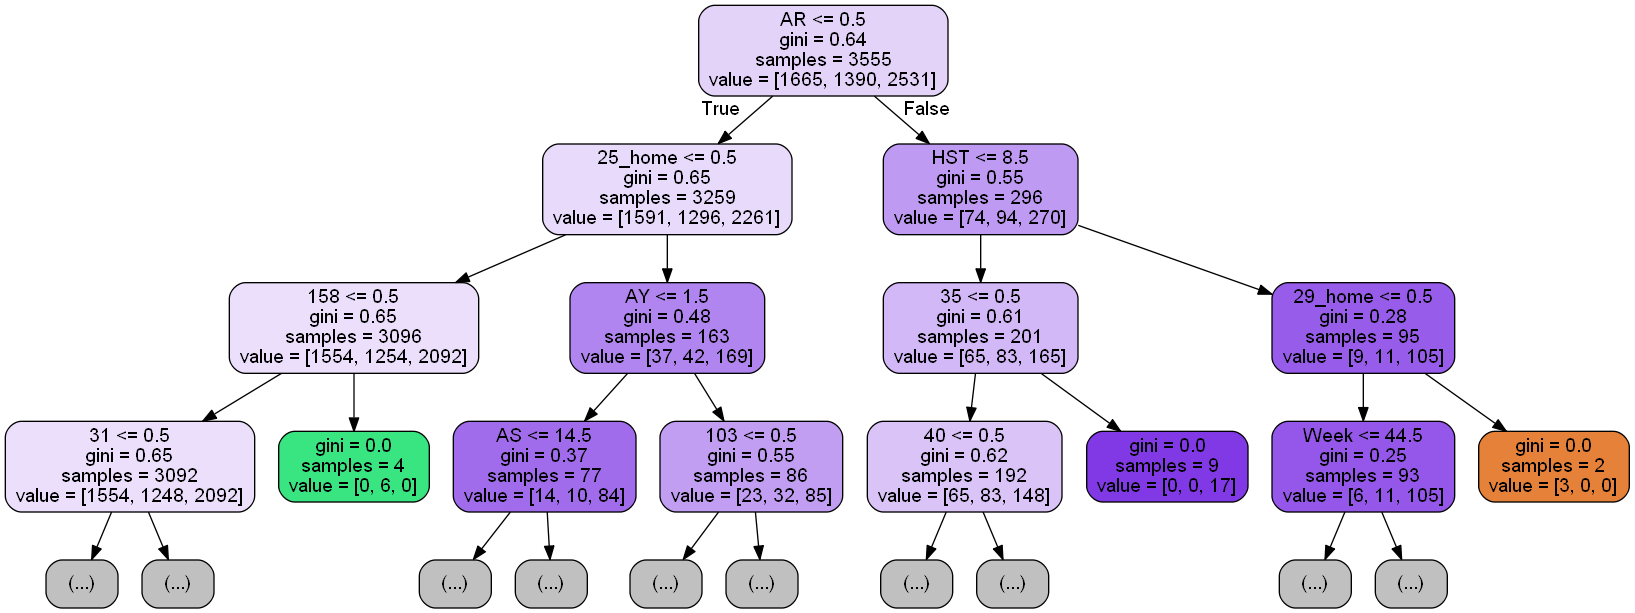

In [9]:
#Print rf tree N.B. may not work without importing graphviz, random forest images will be on GitHub
Image(filename = rf_tree_visualiser(rf, 'featureSetTree', data_filtered.columns))

### 3.1.6 Training model without Referee
<a name='section316'></a>

In [10]:
#Train model without Referee feature
data_filtered_no_ref = data_filtered.iloc[:, 0:15].join(data_filtered.iloc[:, 58:])
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_ref, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Referee: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")
#Ref is having negative impact so remove
data_filtered = data_filtered_no_ref

Accuracy without Referee: 56.97577276524645%
Difference from before: 0.3341687552213841%


### 3.1.7 Random Forest Tree without Referee
<a name='section317'></a>

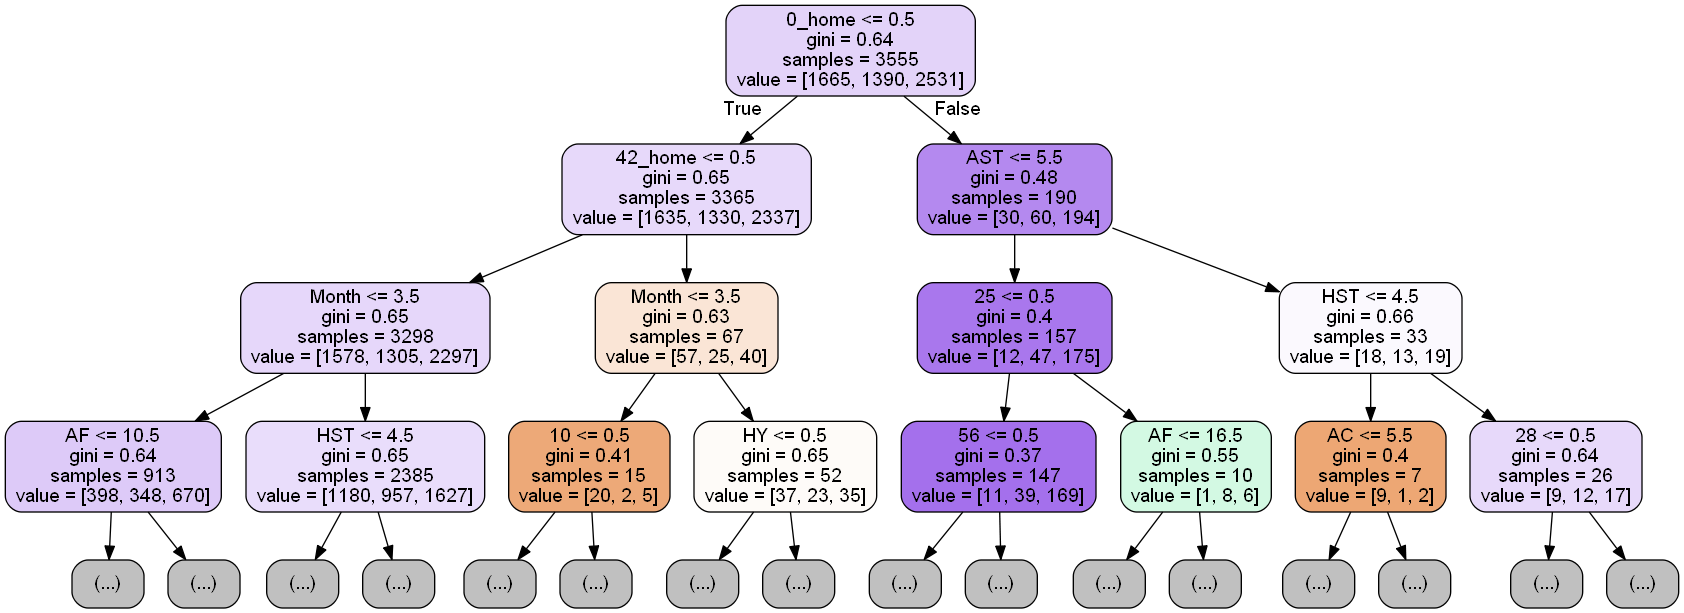

In [11]:
#Print rf tree (no ref)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoRef', data_filtered_no_ref.columns))

### 3.1.8 Training model without Date
<a name='section318'></a>

In [12]:
#Train model without Date feature
data_filtered_no_date = data_filtered.iloc[:, 3:]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_no_date, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy without Dates: " + str(accuracy) + "%")
print("Difference from before: " + str(accuracy - base_accuracy) + "%")

Accuracy without Dates: 56.68337510442774%
Difference from before: 0.04177109440267657%


### 3.1.9 Random Forest Tree without Date
<a name='section319'></a>

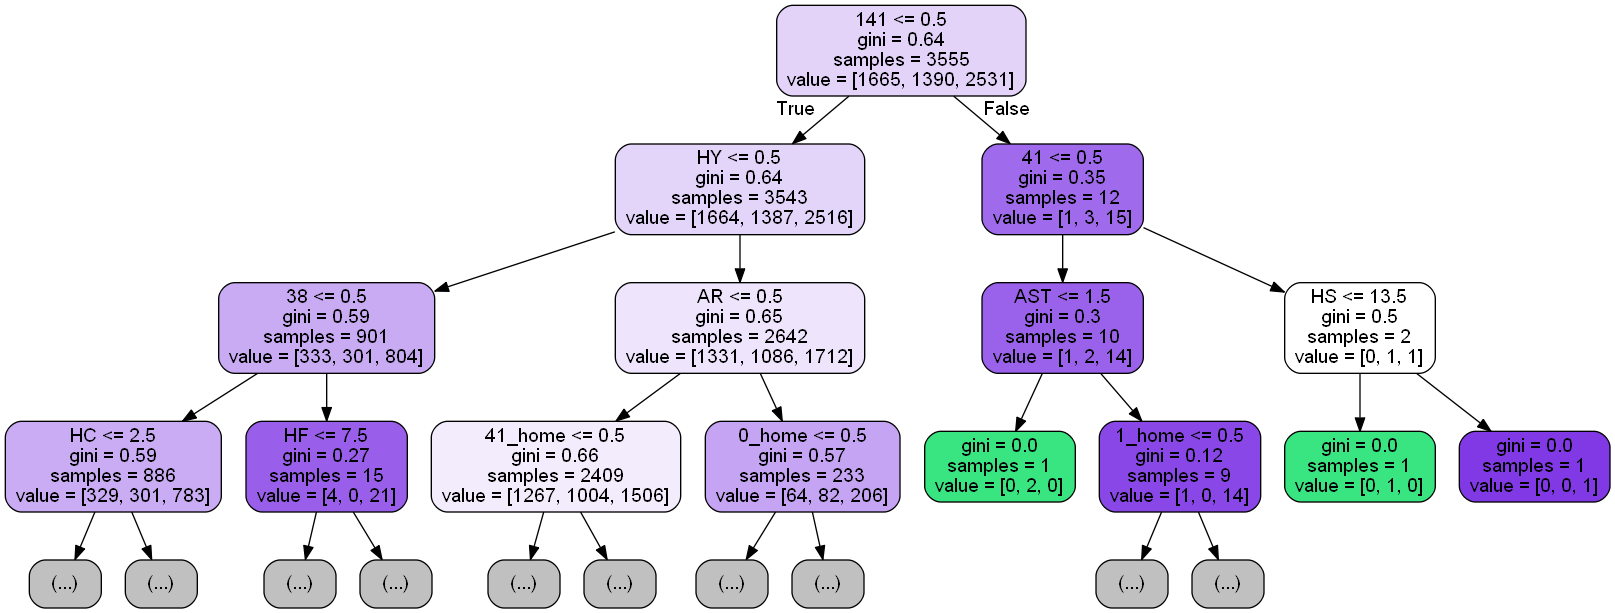

In [13]:
#Print rf tree (no dates)
Image(filename = rf_tree_visualiser(rf, 'featureSetTreeNoDate', data_filtered_no_date.columns))

### 3.1.10 Training model on only in-game stats
<a name='section3110'></a>

In [14]:
#Train model on only in-game stats to identify most important ones
data_filtered_only_game_stats = data_filtered.iloc[:, 3:15]
X_train, X_test, y_train, y_test = train_test_split(data_filtered_only_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

Accuracy on all in-game stats: 55.51378446115288%


### 3.1.11 Visualising selected features
<a name='section3111'></a>

In [15]:
#Visualise and analyse initial results

#Display feature importances in descending order
feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))
#Important note: AF/HF rank higher than HC/AC

Feature Importances: 
Feature: HST                                 Importance: 0.12062860482667323
Feature: HS                                  Importance: 0.1095698299548388
Feature: AF                                  Importance: 0.10773279032401849
Feature: AS                                  Importance: 0.10644024578251926
Feature: HF                                  Importance: 0.10552340949204712
Feature: AST                                 Importance: 0.10340580600855823
Feature: HC                                  Importance: 0.09977784314864165
Feature: AC                                  Importance: 0.09278372110367616
Feature: AY                                  Importance: 0.06835535366590526
Feature: HY                                  Importance: 0.061179795298330265
Feature: AR                                  Importance: 0.01327811150903203
Feature: HR                                  Importance: 0.011324488885759381

Confusion Matrix: 
[[393  63 238]
 [175  73 355]
 [1

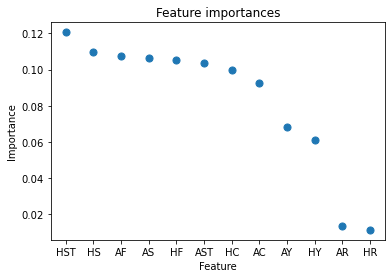

In [16]:
# Visualise feature importance
scatter(feature_importances, "Feature importances", "Feature", "Importance")

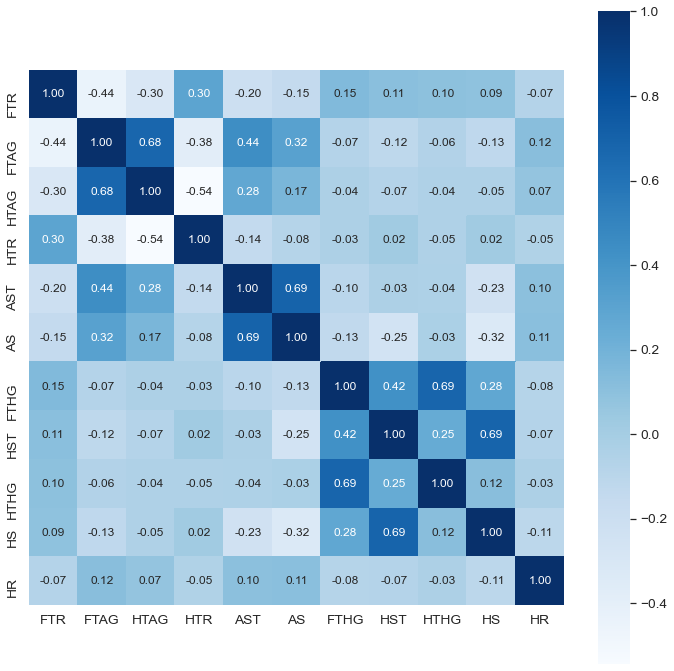

In [17]:
# plot Pearson Correlation Heatmap to see the top 10 features related to the match result FTR

def plotGraph(X_all, Y_all):

    train_data=pd.concat([X_all,Y_all],axis=1)

    #FTR correlation matrix
    plt.figure(figsize=(12,12))
    k = 11 # number of variables for heatmap
    cols = abs(train_data.astype(float).corr()).nlargest(k, 'FTR')['FTR'].index
    cm = np.corrcoef(train_data[cols].values.T)
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, cmap="Blues", yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

attributes = data.drop(['Date','HomeTeam', 'AwayTeam', 'Referee','FTR'],1)
attributes['HTR'] = attributes['HTR'].map({'H':1,'A':0,'D':2})
label = data['FTR']
label = label.map({'H':1,'A':0,'D':2})
plotGraph(attributes,label)


In [18]:
#Feature Selection
#change names and display selected features more nicely, ideally with their importance, gini impurity...
selected_feat = select_feat(X_train, y_train)
print(selected_feat)

Index(['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC'], dtype='object')


In [19]:
#Train model on selected in-game stats only
indexes = []
for feat in selected_feat:
    indexes.append(data_filtered_only_game_stats.columns.get_loc(feat))
    
data_filtered_filtered_game_stats = data_filtered_only_game_stats.iloc[:, indexes]

X_train, X_test, y_train, y_test = train_test_split(data_filtered_filtered_game_stats, y, test_size=0.3, random_state=42)

y_train = np.array(y_train).reshape(len(y_train))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)


rf, preds, reduced_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on reduced in-game stats: " + str(reduced_stats_accuracy) + "%")
print("Difference compared to all in-game stats: " + str(reduced_stats_accuracy - all_stats_accuracy) + "%")

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, preds))
print("\nClassification Report: ")
print(classification_report(y_test, preds))

Accuracy on reduced in-game stats: 54.92898913951546%
Difference compared to all in-game stats: -0.5847953216374222%

Confusion Matrix: 
[[379  72 243]
 [163  79 361]
 [149  91 857]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       694
           1       0.33      0.13      0.19       603
           2       0.59      0.78      0.67      1097

    accuracy                           0.55      2394
   macro avg       0.49      0.49      0.47      2394
weighted avg       0.51      0.55      0.51      2394



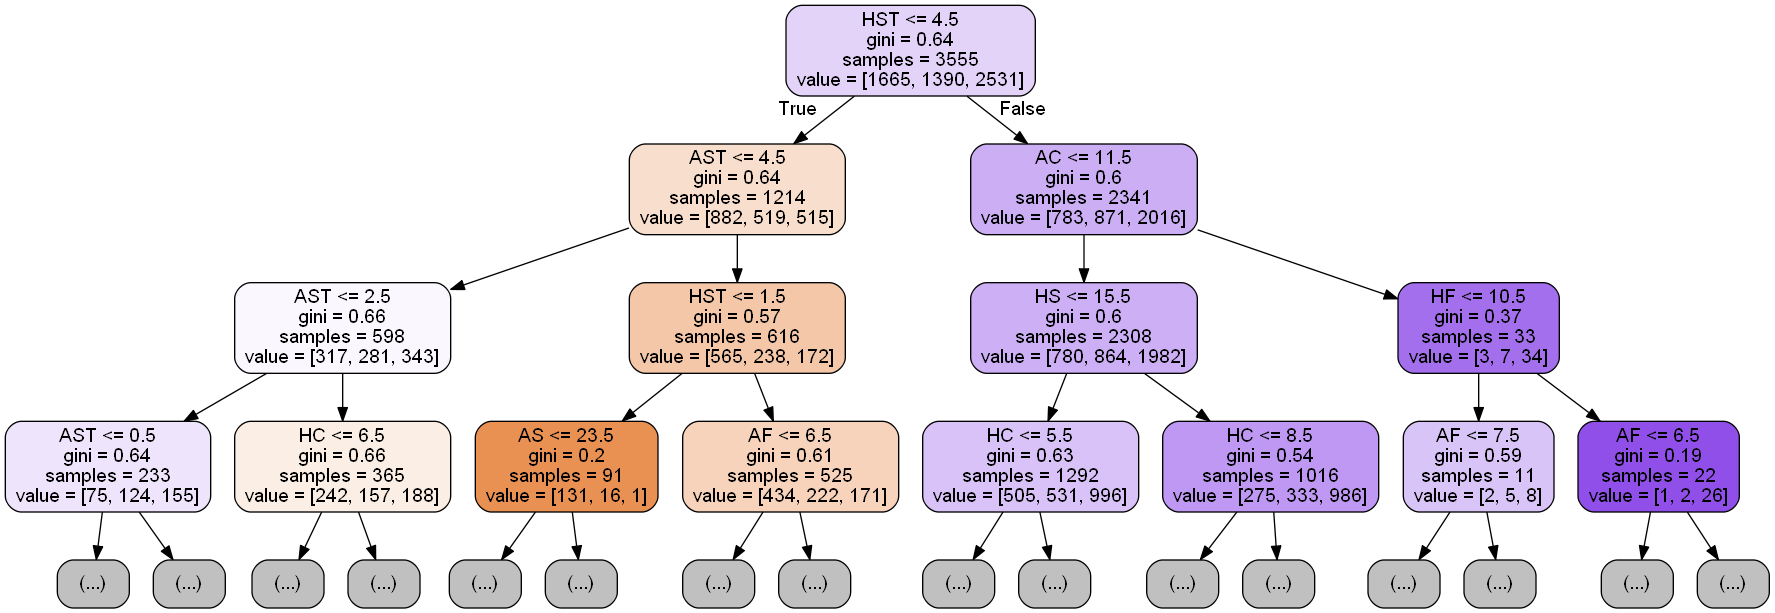

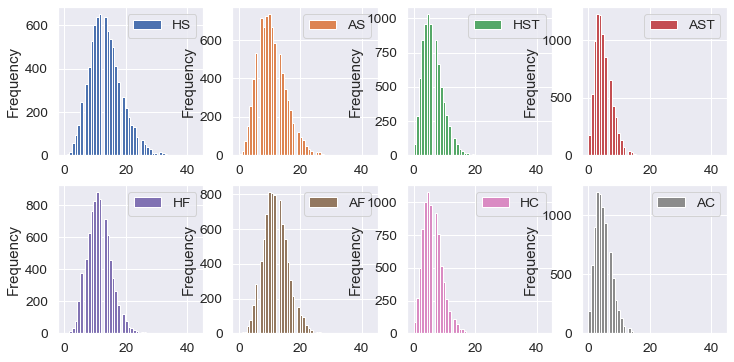

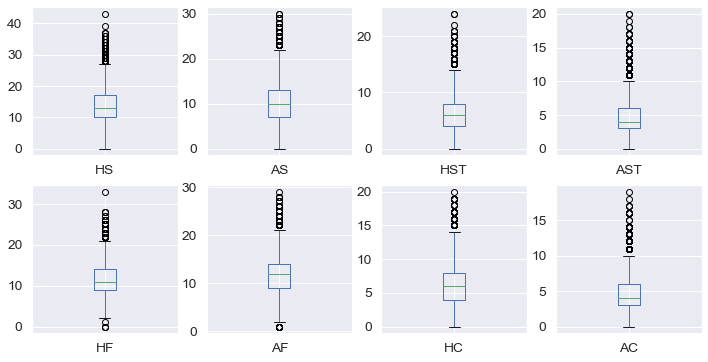

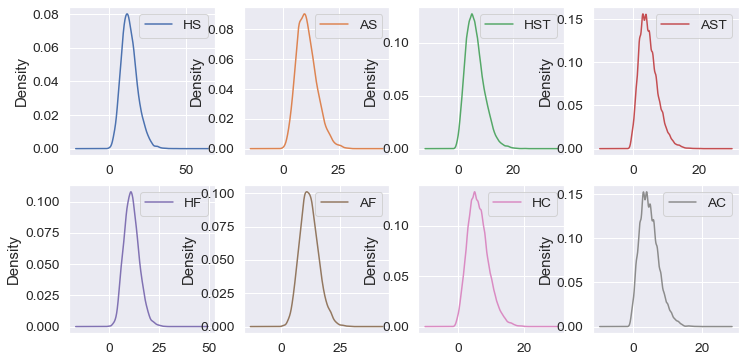

In [20]:
#Visualisation of new featureset/tree
data_filtered_filtered_game_stats.plot(kind='hist', subplots=True, sharex=False, sharey=False, bins=50, layout=(2,4), figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
data_filtered_filtered_game_stats.plot(kind='density', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(12, 6))
Image(filename = rf_tree_visualiser(rf, 'selectedFeatureSetTree', data_filtered_filtered_game_stats.columns))

In [21]:
#Produce new dataset
#Fix column names
#Restack teams and dates

#Original teams are needed to be able to compute priors
data_new = data.iloc[:, [1, 2]].join(data_filtered_filtered_game_stats)
data_new = dates_split.join(data_new)

#Stack previously removed giveaway columns
data_new = data_new.join(data.iloc[:, [3, 4, 5, 6, 7, 8]])

#Feature engineer second half goals
#Second half home goals
SHHG = np.array(data.iloc[:, [3]]) - np.array(data.iloc[:, [6]])
#Second half away goals
SHAG = np.array(data.iloc[:, [4]]) - np.array(data.iloc[:, [7]])
data_new['SHHG'] = pd.DataFrame(SHHG)
data_new['SHAG'] = pd.DataFrame(SHAG)
data_new.columns = data_new.columns.astype(str)
data_new.head()

Month  Week  Day  HomeTeam       AwayTeam  HS  AS  HST  AST  HF  AF  HC  \
0      8    33   19  Charlton       Man City  17   8   14    4  13  12   6   
1      8    33   19   Chelsea       West Ham  17  12   10    5  19  14   7   
2      8    33   19  Coventry  Middlesbrough   6  16    3    9  15  21   8   
3      8    33   19     Derby    Southampton   6  13    4    6  11  13   5   
4      8    33   19     Leeds        Everton  17  12    8    6  21  20   6   

   AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG  
0   6     4     0   H     2     0   H     2     0  
1   7     4     2   H     1     0   H     3     2  
2   4     1     3   A     1     1   D     0     2  
3   8     2     2   D     1     2   A     1     0  
4   4     2     0   H     2     0   H     0     0

In [22]:
#See if second half goals have significant correlation to total goals
highest_corr = corr_matrix(data_new, "FTHG")
print("FTHG: \n" + str(highest_corr))

highest_corr = corr_matrix(data_new, "FTAG")
print("FTAG: \n" + str(highest_corr))
#Second half goals do have very strong correlation

FTHG: 
HS      0.280689
HST     0.424065
FTHG    1.000000
HTHG    0.685341
SHHG    0.768719
Name: FTHG, dtype: float64
FTAG: 
AS      0.315637
AST     0.440352
FTAG    1.000000
HTAG    0.679786
SHAG    0.775978
Name: FTAG, dtype: float64


## 3.2 Priors Feature Construction
<a name='section32'></a>

In [23]:
# From Pearson Correlation Heatmap to extract the top 10 features 
# there are two pairs of data highly correlated (see details in report), 
# so we just pick [FTHG, FTAG, HS, AS, HR, AR] from the top 10 features,
# additionally [Date, HomeTeam, AwayTeam, FTR], to derive our features.
selectedAttributes = ["Date","HomeTeam", "AwayTeam","FTR","FTHG","FTAG","HS","AS","HR","AR"]
training_data = data[selectedAttributes]

### 3.2.1 Data Cleaning
<a name='section321'></a>

In [24]:
#Derive features and remove unwanted data
def removeInvalidData(data):

    # remove data which contains None
    data.dropna(axis=0, how='any',inplace=True)

    # remove data which contains NaN, infinite or overflowed number 
    indices_to_keep = ~data.isin([np.nan, np.inf, -np.inf]).any(1)
    data = data[indices_to_keep]

    return data

#check if there are rows containing None, NaN, infinite or overflowed values
assert data.shape[0] == removeInvalidData(data).shape[0]
data = removeInvalidData(data)


In [25]:
# convert the different date formats and convert the type from str to timestamp  
def convertDate(data):
    if not isinstance(data.Date[0],str):
        return

    newDate = []
    for _, matchInfo in data.iterrows():
        if len(matchInfo.Date) == 8 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%y" ))
        elif len(matchInfo.Date) == 9 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d %b %y" ))  # the date format in test data
        elif len(matchInfo.Date) == 10 :
            newDate.append(pd.to_datetime(matchInfo.Date, format="%d/%m/%Y" ))
    
    data['Date'] = pd.Series(newDate).values

    return data

# converted the date formats for later exploration and transformation
# convertDate(data_new)

### 3.2.2 Cumulative Full-time W/L Ratio
<a name='section322'></a>

In [26]:
# Computing Priors
# Calculate cumulative Full-Time win-loss ratio for Home/Away teams prior to every match
# TODO: Points-based results based on previous wins & losses 
# PHWL = Previous Home Team Win Loss Ratio
# PAWL = Previous Away Team Win Loss Ratio

def get_previousFTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    PHWL = []
    PAWL = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if y[i] == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif y[i] == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
       
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
        
        #Home/Away cumulative WL ratios prior to every match
        PHWL.append(h_wlRatio)
        PAWL.append(a_wlRatio)
        
    playing_stat.loc[:,'PHWL'] = pd.Series(PHWL)
    playing_stat.loc[:,'PAWL'] = pd.Series(PAWL)

    return playing_stat

#get_previousFTResults(data_new)

###  3.2.3 Cumulative Half-time W/L Ratio
<a name='section323'></a>

In [27]:
# Computing Priors
# Calculate cumulative Half-Time win-loss ratio for Home/Away teams prior to every match
# HHTR = Previous Home Half Time Results
# AHTR = Previous Away Half Time Results

def get_PreviousHTResults(playing_stat):
    
    # Create a dictionary with team names as keys
    teams = {}
    HHTR = []
    AHTR = []
    
    for i in playing_stat.groupby('HomeTeam').mean().T.columns:
        teams[i] = [] #Each team gets their own list

    # the value corresponding to keys is a list containing the match result
    for i in range(len(playing_stat)):
        
        #list of respective Home/Away team in match
        match_ht = teams[playing_stat.iloc[i].HomeTeam]
        match_at = teams[playing_stat.iloc[i].AwayTeam]
        
        #count no. of wins
        
        h_wins = Counter(match_ht)
        a_wins = Counter(match_at)
        
        #h_wins = no. of home wins
        #a_wins = no. of away wins
        h_wins = h_wins['W']
        a_wins = a_wins['W']
        
        #append W/L/D to respective teams
        
        if playing_stat.iloc[i].HTR == 'H':
            match_ht.append('W')
            match_at.append('L')
        elif playing_stat.iloc[i].HTR == 'A':
            match_at.append('W')
            match_ht.append('L')
        else:
            match_at.append('D')
            match_ht.append('D')
            
        h_wlRatio = h_wins / len(match_ht)
        a_wlRatio = a_wins / len(match_at)
       
        #Home/Away cumulative WL ratios prior to every match
        HHTR.append(h_wlRatio)
        AHTR.append(a_wlRatio)
        
    playing_stat.loc[:,'HHTR'] = pd.Series(HHTR)
    playing_stat.loc[:,'AHTR'] = pd.Series(AHTR)

    return playing_stat


#get_PreviousHTResults(data_new)

### 3.2.4 Cumulative Full-Time goals scored
<a name='section324'></a>

In [28]:
# Computing Priors
# Calculate Previous Full-Time Cumulative Goal 
# PHGS = Previous Home Goal Scored
# PAGS = Previous Away Goal Scored

def getPreviousCumulativeGoals(priorData):
    teams = {}
    PHGS = [] 
    PAGS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            pcgs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcgs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcgs_h = 0
            pcgs_a = 0

        PHGS.append(pcgs_h)
        PAGS.append(pcgs_a)
#         print(PAGS)
#         print(PHGS)
        pcgs_h = pcgs_h + FTHG #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcgs_h)
        pcgs_a = pcgs_a + FTAG #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcgs_a)

    priorData.loc[:,'PHGS'] = pd.Series(PHGS)
    priorData.loc[:,'PAGS'] = pd.Series(PAGS)
    return priorData

#getPreviousCumulativeGoals(data_new)

### 3.2.5 Cumulative Half-time W/L Ratio
<a name='section325'></a>

In [29]:
# Computing Priors
# Calculate Previous Shots in the match
# PHS = Home teams previous match Shots, totaled over season
# PAS = Away teams previous match Shots, totaled over season

def getPreviousShots(priorData):
    teams = {}
    PHS = [] 
    PAS = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HS = priorData.iloc[i]['HS']
        AS = priorData.iloc[i]['AS']

        try:
            pcs_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcs_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcs_h = 0
            pcs_a = 0

        PHS.append(pcs_h)
        PAS.append(pcs_a)
        pcs_h = pcs_h + HS #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcs_h)
        pcs_a = pcs_a + AS #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcs_a)

    priorData.loc[:,'PHS'] = pd.Series(PHS)
    priorData.loc[:,'PAS'] = pd.Series(PAS)
    return priorData

#getPreviousShots(data_new)

### 3.2.6 Previous shots on target
<a name='section326'></a>

In [30]:
# Computing Priors
# Calculate Previous Shots on Target
# PHSOT = Home teams Previous Shots on Target, totaled over season
# PASOT = Away teams Previous Shots on Target, totaled over season

def getPreviousShotsOnTarget(priorData):
    teams = {}
    PHSOT = [] 
    PASOT = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HST = priorData.iloc[i]['HST']
        AST = priorData.iloc[i]['AST']

        try:
            pcsot_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcsot_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcsot_h = 0
            pcsot_a = 0

        PHSOT.append(pcsot_h)
        PASOT.append(pcsot_a)
        pcsot_h = pcsot_h + HST #Home team's previous goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pcsot_h)
        pcsot_a = pcsot_a + AST #Away team's previous goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pcsot_a)

    priorData.loc[:,'PHSOT'] = pd.Series(PHSOT)
    priorData.loc[:,'PASOT'] = pd.Series(PASOT)
    return priorData

#getPreviousShotsOnTarget(data_new)

### 3.2.7 Computing previous fouls
<a name='section327'></a>

In [31]:
# Computing Priors
# Calculate Previous Fouls
# PHTF = Home teams Previous Fouls, Totaled over season
# PATF = Away teams Previous Fouls, Totaled over season

def getPreviousTeamFouls(priorData):
    teams = {}
    PHTF = [] 
    PATF = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HF = priorData.iloc[i]['HF']
        AF = priorData.iloc[i]['AF']

        try:
            pcf_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcf_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcf_h = 0
            pcf_a = 0

        PHTF.append(pcf_h)
        PATF.append(pcf_a)
        pcf_h = pcf_h + HF #Home team's previous fouls before this match
        teams[priorData.iloc[i].HomeTeam].append(pcf_h)
        pcf_a = pcf_a + AF #Away team's previous fouls before this match
        teams[priorData.iloc[i].AwayTeam].append(pcf_a)

    priorData.loc[:,'PHTF'] = pd.Series(PHTF)
    priorData.loc[:,'PATF'] = pd.Series(PATF)
    return priorData

#getPreviousTeamFouls(data_new)

### 3.2.8 Computing previous corners
<a name='section328'></a>

In [32]:
# Computing Priors
# Calculate Previous Corners
# PHTC = Home teams Previous Corners, Totaled over season
# PATC = Away teams Previous Corners, Totaled over season

def getPreviousTeamCorners(priorData):
    teams = {}
    PHTC = [] 
    PATC = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HC = priorData.iloc[i]['HC']
        AC = priorData.iloc[i]['AC']

        try:
            pcc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pcc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pcc_h = 0
            pcc_a = 0

        PHTC.append(pcc_h)
        PATC.append(pcc_a)
        pcc_h = pcc_h + HC #Home team's previous corners before this match
        teams[priorData.iloc[i].HomeTeam].append(pcc_h)
        pcc_a = pcc_a + AC #Away team's previous corners before this match
        teams[priorData.iloc[i].AwayTeam].append(pcc_a)

    priorData.loc[:,'PHTC'] = pd.Series(PHTC)
    priorData.loc[:,'PATC'] = pd.Series(PATC)
    return priorData

#getPreviousTeamCorners(data_new)

### 3.2.9 Computing previous goals before half-time
<a name='section329'></a>

In [33]:
# Computing Priors
# Calculate Previous Goals before half time
# PHTHG = Home teams Previous Goals Before Half Time, Totaled over season
# PHTAG = Away teams Previous Goals Before Half Time, Totaled over season

def getPreviousHalfTimeGoalsScored(priorData):
    teams = {}
    PHTHG = [] 
    PHTAG = []   

    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pchtg_h = teams[priorData.iloc[i].HomeTeam].pop()
            pchtg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pchtg_h = 0
            pchtg_a = 0

        PHTHG.append(pchtg_h)
        PHTAG.append(pchtg_a)
        pchtg_h = pchtg_h + HTHG #Home team's previous first half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(pchtg_h)
        pchtg_a = pchtg_a + HTAG #Away team's previous first half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(pchtg_a)

    priorData.loc[:,'PHTHG'] = pd.Series(PHTHG)
    priorData.loc[:,'PHTAG'] = pd.Series(PHTAG)
    return priorData

#getPreviousHalfTimeGoalsScored(data_new)

### 3.2.10 Compute previous goals after half-time
<a name='section3210'></a>

In [34]:
# Computing Priors
# Calculate Previous Second Half Time Goals in the match
# PSHHG = Previous Second Half Time Goals scored by Home team, totaled over season
# PSHAG = Previous Second Half Time Goals scored by Away team, totaled over season

def getPreviousSecondHalfGoals(priorData):
    teams = {}
    PSHHG = [] 
    PSHAG = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            shg_h = teams[priorData.iloc[i].HomeTeam].pop()
            shg_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            shg_h = 0
            shg_a = 0

        PSHHG.append(shg_h)
        PSHAG.append(shg_a)
        shg_h = shg_h + (FTHG - HTHG) #Home team's previous second half goals scored before this match
        teams[priorData.iloc[i].HomeTeam].append(shg_h)
        shg_a = shg_a + (FTAG - HTAG) #Away team's previous second half goals scored before this match
        teams[priorData.iloc[i].AwayTeam].append(shg_a)

    priorData.loc[:,'PSHHG'] = pd.Series(PSHHG)
    priorData.loc[:,'PSHAG'] = pd.Series(PSHAG)
    return priorData

#getPreviousSecondHalfGoals(data_new)

### 3.2.11 Computing previous goals conceded before half-time
<a name='section3211'></a>

In [35]:
# Computing Priors
# Calculate previous goals conceded before half-time
# PHTHGC = Home Team Previous Goals Conceded Before Half Time, totaled over season
# PHTAGC = Away Team Previous Goals Conceded Before Half Time, Totaled over season

def getPreviousHalfTimeGoalConceded(priorData):
    teams = {}
    PHTHGC = [] 
    PHTAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
                      
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            phtgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            phtgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            phtgc_h = 0
            phtgc_a = 0

        PHTHGC.append(phtgc_h)
        PHTAGC.append(phtgc_a)
        phtgc_h = phtgc_h + HTAG #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(phtgc_h)
        phtgc_a = phtgc_a + HTHG #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(phtgc_a)

    priorData.loc[:,'PHTHGC'] = pd.Series(PHTHGC)
    priorData.loc[:,'PHTAGC'] = pd.Series(PHTAGC)
    return priorData

#getPreviousHalfTimeGoalConceded(data_new)

### 3.2.12 Computing previous goals conceded after half-time
<a name='section3212'></a>

In [36]:
# Computing Priors
# Calculate previous goals conceded after half-time
# PSHHGC = Previous second half home team goals conceded, totaled over season
# PSHAGC = Previous second half away team goals conceded, totaled over season

def getPreviousSecondHalfGoalConceded(priorData):
    teams = {}
    PSHHGC = [] 
    PSHAGC = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]
  
        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']   
        HTHG = priorData.iloc[i]['HTHG']
        HTAG = priorData.iloc[i]['HTAG']

        try:
            pshhgc_h = teams[priorData.iloc[i].HomeTeam].pop()
            pshhgc_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pshhgc_h = 0
            pshhgc_a = 0

        PSHHGC.append(pshhgc_h)
        PSHAGC.append(pshhgc_a)
        pshhgc_h = pshhgc_h + (FTAG - HTAG) #Home team's previous half time goals conceded before this match
        teams[priorData.iloc[i].HomeTeam].append(pshhgc_h)
        pshhgc_a = pshhgc_a + (FTHG - HTHG) #Away team's previous half time goals conceded before this match
        teams[priorData.iloc[i].AwayTeam].append(pshhgc_a)

    priorData.loc[:,'PSHHGC'] = pd.Series(PSHHGC)
    priorData.loc[:,'PSHAGC'] = pd.Series(PSHAGC)
    return priorData

#getPreviousSecondHalfGoalConceded(data_new)

### 3.2.13 Matches Played
<a name='section3213'></a>

In [37]:
# Computing Priors 
# Calculate previous goals conceded after half-time
# PMPH = Previous total matches played for home team
# PMPA = Previous total matches played for away team
def getPreviousMatchesPlayed(priorData):
    teams = {}
    PMPH = [] 
    PMPA = []   
    
    # for each match
    for i in range(len(priorData)):
        if (i % 100000 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = [0]

        try:
            pmp_h = teams[priorData.iloc[i].HomeTeam].pop()
            pmp_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            pmp_h = 0
            pmp_a = 0

        PMPH.append(pmp_h)
        PMPA.append(pmp_a)
        pmp_h = pmp_h + 1 #Home team's previous number matches played
        teams[priorData.iloc[i].HomeTeam].append(pmp_h)
        pmp_a = pmp_a + 1 #Away team's previous number matches played
        teams[priorData.iloc[i].AwayTeam].append(pmp_a)

    priorData.loc[:,'PMPH'] = pd.Series(PMPH)
    priorData.loc[:,'PMPA'] = pd.Series(PMPA)
    return priorData

print(getPreviousMatchesPlayed(data_new))

      Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   19          Charlton        Man City  17   8   14    4   
1         8    33   19           Chelsea        West Ham  17  12   10    5   
2         8    33   19          Coventry   Middlesbrough   6  16    3    9   
3         8    33   19             Derby     Southampton   6  13    4    6   
4         8    33   19             Leeds         Everton  17  12    8    6   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
7975      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
7976      5    20   23          Man City         Everton  21   8   11    3   
7977      5    20   23  Sheffield United         Burnley  12  10    3    3   
7978      5    20   23          West Ham     Southampton  14  17    7    5   
7979      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHA

## 3.3 Additional Features
<a name='section33'></a>

### 3.3.1 Distance Travelled for Away Teams
<a name='section331'></a>

In [38]:
# DIS
# The positionalData contains the latitude and longitude of teams
def getDistance(priorData):
  array = []
  for x in priorData.iterrows():
   
    home_lat = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Latitude
    home_long = (positionalData.loc[positionalData['Team'] == x[1].HomeTeam]).Longitude
    home_location = (np.float32(home_lat), np.float32(home_long))
    
    away_lat = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Latitude
   
    away_long = (positionalData.loc[positionalData['Team'] == x[1].AwayTeam]).Longitude
    away_location = (np.float32(away_lat), np.float32(away_long))
    array.append(np.float32(geodesic(home_location, away_location).km))
  
  
  DIS = pd.Series(array)
  priorData.loc[:,'DIS'] = DIS

  return priorData

### 3.3.2 Average shots on goal in the past 3 matches
<a name='section332'></a>

In [39]:
# Average shots on goal for the past 3 matches
# HAS, AAS
def getPreviousShotOnGoal_3(priorData):
    teams = {}
    HAS = [] 
    AAS = []   
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = deque([None, None, None]) #[3rd, 2nd, latest priorData]
            
    # for each match
    for i in range(len(priorData)):

            
        try:
            as_h = np.mean(teams[priorData.iloc[i].HomeTeam])
            as_a = np.mean(teams[priorData.iloc[i].AwayTeam])
        except:
            as_h = None
            as_a = None

        HAS.append(as_h)
        AAS.append(as_a)

        teams[priorData.iloc[i].HomeTeam].popleft()
        teams[priorData.iloc[i].HomeTeam].append(priorData.iloc[i].HS)

        teams[priorData.iloc[i].AwayTeam].popleft()
        teams[priorData.iloc[i].AwayTeam].append(priorData.iloc[i].AS)

    priorData.loc[:,'HAS'] = pd.Series(HAS)
    priorData.loc[:,'AAS'] = pd.Series(AAS)

    return priorData

#getPreviousShotOnGoal_3(data_new)

### 3.3.3 WL Performance of past 3 matches
<a name='section333'></a>

In [40]:
# Performance of Home-Away teams in past 3 matches
# HM1, AM1, HM2, AM2, HM3, AM3
def getPerformanceOfLast3Matches(priorData):
    HM1 = []    # performance of the last match of home team
    AM1 = []    # performance of the last match of away team

    HM2 = []    # performance of the 2nd last match of home team
    AM2 = []

    HM3 = []    # performance of the 3rd last match of home team
    AM3 = []

    teams = {}
    
    for name in priorData.groupby('HomeTeam').mean().T.columns:
               teams[name] = deque([None, None, None])  #[3rd, 2nd, latest priorData]

    for i in range(len(priorData)):
        

        HM3.append(teams[priorData.iloc[i].HomeTeam].popleft())
        AM3.append(teams[priorData.iloc[i].AwayTeam].popleft())
        HM2.append(teams[priorData.iloc[i].HomeTeam][0])
        AM2.append(teams[priorData.iloc[i].AwayTeam][0])
        HM1.append(teams[priorData.iloc[i].HomeTeam][1])
        AM1.append(teams[priorData.iloc[i].AwayTeam][1])

        if priorData.iloc[i].FTR == 'H':
            teams[priorData.iloc[i].HomeTeam].append('W')
            teams[priorData.iloc[i].AwayTeam].append('L')
        elif priorData.iloc[i].FTR == 'A':
            teams[priorData.iloc[i].AwayTeam].append('W')
            teams[priorData.iloc[i].HomeTeam].append('L')
        else:
            teams[priorData.iloc[i].AwayTeam].append('D')
            teams[priorData.iloc[i].HomeTeam].append('D')

    priorData.loc[:,'HM1'] = HM1
    priorData.loc[:,'AM1'] = AM1
    priorData.loc[:,'HM2'] = HM2
    priorData.loc[:,'AM2'] = AM2
    priorData.loc[:,'HM3'] = HM3
    priorData.loc[:,'AM3'] = AM3

    return priorData

#print(getPerformanceOfLast3Matches(data_new)

### 3.3.4 Cumulative Full Time Goal Difference
<a name='section334'></a>

In [41]:
# Computing Priors
# Calculate cumulative Full-Time goal different for Home/Away teams prior to every match
# HCGD = Home Cumulative Goal Difference
# ACGD = Away Cumulative Goal Difference
def getCumulativeGoalsDiff(priorData):
    teams = {}
    HCGD = [] 
    ACGD = []   

    # for each match
    for i in range(len(priorData)):
        # as the result in 3.2.1 shows that the number of matchese per season is always the same, so here we simply use i%380==0 to check if it is a new season and to initialize the feature.
        if (i % 380 == 0):
            for name in priorData.groupby('HomeTeam').mean().T.columns:
                teams[name] = []

        FTHG = priorData.iloc[i]['FTHG']
        FTAG = priorData.iloc[i]['FTAG']

        try:
            cgd_h = teams[priorData.iloc[i].HomeTeam].pop()
            cgd_a = teams[priorData.iloc[i].AwayTeam].pop()
        except:
            cgd_h = 0
            cgd_a = 0

        HCGD.append(cgd_h)
        ACGD.append(cgd_a)
        cgd_h = cgd_h + FTHG - FTAG
        teams[priorData.iloc[i].HomeTeam].append(cgd_h)
        cgd_a = cgd_a + FTAG - FTHG
        teams[priorData.iloc[i].AwayTeam].append(cgd_a)

    priorData.loc[:,'HCGD'] = pd.Series(HCGD)
    priorData.loc[:,'ACGD'] = pd.Series(ACGD)

    return priorData

#getCumulativeGoalsDiff(data_new)

### Priors - extra features pulled

In [42]:
def add_pickled_to_df(df,filename,column):
    matrix = pd.read_pickle(filename)
    matrix[2008] = np.NaN
#     print(matrix)
    difference = []
    for i in range(0,len(data_new)):
    #     print(ratings_matrix["mean"].loc[data_new["HomeTeam"].iloc[i]])
        if pd.isnull(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]) or pd.isnull(matrix[year[i]].loc[df["AwayTeam"].iloc[i]]):
            difference.append(np.nan)
            
        else:
            difference.append(matrix[year[i]].loc[df["HomeTeam"].iloc[i]]-matrix[year[i]].loc[df["AwayTeam"].iloc[i]])

#     for i in range(0,len(difference)):
#         if difference[i]<-0.1:
#             difference[i]='A'
#         elif difference[i]>0.1:
#             difference[i]='H'
#         else:
#             difference[i]='D'

    df[column]=difference
    return df

### We have decided not to include these scraped features due to the many missing values without a reliable way to impute them.

In [43]:
# import glob
# files = glob.glob("./Pickles/*")
# for file in files:
#     name = file.split("\\")[-1].split(".")[0].replace("DF","")
#     data_new = add_pickled_to_df(data_new,file,name)

# data_new

## 3.4 Derive Priors
<a name='section34'></a>

In [44]:
def DerivePriors(priorData):
    #get_previousFTResults(priorData) # dont want Full time results in the test data
    get_PreviousHTResults(priorData)
    getPreviousCumulativeGoals(priorData)
    getPreviousShots(priorData)
    getPreviousShotsOnTarget(priorData)
    getPreviousTeamFouls(priorData)
    getPreviousTeamCorners(priorData)
    getPreviousHalfTimeGoalsScored(priorData)
    getPreviousSecondHalfGoals(priorData)
    getPreviousHalfTimeGoalConceded(priorData)
    getPreviousSecondHalfGoalConceded(priorData)
    getPreviousMatchesPlayed(priorData)
    getDistance(priorData)
    getPreviousShotOnGoal_3(priorData)
    getPerformanceOfLast3Matches(priorData)
    getCumulativeGoalsDiff(priorData)
    return priorData

In [45]:
## Remove First Initial Season
data_new = DerivePriors(data_new).iloc[380:] #chop off first season 
y=np.delete(y,slice(0,380),axis=0)
data_new.reset_index(drop=True, inplace=True)
data_new 

Month  Week  Day          HomeTeam        AwayTeam  HS  AS  HST  AST  \
0         8    33   18          Charlton         Everton   8  12    4    9   
1         8    33   18             Derby       Blackburn   7  14    3    4   
2         8    33   18             Leeds     Southampton  16  11    6    6   
3         8    33   18         Leicester          Bolton   6  18    1    8   
4         8    33   18         Liverpool        West Ham   9   3    6    3   
...     ...   ...  ...               ...             ...  ..  ..  ...  ...   
7595      5    20   23         Liverpool  Crystal Palace  19   5    5    4   
7596      5    20   23          Man City         Everton  21   8   11    3   
7597      5    20   23  Sheffield United         Burnley  12  10    3    3   
7598      5    20   23          West Ham     Southampton  14  17    7    5   
7599      5    20   23            Wolves      Man United  14   9    4    4   

      HF  AF  HC  AC  FTHG  FTAG FTR  HTHG  HTAG HTR  SHHG  SHAG  PMPH  PMPA  \
0     15  17   4   4     1     2   A     0     0   D     1     2    38    38   
1     14  15   4  10     2     1   H     1     0   H     1     1    38     0   
2     16  24  10   3     2     0   H     0     0   D     2     0    38    38   
3     21  17   3   5     0     5   A     0     4   A     0     1    38     0   
4     13  12   5   3     2     1   H     1     1   D     1     0    38    38   
...   ..  ..  ..  ..   ...   ...  ..   ...   ...  ..   ...   ...   ...   ...   
7595  10   8  14   1     2     0   H     1     0   H     1     0   797   341   
7596   8  10   7   5     5     0   H     2     0   H     3     0   759   797   
7597  11   1   8   9     1     0   H     1     0   H     0     0   113   265   
7598   5   9   2   3     3     0   H     2     0   H     1     0   683   531   
7599  14   3   6   2     1     2   A     1     2   A     0     0   265   797   

          HHTR      AHTR  PHGS  PAGS    PHS    PAS  PHSOT  PASOT  PHTF  PATF  \
0     0.358974  0.179487    50    45    373    394    217    195   467   558   
1     0.307692  0.000000    37     0    305      0    141      0   529     0   
2     0.307692  0.205128    64    40    475    414    228    174   589   509   
3     0.179487  0.000000    39     0    326      0    159      0   426     0   
4     0.384615  0.205128    71    45    488    475    249    229   473   473   
...        ...       ...   ...   ...    ...    ...    ...    ...   ...   ...   
7595  0.408521  0.216374  1420   378  12013   3784   5550   1298  8540  4028   
7596  0.418421  0.281955  1374  1059  10879   9446   4969   4393  8536  9646   
7597  0.192982  0.203008    90   266   1069   2725    413    976  1313  2770   
7598  0.273392  0.259398   845   655   7904   6486   3419   2620  7829  6334   
7599  0.191729  0.461153   289  1503   2938  11570   1279   5668  2954  8971   

      PHTC  PATC  PHTHG  PHTAG  PSHHG  PSHAG  PHTHGC  PHTAGC  PSHHGC  PSHAGC  \
0      213   203     27     19     23     26      21      26      36      33   
1      159     0     20      0     17      0      25       0      34       0   
2      270   211     28     16     36     24      26      18      17      30   
3      174     0     18      0     21      0      20       0      31       0   
4      243   213     28     18     43     27      18      28      21      22   
...    ...   ...    ...    ...    ...    ...     ...     ...     ...     ...   
7595  5153  1732    621    146    799    232     344     206     438     291   
7596  4890  4411    634    470    740    589     353     427     467     561   
7597   555  1140     39    121     51    145      69     188      88     213   
7598  3541  2858    380    299    465    356     447     346     562     387   
7599  1423  5039    112    684    177    819     211     322     206     402   

              DIS        HAS        AAS HM1   AM1 HM2   AM2 HM3   AM3  HCGD  \
0     5929.836426  13.000000  15.000000   L     D   L     L   W     W     0   
1      114.101906        NaN

### 3.5 Final Data Preprocessing
<a name='section35'></a>

In [46]:
#Final data preprocessing

# TODO:
# Implement dates using trig - done
# Add one hot encoded teams - done
# Compute custom features using priors (goals/shots on target, shots on target / total shots, home team fouls / away team fouls)
# PHGS/PHSOT, PAGS/PASOT & PHSOT/PHS, PASOT/PAS & PHTF/PATF - done
# Implement scaling but don't apply just yet - done
# Apply PCA - done

dates = data_new.iloc[:, 0:3]
month_sin = transformation(dates["Month"])[0]
month_cos = transformation(dates["Month"])[1]
week_sin = transformation(dates["Week"])[0]
week_cos = transformation(dates["Week"])[1]
day_sin = transformation(dates["Day"])[0]
day_cos = transformation(dates["Day"])[1]

teams = pd.DataFrame(home_t.toarray()).add_prefix("home_").join(pd.DataFrame(away_t.toarray()).add_prefix("away_"))

# Select only columns that contain priors, can't use in-game stats to predict the future
priors = data_new.iloc[:, 21:44]

# PHGS_PHSOT is ratio of home goals to home shots on target
PHGS_PHSOT = np.where(priors["PHSOT"] != 0, priors["PHGS"]/priors["PHSOT"], 0)
# PHGS_PHSOT is ratio of away goals to away shots on target
PAGS_PASOT = np.where(priors["PASOT"] != 0, priors["PAGS"]/priors["PASOT"], 0)
# PHSOT_PHS is ratio of home shots on target to home shots
PHSOT_PHS = np.where(priors["PHS"] != 0, priors["PHSOT"]/ (priors["PHS"] + priors["PHSOT"]), 0)
# PASOT_PAS is ratio of away shots on target to away shots
PASOT_PAS = np.where(priors["PAS"] != 0, priors["PASOT"]/ (priors["PAS"] + priors["PASOT"]), 0)
# PHTF_PATF is ratio of home fouls to away fouls
PHTF_PATF = np.where(priors["PATF"] != 0, priors["PHTF"]/priors["PATF"], 0)

# Building final dataset
X = pd.DataFrame()
X["month_cos"] = month_cos
X["month_sin"] = month_sin
X["week_cos"] = week_cos
X["week_sin"] = week_sin
X["day_cos"] = day_cos
X["day_sin"] = day_sin
X = X.join(teams).join(priors)
X["PHGS_PHSOT"] = PHGS_PHSOT.tolist()
X["PAGS_PASOT"] = PAGS_PASOT.tolist()
X["PHSOT_PHS"] = PHSOT_PHS.tolist()
X["PASOT_PAS"] = PASOT_PAS.tolist()
X["PHTF_PATF"] = PHTF_PATF.tolist()
X

month_cos  month_sin  week_cos  week_sin   day_cos   day_sin  home_0  \
0     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
1     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
2     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
3     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
4     -0.500000  -0.866025 -0.717507 -0.696551 -0.874347 -0.485302     0.0   
...         ...        ...       ...       ...       ...       ...     ...   
7595  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7596  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7597  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7598  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   
7599  -0.866025   0.500000 -0.717507  0.696551 -0.050649 -0.998717     0.0   

      home_1  home_2  home_3  home_4  home_5  home_6  home_7  home_8  home_9  \
0        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
7595     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7596     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7597     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7598     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7599     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      home_10  home_11  home_12  home_13  home_14  home_15  home_16  home_17  \
0         0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      1.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0   
4         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7595      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7596      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7597      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7598      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7599      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      home_18  home_19  home_20  home_21  home_22  home_23  home_24  home_25  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0      1.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
7595      0.0      0.0      0.0      0.0      1.0      0.0      0.0      0.0   
7596      0.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0   
7597      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7598      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7599      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      home_26  home_27  home_28  home_29  home_30  home_31  home_32  home_33  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0    

### 3.5.1 Split Data
<a name='section351'></a>

In [47]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

y_train = np.array(y_train).reshape(len(y_train))
y_val = np.array(y_val).reshape(len(y_val))
y_test = np.array(y_test).reshape(len(y_test))
#Encode y
encoder = LabelEncoder().fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


from tensorflow import keras
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)

In [48]:
#try without our custom features
rf, preds, all_stats_accuracy = rf_model(X_train, X_test, y_train, y_test)
print("Accuracy on all in-game stats: " + str(all_stats_accuracy) + "%")

feature_importances = feat_importances(X_train, rf)
print("Feature Importances: ")
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy on all in-game stats: 47.89473684210526%
Feature Importances: 
Feature: AHTR                                Importance: 0.04079691674434672
Feature: HHTR                                Importance: 0.038440396878765506
Feature: PAGS_PASOT                          Importance: 0.03291120935792482
Feature: PHGS_PHSOT                          Importance: 0.03252775660738477
Feature: PHSOT_PHS                           Importance: 0.03123204207301899
Feature: DIS                                 Importance: 0.030028998872474556
Feature: PASOT_PAS                           Importance: 0.029682227845421304
Feature: PHTF_PATF                           Importance: 0.028699122755288978
Feature: PHTAG                               Importance: 0.028291044905542413
Feature: PSHHG                               Importance: 0.028106852478190128
Feature: PSHAG                               Importance: 0.027934441589256134
Feature: PHTHG                               Importance: 0.027367412646157

### 3.6 Scale data
<a name='section36'></a>

In [49]:
# Not sure if data needs to be scaled so just gonna leave this here
scaler = StandardScaler().fit(X_train.iloc[:, 92:])
X_train_scaled = scaler.transform(X_train.iloc[:, 92:])
X_test_scaled = scaler.transform(X_test.iloc[:, 92:])
X_val_scaled = scaler.transform(X_val.iloc[:, 92:])

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)

X_train = np.array(X_train.iloc[:, 0:92])
X_test = np.array(X_test.iloc[:, 0:92])
X_val = np.array(X_val.iloc[:, 0:92])

X_train_scaled = np.hstack((X_train, X_train_scaled))
X_test_scaled = np.hstack((X_test, X_test_scaled))
X_val_scaled = np.hstack((X_val, X_val_scaled))

# PCA
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# pca = PCA(0.95)
# pca.fit(X_train_scaled)
# X_train = pca.transform(X_train_scaled)
# X_test = pca.transform(X_test_scaled)

# pca = PCA(n_components=50)
# X = pca.fit_transform(X_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(X)

# from sklearn.manifold import MDS
# embedding = MDS(n_components=2)
# X = embedding.fit_transform(X) -> took way too long

# from sklearn.manifold import Isomap
# embedding = Isomap(n_components=2)
# X = embedding.fit_transform(X) -> gave terrible results

# import umap.umap_ as umap
# reducer = umap.UMAP(random_state=42,n_components=15)
# X = reducer.fit_transform(X_scaled) -> requires outdated numpy

from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=15, kernel='rbf')
kpca.fit(X_train_scaled)
X_train = kpca.transform(X_train_scaled)
X_test = kpca.transform(X_test_scaled)
X_val = kpca.transform(X_val_scaled)
#tune hyperparams for this -> gamma

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# clf = LinearDiscriminantAnalysis()
# clf.fit(X_train_scaled, y_train)
# X_train = clf.transform(X_train_scaled)
# X_test = clf.transform(X_test_scaled)

# from sklearn.manifold import TSNE
# X = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)

#consider combos of these eg pca then lda

In [50]:
#Reshaping data for RNN, LSTM, GRU
X_train_test = np.reshape(X_train, (532, 10, X_train.shape[1]))

y_train_test = np.reshape(y_train_categorical, (532, 10, 3))

y_train_test_cnn = np.array(y_train_categorical).reshape(-1, 1, y_train_categorical.shape[1])

X_val_test = np.reshape(X_val, (114, 10, X_val.shape[1]))

y_val_categorical_test = np.reshape(y_val_categorical, (114, 10, 3))

y_val_test_cnn = np.array(y_val_categorical).reshape(-1, 1, y_val_categorical.shape[1])

X_test_test = X_test.reshape(114, 10, X_test.shape[1])

## 4. Methodology Overview
<a name='section4'></a>

## 5. Model Training & Validation
<a name='section5'></a>

In [51]:
#Functions to remove warning to see clearer result
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning


warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

#Import for optuna and cv
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

### 5.1 Base Models
<a name='section51'></a>

#### 5.1.1 Gaussian Naive Bayes
<a name='section511'></a>

In [88]:
## TODO: Implement into pipeline ##
# Some general comments:
# Gaussian NB is most suitable for non-categorical classification
# Based on diagram above (gaussian distributed density plots) the features we use are gaussian distributed however 
# the teams are not actually gaussian distributed 
# And the features we use are not conditionally independent as the statistics arent independent (e.g. shots affect
# shots on target etc.)
# Therefore we expect that the prediction will not be accurate and naives bayes is not suitable

#prove calculations and results later



from sklearn.naive_bayes import GaussianNB


gnb = GaussianNB()
# y_gnb = gnb.fit(X_train, y_train).predict(X_test)
# accuracy_score(y_test, y_gnb)
 

# #Smoothing parameter scaling

# cv_method = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# param_grid_nb = {
#     'var_smoothing': np.logspace(0,-9, num=100)
# }
# gnb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, cv=cv_method,verbose=1, scoring='accuracy',n_jobs=-1)
# y_gnb = gnb.fit(X_train, y_train).predict(X_test)
# accuracy_score(y_test, y_gnb)
 

# from sklearn.metrics import accuracy_score

# print(accuracy_score(y_test, y_gnb), ": is the accuracy score gnb")


#using optuna
def objective_gnb(trial, X, y):
    param_grid = {
        "var_smoothing": trial.suggest_float("var_smoothing",1e-9,1,log=True),
    }
    model = GaussianNB(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="GaussianNB")
func = lambda trial: objective_gnb(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = GaussianNB(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

gnb_final = model

[I 2021-12-20 20:11:50,676] A new study created in memory with name: GaussianNB
[I 2021-12-20 20:11:50,693] Trial 0 finished with value: 1.0560308217393197 and parameters: {'var_smoothing': 7.4338258115479985e-09}. Best is trial 0 with value: 1.0560308217393197.
[I 2021-12-20 20:11:50,703] Trial 1 finished with value: 1.0226799173069925 and parameters: {'var_smoothing': 0.02531585246850227}. Best is trial 1 with value: 1.0226799173069925.
[I 2021-12-20 20:11:50,711] Trial 2 finished with value: 1.013256421787526 and parameters: {'var_smoothing': 0.10444071945652719}. Best is trial 2 with value: 1.013256421787526.
[I 2021-12-20 20:11:50,720] Trial 3 finished with value: 1.05603053706107 and parameters: {'var_smoothing': 1.1506398544576078e-07}. Best is trial 2 with value: 1.013256421787526.
[I 2021-12-20 20:11:50,726] Trial 4 finished with value: 1.0553951234796413 and parameters: {'var_smoothing': 0.00024231670038048764}. Best is trial 2 with value: 1.013256421787526.
[I 2021-12-20 20:

	Best value (rmse): 1.01326
	Best params:
		var_smoothing: 0.10444071945652719
Training accuracy 0.518609022556391
Testing accuracy 0.5210526315789473


#### 5.1.2 Generic SVM
<a name='section512'></a>

In [53]:
#Using generic SVM to estimate
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC, SVR

# gammas = np.power(2, np.linspace(-15, 3, 10))
# accuracy_validation = np.empty((5, len(gammas)))

# for l, gamma in enumerate(gammas):
#     svm = SVC(kernel='rbf', gamma=gamma, C=100)
#     svm.fit(X_train, y_train)
        
#     predict_test = svm.predict(X_test)  # test
#     print(accuracy_score(y_test, predict_test))

# SVM = svm.SVC(kernel="linear")   #(kernel="poly", degree=3, coef0=1, C=5) (kernel="linear")
# SVM.fit(training_data,y_train)# predict the labels on validation dataset
# predictions_SVM = SVM.predict(testing_data)# Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# scores = cross_val_score(SVM, X_whole, y_enc, cv=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=100))
# scores.mean()

# def fineTuneSVM(X_train, y_train):
#     # define model and parameters
#     svm = SVC()   
#     # SVM solves an optimization problem of quadratic order 
#     # link on SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#     # The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples.
#     # Therefore, we will stick with basic kernels like linear and rbf which do the job well without sacrificing processing time.
#     kernel = ['linear', 'rbf'] 
#     # kernel = ['poly', 'rbf', 'sigmoid'] #Advanced kernels 
#     C = [50, 10, 1.0, 0.1, 0.01]
#     gamma = ['scale']
    
#     # define grid search
#     grid = dict(kernel=kernel,C=C,gamma=gamma)
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     grid_search = GridSearchCV(estimator=svm, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#     grid_result = grid_search.fit(X_train, y_train)
    
#     # summarize results
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

# fineTuneSVM(X_train, y_train)

#using optuna
def objective_svm(trial, X, y):
    param_grid = {
        "kernel": trial.suggest_categorical("kernel", ['linear', 'rbf']),
        "C": trial.suggest_categorical("C", [50, 10, 1.0, 0.1, 0.01]),
        "gamma": trial.suggest_categorical("gamma", ['scale']),
    }
    model = SVC(probability = True, **param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="SVM")
func = lambda trial: objective_svm(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = SVC(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

# 	Best value (rmse): 1.01688
# 	Best params:
# 		kernel: rbf
# 		C: 1.0
# 		gamma: scale
# Training accuracy 0.5368421052631579
# Testing accuracy 0.5236842105263158

svm_final = model

[I 2021-12-20 19:05:31,402] A new study created in memory with name: SVM
[I 2021-12-20 19:05:45,387] Trial 0 finished with value: 1.0796877691838354 and parameters: {'kernel': 'rbf', 'C': 50, 'gamma': 'scale'}. Best is trial 0 with value: 1.0796877691838354.
[I 2021-12-20 19:05:49,116] Trial 1 finished with value: 1.030703220556214 and parameters: {'kernel': 'linear', 'C': 10, 'gamma': 'scale'}. Best is trial 1 with value: 1.030703220556214.
[I 2021-12-20 19:05:52,650] Trial 2 finished with value: 1.0308379837280524 and parameters: {'kernel': 'linear', 'C': 10, 'gamma': 'scale'}. Best is trial 1 with value: 1.030703220556214.
[I 2021-12-20 19:06:04,561] Trial 3 finished with value: 1.079212340682149 and parameters: {'kernel': 'rbf', 'C': 50, 'gamma': 'scale'}. Best is trial 1 with value: 1.030703220556214.
[I 2021-12-20 19:06:16,043] Trial 4 finished with value: 1.0792703705157194 and parameters: {'kernel': 'rbf', 'C': 50, 'gamma': 'scale'}. Best is trial 1 with value: 1.03070322055621

	Best value (rmse): 1.01417
	Best params:
		kernel: rbf
		C: 1.0
		gamma: scale
Training accuracy 0.5368421052631579
Testing accuracy 0.5236842105263158


#### 5.1.3 Logistic Regression
<a name='section513'></a>

In [54]:
# ## Multinomial logistic regression
from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs','saga']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# multi_n = ['multinomial']
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values,multi_class=multi_n)
# # cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # cv = KFold(n_splits=10, shuffle=True, random_state=1)
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=lr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# ### print all the tested results
# # means = grid_result.cv_results_['mean_test_score']
# # stds = grid_result.cv_results_['std_test_score']
# # params = grid_result.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))


#using optuna
def objective_lr(trial, X, y):
    param_grid = {
        "solver": trial.suggest_categorical("solver", ['newton-cg', 'lbfgs','saga']),
        "penalty": trial.suggest_categorical("penalty", ['l2']),
        "multi_class": trial.suggest_categorical("multi_class", ['multinomial']),
        "C": trial.suggest_categorical("C", [100, 10, 1.0, 0.1, 0.01]),
    }
    model = LogisticRegression(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="LogisticRegression")
func = lambda trial: objective_lr(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = LogisticRegression(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

lr_final = model

[I 2021-12-20 19:07:18,039] A new study created in memory with name: LogisticRegression
[I 2021-12-20 19:07:18,180] Trial 0 finished with value: 1.016787180232795 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 100}. Best is trial 0 with value: 1.016787180232795.
[I 2021-12-20 19:07:18,301] Trial 1 finished with value: 1.0165273305391955 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 10}. Best is trial 1 with value: 1.0165273305391955.
[I 2021-12-20 19:07:18,352] Trial 2 finished with value: 1.026651888622142 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 0.01}. Best is trial 1 with value: 1.0165273305391955.
[I 2021-12-20 19:07:18,472] Trial 3 finished with value: 1.0165233075421087 and parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'C': 10}. Best is trial 3 with value: 1.0165233075421087.
[I 2021-12-20 19:07:18,539] Trial 4 fini

	Best value (rmse): 1.01354
	Best params:
		solver: lbfgs
		penalty: l2
		multi_class: multinomial
		C: 0.1
Training accuracy 0.5225563909774437
Testing accuracy 0.525438596491228


### 5.2 Boosting Models
<a name='section52'></a>

#### 5.2.1 XGBoost
<a name='section521'></a>

In [55]:
# XGBoost

import xgboost as xgb
import optuna


def objective(trial, X, y):
    param_grid = {
        "max_depth": trial.suggest_int("max_depth", 3, 7, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, step=0.01),
        "gamma": trial.suggest_float("gamma", 0, 1, step=0.25),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10, step=1),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5, step=2),
        "subsample": 0.8,
        "colsample_bytree": 0.5,
    }

    model = xgb.XGBClassifier(objective="multiclass", **param_grid, use_label_encoder=False, eval_metric='mlogloss')
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)]
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = xgb.XGBClassifier(objective="multiclass", **study.best_params, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)])

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

xgb_final = model

[I 2021-12-20 19:07:20,134] A new study created in memory with name: XGBoost Classifier


[19:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09145
[1]	validation_0-mlogloss:1.08434
[2]	validation_0-mlogloss:1.07955
[3]	validation_0-mlogloss:1.07579
[4]	validation_0-mlogloss:1.06828
[5]	validation_0-mlogloss:1.06286
[6]	validation_0-mlogloss:1.05906
[7]	validation_0-mlogloss:1.05430
[8]	validation_0-mlogloss:1.04981
[9]	validation_0-mlogloss:1.04779
[10]	validation_0-mlogloss:1.04489
[11]	validation_0-mlogloss:1.04308
[12]	validation_0-mlogloss:1.03925
[13]	validation_0-mlogloss:1.03615
[14]	validation_0-mlogloss:1.03469
[15]	validation_0-mlogloss:1.03219
[16]	validation_0-mloglos

[I 2021-12-20 19:07:21,599] Trial 0 finished with value: 0.49736842105263157 and parameters: {'max_depth': 5, 'learning_rate': 0.08, 'gamma': 0.5, 'reg_lambda': 3, 'scale_pos_weight': 3}. Best is trial 0 with value: 0.49736842105263157.


[19:07:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09066
[1]	validation_0-mlogloss:1.08447
[2]	validation_0-mlogloss:1.08026
[3]	validation_0-mlogloss:1.07669
[4]	validation_0-mlogloss:1.07166
[5]	validation_0-mlogloss:1.06642
[6]	validation_0-mlogloss:1.06333
[7]	validation_0-mlogloss:1.06090
[8]	validation_0-mlogloss:1.05699
[9]	validation_0-mlogloss:1.05493
[10]	validation_0-mlogloss:1.05249
[11]	validation_0-mlogloss:1.05110
[12]	validation_0-mlogloss:1.04733
[13]	validation_0-mlogloss:1.04399
[14]	validation_0-mlogloss:1.04218
[15]	validation_0-mlogloss:1.04148
[16]	validation_0-mloglos

[I 2021-12-20 19:07:23,001] Trial 1 finished with value: 0.49122807017543857 and parameters: {'max_depth': 6, 'learning_rate': 0.060000000000000005, 'gamma': 1.0, 'reg_lambda': 0, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.49736842105263157.


[19:07:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09417
[1]	validation_0-mlogloss:1.08952
[2]	validation_0-mlogloss:1.08667
[3]	validation_0-mlogloss:1.08339
[4]	validation_0-mlogloss:1.07825
[5]	validation_0-mlogloss:1.07474
[6]	validation_0-mlogloss:1.07278
[7]	validation_0-mlogloss:1.06989
[8]	validation_0-mlogloss:1.06633
[9]	validation_0-mlogloss:1.06420
[10]	validation_0-mlogloss:1.06190
[11]	validation_0-mlogloss:1.06063
[12]	validation_0-mlogloss:1.05712
[13]	validation_0-mlogloss:1.05431
[14]	validation_0-mlogloss:1.05224
[15]	validation_0-mlogloss:1.05079
[16]	validation_0-mloglos

[I 2021-12-20 19:07:24,683] Trial 2 finished with value: 0.49473684210526314 and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.0, 'reg_lambda': 10, 'scale_pos_weight': 5}. Best is trial 0 with value: 0.49736842105263157.


[19:07:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09223
[1]	validation_0-mlogloss:1.08583
[2]	validation_0-mlogloss:1.08048
[3]	validation_0-mlogloss:1.07635
[4]	validation_0-mlogloss:1.06932
[5]	validation_0-mlogloss:1.06441
[6]	validation_0-mlogloss:1.06126
[7]	validation_0-mlogloss:1.05726
[8]	validation_0-mlogloss:1.05328
[9]	validation_0-mlogloss:1.05105
[10]	validation_0-mlogloss:1.04870
[11]	validation_0-mlogloss:1.04653
[12]	validation_0-mlogloss:1.04281
[13]	validation_0-mlogloss:1.03985
[14]	validation_0-mlogloss:1.03767
[15]	validation_0-mlogloss:1.03531
[16]	validation_0-mloglos

[I 2021-12-20 19:07:25,846] Trial 3 finished with value: 0.5087719298245614 and parameters: {'max_depth': 5, 'learning_rate': 0.06999999999999999, 'gamma': 0.5, 'reg_lambda': 2, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.5087719298245614.


[19:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09186
[1]	validation_0-mlogloss:1.08661
[2]	validation_0-mlogloss:1.08314
[3]	validation_0-mlogloss:1.07927
[4]	validation_0-mlogloss:1.07319
[5]	validation_0-mlogloss:1.06916
[6]	validation_0-mlogloss:1.06633
[7]	validation_0-mlogloss:1.06279
[8]	validation_0-mlogloss:1.05845
[9]	validation_0-mlogloss:1.05625
[10]	validation_0-mlogloss:1.05439
[11]	validation_0-mlogloss:1.05239
[12]	validation_0-mlogloss:1.04887
[13]	validation_0-mlogloss:1.04610
[14]	validation_0-mlogloss:1.04443
[15]	validation_0-mlogloss:1.04178
[16]	validation_0-mloglos

[I 2021-12-20 19:07:27,250] Trial 4 finished with value: 0.5017543859649123 and parameters: {'max_depth': 5, 'learning_rate': 0.060000000000000005, 'gamma': 0.5, 'reg_lambda': 8, 'scale_pos_weight': 3}. Best is trial 3 with value: 0.5087719298245614.


[19:07:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09623
[1]	validation_0-mlogloss:1.09470
[2]	validation_0-mlogloss:1.09353
[3]	validation_0-mlogloss:1.09210
[4]	validation_0-mlogloss:1.08959
[5]	validation_0-mlogloss:1.08752
[6]	validation_0-mlogloss:1.08641
[7]	validation_0-mlogloss:1.08486
[8]	validation_0-mlogloss:1.08256
[9]	validation_0-mlogloss:1.08089
[10]	validation_0-mlogloss:1.07959
[11]	validation_0-mlogloss:1.07790
[12]	validation_0-mlogloss:1.07558
[13]	validation_0-mlogloss:1.07386
[14]	validation_0-mlogloss:1.07274
[15]	validation_0-mlogloss:1.07099
[16]	validation_0-mloglos

[I 2021-12-20 19:07:28,156] Trial 5 finished with value: 0.5070175438596491 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.75, 'reg_lambda': 0, 'scale_pos_weight': 1}. Best is trial 3 with value: 0.5087719298245614.


[19:07:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09187
[1]	validation_0-mlogloss:1.08777
[2]	validation_0-mlogloss:1.08436
[3]	validation_0-mlogloss:1.08069
[4]	validation_0-mlogloss:1.07459
[5]	validation_0-mlogloss:1.07028
[6]	validation_0-mlogloss:1.06805
[7]	validation_0-mlogloss:1.06385
[8]	validation_0-mlogloss:1.06057
[9]	validation_0-mlogloss:1.05828
[10]	validation_0-mlogloss:1.05623
[11]	validation_0-mlogloss:1.05354
[12]	validation_0-mlogloss:1.04985
[13]	validation_0-mlogloss:1.04702
[14]	validation_0-mlogloss:1.04551
[15]	validation_0-mlogloss:1.04270
[16]	validation_0-mloglos

[I 2021-12-20 19:07:29,028] Trial 6 finished with value: 0.512280701754386 and parameters: {'max_depth': 3, 'learning_rate': 0.060000000000000005, 'gamma': 1.0, 'reg_lambda': 6, 'scale_pos_weight': 1}. Best is trial 6 with value: 0.512280701754386.


[19:07:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09122
[1]	validation_0-mlogloss:1.08388
[2]	validation_0-mlogloss:1.07889
[3]	validation_0-mlogloss:1.07424
[4]	validation_0-mlogloss:1.06632
[5]	validation_0-mlogloss:1.06119
[6]	validation_0-mlogloss:1.05761
[7]	validation_0-mlogloss:1.05288
[8]	validation_0-mlogloss:1.04872
[9]	validation_0-mlogloss:1.04574
[10]	validation_0-mlogloss:1.04397
[11]	validation_0-mlogloss:1.04311
[12]	validation_0-mlogloss:1.03970
[13]	validation_0-mlogloss:1.03730
[14]	validation_0-mlogloss:1.03551
[15]	validation_0-mlogloss:1.03365
[16]	validation_0-mloglos

[I 2021-12-20 19:07:30,601] Trial 7 finished with value: 0.4956140350877193 and parameters: {'max_depth': 6, 'learning_rate': 0.08, 'gamma': 1.0, 'reg_lambda': 5, 'scale_pos_weight': 5}. Best is trial 6 with value: 0.512280701754386.


[19:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09538
[1]	validation_0-mlogloss:1.09250
[2]	validation_0-mlogloss:1.09041
[3]	validation_0-mlogloss:1.08822
[4]	validation_0-mlogloss:1.08460
[5]	validation_0-mlogloss:1.08210
[6]	validation_0-mlogloss:1.08066
[7]	validation_0-mlogloss:1.07824
[8]	validation_0-mlogloss:1.07546
[9]	validation_0-mlogloss:1.07397
[10]	validation_0-mlogloss:1.07255
[11]	validation_0-mlogloss:1.07107
[12]	validation_0-mlogloss:1.06805
[13]	validation_0-mlogloss:1.06580
[14]	validation_0-mlogloss:1.06415
[15]	validation_0-mlogloss:1.06253
[16]	validation_0-mloglos

[I 2021-12-20 19:07:32,451] Trial 8 finished with value: 0.5078947368421053 and parameters: {'max_depth': 6, 'learning_rate': 0.03, 'gamma': 0.25, 'reg_lambda': 8, 'scale_pos_weight': 3}. Best is trial 6 with value: 0.512280701754386.


[19:07:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09081
[1]	validation_0-mlogloss:1.08619
[2]	validation_0-mlogloss:1.08268
[3]	validation_0-mlogloss:1.07874
[4]	validation_0-mlogloss:1.07197
[5]	validation_0-mlogloss:1.06729
[6]	validation_0-mlogloss:1.06493
[7]	validation_0-mlogloss:1.06040
[8]	validation_0-mlogloss:1.05702
[9]	validation_0-mlogloss:1.05482
[10]	validation_0-mlogloss:1.05223
[11]	validation_0-mlogloss:1.04949
[12]	validation_0-mlogloss:1.04581
[13]	validation_0-mlogloss:1.04303
[14]	validation_0-mlogloss:1.04139
[15]	validation_0-mlogloss:1.03862
[16]	validation_0-mloglos

[I 2021-12-20 19:07:33,524] Trial 9 finished with value: 0.5087719298245614 and parameters: {'max_depth': 3, 'learning_rate': 0.06999999999999999, 'gamma': 1.0, 'reg_lambda': 8, 'scale_pos_weight': 5}. Best is trial 6 with value: 0.512280701754386.


[19:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08814
[1]	validation_0-mlogloss:1.08030
[2]	validation_0-mlogloss:1.07680
[3]	validation_0-mlogloss:1.07248
[4]	validation_0-mlogloss:1.06402
[5]	validation_0-mlogloss:1.05824
[6]	validation_0-mlogloss:1.05511
[7]	validation_0-mlogloss:1.04907
[8]	validation_0-mlogloss:1.04582
[9]	validation_0-mlogloss:1.04394
[10]	validation_0-mlogloss:1.04119
[11]	validation_0-mlogloss:1.03918
[12]	validation_0-mlogloss:1.03540
[13]	validation_0-mlogloss:1.03257
[14]	validation_0-mlogloss:1.03162
[15]	validation_0-mlogloss:1.02943
[16]	validation_0-mloglos

[I 2021-12-20 19:07:34,892] Trial 10 finished with value: 0.5008771929824561 and parameters: {'max_depth': 4, 'learning_rate': 0.09999999999999999, 'gamma': 0.75, 'reg_lambda': 5, 'scale_pos_weight': 1}. Best is trial 6 with value: 0.512280701754386.


[19:07:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09413
[1]	validation_0-mlogloss:1.09027
[2]	validation_0-mlogloss:1.08727
[3]	validation_0-mlogloss:1.08478
[4]	validation_0-mlogloss:1.08030
[5]	validation_0-mlogloss:1.07682
[6]	validation_0-mlogloss:1.07484
[7]	validation_0-mlogloss:1.07173
[8]	validation_0-mlogloss:1.06915
[9]	validation_0-mlogloss:1.06714
[10]	validation_0-mlogloss:1.06544
[11]	validation_0-mlogloss:1.06355
[12]	validation_0-mlogloss:1.05993
[13]	validation_0-mlogloss:1.05731
[14]	validation_0-mlogloss:1.05564
[15]	validation_0-mlogloss:1.05328
[16]	validation_0-mloglos

[I 2021-12-20 19:07:36,190] Trial 11 finished with value: 0.5114035087719299 and parameters: {'max_depth': 4, 'learning_rate': 0.04, 'gamma': 0.25, 'reg_lambda': 3, 'scale_pos_weight': 1}. Best is trial 6 with value: 0.512280701754386.


[19:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09413
[1]	validation_0-mlogloss:1.09027
[2]	validation_0-mlogloss:1.08727
[3]	validation_0-mlogloss:1.08478
[4]	validation_0-mlogloss:1.08030
[5]	validation_0-mlogloss:1.07682
[6]	validation_0-mlogloss:1.07484
[7]	validation_0-mlogloss:1.07173
[8]	validation_0-mlogloss:1.06915
[9]	validation_0-mlogloss:1.06714
[10]	validation_0-mlogloss:1.06544
[11]	validation_0-mlogloss:1.06355
[12]	validation_0-mlogloss:1.05993
[13]	validation_0-mlogloss:1.05731
[14]	validation_0-mlogloss:1.05564
[15]	validation_0-mlogloss:1.05328
[16]	validation_0-mloglos

[I 2021-12-20 19:07:37,555] Trial 12 finished with value: 0.5131578947368421 and parameters: {'max_depth': 4, 'learning_rate': 0.04, 'gamma': 0.0, 'reg_lambda': 3, 'scale_pos_weight': 1}. Best is trial 12 with value: 0.5131578947368421.


[19:07:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09743
[1]	validation_0-mlogloss:1.09649
[2]	validation_0-mlogloss:1.09590
[3]	validation_0-mlogloss:1.09512
[4]	validation_0-mlogloss:1.09386
[5]	validation_0-mlogloss:1.09283
[6]	validation_0-mlogloss:1.09223
[7]	validation_0-mlogloss:1.09135
[8]	validation_0-mlogloss:1.09026
[9]	validation_0-mlogloss:1.08964
[10]	validation_0-mlogloss:1.08892
[11]	validation_0-mlogloss:1.08820
[12]	validation_0-mlogloss:1.08707
[13]	validation_0-mlogloss:1.08604
[14]	validation_0-mlogloss:1.08538
[15]	validation_0-mlogloss:1.08443
[16]	validation_0-mloglos

[I 2021-12-20 19:07:38,810] Trial 13 finished with value: 0.5140350877192983 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'reg_lambda': 6, 'scale_pos_weight': 1}. Best is trial 13 with value: 0.5140350877192983.


[19:07:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09743
[1]	validation_0-mlogloss:1.09649
[2]	validation_0-mlogloss:1.09590
[3]	validation_0-mlogloss:1.09512
[4]	validation_0-mlogloss:1.09386
[5]	validation_0-mlogloss:1.09283
[6]	validation_0-mlogloss:1.09223
[7]	validation_0-mlogloss:1.09135
[8]	validation_0-mlogloss:1.09026
[9]	validation_0-mlogloss:1.08964
[10]	validation_0-mlogloss:1.08892
[11]	validation_0-mlogloss:1.08820
[12]	validation_0-mlogloss:1.08707
[13]	validation_0-mlogloss:1.08604
[14]	validation_0-mlogloss:1.08538
[15]	validation_0-mlogloss:1.08443
[16]	validation_0-mloglos

[I 2021-12-20 19:07:39,829] Trial 14 finished with value: 0.5140350877192983 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'reg_lambda': 6, 'scale_pos_weight': 3}. Best is trial 13 with value: 0.5140350877192983.


[19:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09743
[1]	validation_0-mlogloss:1.09649
[2]	validation_0-mlogloss:1.09590
[3]	validation_0-mlogloss:1.09512
[4]	validation_0-mlogloss:1.09386
[5]	validation_0-mlogloss:1.09283
[6]	validation_0-mlogloss:1.09223
[7]	validation_0-mlogloss:1.09135
[8]	validation_0-mlogloss:1.09026
[9]	validation_0-mlogloss:1.08964
[10]	validation_0-mlogloss:1.08892
[11]	validation_0-mlogloss:1.08820
[12]	validation_0-mlogloss:1.08707
[13]	validation_0-mlogloss:1.08604
[14]	validation_0-mlogloss:1.08538
[15]	validation_0-mlogloss:1.08443
[16]	validation_0-mloglos

[I 2021-12-20 19:07:40,880] Trial 15 finished with value: 0.5140350877192983 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.0, 'reg_lambda': 6, 'scale_pos_weight': 3}. Best is trial 13 with value: 0.5140350877192983.


[19:07:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09744
[1]	validation_0-mlogloss:1.09656
[2]	validation_0-mlogloss:1.09600
[3]	validation_0-mlogloss:1.09522
[4]	validation_0-mlogloss:1.09396
[5]	validation_0-mlogloss:1.09294
[6]	validation_0-mlogloss:1.09235
[7]	validation_0-mlogloss:1.09146
[8]	validation_0-mlogloss:1.09037
[9]	validation_0-mlogloss:1.08976
[10]	validation_0-mlogloss:1.08904
[11]	validation_0-mlogloss:1.08835
[12]	validation_0-mlogloss:1.08722
[13]	validation_0-mlogloss:1.08628
[14]	validation_0-mlogloss:1.08557
[15]	validation_0-mlogloss:1.08467
[16]	validation_0-mloglos

[I 2021-12-20 19:07:42,090] Trial 16 finished with value: 0.5157894736842106 and parameters: {'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.25, 'reg_lambda': 7, 'scale_pos_weight': 3}. Best is trial 16 with value: 0.5157894736842106.


[19:07:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09632
[1]	validation_0-mlogloss:1.09476
[2]	validation_0-mlogloss:1.09349
[3]	validation_0-mlogloss:1.09203
[4]	validation_0-mlogloss:1.08961
[5]	validation_0-mlogloss:1.08777
[6]	validation_0-mlogloss:1.08668
[7]	validation_0-mlogloss:1.08523
[8]	validation_0-mlogloss:1.08349
[9]	validation_0-mlogloss:1.08235
[10]	validation_0-mlogloss:1.08096
[11]	validation_0-mlogloss:1.07946
[12]	validation_0-mlogloss:1.07741
[13]	validation_0-mlogloss:1.07565
[14]	validation_0-mlogloss:1.07454
[15]	validation_0-mlogloss:1.07303
[16]	validation_0-mloglos

[I 2021-12-20 19:07:43,072] Trial 17 finished with value: 0.5096491228070176 and parameters: {'max_depth': 3, 'learning_rate': 0.02, 'gamma': 0.25, 'reg_lambda': 9, 'scale_pos_weight': 3}. Best is trial 16 with value: 0.5157894736842106.


[19:07:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09622
[1]	validation_0-mlogloss:1.09436
[2]	validation_0-mlogloss:1.09299
[3]	validation_0-mlogloss:1.09147
[4]	validation_0-mlogloss:1.08902
[5]	validation_0-mlogloss:1.08714
[6]	validation_0-mlogloss:1.08620
[7]	validation_0-mlogloss:1.08433
[8]	validation_0-mlogloss:1.08227
[9]	validation_0-mlogloss:1.08116
[10]	validation_0-mlogloss:1.07993
[11]	validation_0-mlogloss:1.07865
[12]	validation_0-mlogloss:1.07652
[13]	validation_0-mlogloss:1.07473
[14]	validation_0-mlogloss:1.07357
[15]	validation_0-mlogloss:1.07225
[16]	validation_0-mloglos

[I 2021-12-20 19:07:44,594] Trial 18 finished with value: 0.5175438596491229 and parameters: {'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.25, 'reg_lambda': 7, 'scale_pos_weight': 3}. Best is trial 18 with value: 0.5175438596491229.


[19:07:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09522
[1]	validation_0-mlogloss:1.09251
[2]	validation_0-mlogloss:1.09064
[3]	validation_0-mlogloss:1.08857
[4]	validation_0-mlogloss:1.08513
[5]	validation_0-mlogloss:1.08253
[6]	validation_0-mlogloss:1.08121
[7]	validation_0-mlogloss:1.07867
[8]	validation_0-mlogloss:1.07589
[9]	validation_0-mlogloss:1.07445
[10]	validation_0-mlogloss:1.07314
[11]	validation_0-mlogloss:1.07163
[12]	validation_0-mlogloss:1.06906
[13]	validation_0-mlogloss:1.06679
[14]	validation_0-mlogloss:1.06536
[15]	validation_0-mlogloss:1.06316
[16]	validation_0-mloglos

[I 2021-12-20 19:07:45,867] Trial 19 finished with value: 0.5114035087719299 and parameters: {'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.25, 'reg_lambda': 10, 'scale_pos_weight': 5}. Best is trial 18 with value: 0.5175438596491229.


	Best value (rmse): 0.51754
	Best params:
		max_depth: 5
		learning_rate: 0.02
		gamma: 0.25
		reg_lambda: 7
		scale_pos_weight: 3
[19:07:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.09613	validation_1-mlogloss:1.09454
[1]	validation_0-mlogloss:1.09377	validation_1-mlogloss:1.09054
[2]	validation_0-mlogloss:1.09159	validation_1-mlogloss:1.08664
[3]	validation_0-mlogloss:1.08934	validation_1-mlogloss:1.08285
[4]	validation_0-mlogloss:1.08707	validation_1-mlogloss:1.07915
[5]	validation_0-mlogloss:1.08510	validation_1-mlogloss:1.07555
[6]	validation_0-mlogloss:1.08354	validation_1-mlogloss:1.07

#### 5.2.2 AdaBoost
<a name='section522'></a>

In [56]:
# Optimising hyperparameters for AdaBoost
# First classified boosting algorithm

# Sources used:
# https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50
# https://analyticsindiamag.com/introduction-to-boosting-implementing-adaboost-in-python/
# https://machinelearningmastery.com/adaboost-ensemble-in-python/

# Hyperparameter types (Modified Y/N):
# Num. of trees (Y)
# Weak learner (N)
# Learning rate (Y)
# Alternate algorithm (Decision Tree/Logistic Regression)

#First classified boosting algorithm

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# define the model
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
abc_pre_pred = abc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, abc_pre_pred))

# with optuna
def objective_abc(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 400, 1000, step=200),
        "learning_rate": trial.suggest_float("learning_rate", 0.0008, 0.0014, step=0.0002),
    }
    model = AdaBoostClassifier(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="AdaBoost")
func = lambda trial: objective_abc(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = AdaBoostClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

# 	Best value (rmse): 1.03090
# 	Best params:
# 		n_estimators: 400
# 		learning_rate: 0.001
# Training accuracy 0.5033834586466165
# Testing accuracy 0.5201754385964912

abc_final = model
# abc_final = AdaBoostClassifier(n_estimators=400, learning_rate=0.001)

[I 2021-12-20 19:07:48,809] A new study created in memory with name: AdaBoost


Pretuning Test: 0.498246


[I 2021-12-20 19:07:55,740] Trial 0 finished with value: 1.0368881851118283 and parameters: {'n_estimators': 600, 'learning_rate': 0.0014}. Best is trial 0 with value: 1.0368881851118283.
[I 2021-12-20 19:08:05,409] Trial 1 finished with value: 1.0365184614749792 and parameters: {'n_estimators': 800, 'learning_rate': 0.001}. Best is trial 1 with value: 1.0365184614749792.
[I 2021-12-20 19:08:09,756] Trial 2 finished with value: 1.0345243046395671 and parameters: {'n_estimators': 400, 'learning_rate': 0.0012000000000000001}. Best is trial 2 with value: 1.0345243046395671.
[I 2021-12-20 19:08:18,355] Trial 3 finished with value: 1.0352935478470224 and parameters: {'n_estimators': 800, 'learning_rate': 0.0008}. Best is trial 2 with value: 1.0345243046395671.
[I 2021-12-20 19:08:24,798] Trial 4 finished with value: 1.0368881851118283 and parameters: {'n_estimators': 600, 'learning_rate': 0.0014}. Best is trial 2 with value: 1.0345243046395671.
[I 2021-12-20 19:08:31,122] Trial 5 finished w

	Best value (rmse): 1.03438
	Best params:
		n_estimators: 400
		learning_rate: 0.001
Training accuracy 0.5033834586466165
Testing accuracy 0.5201754385964912


#### 5.2.3 GradientBoost
<a name='section523'></a>

In [57]:
# Optimising hyperparameters for GradientBoost

# Sources used:
# https://www.datasciencelearner.com/gradient-boosting-hyperparameters-tuning/
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

#define the model
gbc = GradientBoostingClassifier(subsample = 0.8)
gbc.fit(X_train, y_train)
gbc_pre_pred = gbc.predict(X_test)
print("Pretuning Test: %f" % accuracy_score(y_test, gbc_pre_pred))

#with optuna
def objective_gbc(trial, X, y):
    param_grid = {
        "subsample": trial.suggest_categorical("subsample", [0.8]),
        "n_estimators": trial.suggest_int("n_estimators", 3, 9, step=3),
        "max_depth": trial.suggest_int("max_depth", 5, 6),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.1]),
        "min_samples_split": trial.suggest_int("min_samples_split", 30, 50, step=5),
    }
    model = GradientBoostingClassifier(**param_grid)
    model.fit(
        X_train,
        y_train,
    )
    preds = model.predict_proba(X_val)
    return log_loss(y_val, preds)

study = optuna.create_study(direction="minimize", study_name="GradientBoost")
func = lambda trial: objective_gbc(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = GradientBoostingClassifier(**study.best_params)
model.fit(X_train, y_train)

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

gbc_final = model

[I 2021-12-20 19:10:20,190] A new study created in memory with name: GradientBoost


Pretuning Test: 0.467544


[I 2021-12-20 19:10:20,469] Trial 0 finished with value: 1.0434018693137848 and parameters: {'subsample': 0.8, 'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.1, 'min_samples_split': 40}. Best is trial 0 with value: 1.0434018693137848.
[I 2021-12-20 19:10:21,106] Trial 1 finished with value: 1.0390171117804412 and parameters: {'subsample': 0.8, 'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.1, 'min_samples_split': 50}. Best is trial 1 with value: 1.0390171117804412.
[I 2021-12-20 19:10:21,387] Trial 2 finished with value: 1.0423709489370383 and parameters: {'subsample': 0.8, 'n_estimators': 3, 'max_depth': 5, 'learning_rate': 0.1, 'min_samples_split': 35}. Best is trial 1 with value: 1.0390171117804412.
[I 2021-12-20 19:10:21,994] Trial 3 finished with value: 1.0336188104322248 and parameters: {'subsample': 0.8, 'n_estimators': 6, 'max_depth': 6, 'learning_rate': 0.1, 'min_samples_split': 45}. Best is trial 3 with value: 1.0336188104322248.
[I 2021-12-20 19:10:22,745] Tria

	Best value (rmse): 1.02021
	Best params:
		subsample: 0.8
		n_estimators: 9
		max_depth: 5
		learning_rate: 0.1
		min_samples_split: 45
Training accuracy 0.5509398496240602
Testing accuracy 0.4885964912280702


#### 5.2.4 LightGBM
<a name='section524'></a>

In [58]:
# LightGBM
# https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

import lightgbm
import optuna


def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    model = lightgbm.LGBMClassifier(objective="multiclass", **param_grid)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        early_stopping_rounds=100,
        )
    return model.score(X_val, y_val)


study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

print(f"\tBest value (rmse): {study.best_value:.5f}")

print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

model = lightgbm.LGBMClassifier(objective="multiclass", **study.best_params)
model.fit(X_train, y_train, eval_set=[(X_test,y_test), (X_train, y_train)], eval_metric='multi_logloss')

print('Training accuracy ' + str(model.score(X_train, y_train)))
print('Testing accuracy ' + str(model.score(X_test, y_test)))

#Rename for results graph
lightgbm_final = model

[I 2021-12-20 19:10:35,769] A new study created in memory with name: LGBM Classifier
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:35,974] Trial 0 finished with value: 0.4789473684210526 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2941035248331253, 'num_leaves': 500, 'max_depth': 7, 'min_data_in_leaf': 500, 'lambda_l1': 30, 'lambda_l2': 15, 'min_gain_to_split': 10.31381661389273, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.4789473684210526.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=10.31381661389273, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.31381661389273
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.11105
[2]	valid_0's multi_logloss: 1.09071
[3]	valid_0's multi_logloss: 1.07774
[4]	valid_0's multi_logloss: 1.06523
[5]	valid_0's multi_logl

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:36,050] Trial 1 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.08826171286429746, 'num_leaves': 2000, 'max_depth': 9, 'min_data_in_leaf': 3200, 'lambda_l1': 90, 'lambda_l2': 65, 'min_gain_to_split': 12.768759065889052, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.4789473684210526.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callba

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=3200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3200
[LightGBM] [Warning] min_gain_to_split is set=12.768759065889052, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.768759065889052
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.11105
[2]	valid_0's multi_logloss: 1.11105
[3]	valid_0's multi_logloss: 1.11105
[4]	valid_0's multi_logloss: 1.11105
[5]	valid_0's multi_

[I 2021-12-20 19:10:36,169] Trial 3 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2897733853326101, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 2400, 'lambda_l1': 75, 'lambda_l2': 15, 'min_gain_to_split': 13.902852773289185, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.4789473684210526.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:36,227] Trial 4 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.19407174528872184, 'num_leaves': 1540, 'max_depth': 7, 'min_data_in_leaf': 89


[94]	valid_0's multi_logloss: 1.11105
[95]	valid_0's multi_logloss: 1.11105
[96]	valid_0's multi_logloss: 1.11105
[97]	valid_0's multi_logloss: 1.11105
[98]	valid_0's multi_logloss: 1.11105
[99]	valid_0's multi_logloss: 1.11105
[100]	valid_0's multi_logloss: 1.11105
[101]	valid_0's multi_logloss: 1.11105
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.677378748061324, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.677378748061324
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [W

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:36,396] Trial 7 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06870451136661548, 'num_leaves': 960, 'max_depth': 5, 'min_data_in_leaf': 7700, 'lambda_l1': 95, 'lambda_l2': 40, 'min_gain_to_split': 0.1961167571252681, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.4789473684210526.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callba


[14]	valid_0's multi_logloss: 1.11105
[15]	valid_0's multi_logloss: 1.11105
[16]	valid_0's multi_logloss: 1.11105
[17]	valid_0's multi_logloss: 1.11105
[18]	valid_0's multi_logloss: 1.11105
[19]	valid_0's multi_logloss: 1.11105
[20]	valid_0's multi_logloss: 1.11105
[21]	valid_0's multi_logloss: 1.11105
[22]	valid_0's multi_logloss: 1.11105
[23]	valid_0's multi_logloss: 1.11105
[24]	valid_0's multi_logloss: 1.11105
[25]	valid_0's multi_logloss: 1.11105
[26]	valid_0's multi_logloss: 1.11105
[27]	valid_0's multi_logloss: 1.11105
[28]	valid_0's multi_logloss: 1.11105
[29]	valid_0's multi_logloss: 1.11105
[30]	valid_0's multi_logloss: 1.11105
[31]	valid_0's multi_logloss: 1.11105
[32]	valid_0's multi_logloss: 1.11105
[33]	valid_0's multi_logloss: 1.11105
[34]	valid_0's multi_logloss: 1.11105
[35]	valid_0's multi_logloss: 1.11105
[36]	valid_0's multi_logloss: 1.11105
[37]	valid_0's multi_logloss: 1.11105
[38]	valid_0's multi_logloss: 1.11105
[39]	valid_0's multi_logloss: 1.11105
[40]	valid_

[I 2021-12-20 19:10:36,547] Trial 9 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24640355746617787, 'num_leaves': 2600, 'max_depth': 10, 'min_data_in_leaf': 7600, 'lambda_l1': 0, 'lambda_l2': 65, 'min_gain_to_split': 2.7636462409820894, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.4789473684210526.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[85]	valid_0's multi_logloss: 1.11105
[86]	valid_0's multi_logloss: 1.11105
[87]	valid_0's multi_logloss: 1.11105
[88]	valid_0's multi_logloss: 1.11105
[89]	valid_0's multi_logloss: 1.11105
[90]	valid_0's multi_logloss: 1.11105
[91]	valid_0's multi_logloss: 1.11105
[92]	valid_0's multi_logloss: 1.11105
[93]	valid_0's multi_logloss: 1.11105
[94]	valid_0's multi_logloss: 1.11105
[95]	valid_0's multi_logloss: 1.11105
[96]	valid_0's multi_logloss: 1.11105
[97]	valid_0's multi_logloss: 1.11105
[98]	valid_0's multi_logloss: 1.11105
[99]	valid_0's multi_logloss: 1.11105
[100]	valid_0's multi_logloss: 1.11105
[101]	valid_0's multi_logloss: 1.11105
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=9.944442839637158, min_split_gain=0.0 will be ignored. Cu

[235]	valid_0's multi_logloss: 1.05147
[236]	valid_0's multi_logloss: 1.05138
[237]	valid_0's multi_logloss: 1.05138
[238]	valid_0's multi_logloss: 1.05122
[239]	valid_0's multi_logloss: 1.05122
[240]	valid_0's multi_logloss: 1.05122
[241]	valid_0's multi_logloss: 1.05122
[242]	valid_0's multi_logloss: 1.05122
[243]	valid_0's multi_logloss: 1.05104
[244]	valid_0's multi_logloss: 1.05104
[245]	valid_0's multi_logloss: 1.05104
[246]	valid_0's multi_logloss: 1.05104
[247]	valid_0's multi_logloss: 1.05104
[248]	valid_0's multi_logloss: 1.05063
[249]	valid_0's multi_logloss: 1.0505
[250]	valid_0's multi_logloss: 1.0505
[251]	valid_0's multi_logloss: 1.0505
[252]	valid_0's multi_logloss: 1.0505
[253]	valid_0's multi_logloss: 1.05037
[254]	valid_0's multi_logloss: 1.05037
[255]	valid_0's multi_logloss: 1.05037
[256]	valid_0's multi_logloss: 1.05037
[257]	valid_0's multi_logloss: 1.04999
[258]	valid_0's multi_logloss: 1.04999
[259]	valid_0's multi_logloss: 1.04999
[260]	valid_0's multi_logloss

[542]	valid_0's multi_logloss: 1.03559
[543]	valid_0's multi_logloss: 1.03559
[544]	valid_0's multi_logloss: 1.03549
[545]	valid_0's multi_logloss: 1.0354
[546]	valid_0's multi_logloss: 1.0354
[547]	valid_0's multi_logloss: 1.0354
[548]	valid_0's multi_logloss: 1.0354
[549]	valid_0's multi_logloss: 1.03532
[550]	valid_0's multi_logloss: 1.03526
[551]	valid_0's multi_logloss: 1.03522
[552]	valid_0's multi_logloss: 1.03522
[553]	valid_0's multi_logloss: 1.03519
[554]	valid_0's multi_logloss: 1.03519
[555]	valid_0's multi_logloss: 1.03519
[556]	valid_0's multi_logloss: 1.03519
[557]	valid_0's multi_logloss: 1.03515
[558]	valid_0's multi_logloss: 1.03515
[559]	valid_0's multi_logloss: 1.03506
[560]	valid_0's multi_logloss: 1.03499
[561]	valid_0's multi_logloss: 1.03499
[562]	valid_0's multi_logloss: 1.03499
[563]	valid_0's multi_logloss: 1.03491
[564]	valid_0's multi_logloss: 1.03491
[565]	valid_0's multi_logloss: 1.03491
[566]	valid_0's multi_logloss: 1.03491
[567]	valid_0's multi_logloss

[850]	valid_0's multi_logloss: 1.03067
[851]	valid_0's multi_logloss: 1.03067
[852]	valid_0's multi_logloss: 1.03067
[853]	valid_0's multi_logloss: 1.03063
[854]	valid_0's multi_logloss: 1.03063
[855]	valid_0's multi_logloss: 1.03063
[856]	valid_0's multi_logloss: 1.03063
[857]	valid_0's multi_logloss: 1.03063
[858]	valid_0's multi_logloss: 1.03063
[859]	valid_0's multi_logloss: 1.03063
[860]	valid_0's multi_logloss: 1.0306
[861]	valid_0's multi_logloss: 1.0306
[862]	valid_0's multi_logloss: 1.0306
[863]	valid_0's multi_logloss: 1.03056
[864]	valid_0's multi_logloss: 1.03056
[865]	valid_0's multi_logloss: 1.03052
[866]	valid_0's multi_logloss: 1.03052
[867]	valid_0's multi_logloss: 1.03049
[868]	valid_0's multi_logloss: 1.03049
[869]	valid_0's multi_logloss: 1.03049
[870]	valid_0's multi_logloss: 1.03049
[871]	valid_0's multi_logloss: 1.03049
[872]	valid_0's multi_logloss: 1.03049
[873]	valid_0's multi_logloss: 1.03049
[874]	valid_0's multi_logloss: 1.03049
[875]	valid_0's multi_loglos

[1205]	valid_0's multi_logloss: 1.0295
[1206]	valid_0's multi_logloss: 1.0295
[1207]	valid_0's multi_logloss: 1.0295
[1208]	valid_0's multi_logloss: 1.0295
[1209]	valid_0's multi_logloss: 1.0295
[1210]	valid_0's multi_logloss: 1.0295
[1211]	valid_0's multi_logloss: 1.02947
[1212]	valid_0's multi_logloss: 1.02947
[1213]	valid_0's multi_logloss: 1.02947
[1214]	valid_0's multi_logloss: 1.02947
[1215]	valid_0's multi_logloss: 1.02947
[1216]	valid_0's multi_logloss: 1.02945
[1217]	valid_0's multi_logloss: 1.02945
[1218]	valid_0's multi_logloss: 1.02945
[1219]	valid_0's multi_logloss: 1.02945
[1220]	valid_0's multi_logloss: 1.02945
[1221]	valid_0's multi_logloss: 1.02945
[1222]	valid_0's multi_logloss: 1.02945
[1223]	valid_0's multi_logloss: 1.02945
[1224]	valid_0's multi_logloss: 1.02945
[1225]	valid_0's multi_logloss: 1.02945
[1226]	valid_0's multi_logloss: 1.02945
[1227]	valid_0's multi_logloss: 1.02945
[1228]	valid_0's multi_logloss: 1.02945
[1229]	valid_0's multi_logloss: 1.02945
[1230]

[I 2021-12-20 19:10:37,519] Trial 10 finished with value: 0.4824561403508772 and parameters: {'n_estimators': 10000, 'learning_rate': 0.011826926503244684, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 500, 'lambda_l1': 35, 'lambda_l2': 5, 'min_gain_to_split': 9.944442839637158, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.4824561403508772.



[1512]	valid_0's multi_logloss: 1.02927
[1513]	valid_0's multi_logloss: 1.02927
[1514]	valid_0's multi_logloss: 1.02927
[1515]	valid_0's multi_logloss: 1.02927
[1516]	valid_0's multi_logloss: 1.02927
[1517]	valid_0's multi_logloss: 1.02927
[1518]	valid_0's multi_logloss: 1.02927
[1519]	valid_0's multi_logloss: 1.02927
[1520]	valid_0's multi_logloss: 1.02927
[1521]	valid_0's multi_logloss: 1.02927
[1522]	valid_0's multi_logloss: 1.02927
[1523]	valid_0's multi_logloss: 1.02927
[1524]	valid_0's multi_logloss: 1.02927
[1525]	valid_0's multi_logloss: 1.02927
[1526]	valid_0's multi_logloss: 1.02927
[1527]	valid_0's multi_logloss: 1.02927
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=10.046365337907108, min_split_gain=0.0 will be ignored. Current v

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[157]	valid_0's multi_logloss: 1.05505
[158]	valid_0's multi_logloss: 1.0549
[159]	valid_0's multi_logloss: 1.0545
[160]	valid_0's multi_logloss: 1.0545
[161]	valid_0's multi_logloss: 1.05423
[162]	valid_0's multi_logloss: 1.05423
[163]	valid_0's multi_logloss: 1.05397
[164]	valid_0's multi_logloss: 1.05397
[165]	valid_0's multi_logloss: 1.05397
[166]	valid_0's multi_logloss: 1.05397
[167]	valid_0's multi_logloss: 1.05362
[168]	valid_0's multi_logloss: 1.05362
[169]	valid_0's multi_logloss: 1.05362
[170]	valid_0's multi_logloss: 1.05362
[171]	valid_0's multi_logloss: 1.05362
[172]	valid_0's multi_logloss: 1.05342
[173]	valid_0's multi_logloss: 1.05306
[174]	valid_0's multi_logloss: 1.05281
[175]	valid_0's multi_logloss: 1.05281
[176]	valid_0's multi_logloss: 1.05254
[177]	valid_0's multi_logloss: 1.05233
[178]	valid_0's multi_logloss: 1.05233
[179]	valid_0's multi_logloss: 1.05233
[180]	valid_0's multi_logloss: 1.05233
[181]	valid_0's multi_logloss: 1.05176
[182]	valid_0's multi_loglos

[483]	valid_0's multi_logloss: 1.03365
[484]	valid_0's multi_logloss: 1.03365
[485]	valid_0's multi_logloss: 1.03359
[486]	valid_0's multi_logloss: 1.03359
[487]	valid_0's multi_logloss: 1.03359
[488]	valid_0's multi_logloss: 1.03355
[489]	valid_0's multi_logloss: 1.03355
[490]	valid_0's multi_logloss: 1.03355
[491]	valid_0's multi_logloss: 1.03355
[492]	valid_0's multi_logloss: 1.0335
[493]	valid_0's multi_logloss: 1.03336
[494]	valid_0's multi_logloss: 1.03336
[495]	valid_0's multi_logloss: 1.03336
[496]	valid_0's multi_logloss: 1.03336
[497]	valid_0's multi_logloss: 1.0333
[498]	valid_0's multi_logloss: 1.0333
[499]	valid_0's multi_logloss: 1.0333
[500]	valid_0's multi_logloss: 1.0333
[501]	valid_0's multi_logloss: 1.0333
[502]	valid_0's multi_logloss: 1.0333
[503]	valid_0's multi_logloss: 1.0333
[504]	valid_0's multi_logloss: 1.0333
[505]	valid_0's multi_logloss: 1.0333
[506]	valid_0's multi_logloss: 1.0333
[507]	valid_0's multi_logloss: 1.0333
[508]	valid_0's multi_logloss: 1.0333

[828]	valid_0's multi_logloss: 1.03032
[829]	valid_0's multi_logloss: 1.03032
[830]	valid_0's multi_logloss: 1.03032
[831]	valid_0's multi_logloss: 1.03032
[832]	valid_0's multi_logloss: 1.03032
[833]	valid_0's multi_logloss: 1.03032
[834]	valid_0's multi_logloss: 1.03032
[835]	valid_0's multi_logloss: 1.03032
[836]	valid_0's multi_logloss: 1.03032
[837]	valid_0's multi_logloss: 1.03032
[838]	valid_0's multi_logloss: 1.03032
[839]	valid_0's multi_logloss: 1.03032
[840]	valid_0's multi_logloss: 1.03032
[841]	valid_0's multi_logloss: 1.03032
[842]	valid_0's multi_logloss: 1.03032
[843]	valid_0's multi_logloss: 1.03032
[844]	valid_0's multi_logloss: 1.03032
[845]	valid_0's multi_logloss: 1.03028
[846]	valid_0's multi_logloss: 1.03028
[847]	valid_0's multi_logloss: 1.03028
[848]	valid_0's multi_logloss: 1.03028
[849]	valid_0's multi_logloss: 1.03028
[850]	valid_0's multi_logloss: 1.03024
[851]	valid_0's multi_logloss: 1.03024
[852]	valid_0's multi_logloss: 1.03024
[853]	valid_0's multi_log

[I 2021-12-20 19:10:38,337] Trial 11 finished with value: 0.48157894736842105 and parameters: {'n_estimators': 10000, 'learning_rate': 0.015662729519123092, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 300, 'lambda_l1': 40, 'lambda_l2': 0, 'min_gain_to_split': 10.046365337907108, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.4824561403508772.



[1205]	valid_0's multi_logloss: 1.02983
[1206]	valid_0's multi_logloss: 1.02983
[1207]	valid_0's multi_logloss: 1.02983
[1208]	valid_0's multi_logloss: 1.02983
[1209]	valid_0's multi_logloss: 1.02983
[1210]	valid_0's multi_logloss: 1.02983
[1211]	valid_0's multi_logloss: 1.0298
[1212]	valid_0's multi_logloss: 1.0298
[1213]	valid_0's multi_logloss: 1.0298
[1214]	valid_0's multi_logloss: 1.0298
[1215]	valid_0's multi_logloss: 1.0298
[1216]	valid_0's multi_logloss: 1.02977
[1217]	valid_0's multi_logloss: 1.02977
[1218]	valid_0's multi_logloss: 1.02977
[1219]	valid_0's multi_logloss: 1.02977
[1220]	valid_0's multi_logloss: 1.02977
[1221]	valid_0's multi_logloss: 1.02977
[1222]	valid_0's multi_logloss: 1.02977
[1223]	valid_0's multi_logloss: 1.02977
[1224]	valid_0's multi_logloss: 1.02977
[1225]	valid_0's multi_logloss: 1.02977
[1226]	valid_0's multi_logloss: 1.02977
[1227]	valid_0's multi_logloss: 1.02977
[1228]	valid_0's multi_logloss: 1.02977
[1229]	valid_0's multi_logloss: 1.02977
[123

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[68]	valid_0's multi_logloss: 1.08483
[69]	valid_0's multi_logloss: 1.08483
[70]	valid_0's multi_logloss: 1.08483
[71]	valid_0's multi_logloss: 1.08425
[72]	valid_0's multi_logloss: 1.08415
[73]	valid_0's multi_logloss: 1.08415
[74]	valid_0's multi_logloss: 1.08378
[75]	valid_0's multi_logloss: 1.0832
[76]	valid_0's multi_logloss: 1.0832
[77]	valid_0's multi_logloss: 1.08311
[78]	valid_0's multi_logloss: 1.08301
[79]	valid_0's multi_logloss: 1.08301
[80]	valid_0's multi_logloss: 1.08301
[81]	valid_0's multi_logloss: 1.08242
[82]	valid_0's multi_logloss: 1.08233
[83]	valid_0's multi_logloss: 1.0816
[84]	valid_0's multi_logloss: 1.0815
[85]	valid_0's multi_logloss: 1.08143
[86]	valid_0's multi_logloss: 1.08082
[87]	valid_0's multi_logloss: 1.08051
[88]	valid_0's multi_logloss: 1.08
[89]	valid_0's multi_logloss: 1.0797
[90]	valid_0's multi_logloss: 1.07961
[91]	valid_0's multi_logloss: 1.07903
[92]	valid_0's multi_logloss: 1.07864
[93]	valid_0's multi_logloss: 1.07857
[94]	valid_0's multi

[414]	valid_0's multi_logloss: 1.04391
[415]	valid_0's multi_logloss: 1.04368
[416]	valid_0's multi_logloss: 1.04368
[417]	valid_0's multi_logloss: 1.04355
[418]	valid_0's multi_logloss: 1.0434
[419]	valid_0's multi_logloss: 1.0434
[420]	valid_0's multi_logloss: 1.0434
[421]	valid_0's multi_logloss: 1.0434
[422]	valid_0's multi_logloss: 1.04332
[423]	valid_0's multi_logloss: 1.04332
[424]	valid_0's multi_logloss: 1.04325
[425]	valid_0's multi_logloss: 1.04317
[426]	valid_0's multi_logloss: 1.04317
[427]	valid_0's multi_logloss: 1.04311
[428]	valid_0's multi_logloss: 1.04311
[429]	valid_0's multi_logloss: 1.04304
[430]	valid_0's multi_logloss: 1.04304
[431]	valid_0's multi_logloss: 1.04297
[432]	valid_0's multi_logloss: 1.04297
[433]	valid_0's multi_logloss: 1.04297
[434]	valid_0's multi_logloss: 1.04297
[435]	valid_0's multi_logloss: 1.04282
[436]	valid_0's multi_logloss: 1.04282
[437]	valid_0's multi_logloss: 1.04282
[438]	valid_0's multi_logloss: 1.04282
[439]	valid_0's multi_logloss

[786]	valid_0's multi_logloss: 1.03409
[787]	valid_0's multi_logloss: 1.03405
[788]	valid_0's multi_logloss: 1.03405
[789]	valid_0's multi_logloss: 1.03405
[790]	valid_0's multi_logloss: 1.03405
[791]	valid_0's multi_logloss: 1.03405
[792]	valid_0's multi_logloss: 1.03405
[793]	valid_0's multi_logloss: 1.03401
[794]	valid_0's multi_logloss: 1.03401
[795]	valid_0's multi_logloss: 1.03401
[796]	valid_0's multi_logloss: 1.03401
[797]	valid_0's multi_logloss: 1.03401
[798]	valid_0's multi_logloss: 1.03401
[799]	valid_0's multi_logloss: 1.03401
[800]	valid_0's multi_logloss: 1.03401
[801]	valid_0's multi_logloss: 1.03396
[802]	valid_0's multi_logloss: 1.03396
[803]	valid_0's multi_logloss: 1.03391
[804]	valid_0's multi_logloss: 1.03391
[805]	valid_0's multi_logloss: 1.03391
[806]	valid_0's multi_logloss: 1.03391
[807]	valid_0's multi_logloss: 1.03388
[808]	valid_0's multi_logloss: 1.03388
[809]	valid_0's multi_logloss: 1.03388
[810]	valid_0's multi_logloss: 1.03388
[811]	valid_0's multi_log

[1168]	valid_0's multi_logloss: 1.0314
[1169]	valid_0's multi_logloss: 1.0314
[1170]	valid_0's multi_logloss: 1.0314
[1171]	valid_0's multi_logloss: 1.0314
[1172]	valid_0's multi_logloss: 1.0314
[1173]	valid_0's multi_logloss: 1.0314
[1174]	valid_0's multi_logloss: 1.0314
[1175]	valid_0's multi_logloss: 1.03137
[1176]	valid_0's multi_logloss: 1.03137
[1177]	valid_0's multi_logloss: 1.03137
[1178]	valid_0's multi_logloss: 1.03137
[1179]	valid_0's multi_logloss: 1.03134
[1180]	valid_0's multi_logloss: 1.03134
[1181]	valid_0's multi_logloss: 1.03132
[1182]	valid_0's multi_logloss: 1.03132
[1183]	valid_0's multi_logloss: 1.03132
[1184]	valid_0's multi_logloss: 1.03132
[1185]	valid_0's multi_logloss: 1.03132
[1186]	valid_0's multi_logloss: 1.03132
[1187]	valid_0's multi_logloss: 1.03129
[1188]	valid_0's multi_logloss: 1.03129
[1189]	valid_0's multi_logloss: 1.03129
[1190]	valid_0's multi_logloss: 1.03129
[1191]	valid_0's multi_logloss: 1.03127
[1192]	valid_0's multi_logloss: 1.03127
[1193]	

[1516]	valid_0's multi_logloss: 1.03088
[1517]	valid_0's multi_logloss: 1.03088
[1518]	valid_0's multi_logloss: 1.03085
[1519]	valid_0's multi_logloss: 1.03085
[1520]	valid_0's multi_logloss: 1.03085
[1521]	valid_0's multi_logloss: 1.03085
[1522]	valid_0's multi_logloss: 1.03085
[1523]	valid_0's multi_logloss: 1.03085
[1524]	valid_0's multi_logloss: 1.03085
[1525]	valid_0's multi_logloss: 1.03085
[1526]	valid_0's multi_logloss: 1.03085
[1527]	valid_0's multi_logloss: 1.03085
[1528]	valid_0's multi_logloss: 1.03085
[1529]	valid_0's multi_logloss: 1.03085
[1530]	valid_0's multi_logloss: 1.03085
[1531]	valid_0's multi_logloss: 1.03085
[1532]	valid_0's multi_logloss: 1.03085
[1533]	valid_0's multi_logloss: 1.03085
[1534]	valid_0's multi_logloss: 1.03085
[1535]	valid_0's multi_logloss: 1.03085
[1536]	valid_0's multi_logloss: 1.03085
[1537]	valid_0's multi_logloss: 1.03083
[1538]	valid_0's multi_logloss: 1.03083
[1539]	valid_0's multi_logloss: 1.03083
[1540]	valid_0's multi_logloss: 1.03083


[I 2021-12-20 19:10:39,389] Trial 12 finished with value: 0.48157894736842105 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010041446929763833, 'num_leaves': 120, 'max_depth': 12, 'min_data_in_leaf': 200, 'lambda_l1': 45, 'lambda_l2': 0, 'min_gain_to_split': 9.560924265515247, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.4824561403508772.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:39,489] Trial 13 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.010331838067106613, 'num_leaves': 40, 'max_depth': 12, 'min_data_in_leaf': 5700, 'lambda


[1728]	valid_0's multi_logloss: 1.03073
[1729]	valid_0's multi_logloss: 1.03073
[1730]	valid_0's multi_logloss: 1.03073
[1731]	valid_0's multi_logloss: 1.03073
[1732]	valid_0's multi_logloss: 1.03073
[1733]	valid_0's multi_logloss: 1.03073
[1734]	valid_0's multi_logloss: 1.03073
[1735]	valid_0's multi_logloss: 1.03073
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] min_gain_to_split is set=9.011709357211553, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.011709357211553
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "



[2]	valid_0's multi_logloss: 1.17442
[3]	valid_0's multi_logloss: 1.16543
[4]	valid_0's multi_logloss: 1.15879
[5]	valid_0's multi_logloss: 1.1564
[6]	valid_0's multi_logloss: 1.15102
[7]	valid_0's multi_logloss: 1.15067
[8]	valid_0's multi_logloss: 1.14421
[9]	valid_0's multi_logloss: 1.14226
[10]	valid_0's multi_logloss: 1.13781
[11]	valid_0's multi_logloss: 1.13212
[12]	valid_0's multi_logloss: 1.13212
[13]	valid_0's multi_logloss: 1.13212
[14]	valid_0's multi_logloss: 1.13192
[15]	valid_0's multi_logloss: 1.13033
[16]	valid_0's multi_logloss: 1.12554
[17]	valid_0's multi_logloss: 1.12217
[18]	valid_0's multi_logloss: 1.12217
[19]	valid_0's multi_logloss: 1.12201
[20]	valid_0's multi_logloss: 1.12186
[21]	valid_0's multi_logloss: 1.12184
[22]	valid_0's multi_logloss: 1.12184
[23]	valid_0's multi_logloss: 1.12051
[24]	valid_0's multi_logloss: 1.11752
[25]	valid_0's multi_logloss: 1.11371
[26]	valid_0's multi_logloss: 1.11371
[27]	valid_0's multi_logloss: 1.11118
[28]	valid_0's multi

[223]	valid_0's multi_logloss: 1.05099
[224]	valid_0's multi_logloss: 1.05099
[225]	valid_0's multi_logloss: 1.05079
[226]	valid_0's multi_logloss: 1.05079
[227]	valid_0's multi_logloss: 1.05079
[228]	valid_0's multi_logloss: 1.05079
[229]	valid_0's multi_logloss: 1.05079
[230]	valid_0's multi_logloss: 1.05079
[231]	valid_0's multi_logloss: 1.05079
[232]	valid_0's multi_logloss: 1.05079
[233]	valid_0's multi_logloss: 1.05079
[234]	valid_0's multi_logloss: 1.05079
[235]	valid_0's multi_logloss: 1.05062
[236]	valid_0's multi_logloss: 1.05047
[237]	valid_0's multi_logloss: 1.05047
[238]	valid_0's multi_logloss: 1.05047
[239]	valid_0's multi_logloss: 1.05047
[240]	valid_0's multi_logloss: 1.05047
[241]	valid_0's multi_logloss: 1.05037
[242]	valid_0's multi_logloss: 1.05037
[243]	valid_0's multi_logloss: 1.05037
[244]	valid_0's multi_logloss: 1.05037
[245]	valid_0's multi_logloss: 1.05037
[246]	valid_0's multi_logloss: 1.05013
[247]	valid_0's multi_logloss: 1.05013
[248]	valid_0's multi_log

[I 2021-12-20 19:10:40,015] Trial 14 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06396410348284771, 'num_leaves': 600, 'max_depth': 10, 'min_data_in_leaf': 1500, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 5.1636329154195675, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 10 with value: 0.4824561403508772.



[476]	valid_0's multi_logloss: 1.04623
[477]	valid_0's multi_logloss: 1.04623
[478]	valid_0's multi_logloss: 1.04623
[479]	valid_0's multi_logloss: 1.04623
[480]	valid_0's multi_logloss: 1.04623
[481]	valid_0's multi_logloss: 1.04612
[482]	valid_0's multi_logloss: 1.04612
[483]	valid_0's multi_logloss: 1.04612
[484]	valid_0's multi_logloss: 1.04612
[485]	valid_0's multi_logloss: 1.04612
[486]	valid_0's multi_logloss: 1.04612
[487]	valid_0's multi_logloss: 1.04612
[488]	valid_0's multi_logloss: 1.04612
[489]	valid_0's multi_logloss: 1.04612
[490]	valid_0's multi_logloss: 1.04612
[491]	valid_0's multi_logloss: 1.04612
[492]	valid_0's multi_logloss: 1.04598
[493]	valid_0's multi_logloss: 1.04598
[494]	valid_0's multi_logloss: 1.04598
[495]	valid_0's multi_logloss: 1.04598
[496]	valid_0's multi_logloss: 1.04598
[497]	valid_0's multi_logloss: 1.04598
[498]	valid_0's multi_logloss: 1.04581
[499]	valid_0's multi_logloss: 1.04581
[500]	valid_0's multi_logloss: 1.04581
[501]	valid_0's multi_lo

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:40,103] Trial 15 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.03983897407123615, 'num_leaves': 1080, 'max_depth': 11, 'min_data_in_leaf': 5200, 'lambda_l1': 40, 'lambda_l2': 0, 'min_gain_to_split': 12.102912949328408, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.4824561403508772.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'call


[96]	valid_0's multi_logloss: 1.11105
[97]	valid_0's multi_logloss: 1.11105
[98]	valid_0's multi_logloss: 1.11105
[99]	valid_0's multi_logloss: 1.11105
[100]	valid_0's multi_logloss: 1.11105
[101]	valid_0's multi_logloss: 1.11105
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=3300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3300
[LightGBM] [Warning] min_gain_to_split is set=14.732497755310654, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.732497755310654
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, s

[I 2021-12-20 19:10:40,382] Trial 17 finished with value: 0.4245614035087719 and parameters: {'n_estimators': 10000, 'learning_rate': 0.09422154618845334, 'num_leaves': 220, 'max_depth': 12, 'min_data_in_leaf': 1400, 'lambda_l1': 15, 'lambda_l2': 20, 'min_gain_to_split': 8.518811949945116, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.4824561403508772.
C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:40,468] Trial 18 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20815732547339716, 'num_leaves': 1260, 'max_depth': 9, 'min_data_in_leaf': 6400, 'lambda


[79]	valid_0's multi_logloss: 1.09421
[80]	valid_0's multi_logloss: 1.09421
[81]	valid_0's multi_logloss: 1.09421
[82]	valid_0's multi_logloss: 1.09421
[83]	valid_0's multi_logloss: 1.09421
[84]	valid_0's multi_logloss: 1.09308
[85]	valid_0's multi_logloss: 1.09308
[86]	valid_0's multi_logloss: 1.09308
[87]	valid_0's multi_logloss: 1.09308
[88]	valid_0's multi_logloss: 1.09308
[89]	valid_0's multi_logloss: 1.09308
[90]	valid_0's multi_logloss: 1.09308
[91]	valid_0's multi_logloss: 1.09308
[92]	valid_0's multi_logloss: 1.09227
[93]	valid_0's multi_logloss: 1.09227
[94]	valid_0's multi_logloss: 1.09227
[95]	valid_0's multi_logloss: 1.09227
[96]	valid_0's multi_logloss: 1.09227
[97]	valid_0's multi_logloss: 1.09227
[98]	valid_0's multi_logloss: 1.09161
[99]	valid_0's multi_logloss: 1.09161
[100]	valid_0's multi_logloss: 1.09161
[101]	valid_0's multi_logloss: 1.09161
[102]	valid_0's multi_logloss: 1.09161
[103]	valid_0's multi_logloss: 1.09161
[104]	valid_0's multi_logloss: 1.09161
[105]	

C:\Users\henry\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2021-12-20 19:10:40,574] Trial 19 finished with value: 0.4535087719298246 and parameters: {'n_estimators': 10000, 'learning_rate': 0.035638486253424806, 'num_leaves': 720, 'max_depth': 11, 'min_data_in_leaf': 4000, 'lambda_l1': 20, 'lambda_l2': 100, 'min_gain_to_split': 8.653401211978272, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 10 with value: 0.4824561403508772.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4000
[LightGBM] [Warning] min_gain_to_split is set=8.653401211978272, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.653401211978272
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[1]	valid_0's multi_logloss: 1.11105
[2]	valid_0's multi_logloss: 1.11105
[3]	valid_0's multi_logloss: 1.11105
[4]	valid_0's multi_logloss

[86]	training's multi_logloss: 1.06352	valid_0's multi_logloss: 1.07904
[87]	training's multi_logloss: 1.06317	valid_0's multi_logloss: 1.07858
[88]	training's multi_logloss: 1.06255	valid_0's multi_logloss: 1.0779
[89]	training's multi_logloss: 1.06225	valid_0's multi_logloss: 1.07759
[90]	training's multi_logloss: 1.06216	valid_0's multi_logloss: 1.07742
[91]	training's multi_logloss: 1.06148	valid_0's multi_logloss: 1.07663
[92]	training's multi_logloss: 1.06107	valid_0's multi_logloss: 1.07604
[93]	training's multi_logloss: 1.06098	valid_0's multi_logloss: 1.07588
[94]	training's multi_logloss: 1.06061	valid_0's multi_logloss: 1.07537
[95]	training's multi_logloss: 1.06024	valid_0's multi_logloss: 1.07488
[96]	training's multi_logloss: 1.06016	valid_0's multi_logloss: 1.07481
[97]	training's multi_logloss: 1.06016	valid_0's multi_logloss: 1.07481
[98]	training's multi_logloss: 1.06008	valid_0's multi_logloss: 1.07466
[99]	training's multi_logloss: 1.06008	valid_0's multi_logloss: 1

[251]	training's multi_logloss: 1.03576	valid_0's multi_logloss: 1.04544
[252]	training's multi_logloss: 1.03576	valid_0's multi_logloss: 1.04544
[253]	training's multi_logloss: 1.03565	valid_0's multi_logloss: 1.04525
[254]	training's multi_logloss: 1.03565	valid_0's multi_logloss: 1.04525
[255]	training's multi_logloss: 1.03565	valid_0's multi_logloss: 1.04525
[256]	training's multi_logloss: 1.03565	valid_0's multi_logloss: 1.04525
[257]	training's multi_logloss: 1.03521	valid_0's multi_logloss: 1.04473
[258]	training's multi_logloss: 1.03521	valid_0's multi_logloss: 1.04473
[259]	training's multi_logloss: 1.03521	valid_0's multi_logloss: 1.04473
[260]	training's multi_logloss: 1.03521	valid_0's multi_logloss: 1.04473
[261]	training's multi_logloss: 1.03521	valid_0's multi_logloss: 1.04473
[262]	training's multi_logloss: 1.03506	valid_0's multi_logloss: 1.04456
[263]	training's multi_logloss: 1.03486	valid_0's multi_logloss: 1.04431
[264]	training's multi_logloss: 1.03486	valid_0's m

[437]	training's multi_logloss: 1.02205	valid_0's multi_logloss: 1.02959
[438]	training's multi_logloss: 1.02205	valid_0's multi_logloss: 1.02959
[439]	training's multi_logloss: 1.02191	valid_0's multi_logloss: 1.02942
[440]	training's multi_logloss: 1.02191	valid_0's multi_logloss: 1.02942
[441]	training's multi_logloss: 1.02168	valid_0's multi_logloss: 1.02913
[442]	training's multi_logloss: 1.0216	valid_0's multi_logloss: 1.02903
[443]	training's multi_logloss: 1.02138	valid_0's multi_logloss: 1.02879
[444]	training's multi_logloss: 1.02138	valid_0's multi_logloss: 1.02879
[445]	training's multi_logloss: 1.02131	valid_0's multi_logloss: 1.02871
[446]	training's multi_logloss: 1.02131	valid_0's multi_logloss: 1.02871
[447]	training's multi_logloss: 1.02131	valid_0's multi_logloss: 1.02871
[448]	training's multi_logloss: 1.02131	valid_0's multi_logloss: 1.02871
[449]	training's multi_logloss: 1.02117	valid_0's multi_logloss: 1.02855
[450]	training's multi_logloss: 1.02117	valid_0's mu

[642]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[643]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[644]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[645]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[646]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[647]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[648]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[649]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[650]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[651]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[652]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[653]	training's multi_logloss: 1.01489	valid_0's multi_logloss: 1.02159
[654]	training's multi_logloss: 1.01481	valid_0's multi_logloss: 1.02149
[655]	training's multi_logloss: 1.01473	valid_0's m

[805]	training's multi_logloss: 1.012	valid_0's multi_logloss: 1.01827
[806]	training's multi_logloss: 1.012	valid_0's multi_logloss: 1.01827
[807]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[808]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[809]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[810]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[811]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[812]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[813]	training's multi_logloss: 1.01196	valid_0's multi_logloss: 1.01825
[814]	training's multi_logloss: 1.0119	valid_0's multi_logloss: 1.01816
[815]	training's multi_logloss: 1.0119	valid_0's multi_logloss: 1.01816
[816]	training's multi_logloss: 1.01185	valid_0's multi_logloss: 1.01809
[817]	training's multi_logloss: 1.01185	valid_0's multi_logloss: 1.01809
[818]	training's multi_logloss: 1.01185	valid_0's multi_l

[982]	training's multi_logloss: 1.01047	valid_0's multi_logloss: 1.0163
[983]	training's multi_logloss: 1.01047	valid_0's multi_logloss: 1.0163
[984]	training's multi_logloss: 1.01047	valid_0's multi_logloss: 1.0163
[985]	training's multi_logloss: 1.01047	valid_0's multi_logloss: 1.0163
[986]	training's multi_logloss: 1.01047	valid_0's multi_logloss: 1.0163
[987]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[988]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[989]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[990]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[991]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[992]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[993]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[994]	training's multi_logloss: 1.01042	valid_0's multi_logloss: 1.01622
[995]	training's multi_logloss: 1.01042	valid_0's multi_

[1162]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1163]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1164]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1165]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1166]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1167]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1168]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1169]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1170]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1171]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1172]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1173]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1174]	training's multi_logloss: 1.0098	valid_0's multi_logloss: 1.01537
[1175]	training's multi_logloss: 1.00975	valid_0's 

[1318]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1319]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1320]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1321]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1322]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1323]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1324]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1325]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1326]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1327]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1328]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1329]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1330]	training's multi_logloss: 1.00955	valid_0's multi_logloss: 1.01501
[1331]	training's multi_logloss: 1.009

[1474]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1475]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1476]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1477]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1478]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1479]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1480]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1481]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1482]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1483]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1484]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1485]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1486]	training's multi_logloss: 1.00944	valid_0's multi_logloss: 1.01497
[1487]	training's multi_logloss: 1.009

[1638]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1639]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1640]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1641]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1642]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1643]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1644]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1645]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1646]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1647]	training's multi_logloss: 1.00941	valid_0's multi_logloss: 1.01499
[1648]	training's multi_logloss: 1.00937	valid_0's multi_logloss: 1.01493
[1649]	training's multi_logloss: 1.00937	valid_0's multi_logloss: 1.01493
[1650]	training's multi_logloss: 1.00937	valid_0's multi_logloss: 1.01493
[1651]	training's multi_logloss: 1.009

[1814]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1815]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1816]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1817]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1818]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1819]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1820]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1821]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1822]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1823]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1824]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1825]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1826]	training's multi_logloss: 1.00933	valid_0's multi_logloss: 1.01489
[1827]	training's multi_logloss: 1.009

[1986]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1987]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1988]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1989]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1990]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1991]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1992]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1993]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1994]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1995]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1996]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1997]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1998]	training's multi_logloss: 1.00922	valid_0's multi_logloss: 1.0149
[1999]	training's multi_logloss: 1.00922	valid_0's 

[2133]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2134]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2135]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2136]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2137]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2138]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2139]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2140]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2141]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2142]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2143]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2144]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2145]	training's multi_logloss: 1.00914	valid_0's multi_logloss: 1.0148
[2146]	training's multi_logloss: 1.0091	valid_0's m

[2313]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2314]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2315]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2316]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2317]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2318]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2319]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2320]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2321]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2322]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2323]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2324]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2325]	training's multi_logloss: 1.00899	valid_0's multi_logloss: 1.01472
[2326]	training's multi_logloss: 1.008

[2468]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2469]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2470]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2471]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2472]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2473]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2474]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2475]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2476]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2477]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2478]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2479]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2480]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2481]	training's multi_logloss: 1.008

[2620]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2621]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2622]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2623]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2624]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2625]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2626]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2627]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2628]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2629]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2630]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2631]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2632]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2633]	training's multi_logloss: 1.008

[2775]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2776]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2777]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2778]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2779]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2780]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2781]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2782]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2783]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2784]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2785]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2786]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2787]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2788]	training's multi_logloss: 1.008

[2953]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2954]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2955]	training's multi_logloss: 1.00887	valid_0's multi_logloss: 1.01464
[2956]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2957]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2958]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2959]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2960]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2961]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2962]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2963]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2964]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2965]	training's multi_logloss: 1.00883	valid_0's multi_logloss: 1.01464
[2966]	training's multi_logloss: 1.008

[3134]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3135]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3136]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3137]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3138]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3139]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3140]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3141]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3142]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3143]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3144]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3145]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3146]	training's multi_logloss: 1.00872	valid_0's multi_logloss: 1.01464
[3147]	training's multi_logloss: 1.008

[3291]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3292]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3293]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3294]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3295]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3296]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3297]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3298]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3299]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3300]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3301]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3302]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3303]	training's multi_logloss: 1.00869	valid_0's multi_logloss: 1.01464
[3304]	training's multi_logloss: 1.008

[3456]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3457]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3458]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3459]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3460]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3461]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3462]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3463]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3464]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3465]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3466]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3467]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3468]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3469]	training's multi_logloss: 1.008

[3619]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3620]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3621]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3622]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3623]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3624]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3625]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3626]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3627]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3628]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3629]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3630]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3631]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3632]	training's multi_logloss: 1.008

[3772]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3773]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3774]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3775]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3776]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3777]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3778]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3779]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3780]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3781]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3782]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3783]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3784]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3785]	training's multi_logloss: 1.008

[3934]	training's multi_logloss: 1.00865	valid_0's multi_logloss: 1.01464
[3935]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3936]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3937]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3938]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3939]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3940]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3941]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3942]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3943]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3944]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3945]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3946]	training's multi_logloss: 1.00861	valid_0's multi_logloss: 1.0146
[3947]	training's multi_logloss: 1.00861	valid_0's

[4114]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4115]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4116]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4117]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4118]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4119]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4120]	training's multi_logloss: 1.00858	valid_0's multi_logloss: 1.01456
[4121]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4122]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4123]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4124]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4125]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4126]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4127]	training's multi_logloss: 1.008

[4297]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4298]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4299]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4300]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4301]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4302]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4303]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4304]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4305]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4306]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4307]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4308]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4309]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4310]	training's multi_logloss: 1.008

[4464]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4465]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4466]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4467]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4468]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4469]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4470]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4471]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4472]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4473]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4474]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4475]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4476]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4477]	training's multi_logloss: 1.008

[4620]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4621]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4622]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4623]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4624]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4625]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4626]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4627]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4628]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4629]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4630]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4631]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4632]	training's multi_logloss: 1.00854	valid_0's multi_logloss: 1.01451
[4633]	training's multi_logloss: 1.008

[4793]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4794]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4795]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4796]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4797]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4798]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4799]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4800]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4801]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4802]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4803]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4804]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4805]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4806]	training's multi_logloss: 1.008

[4960]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4961]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4962]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4963]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4964]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4965]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4966]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4967]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4968]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4969]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4970]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4971]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4972]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[4973]	training's multi_logloss: 1.008

[5134]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5135]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5136]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5137]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5138]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5139]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5140]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5141]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5142]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5143]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5144]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5145]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5146]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5147]	training's multi_logloss: 1.008

[5338]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5339]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5340]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5341]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5342]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5343]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5344]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5345]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5346]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5347]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5348]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5349]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5350]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5351]	training's multi_logloss: 1.008

[5501]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5502]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5503]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5504]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5505]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5506]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5507]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5508]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5509]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5510]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5511]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5512]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5513]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5514]	training's multi_logloss: 1.008

[5665]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5666]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5667]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5668]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5669]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5670]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5671]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5672]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5673]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5674]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5675]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5676]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5677]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5678]	training's multi_logloss: 1.008

[5837]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5838]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5839]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5840]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5841]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5842]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5843]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5844]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5845]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5846]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5847]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5848]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5849]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[5850]	training's multi_logloss: 1.008

[6022]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6023]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6024]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6025]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6026]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6027]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6028]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6029]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6030]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6031]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6032]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6033]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6034]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6035]	training's multi_logloss: 1.008

[6197]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6198]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6199]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6200]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6201]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6202]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6203]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6204]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6205]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6206]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6207]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6208]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6209]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6210]	training's multi_logloss: 1.008

[6392]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6393]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6394]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6395]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6396]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6397]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6398]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6399]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6400]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6401]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6402]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6403]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6404]	training's multi_logloss: 1.00851	valid_0's multi_logloss: 1.01452
[6405]	training's multi_logloss: 1.008

[6560]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6561]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6562]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6563]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6564]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6565]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6566]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6567]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6568]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6569]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6570]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6571]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6572]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6573]	training's multi_logloss: 1.00847	valid_0's 

[6720]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6721]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6722]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6723]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6724]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6725]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6726]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6727]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6728]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6729]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6730]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6731]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6732]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6733]	training's multi_logloss: 1.00847	valid_0's 

[6920]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6921]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6922]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6923]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6924]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6925]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6926]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6927]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6928]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6929]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6930]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6931]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6932]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[6933]	training's multi_logloss: 1.00847	valid_0's 

[7090]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7091]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7092]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7093]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7094]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7095]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7096]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7097]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7098]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7099]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7100]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7101]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7102]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7103]	training's multi_logloss: 1.00847	valid_0's 

[7276]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7277]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7278]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7279]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7280]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7281]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7282]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7283]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7284]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7285]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7286]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7287]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7288]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7289]	training's multi_logloss: 1.00847	valid_0's 

[7468]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7469]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7470]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7471]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7472]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7473]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7474]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7475]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7476]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7477]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7478]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7479]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7480]	training's multi_logloss: 1.00847	valid_0's multi_logloss: 1.0145
[7481]	training's multi_logloss: 1.00847	valid_0's 

[7639]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7640]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7641]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7642]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7643]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7644]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7645]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7646]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7647]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7648]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7649]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7650]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7651]	training's multi_logloss: 1.00843	valid_0's multi_logloss: 1.01453
[7652]	training's multi_logloss: 1.008

[7831]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7832]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7833]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7834]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7835]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7836]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7837]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7838]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7839]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7840]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7841]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7842]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7843]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7844]	training's multi_logloss: 1.008

[7979]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7980]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7981]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7982]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7983]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7984]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7985]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7986]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7987]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7988]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7989]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7990]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7991]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[7992]	training's multi_logloss: 1.008

[8117]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8118]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8119]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8120]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8121]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8122]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8123]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8124]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8125]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8126]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8127]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8128]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8129]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8130]	training's multi_logloss: 1.008

[8276]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8277]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8278]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8279]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8280]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8281]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8282]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8283]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8284]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8285]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8286]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8287]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8288]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8289]	training's multi_logloss: 1.008

[8438]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8439]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8440]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8441]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8442]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8443]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8444]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8445]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8446]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8447]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8448]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8449]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8450]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8451]	training's multi_logloss: 1.008

[8590]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8591]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8592]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8593]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8594]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8595]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8596]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8597]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8598]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8599]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8600]	training's multi_logloss: 1.00836	valid_0's multi_logloss: 1.01455
[8601]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8602]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8603]	training's multi_logloss: 1.00832

[8776]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8777]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8778]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8779]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8780]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8781]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8782]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8783]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8784]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8785]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8786]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8787]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8788]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8789]	training's multi_logloss: 1.00832	valid_0's 

[8997]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8998]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[8999]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9000]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9001]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9002]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9003]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9004]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9005]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9006]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9007]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9008]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9009]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9010]	training's multi_logloss: 1.00832	valid_0's 

[9183]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9184]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9185]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9186]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9187]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9188]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9189]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9190]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9191]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9192]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9193]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9194]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9195]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9196]	training's multi_logloss: 1.00832	valid_0's 

[9336]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9337]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9338]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9339]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9340]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9341]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9342]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9343]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9344]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9345]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9346]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9347]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9348]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9349]	training's multi_logloss: 1.00832	valid_0's 

[9495]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9496]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9497]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9498]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9499]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9500]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9501]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9502]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9503]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9504]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9505]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9506]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9507]	training's multi_logloss: 1.00832	valid_0's multi_logloss: 1.0145
[9508]	training's multi_logloss: 1.00832	valid_0's 

[9708]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9709]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9710]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9711]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9712]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9713]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9714]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9715]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9716]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9717]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9718]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9719]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9720]	training's multi_logloss: 1.00829	valid_0's multi_logloss: 1.01448
[9721]	training's multi_logloss: 1.008

[9878]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9879]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9880]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9881]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9882]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9883]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9884]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9885]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9886]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9887]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9888]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9889]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9890]	training's multi_logloss: 1.00825	valid_0's multi_logloss: 1.01444
[9891]	training's multi_logloss: 1.008

### 5.3 Neural Network Models
<a name='section53'></a>

#### 5.3.1 Standard Neural Network
<a name='section531'></a>

#### 5.3.2 Vanilla Neural Network
<a name='section532'></a>

In [59]:

#Hyperparam tuning for vanilla nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['relu', 'linear', 'tanh'])))
    model.add(Dropout(0.1), )
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:10:51,560] A new study created in memory with name: no-name-2a64e5a5-35c8-46f2-ad25-f82d0c3e8d8f


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0964 - accuracy: 0.3929 - val_loss: 1.0963 - val_accuracy: 0.4605
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0740 - accuracy: 0.4637 - val_loss: 1.0828 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0660 - accuracy: 0.4653 - val_loss: 1.0731 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0598 - accuracy: 0.4653 - val_loss: 1.0650 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0613 - accuracy: 0.4535


[I 2021-12-20 19:10:53,994] Trial 0 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0207 - accuracy: 0.4975 - val_loss: 1.0089 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9963 - accuracy: 0.5157 - val_loss: 1.0088 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5213 - val_loss: 1.0096 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9890 - accuracy: 0.5221 - val_loss: 1.0105 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0242 - accuracy: 0.5132


[I 2021-12-20 19:10:56,733] Trial 1 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5131579041481018.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0104 - accuracy: 0.5100 - val_loss: 1.0071 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.5213 - val_loss: 1.0094 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5211 - val_loss: 1.0107 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5232 - val_loss: 1.0125 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0290 - accuracy: 0.5105


[I 2021-12-20 19:10:58,612] Trial 2 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.5131579041481018.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0316 - accuracy: 0.4979 - val_loss: 1.0090 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0000 - accuracy: 0.5109 - val_loss: 1.0063 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9929 - accuracy: 0.5182 - val_loss: 1.0075 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5198 - val_loss: 1.0088 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0256 - accuracy: 0.5211


[I 2021-12-20 19:11:01,085] Trial 3 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.1126 - accuracy: 0.2891 - val_loss: 1.1259 - val_accuracy: 0.2970
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.1057 - accuracy: 0.3131 - val_loss: 1.1190 - val_accuracy: 0.2970
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 1.1014 - accuracy: 0.3319 - val_loss: 1.1134 - val_accuracy: 0.3026
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0973 - accuracy: 0.3571 - val_loss: 1.1088 - val_accuracy: 0.3120
Epoch 5/5
36/36 [==============================] - 0s 939us/step - loss: 1.0956 - accuracy: 0.3579


[I 2021-12-20 19:11:02,559] Trial 4 finished with value: 0.35789474844932556 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0527 - accuracy: 0.4647 - val_loss: 1.0251 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0132 - accuracy: 0.4958 - val_loss: 1.0117 - val_accuracy: 0.5075
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0004 - accuracy: 0.5127 - val_loss: 1.0090 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9945 - accuracy: 0.5203 - val_loss: 1.0081 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 995us/step - loss: 1.0191 - accuracy: 0.5105


[I 2021-12-20 19:11:04,253] Trial 5 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0110 - accuracy: 0.5054 - val_loss: 1.0075 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9923 - accuracy: 0.5186 - val_loss: 1.0088 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5207 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5232 - val_loss: 1.0118 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0280 - accuracy: 0.5105


[I 2021-12-20 19:11:06,301] Trial 6 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0758 - accuracy: 0.4290 - val_loss: 1.0528 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0554 - accuracy: 0.4653 - val_loss: 1.0435 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0479 - accuracy: 0.4653 - val_loss: 1.0376 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.46 - 0s 3ms/step - loss: 1.0438 - accuracy: 0.4651 - val_loss: 1.0328 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0417 - accuracy: 0.4535


[I 2021-12-20 19:11:08,277] Trial 7 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0469 - accuracy: 0.4724 - val_loss: 1.0227 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0110 - accuracy: 0.5006 - val_loss: 1.0108 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9969 - accuracy: 0.5161 - val_loss: 1.0088 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9897 - accuracy: 0.5223 - val_loss: 1.0089 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0182 - accuracy: 0.5175


[I 2021-12-20 19:11:10,273] Trial 8 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0816 - accuracy: 0.4369 - val_loss: 1.0745 - val_accuracy: 0.4605
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0612 - accuracy: 0.4647 - val_loss: 1.0583 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0530 - accuracy: 0.4653 - val_loss: 1.0493 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0479 - accuracy: 0.4653 - val_loss: 1.0425 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0479 - accuracy: 0.4535


[I 2021-12-20 19:11:12,244] Trial 9 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0404 - accuracy: 0.4912 - val_loss: 1.0180 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0049 - accuracy: 0.5086 - val_loss: 1.0078 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9929 - accuracy: 0.5192 - val_loss: 1.0080 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5226 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0253 - accuracy: 0.5202


[I 2021-12-20 19:11:14,267] Trial 10 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0371 - accuracy: 0.4783 - val_loss: 1.0148 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0008 - accuracy: 0.5171 - val_loss: 1.0089 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9920 - accuracy: 0.5221 - val_loss: 1.0088 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.5217 - val_loss: 1.0090 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0236 - accuracy: 0.5228


[I 2021-12-20 19:11:16,416] Trial 11 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0360 - accuracy: 0.4921 - val_loss: 1.0226 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0004 - accuracy: 0.5115 - val_loss: 1.0157 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9918 - accuracy: 0.5234 - val_loss: 1.0144 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9905 - accuracy: 0.5242 - val_loss: 1.0138 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0307 - accuracy: 0.5211


[I 2021-12-20 19:11:18,533] Trial 12 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0427 - accuracy: 0.4843 - val_loss: 1.0231 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0039 - accuracy: 0.5136 - val_loss: 1.0111 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9926 - accuracy: 0.5203 - val_loss: 1.0104 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.5223 - val_loss: 1.0100 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.5202


[I 2021-12-20 19:11:20,751] Trial 13 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0289 - accuracy: 0.4891 - val_loss: 1.0104 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9964 - accuracy: 0.5150 - val_loss: 1.0041 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5226 - val_loss: 1.0054 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9886 - accuracy: 0.5219 - val_loss: 1.0075 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0243 - accuracy: 0.5228


[I 2021-12-20 19:11:22,789] Trial 14 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0999 - accuracy: 0.3354 - val_loss: 1.0955 - val_accuracy: 0.3064
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0890 - accuracy: 0.4018 - val_loss: 1.0868 - val_accuracy: 0.3647
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0826 - accuracy: 0.4330 - val_loss: 1.0804 - val_accuracy: 0.4041
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0772 - accuracy: 0.4486 - val_loss: 1.0753 - val_accuracy: 0.4417
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0700 - accuracy: 0.4272


[I 2021-12-20 19:11:24,903] Trial 15 finished with value: 0.4271929860115051 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0551 - accuracy: 0.4476 - val_loss: 1.0196 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0083 - accuracy: 0.4994 - val_loss: 1.0122 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9948 - accuracy: 0.5228 - val_loss: 1.0113 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9895 - accuracy: 0.5242 - val_loss: 1.0118 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0304 - accuracy: 0.5228


[I 2021-12-20 19:11:27,470] Trial 16 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0296 - accuracy: 0.4912 - val_loss: 1.0145 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9943 - accuracy: 0.5169 - val_loss: 1.0102 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9867 - accuracy: 0.5211 - val_loss: 1.0091 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9851 - accuracy: 0.5234 - val_loss: 1.0099 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0243 - accuracy: 0.5149


[I 2021-12-20 19:11:30,317] Trial 17 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0685 - accuracy: 0.4234 - val_loss: 1.0248 - val_accuracy: 0.5019
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0196 - accuracy: 0.4900 - val_loss: 1.0093 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0025 - accuracy: 0.5104 - val_loss: 1.0081 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9945 - accuracy: 0.5209 - val_loss: 1.0094 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0195 - accuracy: 0.5149


[I 2021-12-20 19:11:32,226] Trial 18 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0845 - accuracy: 0.4056 - val_loss: 1.0993 - val_accuracy: 0.3195
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0748 - accuracy: 0.4382 - val_loss: 1.0906 - val_accuracy: 0.3778
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0693 - accuracy: 0.4501 - val_loss: 1.0840 - val_accuracy: 0.4135
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0644 - accuracy: 0.4666 - val_loss: 1.0787 - val_accuracy: 0.4398
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0841 - accuracy: 0.4184


[I 2021-12-20 19:11:34,267] Trial 19 finished with value: 0.41842105984687805 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0551 - accuracy: 0.4708 - val_loss: 1.0209 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0108 - accuracy: 0.5061 - val_loss: 1.0074 - val_accuracy: 0.5075
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9963 - accuracy: 0.5140 - val_loss: 1.0077 - val_accuracy: 0.5056
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9904 - accuracy: 0.5182 - val_loss: 1.0084 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0201 - accuracy: 0.5158


[I 2021-12-20 19:11:36,556] Trial 20 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 64, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0325 - accuracy: 0.4952 - val_loss: 1.0226 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0014 - accuracy: 0.5134 - val_loss: 1.0119 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9928 - accuracy: 0.5182 - val_loss: 1.0093 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.5219 - val_loss: 1.0084 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0218 - accuracy: 0.5132


[I 2021-12-20 19:11:38,640] Trial 21 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0428 - accuracy: 0.4639 - val_loss: 1.0110 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0052 - accuracy: 0.5081 - val_loss: 1.0053 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9943 - accuracy: 0.5188 - val_loss: 1.0055 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9912 - accuracy: 0.5198 - val_loss: 1.0059 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0210 - accuracy: 0.5132


[I 2021-12-20 19:11:41,007] Trial 22 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0329 - accuracy: 0.4942 - val_loss: 1.0067 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0008 - accuracy: 0.5148 - val_loss: 1.0039 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9922 - accuracy: 0.5221 - val_loss: 1.0058 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9899 - accuracy: 0.5226 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0237 - accuracy: 0.5193


[I 2021-12-20 19:11:43,315] Trial 23 finished with value: 0.519298255443573 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 11 with value: 0.5228070020675659.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0369 - accuracy: 0.4992 - val_loss: 1.0294 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9993 - accuracy: 0.5175 - val_loss: 1.0119 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9908 - accuracy: 0.5196 - val_loss: 1.0117 - val_accuracy: 0.5376
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9891 - accuracy: 0.5219 - val_loss: 1.0122 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.5263


[I 2021-12-20 19:11:45,433] Trial 24 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0451 - accuracy: 0.4889 - val_loss: 1.0167 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0062 - accuracy: 0.5098 - val_loss: 1.0089 - val_accuracy: 0.5075
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9930 - accuracy: 0.5209 - val_loss: 1.0093 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5215 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0216 - accuracy: 0.5184


[I 2021-12-20 19:11:47,481] Trial 25 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0437 - accuracy: 0.4929 - val_loss: 1.0216 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0079 - accuracy: 0.5027 - val_loss: 1.0106 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9954 - accuracy: 0.5134 - val_loss: 1.0090 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9921 - accuracy: 0.5163 - val_loss: 1.0090 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0216 - accuracy: 0.5140


[I 2021-12-20 19:11:49,664] Trial 26 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0838 - accuracy: 0.4536 - val_loss: 1.0711 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0630 - accuracy: 0.4653 - val_loss: 1.0568 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0542 - accuracy: 0.4653 - val_loss: 1.0481 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0492 - accuracy: 0.4653 - val_loss: 1.0411 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0476 - accuracy: 0.4535


[I 2021-12-20 19:11:52,259] Trial 27 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'activation': 'linear', 'optimizer': 'sgd'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0887 - accuracy: 0.4023 - val_loss: 1.0948 - val_accuracy: 0.3609
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0774 - accuracy: 0.4578 - val_loss: 1.0841 - val_accuracy: 0.4229
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0705 - accuracy: 0.4666 - val_loss: 1.0763 - val_accuracy: 0.4436
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0652 - accuracy: 0.4647 - val_loss: 1.0703 - val_accuracy: 0.4436
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0714 - accuracy: 0.4465


[I 2021-12-20 19:11:54,812] Trial 28 finished with value: 0.4464912414550781 and parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0745 - accuracy: 0.4524 - val_loss: 1.0623 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0612 - accuracy: 0.4651 - val_loss: 1.0543 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0537 - accuracy: 0.4653 - val_loss: 1.0498 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0511 - accuracy: 0.4653 - val_loss: 1.0469 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0588 - accuracy: 0.4535


[I 2021-12-20 19:11:56,715] Trial 29 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0421 - accuracy: 0.4825 - val_loss: 1.0246 - val_accuracy: 0.4944
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0069 - accuracy: 0.5086 - val_loss: 1.0132 - val_accuracy: 0.5075
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9951 - accuracy: 0.5196 - val_loss: 1.0104 - val_accuracy: 0.5075
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.5198 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0216 - accuracy: 0.5149


[I 2021-12-20 19:11:59,001] Trial 30 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0427 - accuracy: 0.4827 - val_loss: 1.0199 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 1.0051 - accuracy: 0.5069 - val_loss: 1.0104 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9941 - accuracy: 0.5188 - val_loss: 1.0097 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5205 - val_loss: 1.0100 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0227 - accuracy: 0.5175


[I 2021-12-20 19:12:01,061] Trial 31 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0424 - accuracy: 0.4916 - val_loss: 1.0277 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0036 - accuracy: 0.5100 - val_loss: 1.0131 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9915 - accuracy: 0.5182 - val_loss: 1.0111 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5219 - val_loss: 1.0103 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0257 - accuracy: 0.5219


[I 2021-12-20 19:12:03,369] Trial 32 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0415 - accuracy: 0.4839 - val_loss: 1.0137 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0013 - accuracy: 0.5132 - val_loss: 1.0051 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9916 - accuracy: 0.5213 - val_loss: 1.0066 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5219 - val_loss: 1.0077 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0199 - accuracy: 0.5193


[I 2021-12-20 19:12:05,404] Trial 33 finished with value: 0.519298255443573 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'adam'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0239 - accuracy: 0.4931 - val_loss: 1.0076 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9985 - accuracy: 0.5140 - val_loss: 1.0053 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9922 - accuracy: 0.5198 - val_loss: 1.0062 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9899 - accuracy: 0.5201 - val_loss: 1.0078 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0182 - accuracy: 0.5158


[I 2021-12-20 19:12:07,701] Trial 34 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 64, 'activation': 'linear', 'optimizer': 'rmsprop'}. Best is trial 24 with value: 0.5263158082962036.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0309 - accuracy: 0.4854 - val_loss: 1.0155 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9972 - accuracy: 0.5123 - val_loss: 1.0120 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9904 - accuracy: 0.5211 - val_loss: 1.0102 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9888 - accuracy: 0.5217 - val_loss: 1.0109 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0286 - accuracy: 0.5272


[I 2021-12-20 19:12:09,994] Trial 35 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0259 - accuracy: 0.5008 - val_loss: 1.0120 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9963 - accuracy: 0.5159 - val_loss: 1.0098 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.5228 - val_loss: 1.0100 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5257 - val_loss: 1.0114 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0313 - accuracy: 0.5246


[I 2021-12-20 19:12:12,278] Trial 36 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0186 - accuracy: 0.4973 - val_loss: 1.0066 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9939 - accuracy: 0.5188 - val_loss: 1.0078 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9898 - accuracy: 0.5211 - val_loss: 1.0089 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9890 - accuracy: 0.5203 - val_loss: 1.0100 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0230 - accuracy: 0.5149


[I 2021-12-20 19:12:14,359] Trial 37 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0349 - accuracy: 0.4720 - val_loss: 1.0108 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9980 - accuracy: 0.5138 - val_loss: 1.0074 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.5188 - val_loss: 1.0076 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9881 - accuracy: 0.5201 - val_loss: 1.0091 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0270 - accuracy: 0.5219


[I 2021-12-20 19:12:16,831] Trial 38 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0842 - accuracy: 0.4177 - val_loss: 1.0766 - val_accuracy: 0.4586
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0728 - accuracy: 0.4751 - val_loss: 1.0677 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0659 - accuracy: 0.4768 - val_loss: 1.0614 - val_accuracy: 0.4624
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0603 - accuracy: 0.4708 - val_loss: 1.0565 - val_accuracy: 0.4662
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0620 - accuracy: 0.4544


[I 2021-12-20 19:12:19,204] Trial 39 finished with value: 0.4543859660625458 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0725 - accuracy: 0.4380 - val_loss: 1.0596 - val_accuracy: 0.4605
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0533 - accuracy: 0.4647 - val_loss: 1.0468 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0473 - accuracy: 0.4655 - val_loss: 1.0403 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0432 - accuracy: 0.4651 - val_loss: 1.0358 - val_accuracy: 0.4662
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0447 - accuracy: 0.4570


[I 2021-12-20 19:12:21,506] Trial 40 finished with value: 0.45701754093170166 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 8ms/step - loss: 1.0298 - accuracy: 0.4933 - val_loss: 1.0095 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9981 - accuracy: 0.5140 - val_loss: 1.0065 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9904 - accuracy: 0.5178 - val_loss: 1.0071 - val_accuracy: 0.5357
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5230 - val_loss: 1.0084 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0268 - accuracy: 0.5237


[I 2021-12-20 19:12:23,689] Trial 41 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0301 - accuracy: 0.4883 - val_loss: 1.0077 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9981 - accuracy: 0.5123 - val_loss: 1.0053 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9904 - accuracy: 0.5196 - val_loss: 1.0066 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9887 - accuracy: 0.5219 - val_loss: 1.0085 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0260 - accuracy: 0.5246


[I 2021-12-20 19:12:26,090] Trial 42 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0303 - accuracy: 0.4902 - val_loss: 1.0089 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9974 - accuracy: 0.5148 - val_loss: 1.0060 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9909 - accuracy: 0.5221 - val_loss: 1.0061 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5217 - val_loss: 1.0078 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0259 - accuracy: 0.5219


[I 2021-12-20 19:12:28,306] Trial 43 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 4ms/step - loss: 1.0285 - accuracy: 0.4893 - val_loss: 1.0169 - val_accuracy: 0.5056
Epoch 2/5
96/96 [==============================] - 0s 2ms/step - loss: 0.9984 - accuracy: 0.5109 - val_loss: 1.0109 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9905 - accuracy: 0.5223 - val_loss: 1.0092 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9889 - accuracy: 0.5226 - val_loss: 1.0099 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0292 - accuracy: 0.5254


[I 2021-12-20 19:12:30,544] Trial 44 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0249 - accuracy: 0.4971 - val_loss: 1.0049 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9962 - accuracy: 0.5161 - val_loss: 1.0053 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9912 - accuracy: 0.5194 - val_loss: 1.0066 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.5226 - val_loss: 1.0084 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0195 - accuracy: 0.5149


[I 2021-12-20 19:12:33,273] Trial 45 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0260 - accuracy: 0.4925 - val_loss: 1.0087 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9966 - accuracy: 0.5146 - val_loss: 1.0067 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - ETA: 0s - loss: 0.9928 - accuracy: 0.51 - 0s 4ms/step - loss: 0.9905 - accuracy: 0.5203 - val_loss: 1.0070 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5240 - val_loss: 1.0087 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0255 - accuracy: 0.5228


[I 2021-12-20 19:12:35,950] Trial 46 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0273 - accuracy: 0.4931 - val_loss: 1.0139 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9965 - accuracy: 0.5138 - val_loss: 1.0084 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5188 - val_loss: 1.0079 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9889 - accuracy: 0.5217 - val_loss: 1.0098 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0299 - accuracy: 0.5237


[I 2021-12-20 19:12:39,056] Trial 47 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0367 - accuracy: 0.4770 - val_loss: 1.0156 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9982 - accuracy: 0.5140 - val_loss: 1.0089 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9914 - accuracy: 0.5207 - val_loss: 1.0088 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9891 - accuracy: 0.5228 - val_loss: 1.0102 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0286 - accuracy: 0.5237


[I 2021-12-20 19:12:42,058] Trial 48 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 35 with value: 0.527193009853363.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0293 - accuracy: 0.4908 - val_loss: 1.0146 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9974 - accuracy: 0.5123 - val_loss: 1.0108 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9906 - accuracy: 0.5205 - val_loss: 1.0094 - val_accuracy: 0.5357
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 0.5201 - val_loss: 1.0104 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0288 - accuracy: 0.5281


[I 2021-12-20 19:12:44,823] Trial 49 finished with value: 0.5280701518058777 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0268 - accuracy: 0.5010 - val_loss: 1.0089 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9978 - accuracy: 0.5148 - val_loss: 1.0069 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9904 - accuracy: 0.5198 - val_loss: 1.0067 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9890 - accuracy: 0.5217 - val_loss: 1.0080 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0256 - accuracy: 0.5219


[I 2021-12-20 19:12:47,722] Trial 50 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0329 - accuracy: 0.4747 - val_loss: 1.0094 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9965 - accuracy: 0.5175 - val_loss: 1.0079 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5211 - val_loss: 1.0083 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5242 - val_loss: 1.0099 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0284 - accuracy: 0.5246


[I 2021-12-20 19:12:50,569] Trial 51 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0322 - accuracy: 0.4944 - val_loss: 1.0129 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9984 - accuracy: 0.5123 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5230 - val_loss: 1.0099 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9888 - accuracy: 0.5238 - val_loss: 1.0110 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0298 - accuracy: 0.5281


[I 2021-12-20 19:12:53,472] Trial 52 finished with value: 0.5280701518058777 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0342 - accuracy: 0.4887 - val_loss: 1.0135 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9982 - accuracy: 0.5102 - val_loss: 1.0094 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5198 - val_loss: 1.0093 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5230 - val_loss: 1.0100 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.5254


[I 2021-12-20 19:12:56,225] Trial 53 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0191 - accuracy: 0.5010 - val_loss: 1.0095 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5167 - val_loss: 1.0081 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5226 - val_loss: 1.0092 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9894 - accuracy: 0.5249 - val_loss: 1.0116 - val_accuracy: 0.5432
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0335 - accuracy: 0.5219


[I 2021-12-20 19:12:59,974] Trial 54 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0353 - accuracy: 0.4699 - val_loss: 1.0108 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9976 - accuracy: 0.5148 - val_loss: 1.0081 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9901 - accuracy: 0.5194 - val_loss: 1.0088 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9893 - accuracy: 0.5240 - val_loss: 1.0101 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.5228


[I 2021-12-20 19:13:02,986] Trial 55 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0926 - accuracy: 0.3891 - val_loss: 1.0796 - val_accuracy: 0.4568
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0815 - accuracy: 0.4495 - val_loss: 1.0727 - val_accuracy: 0.4605
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0742 - accuracy: 0.4657 - val_loss: 1.0676 - val_accuracy: 0.4680
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0689 - accuracy: 0.4706 - val_loss: 1.0636 - val_accuracy: 0.4662
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0729 - accuracy: 0.4535


[I 2021-12-20 19:13:05,890] Trial 56 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0779 - accuracy: 0.4148 - val_loss: 1.0519 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0557 - accuracy: 0.4655 - val_loss: 1.0426 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0479 - accuracy: 0.4653 - val_loss: 1.0358 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0428 - accuracy: 0.4655 - val_loss: 1.0300 - val_accuracy: 0.4662
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0347 - accuracy: 0.4596


[I 2021-12-20 19:13:08,696] Trial 57 finished with value: 0.45964911580085754 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0651 - accuracy: 0.4321 - val_loss: 1.0234 - val_accuracy: 0.5019
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0120 - accuracy: 0.4994 - val_loss: 1.0092 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9979 - accuracy: 0.5167 - val_loss: 1.0080 - val_accuracy: 0.5113
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.5238 - val_loss: 1.0085 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0253 - accuracy: 0.5219


[I 2021-12-20 19:13:11,336] Trial 58 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0224 - accuracy: 0.5019 - val_loss: 1.0103 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9939 - accuracy: 0.5182 - val_loss: 1.0075 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5205 - val_loss: 1.0079 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9860 - accuracy: 0.5215 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0195 - accuracy: 0.5202


[I 2021-12-20 19:13:14,560] Trial 59 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'rmsprop'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0250 - accuracy: 0.5115 - val_loss: 1.0086 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9968 - accuracy: 0.5132 - val_loss: 1.0054 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9899 - accuracy: 0.5226 - val_loss: 1.0072 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5234 - val_loss: 1.0096 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0287 - accuracy: 0.5272


[I 2021-12-20 19:13:17,392] Trial 60 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0274 - accuracy: 0.4929 - val_loss: 1.0115 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9969 - accuracy: 0.5155 - val_loss: 1.0086 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5211 - val_loss: 1.0086 - val_accuracy: 0.5357
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9889 - accuracy: 0.5242 - val_loss: 1.0099 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0290 - accuracy: 0.5254


[I 2021-12-20 19:13:20,224] Trial 61 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0227 - accuracy: 0.5038 - val_loss: 1.0114 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9960 - accuracy: 0.5152 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5186 - val_loss: 1.0082 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9888 - accuracy: 0.5232 - val_loss: 1.0098 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0298 - accuracy: 0.5263


[I 2021-12-20 19:13:23,296] Trial 62 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0200 - accuracy: 0.5088 - val_loss: 1.0127 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9953 - accuracy: 0.5129 - val_loss: 1.0080 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9906 - accuracy: 0.5203 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9888 - accuracy: 0.5253 - val_loss: 1.0091 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0269 - accuracy: 0.5263


[I 2021-12-20 19:13:26,445] Trial 63 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0244 - accuracy: 0.5023 - val_loss: 1.0072 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9979 - accuracy: 0.5129 - val_loss: 1.0037 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5205 - val_loss: 1.0051 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - ETA: 0s - loss: 0.9907 - accuracy: 0.52 - 0s 4ms/step - loss: 0.9888 - accuracy: 0.5240 - val_loss: 1.0073 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0258 - accuracy: 0.5228


[I 2021-12-20 19:13:29,413] Trial 64 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0279 - accuracy: 0.4946 - val_loss: 1.0139 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9968 - accuracy: 0.5117 - val_loss: 1.0090 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9907 - accuracy: 0.5203 - val_loss: 1.0082 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5236 - val_loss: 1.0097 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0296 - accuracy: 0.5263


[I 2021-12-20 19:13:32,362] Trial 65 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0486 - accuracy: 0.4701 - val_loss: 1.0148 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0023 - accuracy: 0.5134 - val_loss: 1.0090 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5226 - val_loss: 1.0100 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9873 - accuracy: 0.5244 - val_loss: 1.0100 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0207 - accuracy: 0.5158


[I 2021-12-20 19:13:35,449] Trial 66 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0544 - accuracy: 0.4787 - val_loss: 1.0386 - val_accuracy: 0.4981
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0138 - accuracy: 0.5031 - val_loss: 1.0150 - val_accuracy: 0.5075
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9996 - accuracy: 0.5182 - val_loss: 1.0105 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9927 - accuracy: 0.5221 - val_loss: 1.0103 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0153 - accuracy: 0.5149


[I 2021-12-20 19:13:38,430] Trial 67 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 49 with value: 0.5280701518058777.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0290 - accuracy: 0.4902 - val_loss: 1.0144 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9972 - accuracy: 0.5109 - val_loss: 1.0092 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9909 - accuracy: 0.5188 - val_loss: 1.0089 - val_accuracy: 0.5357
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5207 - val_loss: 1.0098 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.5289


[I 2021-12-20 19:13:41,337] Trial 68 finished with value: 0.5289473533630371 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0791 - accuracy: 0.4526 - val_loss: 1.0756 - val_accuracy: 0.4511
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0675 - accuracy: 0.4718 - val_loss: 1.0661 - val_accuracy: 0.4850
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0608 - accuracy: 0.4716 - val_loss: 1.0594 - val_accuracy: 0.4887
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0554 - accuracy: 0.4754 - val_loss: 1.0544 - val_accuracy: 0.5019
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0607 - accuracy: 0.4772


[I 2021-12-20 19:13:44,236] Trial 69 finished with value: 0.4771929681301117 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0318 - accuracy: 0.4896 - val_loss: 1.0113 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9953 - accuracy: 0.5115 - val_loss: 1.0074 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9877 - accuracy: 0.5215 - val_loss: 1.0065 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9854 - accuracy: 0.5203 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0223 - accuracy: 0.5149


[I 2021-12-20 19:13:47,483] Trial 70 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 256, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0294 - accuracy: 0.4875 - val_loss: 1.0107 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9965 - accuracy: 0.5146 - val_loss: 1.0081 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5186 - val_loss: 1.0081 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5221 - val_loss: 1.0094 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0275 - accuracy: 0.5246


[I 2021-12-20 19:13:50,301] Trial 71 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0283 - accuracy: 0.4835 - val_loss: 1.0064 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9967 - accuracy: 0.5150 - val_loss: 1.0067 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9897 - accuracy: 0.5196 - val_loss: 1.0075 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9885 - accuracy: 0.5223 - val_loss: 1.0092 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0282 - accuracy: 0.5263


[I 2021-12-20 19:13:53,218] Trial 72 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0340 - accuracy: 0.4762 - val_loss: 1.0152 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9993 - accuracy: 0.5127 - val_loss: 1.0110 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5178 - val_loss: 1.0102 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9899 - accuracy: 0.5207 - val_loss: 1.0106 - val_accuracy: 0.5395
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.5263


[I 2021-12-20 19:13:56,291] Trial 73 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0296 - accuracy: 0.4967 - val_loss: 1.0143 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9967 - accuracy: 0.5123 - val_loss: 1.0098 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5201 - val_loss: 1.0094 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5228 - val_loss: 1.0103 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0285 - accuracy: 0.5281


[I 2021-12-20 19:13:59,242] Trial 74 finished with value: 0.5280701518058777 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0292 - accuracy: 0.4873 - val_loss: 1.0106 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9964 - accuracy: 0.5173 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5213 - val_loss: 1.0086 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9892 - accuracy: 0.5215 - val_loss: 1.0100 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0271 - accuracy: 0.5246


[I 2021-12-20 19:14:02,184] Trial 75 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0778 - accuracy: 0.4350 - val_loss: 1.0623 - val_accuracy: 0.4662
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0572 - accuracy: 0.4651 - val_loss: 1.0502 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0500 - accuracy: 0.4655 - val_loss: 1.0427 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0446 - accuracy: 0.4653 - val_loss: 1.0369 - val_accuracy: 0.4680
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0435 - accuracy: 0.4816


[I 2021-12-20 19:14:05,147] Trial 76 finished with value: 0.4815789461135864 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0276 - accuracy: 0.4893 - val_loss: 1.0114 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9977 - accuracy: 0.5146 - val_loss: 1.0080 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5196 - val_loss: 1.0083 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5238 - val_loss: 1.0097 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 1ms/step - loss: 1.0277 - accuracy: 0.5237


[I 2021-12-20 19:14:08,038] Trial 77 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0294 - accuracy: 0.5023 - val_loss: 1.0097 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9982 - accuracy: 0.5115 - val_loss: 1.0081 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9904 - accuracy: 0.5203 - val_loss: 1.0090 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5234 - val_loss: 1.0102 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0282 - accuracy: 0.5263


[I 2021-12-20 19:14:10,863] Trial 78 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0496 - accuracy: 0.4739 - val_loss: 1.0186 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0126 - accuracy: 0.5031 - val_loss: 1.0050 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9977 - accuracy: 0.5190 - val_loss: 1.0048 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9923 - accuracy: 0.5184 - val_loss: 1.0066 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0194 - accuracy: 0.5149


[I 2021-12-20 19:14:13,816] Trial 79 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0257 - accuracy: 0.5086 - val_loss: 1.0114 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9959 - accuracy: 0.5119 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9902 - accuracy: 0.5196 - val_loss: 1.0084 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9880 - accuracy: 0.5217 - val_loss: 1.0099 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0308 - accuracy: 0.5272


[I 2021-12-20 19:14:17,294] Trial 80 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0266 - accuracy: 0.4923 - val_loss: 1.0120 - val_accuracy: 0.5056
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9979 - accuracy: 0.5142 - val_loss: 1.0084 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5209 - val_loss: 1.0078 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5215 - val_loss: 1.0094 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0289 - accuracy: 0.5254


[I 2021-12-20 19:14:20,358] Trial 81 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0262 - accuracy: 0.4939 - val_loss: 1.0123 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9951 - accuracy: 0.5138 - val_loss: 1.0101 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9899 - accuracy: 0.5201 - val_loss: 1.0100 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5232 - val_loss: 1.0109 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0300 - accuracy: 0.5272


[I 2021-12-20 19:14:23,354] Trial 82 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0304 - accuracy: 0.4887 - val_loss: 1.0122 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9955 - accuracy: 0.5155 - val_loss: 1.0078 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9890 - accuracy: 0.5228 - val_loss: 1.0088 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9888 - accuracy: 0.5236 - val_loss: 1.0105 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0305 - accuracy: 0.5254


[I 2021-12-20 19:14:26,182] Trial 83 finished with value: 0.5254386067390442 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0265 - accuracy: 0.4958 - val_loss: 1.0151 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9966 - accuracy: 0.5132 - val_loss: 1.0101 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.5213 - val_loss: 1.0095 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9886 - accuracy: 0.5234 - val_loss: 1.0104 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0282 - accuracy: 0.5272


[I 2021-12-20 19:14:29,035] Trial 84 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0276 - accuracy: 0.4971 - val_loss: 1.0144 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9971 - accuracy: 0.5121 - val_loss: 1.0084 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9902 - accuracy: 0.5217 - val_loss: 1.0078 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5234 - val_loss: 1.0093 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0269 - accuracy: 0.5237


[I 2021-12-20 19:14:31,994] Trial 85 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0200 - accuracy: 0.5090 - val_loss: 1.0117 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9934 - accuracy: 0.5136 - val_loss: 1.0078 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9893 - accuracy: 0.5196 - val_loss: 1.0081 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9885 - accuracy: 0.5244 - val_loss: 1.0098 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0286 - accuracy: 0.5263


[I 2021-12-20 19:14:34,869] Trial 86 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0356 - accuracy: 0.4866 - val_loss: 1.0118 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9978 - accuracy: 0.5119 - val_loss: 1.0070 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5236 - val_loss: 1.0086 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5240 - val_loss: 1.0103 - val_accuracy: 0.5357
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0310 - accuracy: 0.5263


[I 2021-12-20 19:14:37,759] Trial 87 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0392 - accuracy: 0.4785 - val_loss: 1.0117 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0001 - accuracy: 0.5115 - val_loss: 1.0060 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9907 - accuracy: 0.5182 - val_loss: 1.0065 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5223 - val_loss: 1.0079 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0267 - accuracy: 0.5246


[I 2021-12-20 19:14:40,555] Trial 88 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0949 - accuracy: 0.3782 - val_loss: 1.0951 - val_accuracy: 0.3835
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0837 - accuracy: 0.4472 - val_loss: 1.0861 - val_accuracy: 0.4530
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0753 - accuracy: 0.4683 - val_loss: 1.0796 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0703 - accuracy: 0.4664 - val_loss: 1.0745 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0790 - accuracy: 0.4535


[I 2021-12-20 19:14:43,152] Trial 89 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adagrad'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0694 - accuracy: 0.4488 - val_loss: 1.0520 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0511 - accuracy: 0.4653 - val_loss: 1.0447 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0440 - accuracy: 0.4660 - val_loss: 1.0394 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0399 - accuracy: 0.4676 - val_loss: 1.0349 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0494 - accuracy: 0.4535


[I 2021-12-20 19:14:45,749] Trial 90 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0297 - accuracy: 0.4896 - val_loss: 1.0117 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9959 - accuracy: 0.5150 - val_loss: 1.0089 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.5219 - val_loss: 1.0090 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9894 - accuracy: 0.5244 - val_loss: 1.0100 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0299 - accuracy: 0.5263


[I 2021-12-20 19:14:48,422] Trial 91 finished with value: 0.5263158082962036 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0353 - accuracy: 0.4770 - val_loss: 1.0132 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9967 - accuracy: 0.5165 - val_loss: 1.0099 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5203 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9884 - accuracy: 0.5228 - val_loss: 1.0107 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0309 - accuracy: 0.5272


[I 2021-12-20 19:14:51,174] Trial 92 finished with value: 0.527193009853363 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0324 - accuracy: 0.4868 - val_loss: 1.0098 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9970 - accuracy: 0.5121 - val_loss: 1.0059 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5207 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9888 - accuracy: 0.5223 - val_loss: 1.0090 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0280 - accuracy: 0.5237


[I 2021-12-20 19:14:54,452] Trial 93 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0268 - accuracy: 0.4916 - val_loss: 1.0121 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9974 - accuracy: 0.5140 - val_loss: 1.0071 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9905 - accuracy: 0.5205 - val_loss: 1.0073 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9885 - accuracy: 0.5221 - val_loss: 1.0083 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0268 - accuracy: 0.5246


[I 2021-12-20 19:14:57,255] Trial 94 finished with value: 0.5245614051818848 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0265 - accuracy: 0.4939 - val_loss: 1.0124 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9977 - accuracy: 0.5140 - val_loss: 1.0090 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9902 - accuracy: 0.5213 - val_loss: 1.0089 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9895 - accuracy: 0.5223 - val_loss: 1.0095 - val_accuracy: 0.5376
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0278 - accuracy: 0.5237


[I 2021-12-20 19:15:00,118] Trial 95 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0187 - accuracy: 0.4975 - val_loss: 1.0091 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9943 - accuracy: 0.5155 - val_loss: 1.0079 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9898 - accuracy: 0.5234 - val_loss: 1.0094 - val_accuracy: 0.5376
Epoch 4/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5228 - val_loss: 1.0117 - val_accuracy: 0.5414
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0341 - accuracy: 0.5228


[I 2021-12-20 19:15:03,416] Trial 96 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 256, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0416 - accuracy: 0.4712 - val_loss: 1.0166 - val_accuracy: 0.5019
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0016 - accuracy: 0.5152 - val_loss: 1.0066 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9903 - accuracy: 0.5188 - val_loss: 1.0063 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9868 - accuracy: 0.5194 - val_loss: 1.0068 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0221 - accuracy: 0.5211


[I 2021-12-20 19:15:06,371] Trial 97 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 128, 'activation': 'relu', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0347 - accuracy: 0.4912 - val_loss: 1.0120 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9994 - accuracy: 0.5113 - val_loss: 1.0068 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9909 - accuracy: 0.5215 - val_loss: 1.0074 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5223 - val_loss: 1.0090 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0273 - accuracy: 0.5237


[I 2021-12-20 19:15:09,344] Trial 98 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 68 with value: 0.5289473533630371.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0238 - accuracy: 0.4983 - val_loss: 1.0101 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9955 - accuracy: 0.5142 - val_loss: 1.0080 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9905 - accuracy: 0.5180 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9893 - accuracy: 0.5215 - val_loss: 1.0102 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0246 - accuracy: 0.5149


[I 2021-12-20 19:15:12,193] Trial 99 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 68 with value: 0.5289473533630371.


Best score: 0.5289473533630371

Optimized parameters: {'n_nodes': 128, 'activation': 'tanh', 'optimizer': 'adam'}



In [60]:
#Creating Standard, baseline NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation']))
model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val_categorical))

results = model.evaluate(X_test, y_test_categorical, batch_size=50)
_, acc = results
print(acc)


preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
# accuracy = accuracy_score(y_test, preds) * 100
# print(accuracy)
vnn_cr = classification_report(y_test, preds, output_dict=True, zero_division = True)

preds = model.predict(X_train)
preds = np.argmax(preds, axis=1)
vnn_train_acc = classification_report(y_train, preds, output_dict=True, zero_division = True)

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 128)               2048      
                                                                 
 activation_200 (Activation)  (None, 128)              0         
                                                                 
 dropout_100 (Dropout)       (None, 128)               0         
                                                                 
 dense_201 (Dense)           (None, 3)                 387       
                                                                 
 activation_201 (Activation)  (None, 3)                0         
                                                                 
Total params: 2,435
Trainable params: 2,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
107/107 [==============================]

#### 5.3.3 Deep Neural Network
<a name='section533'></a>

In [61]:
#Hyperparam tuning for deep nn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(layers.Dense(trial.suggest_categorical('n_nodes1', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation1', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes2', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation2', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(trial.suggest_categorical('n_nodes3', [32, 64, 128, 256]), input_shape=(X_train.shape[1],)))
    model.add(layers.Activation(trial.suggest_categorical('activation3', ['relu', 'linear', 'tanh'])))
    model.add(layers.Dense(3))
    model.add(layers.Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_categorical, batch_size=50, epochs=5, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_categorical)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:15:15,877] A new study created in memory with name: no-name-1e7c41a1-d1b7-45d6-8595-5038f17b7185


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0769 - accuracy: 0.4724 - val_loss: 1.0664 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0583 - accuracy: 0.4653 - val_loss: 1.0540 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0494 - accuracy: 0.4653 - val_loss: 1.0468 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0439 - accuracy: 0.4653 - val_loss: 1.0418 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0469 - accuracy: 0.4535


[I 2021-12-20 19:15:19,373] Trial 0 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0906 - accuracy: 0.4106 - val_loss: 1.0800 - val_accuracy: 0.4568
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0706 - accuracy: 0.4645 - val_loss: 1.0658 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0605 - accuracy: 0.4653 - val_loss: 1.0569 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0539 - accuracy: 0.4653 - val_loss: 1.0504 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.4535


[I 2021-12-20 19:15:22,524] Trial 1 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 32, 'activation1': 'linear', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'tanh', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0755 - accuracy: 0.4572 - val_loss: 1.0630 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0572 - accuracy: 0.4653 - val_loss: 1.0538 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0515 - accuracy: 0.4653 - val_loss: 1.0484 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0467 - accuracy: 0.4653 - val_loss: 1.0436 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0477 - accuracy: 0.4535


[I 2021-12-20 19:15:25,605] Trial 2 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0761 - accuracy: 0.4430 - val_loss: 1.0571 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0547 - accuracy: 0.4653 - val_loss: 1.0441 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0454 - accuracy: 0.4655 - val_loss: 1.0346 - val_accuracy: 0.4699
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0374 - accuracy: 0.4722 - val_loss: 1.0269 - val_accuracy: 0.5113
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0368 - accuracy: 0.5088


[I 2021-12-20 19:15:28,469] Trial 3 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'tanh', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5087719559669495.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0130 - accuracy: 0.4964 - val_loss: 1.0161 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9909 - accuracy: 0.5184 - val_loss: 1.0182 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9869 - accuracy: 0.5219 - val_loss: 1.0203 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9839 - accuracy: 0.5251 - val_loss: 1.0222 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0331 - accuracy: 0.5105


[I 2021-12-20 19:15:32,235] Trial 4 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0968 - accuracy: 0.4062 - val_loss: 1.0952 - val_accuracy: 0.4455
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0898 - accuracy: 0.4653 - val_loss: 1.0889 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0849 - accuracy: 0.4653 - val_loss: 1.0841 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0810 - accuracy: 0.4653 - val_loss: 1.0802 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0788 - accuracy: 0.4535


[I 2021-12-20 19:15:35,147] Trial 5 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'relu', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0896 - accuracy: 0.4037 - val_loss: 1.0813 - val_accuracy: 0.4586
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0675 - accuracy: 0.4660 - val_loss: 1.0637 - val_accuracy: 0.4812
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0573 - accuracy: 0.4672 - val_loss: 1.0527 - val_accuracy: 0.4831
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0505 - accuracy: 0.4701 - val_loss: 1.0447 - val_accuracy: 0.4906
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0396 - accuracy: 0.4947


[I 2021-12-20 19:15:38,564] Trial 6 finished with value: 0.49473685026168823 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 8ms/step - loss: 1.0093 - accuracy: 0.5040 - val_loss: 1.0129 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9926 - accuracy: 0.5188 - val_loss: 1.0083 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5230 - val_loss: 1.0102 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9872 - accuracy: 0.5249 - val_loss: 1.0115 - val_accuracy: 0.5113
Epoch 5/5
36/36 [==============================] - ETA: 0s - loss: 1.0590 - accuracy: 0.48 - 0s 2ms/step - loss: 1.0348 - accuracy: 0.4930


[I 2021-12-20 19:15:42,201] Trial 7 finished with value: 0.4929824471473694 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0781 - accuracy: 0.4513 - val_loss: 1.0616 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0597 - accuracy: 0.4653 - val_loss: 1.0531 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0555 - accuracy: 0.4653 - val_loss: 1.0494 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0531 - accuracy: 0.4653 - val_loss: 1.0464 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0565 - accuracy: 0.4535


[I 2021-12-20 19:15:44,757] Trial 8 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0074 - accuracy: 0.5065 - val_loss: 1.0070 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9901 - accuracy: 0.5209 - val_loss: 1.0133 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5217 - val_loss: 1.0147 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.5230 - val_loss: 1.0163 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0310 - accuracy: 0.5000


[I 2021-12-20 19:15:47,681] Trial 9 finished with value: 0.5 and parameters: {'n_nodes1': 128, 'activation1': 'tanh', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5105262994766235.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0188 - accuracy: 0.4902 - val_loss: 1.0106 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9899 - accuracy: 0.5211 - val_loss: 1.0107 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9856 - accuracy: 0.5217 - val_loss: 1.0120 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9832 - accuracy: 0.5219 - val_loss: 1.0134 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0292 - accuracy: 0.5123


[I 2021-12-20 19:15:50,437] Trial 10 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0213 - accuracy: 0.4896 - val_loss: 1.0103 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.5144 - val_loss: 1.0096 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9867 - accuracy: 0.5182 - val_loss: 1.0120 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9841 - accuracy: 0.5209 - val_loss: 1.0151 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0323 - accuracy: 0.5088


[I 2021-12-20 19:15:53,241] Trial 11 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 10 with value: 0.5122807025909424.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0169 - accuracy: 0.4935 - val_loss: 1.0129 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5180 - val_loss: 1.0117 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9860 - accuracy: 0.5226 - val_loss: 1.0128 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9837 - accuracy: 0.5240 - val_loss: 1.0140 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0202 - accuracy: 0.5167


[I 2021-12-20 19:15:56,729] Trial 12 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 12 with value: 0.5166666507720947.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0162 - accuracy: 0.4990 - val_loss: 1.0078 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9904 - accuracy: 0.5178 - val_loss: 1.0094 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9863 - accuracy: 0.5217 - val_loss: 1.0124 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9839 - accuracy: 0.5211 - val_loss: 1.0148 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0176 - accuracy: 0.5211


[I 2021-12-20 19:15:59,652] Trial 13 finished with value: 0.5210526585578918 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0046 - accuracy: 0.5058 - val_loss: 1.0144 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9891 - accuracy: 0.5180 - val_loss: 1.0178 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9863 - accuracy: 0.5226 - val_loss: 1.0197 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 0.5246 - val_loss: 1.0212 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0379 - accuracy: 0.5105


[I 2021-12-20 19:16:03,643] Trial 14 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 256, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0082 - accuracy: 0.5081 - val_loss: 1.0130 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9902 - accuracy: 0.5228 - val_loss: 1.0139 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5217 - val_loss: 1.0150 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9853 - accuracy: 0.5242 - val_loss: 1.0159 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0286 - accuracy: 0.5026


[I 2021-12-20 19:16:06,779] Trial 15 finished with value: 0.5026316046714783 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0148 - accuracy: 0.4960 - val_loss: 1.0105 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.5175 - val_loss: 1.0106 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9874 - accuracy: 0.5192 - val_loss: 1.0113 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9852 - accuracy: 0.5211 - val_loss: 1.0123 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0184 - accuracy: 0.5158


[I 2021-12-20 19:16:09,810] Trial 16 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0183 - accuracy: 0.4985 - val_loss: 1.0037 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9924 - accuracy: 0.5180 - val_loss: 1.0065 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9880 - accuracy: 0.5175 - val_loss: 1.0101 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9854 - accuracy: 0.5184 - val_loss: 1.0128 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0235 - accuracy: 0.5140


[I 2021-12-20 19:16:12,892] Trial 17 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0014 - accuracy: 0.5115 - val_loss: 1.0190 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9927 - accuracy: 0.5186 - val_loss: 1.0215 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9916 - accuracy: 0.5196 - val_loss: 1.0220 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9912 - accuracy: 0.5190 - val_loss: 1.0219 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0332 - accuracy: 0.5053


[I 2021-12-20 19:16:15,986] Trial 18 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 256, 'activation1': 'linear', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0178 - accuracy: 0.4969 - val_loss: 0.9997 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.5196 - val_loss: 1.0045 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9896 - accuracy: 0.5238 - val_loss: 1.0058 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9878 - accuracy: 0.5259 - val_loss: 1.0070 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0200 - accuracy: 0.5184


[I 2021-12-20 19:16:18,741] Trial 19 finished with value: 0.5184210538864136 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0211 - accuracy: 0.4952 - val_loss: 1.0085 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9928 - accuracy: 0.5213 - val_loss: 1.0110 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9886 - accuracy: 0.5211 - val_loss: 1.0117 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9860 - accuracy: 0.5207 - val_loss: 1.0122 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0242 - accuracy: 0.5114


[I 2021-12-20 19:16:21,540] Trial 20 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'relu', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0127 - accuracy: 0.5048 - val_loss: 1.0036 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9915 - accuracy: 0.5196 - val_loss: 1.0115 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9876 - accuracy: 0.5228 - val_loss: 1.0134 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9859 - accuracy: 0.5257 - val_loss: 1.0154 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0362 - accuracy: 0.4947


[I 2021-12-20 19:16:24,261] Trial 21 finished with value: 0.49473685026168823 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0168 - accuracy: 0.5021 - val_loss: 1.0052 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.5232 - val_loss: 1.0078 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9895 - accuracy: 0.5253 - val_loss: 1.0097 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9874 - accuracy: 0.5257 - val_loss: 1.0118 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0245 - accuracy: 0.5079


[I 2021-12-20 19:16:27,035] Trial 22 finished with value: 0.50789475440979 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0141 - accuracy: 0.4992 - val_loss: 1.0087 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9939 - accuracy: 0.5140 - val_loss: 1.0109 - val_accuracy: 0.5357
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9904 - accuracy: 0.5186 - val_loss: 1.0122 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9882 - accuracy: 0.5192 - val_loss: 1.0149 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0296 - accuracy: 0.5140


[I 2021-12-20 19:16:30,025] Trial 23 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0131 - accuracy: 0.4969 - val_loss: 1.0054 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5175 - val_loss: 1.0080 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9869 - accuracy: 0.5201 - val_loss: 1.0115 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9844 - accuracy: 0.5226 - val_loss: 1.0143 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0311 - accuracy: 0.5061


[I 2021-12-20 19:16:32,940] Trial 24 finished with value: 0.5061403512954712 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 5ms/step - loss: 1.0043 - accuracy: 0.5081 - val_loss: 1.0145 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9925 - accuracy: 0.5140 - val_loss: 1.0164 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9910 - accuracy: 0.5203 - val_loss: 1.0185 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9905 - accuracy: 0.5217 - val_loss: 1.0197 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0342 - accuracy: 0.5044


[I 2021-12-20 19:16:36,084] Trial 25 finished with value: 0.5043859481811523 and parameters: {'n_nodes1': 64, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0408 - accuracy: 0.4739 - val_loss: 1.0128 - val_accuracy: 0.5113
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0019 - accuracy: 0.5123 - val_loss: 1.0097 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9935 - accuracy: 0.5161 - val_loss: 1.0077 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5171 - val_loss: 1.0072 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0279 - accuracy: 0.5096


[I 2021-12-20 19:16:38,555] Trial 26 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 32, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0037 - accuracy: 0.5065 - val_loss: 1.0142 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9904 - accuracy: 0.5180 - val_loss: 1.0189 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9871 - accuracy: 0.5201 - val_loss: 1.0217 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 0.5221 - val_loss: 1.0245 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0362 - accuracy: 0.5096


[I 2021-12-20 19:16:41,958] Trial 27 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'tanh', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0733 - accuracy: 0.4563 - val_loss: 1.0577 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0579 - accuracy: 0.4653 - val_loss: 1.0512 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0539 - accuracy: 0.4653 - val_loss: 1.0474 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0504 - accuracy: 0.4653 - val_loss: 1.0439 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0516 - accuracy: 0.4535


[I 2021-12-20 19:16:45,511] Trial 28 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0931 - accuracy: 0.3697 - val_loss: 1.0831 - val_accuracy: 0.4267
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0776 - accuracy: 0.4624 - val_loss: 1.0694 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0674 - accuracy: 0.4653 - val_loss: 1.0596 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0600 - accuracy: 0.4653 - val_loss: 1.0518 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0472 - accuracy: 0.4535


[I 2021-12-20 19:16:48,723] Trial 29 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 256, 'activation1': 'linear', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0173 - accuracy: 0.4998 - val_loss: 1.0100 - val_accuracy: 0.5338
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.5196 - val_loss: 1.0111 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5244 - val_loss: 1.0118 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9860 - accuracy: 0.5253 - val_loss: 1.0127 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0332 - accuracy: 0.5053


[I 2021-12-20 19:16:51,745] Trial 30 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0169 - accuracy: 0.4956 - val_loss: 1.0113 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5190 - val_loss: 1.0101 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9849 - accuracy: 0.5221 - val_loss: 1.0114 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9828 - accuracy: 0.5261 - val_loss: 1.0131 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0214 - accuracy: 0.5096


[I 2021-12-20 19:16:54,943] Trial 31 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0141 - accuracy: 0.4996 - val_loss: 1.0029 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9899 - accuracy: 0.5180 - val_loss: 1.0049 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 0.5190 - val_loss: 1.0061 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9840 - accuracy: 0.5201 - val_loss: 1.0071 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0175 - accuracy: 0.5193


[I 2021-12-20 19:16:57,920] Trial 32 finished with value: 0.519298255443573 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0167 - accuracy: 0.4887 - val_loss: 1.0115 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9932 - accuracy: 0.5163 - val_loss: 1.0107 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5186 - val_loss: 1.0119 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9854 - accuracy: 0.5213 - val_loss: 1.0126 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0232 - accuracy: 0.5105


[I 2021-12-20 19:17:01,041] Trial 33 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0158 - accuracy: 0.4971 - val_loss: 1.0142 - val_accuracy: 0.5056
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9917 - accuracy: 0.5196 - val_loss: 1.0133 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9878 - accuracy: 0.5217 - val_loss: 1.0145 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9854 - accuracy: 0.5240 - val_loss: 1.0171 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0276 - accuracy: 0.5088


[I 2021-12-20 19:17:03,972] Trial 34 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 32, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0696 - accuracy: 0.4630 - val_loss: 1.0495 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0567 - accuracy: 0.4653 - val_loss: 1.0460 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0529 - accuracy: 0.4653 - val_loss: 1.0432 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0497 - accuracy: 0.4653 - val_loss: 1.0402 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0536 - accuracy: 0.4535


[I 2021-12-20 19:17:06,937] Trial 35 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0825 - accuracy: 0.4676 - val_loss: 1.0588 - val_accuracy: 0.5000
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0606 - accuracy: 0.4710 - val_loss: 1.0411 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0486 - accuracy: 0.4726 - val_loss: 1.0305 - val_accuracy: 0.5056
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0405 - accuracy: 0.4762 - val_loss: 1.0235 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0354 - accuracy: 0.5088


[I 2021-12-20 19:17:10,530] Trial 36 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0120 - accuracy: 0.4956 - val_loss: 1.0069 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9907 - accuracy: 0.5167 - val_loss: 1.0097 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9868 - accuracy: 0.5201 - val_loss: 1.0128 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9844 - accuracy: 0.5221 - val_loss: 1.0151 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0298 - accuracy: 0.5035


[I 2021-12-20 19:17:13,829] Trial 37 finished with value: 0.5035087466239929 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 8ms/step - loss: 1.0020 - accuracy: 0.5075 - val_loss: 1.0167 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9896 - accuracy: 0.5209 - val_loss: 1.0215 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9867 - accuracy: 0.5232 - val_loss: 1.0243 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 0.5234 - val_loss: 1.0273 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0443 - accuracy: 0.5132


[I 2021-12-20 19:17:17,464] Trial 38 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 128, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 3ms/step - loss: 1.0816 - accuracy: 0.4194 - val_loss: 1.0882 - val_accuracy: 0.3966
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0660 - accuracy: 0.4626 - val_loss: 1.0746 - val_accuracy: 0.4342
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0576 - accuracy: 0.4641 - val_loss: 1.0657 - val_accuracy: 0.4605
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0520 - accuracy: 0.4668 - val_loss: 1.0592 - val_accuracy: 0.4831
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0578 - accuracy: 0.4491


[I 2021-12-20 19:17:19,782] Trial 39 finished with value: 0.449122816324234 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 32, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0797 - accuracy: 0.4653 - val_loss: 1.0664 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0618 - accuracy: 0.4653 - val_loss: 1.0555 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0556 - accuracy: 0.4653 - val_loss: 1.0504 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0522 - accuracy: 0.4653 - val_loss: 1.0469 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0532 - accuracy: 0.4535


[I 2021-12-20 19:17:22,950] Trial 40 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0124 - accuracy: 0.5013 - val_loss: 1.0053 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9907 - accuracy: 0.5190 - val_loss: 1.0083 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9873 - accuracy: 0.5221 - val_loss: 1.0114 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9851 - accuracy: 0.5226 - val_loss: 1.0140 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0275 - accuracy: 0.5079


[I 2021-12-20 19:17:26,253] Trial 41 finished with value: 0.50789475440979 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0202 - accuracy: 0.4923 - val_loss: 1.0047 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9926 - accuracy: 0.5161 - val_loss: 1.0082 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5217 - val_loss: 1.0110 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9845 - accuracy: 0.5236 - val_loss: 1.0137 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.5167


[I 2021-12-20 19:17:29,559] Trial 42 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0204 - accuracy: 0.4925 - val_loss: 1.0035 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9927 - accuracy: 0.5161 - val_loss: 1.0042 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9877 - accuracy: 0.5184 - val_loss: 1.0061 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9848 - accuracy: 0.5201 - val_loss: 1.0082 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.5158


[I 2021-12-20 19:17:32,906] Trial 43 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0130 - accuracy: 0.4981 - val_loss: 1.0096 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9895 - accuracy: 0.5150 - val_loss: 1.0102 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9858 - accuracy: 0.5205 - val_loss: 1.0113 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9834 - accuracy: 0.5236 - val_loss: 1.0128 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0267 - accuracy: 0.5132


[I 2021-12-20 19:17:36,118] Trial 44 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0079 - accuracy: 0.5006 - val_loss: 1.0188 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9898 - accuracy: 0.5194 - val_loss: 1.0235 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9870 - accuracy: 0.5192 - val_loss: 1.0264 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9848 - accuracy: 0.5209 - val_loss: 1.0288 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0405 - accuracy: 0.5079


[I 2021-12-20 19:17:39,598] Trial 45 finished with value: 0.50789475440979 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0123 - accuracy: 0.5061 - val_loss: 1.0021 - val_accuracy: 0.5432
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9901 - accuracy: 0.5211 - val_loss: 1.0054 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9865 - accuracy: 0.5240 - val_loss: 1.0074 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9837 - accuracy: 0.5253 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0202 - accuracy: 0.5070


[I 2021-12-20 19:17:43,142] Trial 46 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0042 - accuracy: 0.5088 - val_loss: 1.0130 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9920 - accuracy: 0.5194 - val_loss: 1.0150 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9889 - accuracy: 0.5211 - val_loss: 1.0162 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9867 - accuracy: 0.5226 - val_loss: 1.0174 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0361 - accuracy: 0.4860


[I 2021-12-20 19:17:46,561] Trial 47 finished with value: 0.48596492409706116 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0053 - accuracy: 0.5048 - val_loss: 1.0086 - val_accuracy: 0.5338
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9880 - accuracy: 0.5203 - val_loss: 1.0116 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9846 - accuracy: 0.5232 - val_loss: 1.0134 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9818 - accuracy: 0.5238 - val_loss: 1.0158 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0313 - accuracy: 0.5123


[I 2021-12-20 19:17:50,045] Trial 48 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0834 - accuracy: 0.4482 - val_loss: 1.0748 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0741 - accuracy: 0.4653 - val_loss: 1.0674 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0684 - accuracy: 0.4653 - val_loss: 1.0623 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0644 - accuracy: 0.4653 - val_loss: 1.0585 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0575 - accuracy: 0.4535


[I 2021-12-20 19:17:52,860] Trial 49 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0799 - accuracy: 0.4495 - val_loss: 1.0766 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0565 - accuracy: 0.4657 - val_loss: 1.0596 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0463 - accuracy: 0.4660 - val_loss: 1.0480 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0389 - accuracy: 0.4662 - val_loss: 1.0386 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0423 - accuracy: 0.4526


[I 2021-12-20 19:17:55,453] Trial 50 finished with value: 0.4526315927505493 and parameters: {'n_nodes1': 32, 'activation1': 'tanh', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 64, 'activation3': 'relu', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0130 - accuracy: 0.4893 - val_loss: 1.0033 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9897 - accuracy: 0.5148 - val_loss: 1.0050 - val_accuracy: 0.5132
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9858 - accuracy: 0.5180 - val_loss: 1.0073 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9833 - accuracy: 0.5221 - val_loss: 1.0102 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.5149


[I 2021-12-20 19:17:58,694] Trial 51 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0218 - accuracy: 0.4845 - val_loss: 1.0141 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9936 - accuracy: 0.5175 - val_loss: 1.0136 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9878 - accuracy: 0.5198 - val_loss: 1.0143 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.5219 - val_loss: 1.0155 - val_accuracy: 0.5150
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0261 - accuracy: 0.5105


[I 2021-12-20 19:18:02,149] Trial 52 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0184 - accuracy: 0.4960 - val_loss: 1.0091 - val_accuracy: 0.5150
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9924 - accuracy: 0.5178 - val_loss: 1.0112 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9880 - accuracy: 0.5188 - val_loss: 1.0146 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9853 - accuracy: 0.5217 - val_loss: 1.0175 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0231 - accuracy: 0.5070


[I 2021-12-20 19:18:05,440] Trial 53 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0251 - accuracy: 0.4891 - val_loss: 1.0066 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9933 - accuracy: 0.5186 - val_loss: 1.0084 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9881 - accuracy: 0.5217 - val_loss: 1.0115 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9854 - accuracy: 0.5207 - val_loss: 1.0147 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0246 - accuracy: 0.5167


[I 2021-12-20 19:18:08,623] Trial 54 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 10ms/step - loss: 1.0156 - accuracy: 0.5077 - val_loss: 1.0050 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5194 - val_loss: 1.0065 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9868 - accuracy: 0.5219 - val_loss: 1.0091 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9843 - accuracy: 0.5223 - val_loss: 1.0117 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0262 - accuracy: 0.5114


[I 2021-12-20 19:18:12,256] Trial 55 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0143 - accuracy: 0.4996 - val_loss: 1.0076 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9934 - accuracy: 0.5184 - val_loss: 1.0120 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9920 - accuracy: 0.5213 - val_loss: 1.0123 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9918 - accuracy: 0.5211 - val_loss: 1.0121 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0322 - accuracy: 0.5096


[I 2021-12-20 19:18:15,192] Trial 56 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 64, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0086 - accuracy: 0.5027 - val_loss: 1.0157 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9908 - accuracy: 0.5173 - val_loss: 1.0208 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9871 - accuracy: 0.5182 - val_loss: 1.0246 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9840 - accuracy: 0.5194 - val_loss: 1.0284 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0353 - accuracy: 0.5114


[I 2021-12-20 19:18:18,707] Trial 57 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0031 - accuracy: 0.5134 - val_loss: 1.0049 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9891 - accuracy: 0.5230 - val_loss: 1.0085 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9866 - accuracy: 0.5221 - val_loss: 1.0106 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9850 - accuracy: 0.5234 - val_loss: 1.0116 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0245 - accuracy: 0.5132


[I 2021-12-20 19:18:21,829] Trial 58 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 8ms/step - loss: 1.0072 - accuracy: 0.5090 - val_loss: 0.9991 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9909 - accuracy: 0.5209 - val_loss: 1.0039 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9869 - accuracy: 0.5255 - val_loss: 1.0095 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9837 - accuracy: 0.5272 - val_loss: 1.0152 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0400 - accuracy: 0.4982


[I 2021-12-20 19:18:25,447] Trial 59 finished with value: 0.49824562668800354 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 256, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0053 - accuracy: 0.5071 - val_loss: 1.0106 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9891 - accuracy: 0.5209 - val_loss: 1.0149 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9853 - accuracy: 0.5230 - val_loss: 1.0187 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9825 - accuracy: 0.5261 - val_loss: 1.0234 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0362 - accuracy: 0.5123


[I 2021-12-20 19:18:29,008] Trial 60 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0117 - accuracy: 0.5088 - val_loss: 1.0009 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9905 - accuracy: 0.5155 - val_loss: 1.0030 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9863 - accuracy: 0.5201 - val_loss: 1.0051 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9837 - accuracy: 0.5221 - val_loss: 1.0074 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0186 - accuracy: 0.5140


[I 2021-12-20 19:18:32,221] Trial 61 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0170 - accuracy: 0.4967 - val_loss: 1.0228 - val_accuracy: 0.5075
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9909 - accuracy: 0.5196 - val_loss: 1.0223 - val_accuracy: 0.5207
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9866 - accuracy: 0.5203 - val_loss: 1.0228 - val_accuracy: 0.5132
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9842 - accuracy: 0.5215 - val_loss: 1.0236 - val_accuracy: 0.5169
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0290 - accuracy: 0.5167


[I 2021-12-20 19:18:35,474] Trial 62 finished with value: 0.5166666507720947 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0172 - accuracy: 0.4921 - val_loss: 1.0120 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9897 - accuracy: 0.5180 - val_loss: 1.0103 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 0.5194 - val_loss: 1.0120 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9840 - accuracy: 0.5205 - val_loss: 1.0138 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0262 - accuracy: 0.5105


[I 2021-12-20 19:18:38,462] Trial 63 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0136 - accuracy: 0.4983 - val_loss: 1.0061 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5173 - val_loss: 1.0091 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9867 - accuracy: 0.5207 - val_loss: 1.0111 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9844 - accuracy: 0.5230 - val_loss: 1.0136 - val_accuracy: 0.5188
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0297 - accuracy: 0.4965


[I 2021-12-20 19:18:41,499] Trial 64 finished with value: 0.4964912235736847 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0201 - accuracy: 0.4937 - val_loss: 1.0012 - val_accuracy: 0.5320
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9922 - accuracy: 0.5102 - val_loss: 1.0024 - val_accuracy: 0.5357
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9879 - accuracy: 0.5188 - val_loss: 1.0044 - val_accuracy: 0.5376
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9857 - accuracy: 0.5217 - val_loss: 1.0065 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0174 - accuracy: 0.5149


[I 2021-12-20 19:18:45,119] Trial 65 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0231 - accuracy: 0.4896 - val_loss: 1.0063 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9924 - accuracy: 0.5155 - val_loss: 1.0073 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9878 - accuracy: 0.5223 - val_loss: 1.0085 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9857 - accuracy: 0.5251 - val_loss: 1.0101 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0305 - accuracy: 0.5000


[I 2021-12-20 19:18:47,949] Trial 66 finished with value: 0.5 and parameters: {'n_nodes1': 64, 'activation1': 'linear', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0146 - accuracy: 0.5050 - val_loss: 1.0037 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9902 - accuracy: 0.5184 - val_loss: 1.0043 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9862 - accuracy: 0.5232 - val_loss: 1.0073 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9838 - accuracy: 0.5236 - val_loss: 1.0102 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0246 - accuracy: 0.5096


[I 2021-12-20 19:18:50,644] Trial 67 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0062 - accuracy: 0.5107 - val_loss: 1.0077 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9904 - accuracy: 0.5167 - val_loss: 1.0117 - val_accuracy: 0.5357
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9875 - accuracy: 0.5184 - val_loss: 1.0139 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9859 - accuracy: 0.5190 - val_loss: 1.0154 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0271 - accuracy: 0.5158


[I 2021-12-20 19:18:53,527] Trial 68 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.1020 - accuracy: 0.3348 - val_loss: 1.1003 - val_accuracy: 0.2914
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0885 - accuracy: 0.4568 - val_loss: 1.0890 - val_accuracy: 0.4342
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0806 - accuracy: 0.4668 - val_loss: 1.0813 - val_accuracy: 0.4680
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0750 - accuracy: 0.4672 - val_loss: 1.0755 - val_accuracy: 0.4812
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0765 - accuracy: 0.4675


[I 2021-12-20 19:18:56,052] Trial 69 finished with value: 0.4675438702106476 and parameters: {'n_nodes1': 32, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 7ms/step - loss: 1.0699 - accuracy: 0.4470 - val_loss: 1.0418 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 1.0460 - accuracy: 0.4653 - val_loss: 1.0285 - val_accuracy: 0.4699
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0330 - accuracy: 0.4760 - val_loss: 1.0223 - val_accuracy: 0.5000
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0238 - accuracy: 0.4887 - val_loss: 1.0201 - val_accuracy: 0.5038
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0301 - accuracy: 0.5044


[I 2021-12-20 19:18:59,246] Trial 70 finished with value: 0.5043859481811523 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'linear', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0113 - accuracy: 0.5023 - val_loss: 1.0071 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9907 - accuracy: 0.5159 - val_loss: 1.0081 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9874 - accuracy: 0.5198 - val_loss: 1.0094 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9854 - accuracy: 0.5203 - val_loss: 1.0105 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0218 - accuracy: 0.5105


[I 2021-12-20 19:19:02,587] Trial 71 finished with value: 0.5105262994766235 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0056 - accuracy: 0.5094 - val_loss: 1.0100 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9873 - accuracy: 0.5205 - val_loss: 1.0123 - val_accuracy: 0.5150
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9851 - accuracy: 0.5236 - val_loss: 1.0137 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.5246 - val_loss: 1.0148 - val_accuracy: 0.5113
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0241 - accuracy: 0.5123


[I 2021-12-20 19:19:05,759] Trial 72 finished with value: 0.5122807025909424 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0064 - accuracy: 0.5086 - val_loss: 1.0113 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9906 - accuracy: 0.5155 - val_loss: 1.0119 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9880 - accuracy: 0.5217 - val_loss: 1.0130 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9862 - accuracy: 0.5211 - val_loss: 1.0139 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0260 - accuracy: 0.5149


[I 2021-12-20 19:19:08,857] Trial 73 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0152 - accuracy: 0.4960 - val_loss: 1.0144 - val_accuracy: 0.5094
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9922 - accuracy: 0.5184 - val_loss: 1.0146 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9883 - accuracy: 0.5194 - val_loss: 1.0160 - val_accuracy: 0.5301
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9864 - accuracy: 0.5201 - val_loss: 1.0174 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0224 - accuracy: 0.5132


[I 2021-12-20 19:19:12,062] Trial 74 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 5ms/step - loss: 1.0216 - accuracy: 0.4896 - val_loss: 1.0040 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.5203 - val_loss: 1.0046 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9873 - accuracy: 0.5236 - val_loss: 1.0068 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9847 - accuracy: 0.5240 - val_loss: 1.0092 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0235 - accuracy: 0.5114


[I 2021-12-20 19:19:14,992] Trial 75 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0100 - accuracy: 0.5000 - val_loss: 1.0035 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9916 - accuracy: 0.5190 - val_loss: 1.0070 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9885 - accuracy: 0.5205 - val_loss: 1.0065 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9866 - accuracy: 0.5211 - val_loss: 1.0068 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0302 - accuracy: 0.4956


[I 2021-12-20 19:19:18,486] Trial 76 finished with value: 0.49561402201652527 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'tanh', 'n_nodes3': 128, 'activation3': 'tanh', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0059 - accuracy: 0.5050 - val_loss: 1.0126 - val_accuracy: 0.5301
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9886 - accuracy: 0.5190 - val_loss: 1.0150 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9853 - accuracy: 0.5201 - val_loss: 1.0173 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9830 - accuracy: 0.5232 - val_loss: 1.0189 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0259 - accuracy: 0.5070


[I 2021-12-20 19:19:21,623] Trial 77 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0052 - accuracy: 0.5050 - val_loss: 1.0115 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9887 - accuracy: 0.5219 - val_loss: 1.0138 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9853 - accuracy: 0.5242 - val_loss: 1.0166 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9824 - accuracy: 0.5263 - val_loss: 1.0194 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0337 - accuracy: 0.5114


[I 2021-12-20 19:19:25,181] Trial 78 finished with value: 0.511403501033783 and parameters: {'n_nodes1': 256, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 32, 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0025 - accuracy: 0.5081 - val_loss: 1.0184 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9924 - accuracy: 0.5194 - val_loss: 1.0210 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9915 - accuracy: 0.5209 - val_loss: 1.0220 - val_accuracy: 0.5188
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.5201 - val_loss: 1.0226 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0359 - accuracy: 0.5061


[I 2021-12-20 19:19:28,342] Trial 79 finished with value: 0.5061403512954712 and parameters: {'n_nodes1': 64, 'activation1': 'linear', 'n_nodes2': 32, 'activation2': 'linear', 'n_nodes3': 256, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0174 - accuracy: 0.5010 - val_loss: 1.0120 - val_accuracy: 0.5207
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9925 - accuracy: 0.5175 - val_loss: 1.0115 - val_accuracy: 0.5226
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9876 - accuracy: 0.5226 - val_loss: 1.0117 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9850 - accuracy: 0.5232 - val_loss: 1.0124 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0279 - accuracy: 0.5061


[I 2021-12-20 19:19:31,439] Trial 80 finished with value: 0.5061403512954712 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0114 - accuracy: 0.5025 - val_loss: 1.0158 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9887 - accuracy: 0.5198 - val_loss: 1.0141 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9855 - accuracy: 0.5232 - val_loss: 1.0146 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.5221 - val_loss: 1.0155 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0268 - accuracy: 0.5140


[I 2021-12-20 19:19:34,678] Trial 81 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0185 - accuracy: 0.4929 - val_loss: 1.0047 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9909 - accuracy: 0.5155 - val_loss: 1.0066 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9870 - accuracy: 0.5169 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9845 - accuracy: 0.5175 - val_loss: 1.0116 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0255 - accuracy: 0.5149


[I 2021-12-20 19:19:38,027] Trial 82 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0202 - accuracy: 0.4985 - val_loss: 1.0072 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9911 - accuracy: 0.5203 - val_loss: 1.0086 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9866 - accuracy: 0.5201 - val_loss: 1.0114 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9844 - accuracy: 0.5205 - val_loss: 1.0139 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0166 - accuracy: 0.5149


[I 2021-12-20 19:19:41,293] Trial 83 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0108 - accuracy: 0.5038 - val_loss: 1.0121 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.5178 - val_loss: 1.0132 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9871 - accuracy: 0.5207 - val_loss: 1.0154 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9850 - accuracy: 0.5201 - val_loss: 1.0176 - val_accuracy: 0.5244
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0312 - accuracy: 0.5096


[I 2021-12-20 19:19:44,539] Trial 84 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0079 - accuracy: 0.5081 - val_loss: 1.0048 - val_accuracy: 0.5376
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9901 - accuracy: 0.5180 - val_loss: 1.0062 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9866 - accuracy: 0.5228 - val_loss: 1.0086 - val_accuracy: 0.5338
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9845 - accuracy: 0.5219 - val_loss: 1.0108 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0153 - accuracy: 0.5132


[I 2021-12-20 19:19:47,748] Trial 85 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.1033 - accuracy: 0.2797 - val_loss: 1.1022 - val_accuracy: 0.2726
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0921 - accuracy: 0.4114 - val_loss: 1.0930 - val_accuracy: 0.3609
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0853 - accuracy: 0.4545 - val_loss: 1.0865 - val_accuracy: 0.4267
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 1.0803 - accuracy: 0.4635 - val_loss: 1.0813 - val_accuracy: 0.4662
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0762 - accuracy: 0.4535


[I 2021-12-20 19:19:50,990] Trial 86 finished with value: 0.45350876450538635 and parameters: {'n_nodes1': 32, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'adagrad'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0123 - accuracy: 0.5013 - val_loss: 1.0173 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9901 - accuracy: 0.5201 - val_loss: 1.0170 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9857 - accuracy: 0.5226 - val_loss: 1.0179 - val_accuracy: 0.5207
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9835 - accuracy: 0.5228 - val_loss: 1.0194 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0214 - accuracy: 0.5132


[I 2021-12-20 19:19:54,154] Trial 87 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0771 - accuracy: 0.4440 - val_loss: 1.0562 - val_accuracy: 0.4643
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0545 - accuracy: 0.4653 - val_loss: 1.0445 - val_accuracy: 0.4643
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0460 - accuracy: 0.4653 - val_loss: 1.0366 - val_accuracy: 0.4643
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 1.0391 - accuracy: 0.4653 - val_loss: 1.0303 - val_accuracy: 0.4643
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0406 - accuracy: 0.4605


[I 2021-12-20 19:19:57,288] Trial 88 finished with value: 0.46052631735801697 and parameters: {'n_nodes1': 64, 'activation1': 'tanh', 'n_nodes2': 256, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'sgd'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0104 - accuracy: 0.5031 - val_loss: 1.0120 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.5221 - val_loss: 1.0146 - val_accuracy: 0.5338
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9876 - accuracy: 0.5240 - val_loss: 1.0167 - val_accuracy: 0.5263
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9861 - accuracy: 0.5236 - val_loss: 1.0181 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0339 - accuracy: 0.5035


[I 2021-12-20 19:20:00,395] Trial 89 finished with value: 0.5035087466239929 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'linear', 'n_nodes3': 32, 'activation3': 'tanh', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 1s 6ms/step - loss: 1.0108 - accuracy: 0.5071 - val_loss: 1.0034 - val_accuracy: 0.5282
Epoch 2/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9901 - accuracy: 0.5211 - val_loss: 1.0091 - val_accuracy: 0.5263
Epoch 3/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9866 - accuracy: 0.5278 - val_loss: 1.0125 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9834 - accuracy: 0.5276 - val_loss: 1.0160 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0386 - accuracy: 0.5053


[I 2021-12-20 19:20:03,650] Trial 90 finished with value: 0.5052631497383118 and parameters: {'n_nodes1': 128, 'activation1': 'relu', 'n_nodes2': 128, 'activation2': 'relu', 'n_nodes3': 64, 'activation3': 'linear', 'optimizer': 'adam'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0187 - accuracy: 0.4960 - val_loss: 1.0076 - val_accuracy: 0.5263
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9918 - accuracy: 0.5169 - val_loss: 1.0062 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9867 - accuracy: 0.5190 - val_loss: 1.0071 - val_accuracy: 0.5226
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9836 - accuracy: 0.5213 - val_loss: 1.0083 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0168 - accuracy: 0.5088


[I 2021-12-20 19:20:06,788] Trial 91 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0137 - accuracy: 0.4985 - val_loss: 1.0170 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9911 - accuracy: 0.5198 - val_loss: 1.0158 - val_accuracy: 0.5320
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9871 - accuracy: 0.5196 - val_loss: 1.0159 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9845 - accuracy: 0.5186 - val_loss: 1.0167 - val_accuracy: 0.5320
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0267 - accuracy: 0.5096


[I 2021-12-20 19:20:09,922] Trial 92 finished with value: 0.5096490979194641 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0157 - accuracy: 0.4939 - val_loss: 1.0053 - val_accuracy: 0.5244
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9911 - accuracy: 0.5186 - val_loss: 1.0043 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9873 - accuracy: 0.5209 - val_loss: 1.0058 - val_accuracy: 0.5282
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9850 - accuracy: 0.5226 - val_loss: 1.0070 - val_accuracy: 0.5263
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0224 - accuracy: 0.5193


[I 2021-12-20 19:20:13,151] Trial 93 finished with value: 0.519298255443573 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0083 - accuracy: 0.5044 - val_loss: 1.0163 - val_accuracy: 0.5226
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9884 - accuracy: 0.5207 - val_loss: 1.0163 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9849 - accuracy: 0.5217 - val_loss: 1.0181 - val_accuracy: 0.5150
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9824 - accuracy: 0.5234 - val_loss: 1.0208 - val_accuracy: 0.5226
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0293 - accuracy: 0.5132


[I 2021-12-20 19:20:16,459] Trial 94 finished with value: 0.5131579041481018 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 128, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0107 - accuracy: 0.4983 - val_loss: 1.0029 - val_accuracy: 0.5169
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9892 - accuracy: 0.5173 - val_loss: 1.0030 - val_accuracy: 0.5301
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9861 - accuracy: 0.5205 - val_loss: 1.0041 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9840 - accuracy: 0.5213 - val_loss: 1.0057 - val_accuracy: 0.5301
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0154 - accuracy: 0.5158


[I 2021-12-20 19:20:19,704] Trial 95 finished with value: 0.5157894492149353 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0169 - accuracy: 0.4992 - val_loss: 1.0055 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9903 - accuracy: 0.5173 - val_loss: 1.0090 - val_accuracy: 0.5244
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9864 - accuracy: 0.5192 - val_loss: 1.0124 - val_accuracy: 0.5320
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9841 - accuracy: 0.5217 - val_loss: 1.0152 - val_accuracy: 0.5338
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0214 - accuracy: 0.5149


[I 2021-12-20 19:20:23,413] Trial 96 finished with value: 0.5149123072624207 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 7ms/step - loss: 1.0019 - accuracy: 0.5086 - val_loss: 1.0192 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9899 - accuracy: 0.5215 - val_loss: 1.0252 - val_accuracy: 0.5188
Epoch 3/5
96/96 [==============================] - 0s 5ms/step - loss: 0.9875 - accuracy: 0.5259 - val_loss: 1.0291 - val_accuracy: 0.5169
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9861 - accuracy: 0.5253 - val_loss: 1.0314 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 3ms/step - loss: 1.0454 - accuracy: 0.5088


[I 2021-12-20 19:20:27,186] Trial 97 finished with value: 0.5087719559669495 and parameters: {'n_nodes1': 256, 'activation1': 'linear', 'n_nodes2': 64, 'activation2': 'tanh', 'n_nodes3': 256, 'activation3': 'relu', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0220 - accuracy: 0.4929 - val_loss: 1.0133 - val_accuracy: 0.5188
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9919 - accuracy: 0.5157 - val_loss: 1.0132 - val_accuracy: 0.5282
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5194 - val_loss: 1.0144 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 4ms/step - loss: 0.9845 - accuracy: 0.5228 - val_loss: 1.0163 - val_accuracy: 0.5207
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0265 - accuracy: 0.5070


[I 2021-12-20 19:20:30,436] Trial 98 finished with value: 0.5070175528526306 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Epoch 1/5
96/96 [==============================] - 2s 6ms/step - loss: 1.0218 - accuracy: 0.4914 - val_loss: 1.0080 - val_accuracy: 0.5132
Epoch 2/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9928 - accuracy: 0.5159 - val_loss: 1.0050 - val_accuracy: 0.5169
Epoch 3/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9876 - accuracy: 0.5207 - val_loss: 1.0050 - val_accuracy: 0.5244
Epoch 4/5
96/96 [==============================] - 0s 3ms/step - loss: 0.9852 - accuracy: 0.5215 - val_loss: 1.0061 - val_accuracy: 0.5282
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: 1.0166 - accuracy: 0.5140


[I 2021-12-20 19:20:33,586] Trial 99 finished with value: 0.5140351057052612 and parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 32, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}. Best is trial 13 with value: 0.5210526585578918.


Best score: 0.5210526585578918

Optimized parameters: {'n_nodes1': 64, 'activation1': 'relu', 'n_nodes2': 64, 'activation2': 'relu', 'n_nodes3': 32, 'activation3': 'linear', 'optimizer': 'rmsprop'}



In [62]:
#Creating Deep NN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Input, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping

#need to stop randomization
batch_size = 50
epochs = 5
#Rename to vanilla
model = Sequential()
#need to replace input shape by X shape
model.add(layers.Dense(ridge_params['n_nodes1'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation1']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes2'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation2']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(ridge_params['n_nodes3'], input_shape=(X_train.shape[1],)))
model.add(layers.Activation(ridge_params['activation3']))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=ridge_params['optimizer'], metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_categorical, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

results = model.evaluate(X_test, y_test_categorical, batch_size=50)
_, acc = results
print(acc)


preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
# accuracy = accuracy_score(y_test, preds) * 100
# print(accuracy)
dnn_cr = classification_report(y_test, preds, output_dict=True, zero_division = True)

preds = model.predict(X_train)
preds = np.argmax(preds, axis=1)
dnn_train_acc = classification_report(y_train, preds, output_dict=True, zero_division = True)

Model: "sequential_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_602 (Dense)           (None, 64)                1024      
                                                                 
 activation_602 (Activation)  (None, 64)               0         
                                                                 
 dense_603 (Dense)           (None, 64)                4160      
                                                                 
 activation_603 (Activation)  (None, 64)               0         
                                                                 
 dense_604 (Dense)           (None, 32)                2080      
                                                                 
 activation_604 (Activation)  (None, 32)               0         
                                                                 
 dense_605 (Dense)           (None, 3)              

In [63]:
# Plotting ROC curves


from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

n_classes = 3

y_score = model.predict_proba(X_test)
y_test_categorical = keras.utils.to_categorical(y_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_categorical.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for all classes')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = (15, 5)
plt.show()

AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [64]:
# Plotting Precision Recall curve


from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_categorical[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_categorical[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_categorical.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(y_test_categorical, y_score, average="micro")

_, ax = plt.subplots(figsize=(17, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")
    
for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)
    
# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Precision-Recall Curves for all classes")

plt.show()

NameError: name 'y_score' is not defined

#### 5.3.4 Recurrent Neural Network
<a name='section534'></a>

In [65]:
#Hyperparam tuning for rnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(SimpleRNN(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer', ['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:22:39,452] A new study created in memory with name: no-name-1b2f655e-85a0-46e9-8589-123f4eadb6a9


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.1585 - accuracy: 0.3456 - val_loss: 1.1121 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1415 - accuracy: 0.3703 - val_loss: 1.1028 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 1.1390 - accuracy: 0.3743 - val_loss: 1.0966 - val_accuracy: 0.4481
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.1269 - accuracy: 0.3897 - val_loss: 1.0923 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.1207 - accuracy: 0.3994 - val_loss: 1.0891 - val_accuracy: 0.4426
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 1.1099 - accuracy: 0.4111 - val_loss: 1.0861 - val_accuracy: 0.4463
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.1166 - accuracy: 0.4052 - val_loss: 1.0844 - val_accuracy: 0.4537
Epoch 8/20
15

[I 2021-12-20 19:22:45,311] Trial 0 finished with value: 0.4447368383407593 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.4447368383407593.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1080 - accuracy: 0.3730 - val_loss: 1.1233 - val_accuracy: 0.3426
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0579 - accuracy: 0.4628 - val_loss: 1.0616 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0454 - accuracy: 0.4755 - val_loss: 1.0487 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0264 - accuracy: 0.4841 - val_loss: 1.0412 - val_accuracy: 0.4833
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0209 - accuracy: 0.4843 - val_loss: 1.0424 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0151 - accuracy: 0.4975 - val_loss: 1.0424 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0063 - accuracy: 0.5040 - val_loss: 1.0376 - val_accuracy: 0.4981
Epoch 8/20
15

[I 2021-12-20 19:22:51,213] Trial 1 finished with value: 0.480701744556427 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 1 with value: 0.480701744556427.


Epoch 1/20
15/15 [==============================] - 2s 61ms/step - loss: 1.1029 - accuracy: 0.3726 - val_loss: 1.0920 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0852 - accuracy: 0.4205 - val_loss: 1.0753 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0637 - accuracy: 0.4548 - val_loss: 1.0648 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0531 - accuracy: 0.4607 - val_loss: 1.0577 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0487 - accuracy: 0.4665 - val_loss: 1.0533 - val_accuracy: 0.4630
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0408 - accuracy: 0.4770 - val_loss: 1.0502 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0317 - accuracy: 0.4900 - val_loss: 1.0465 - val_accuracy: 0.4630
Epoch 8/20
15

[I 2021-12-20 19:22:56,679] Trial 2 finished with value: 0.47894737124443054 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 1 with value: 0.480701744556427.


Epoch 1/20
15/15 [==============================] - 2s 46ms/step - loss: 1.1216 - accuracy: 0.3123 - val_loss: 1.1063 - val_accuracy: 0.3056
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 1.1160 - accuracy: 0.3337 - val_loss: 1.1012 - val_accuracy: 0.3222
Epoch 3/20
15/15 [==============================] - 0s 20ms/step - loss: 1.1107 - accuracy: 0.3487 - val_loss: 1.0971 - val_accuracy: 0.3407
Epoch 4/20
15/15 [==============================] - 0s 19ms/step - loss: 1.1059 - accuracy: 0.3632 - val_loss: 1.0939 - val_accuracy: 0.3481
Epoch 5/20
15/15 [==============================] - 0s 20ms/step - loss: 1.1033 - accuracy: 0.3732 - val_loss: 1.0909 - val_accuracy: 0.3667
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 1.1002 - accuracy: 0.3877 - val_loss: 1.0885 - val_accuracy: 0.3870
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0971 - accuracy: 0.3902 - val_loss: 1.0863 - val_accuracy: 0.3815
Epoch 8/20
15

[I 2021-12-20 19:23:04,514] Trial 3 finished with value: 0.4228070080280304 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 1 with value: 0.480701744556427.


Epoch 1/20
15/15 [==============================] - 2s 34ms/step - loss: 1.2007 - accuracy: 0.3418 - val_loss: 1.1246 - val_accuracy: 0.3278
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1411 - accuracy: 0.3810 - val_loss: 1.1057 - val_accuracy: 0.3611
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1231 - accuracy: 0.3952 - val_loss: 1.0888 - val_accuracy: 0.4037
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1137 - accuracy: 0.4063 - val_loss: 1.0748 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0898 - accuracy: 0.4262 - val_loss: 1.0706 - val_accuracy: 0.4630
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0824 - accuracy: 0.4345 - val_loss: 1.0646 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0747 - accuracy: 0.4460 - val_loss: 1.0588 - val_accuracy: 0.4778
Epoch 8/20
15/1

[I 2021-12-20 19:23:09,578] Trial 4 finished with value: 0.5052631497383118 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.1001 - accuracy: 0.3418 - val_loss: 1.0828 - val_accuracy: 0.4148
Epoch 2/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0914 - accuracy: 0.3839 - val_loss: 1.0780 - val_accuracy: 0.4204
Epoch 3/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0855 - accuracy: 0.3960 - val_loss: 1.0741 - val_accuracy: 0.4259
Epoch 4/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0830 - accuracy: 0.4115 - val_loss: 1.0710 - val_accuracy: 0.4333
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0785 - accuracy: 0.4285 - val_loss: 1.0683 - val_accuracy: 0.4556
Epoch 6/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0776 - accuracy: 0.4364 - val_loss: 1.0660 - val_accuracy: 0.4648
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0752 - accuracy: 0.4460 - val_loss: 1.0641 - val_accuracy: 0.4611
Epoch 8/20
15

[I 2021-12-20 19:23:17,244] Trial 5 finished with value: 0.4552631676197052 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.0844 - accuracy: 0.4128 - val_loss: 1.0773 - val_accuracy: 0.4204
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0584 - accuracy: 0.4590 - val_loss: 1.0637 - val_accuracy: 0.4630
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0440 - accuracy: 0.4776 - val_loss: 1.0567 - val_accuracy: 0.4759
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0391 - accuracy: 0.4782 - val_loss: 1.0509 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0248 - accuracy: 0.4935 - val_loss: 1.0496 - val_accuracy: 0.4889
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0171 - accuracy: 0.4946 - val_loss: 1.0483 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0144 - accuracy: 0.5086 - val_loss: 1.0508 - val_accuracy: 0.4981
Epoch 8/20
15/15

[I 2021-12-20 19:23:22,333] Trial 6 finished with value: 0.48596492409706116 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 51ms/step - loss: 1.0909 - accuracy: 0.4184 - val_loss: 1.0637 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0601 - accuracy: 0.4586 - val_loss: 1.0570 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0445 - accuracy: 0.4697 - val_loss: 1.0525 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0289 - accuracy: 0.4897 - val_loss: 1.0430 - val_accuracy: 0.4944
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0173 - accuracy: 0.4908 - val_loss: 1.0488 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0151 - accuracy: 0.4962 - val_loss: 1.0351 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0115 - accuracy: 0.5065 - val_loss: 1.0369 - val_accuracy: 0.4963
Epoch 8/20
15

[I 2021-12-20 19:23:29,920] Trial 7 finished with value: 0.4894736707210541 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1134 - accuracy: 0.3856 - val_loss: 1.1219 - val_accuracy: 0.3481
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0717 - accuracy: 0.4523 - val_loss: 1.0722 - val_accuracy: 0.4185
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0613 - accuracy: 0.4559 - val_loss: 1.0662 - val_accuracy: 0.4222
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0463 - accuracy: 0.4782 - val_loss: 1.0578 - val_accuracy: 0.4444
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0375 - accuracy: 0.4841 - val_loss: 1.0496 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0257 - accuracy: 0.4964 - val_loss: 1.0465 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0242 - accuracy: 0.4918 - val_loss: 1.0428 - val_accuracy: 0.4852
Epoch 8/20
15/

[I 2021-12-20 19:23:36,930] Trial 8 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 3s 51ms/step - loss: 1.0959 - accuracy: 0.3780 - val_loss: 1.1027 - val_accuracy: 0.3685
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0896 - accuracy: 0.3967 - val_loss: 1.0975 - val_accuracy: 0.3704
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0837 - accuracy: 0.4134 - val_loss: 1.0933 - val_accuracy: 0.3870
Epoch 4/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0818 - accuracy: 0.4207 - val_loss: 1.0897 - val_accuracy: 0.3852
Epoch 5/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0760 - accuracy: 0.4322 - val_loss: 1.0866 - val_accuracy: 0.3889
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0740 - accuracy: 0.4379 - val_loss: 1.0839 - val_accuracy: 0.4019
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0717 - accuracy: 0.4414 - val_loss: 1.0815 - val_accuracy: 0.4204
Epoch 8/20
15

[I 2021-12-20 19:23:45,819] Trial 9 finished with value: 0.4526315927505493 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 49ms/step - loss: 1.2018 - accuracy: 0.3605 - val_loss: 1.0597 - val_accuracy: 0.4815
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1842 - accuracy: 0.3615 - val_loss: 1.0564 - val_accuracy: 0.4926
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1757 - accuracy: 0.3780 - val_loss: 1.0551 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1655 - accuracy: 0.3724 - val_loss: 1.0542 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1617 - accuracy: 0.3820 - val_loss: 1.0533 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1530 - accuracy: 0.3902 - val_loss: 1.0521 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1527 - accuracy: 0.4008 - val_loss: 1.0513 - val_accuracy: 0.4741
Epoch 8/20
15/15

[I 2021-12-20 19:23:50,944] Trial 10 finished with value: 0.4578947424888611 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1224 - accuracy: 0.3561 - val_loss: 1.0956 - val_accuracy: 0.3778
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0757 - accuracy: 0.4368 - val_loss: 1.0618 - val_accuracy: 0.4370
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0533 - accuracy: 0.4699 - val_loss: 1.0451 - val_accuracy: 0.4741
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0506 - accuracy: 0.4730 - val_loss: 1.0400 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0395 - accuracy: 0.4745 - val_loss: 1.0362 - val_accuracy: 0.4833
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0294 - accuracy: 0.4808 - val_loss: 1.0344 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0254 - accuracy: 0.4956 - val_loss: 1.0336 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:23:56,009] Trial 11 finished with value: 0.480701744556427 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1429 - accuracy: 0.3544 - val_loss: 1.0850 - val_accuracy: 0.4056
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1005 - accuracy: 0.4157 - val_loss: 1.0589 - val_accuracy: 0.4741
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0785 - accuracy: 0.4333 - val_loss: 1.0484 - val_accuracy: 0.4907
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0667 - accuracy: 0.4529 - val_loss: 1.0416 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0526 - accuracy: 0.4586 - val_loss: 1.0357 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0562 - accuracy: 0.4684 - val_loss: 1.0307 - val_accuracy: 0.5093
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0503 - accuracy: 0.4646 - val_loss: 1.0288 - val_accuracy: 0.5074
Epoch 8/20
15

[I 2021-12-20 19:24:01,356] Trial 12 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.1536 - accuracy: 0.3400 - val_loss: 1.1453 - val_accuracy: 0.3185
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1088 - accuracy: 0.3849 - val_loss: 1.1128 - val_accuracy: 0.3407
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0948 - accuracy: 0.4046 - val_loss: 1.0933 - val_accuracy: 0.3889
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0834 - accuracy: 0.4253 - val_loss: 1.0801 - val_accuracy: 0.4148
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0719 - accuracy: 0.4341 - val_loss: 1.0724 - val_accuracy: 0.4370
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0663 - accuracy: 0.4446 - val_loss: 1.0643 - val_accuracy: 0.4519
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0574 - accuracy: 0.4565 - val_loss: 1.0569 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 19:24:06,205] Trial 13 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1533 - accuracy: 0.3584 - val_loss: 1.0684 - val_accuracy: 0.4278
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1160 - accuracy: 0.3879 - val_loss: 1.0531 - val_accuracy: 0.4500
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0986 - accuracy: 0.4186 - val_loss: 1.0483 - val_accuracy: 0.4537
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0790 - accuracy: 0.4364 - val_loss: 1.0439 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0696 - accuracy: 0.4368 - val_loss: 1.0357 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0659 - accuracy: 0.4471 - val_loss: 1.0306 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0581 - accuracy: 0.4554 - val_loss: 1.0292 - val_accuracy: 0.4907
Epoch 8/20
15/15

[I 2021-12-20 19:24:11,622] Trial 14 finished with value: 0.4894736707210541 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 4 with value: 0.5052631497383118.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1669 - accuracy: 0.3232 - val_loss: 1.1210 - val_accuracy: 0.3093
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1162 - accuracy: 0.3697 - val_loss: 1.1003 - val_accuracy: 0.3630
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0988 - accuracy: 0.4038 - val_loss: 1.0831 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0869 - accuracy: 0.4276 - val_loss: 1.0716 - val_accuracy: 0.4648
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0774 - accuracy: 0.4444 - val_loss: 1.0631 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0620 - accuracy: 0.4603 - val_loss: 1.0564 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0587 - accuracy: 0.4552 - val_loss: 1.0505 - val_accuracy: 0.4944
Epoch 8/20
15/15 [=

[I 2021-12-20 19:24:17,011] Trial 15 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.1021 - accuracy: 0.3699 - val_loss: 1.0759 - val_accuracy: 0.4352
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0750 - accuracy: 0.4402 - val_loss: 1.0611 - val_accuracy: 0.4463
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0609 - accuracy: 0.4556 - val_loss: 1.0498 - val_accuracy: 0.4574
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0542 - accuracy: 0.4569 - val_loss: 1.0420 - val_accuracy: 0.4593
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0443 - accuracy: 0.4697 - val_loss: 1.0367 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0398 - accuracy: 0.4753 - val_loss: 1.0332 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0319 - accuracy: 0.4805 - val_loss: 1.0312 - val_accuracy: 0.4815
Epoch 8/20
15/15 [

[I 2021-12-20 19:24:22,153] Trial 16 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1145 - accuracy: 0.3613 - val_loss: 1.0884 - val_accuracy: 0.3648
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1031 - accuracy: 0.3904 - val_loss: 1.0792 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0952 - accuracy: 0.4103 - val_loss: 1.0725 - val_accuracy: 0.4241
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0818 - accuracy: 0.4289 - val_loss: 1.0679 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0774 - accuracy: 0.4314 - val_loss: 1.0645 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0813 - accuracy: 0.4383 - val_loss: 1.0621 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0781 - accuracy: 0.4364 - val_loss: 1.0601 - val_accuracy: 0.4759
Epoch 8/20
15/15 [

[I 2021-12-20 19:24:27,078] Trial 17 finished with value: 0.44385963678359985 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.2248 - accuracy: 0.3559 - val_loss: 1.0408 - val_accuracy: 0.4815
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1579 - accuracy: 0.3808 - val_loss: 1.0327 - val_accuracy: 0.4889
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1349 - accuracy: 0.3952 - val_loss: 1.0278 - val_accuracy: 0.5000
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1146 - accuracy: 0.4117 - val_loss: 1.0236 - val_accuracy: 0.5074
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0940 - accuracy: 0.4207 - val_loss: 1.0210 - val_accuracy: 0.5056
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0918 - accuracy: 0.4262 - val_loss: 1.0207 - val_accuracy: 0.5093
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0769 - accuracy: 0.4389 - val_loss: 1.0179 - val_accuracy: 0.5130
Epoch 8/20
15/1

[I 2021-12-20 19:24:32,433] Trial 18 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1577 - accuracy: 0.3153 - val_loss: 1.1402 - val_accuracy: 0.2926
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1199 - accuracy: 0.3561 - val_loss: 1.1129 - val_accuracy: 0.3370
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0978 - accuracy: 0.3981 - val_loss: 1.0910 - val_accuracy: 0.3963
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0878 - accuracy: 0.4282 - val_loss: 1.0764 - val_accuracy: 0.4352
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0758 - accuracy: 0.4299 - val_loss: 1.0673 - val_accuracy: 0.4537
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0670 - accuracy: 0.4527 - val_loss: 1.0600 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0589 - accuracy: 0.4615 - val_loss: 1.0527 - val_accuracy: 0.4944
Epoch 8/20
15/1

[I 2021-12-20 19:24:37,640] Trial 19 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.1797 - accuracy: 0.3425 - val_loss: 1.0871 - val_accuracy: 0.4167
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1408 - accuracy: 0.3743 - val_loss: 1.0739 - val_accuracy: 0.4333
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1159 - accuracy: 0.3935 - val_loss: 1.0637 - val_accuracy: 0.4407
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1000 - accuracy: 0.4096 - val_loss: 1.0568 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0882 - accuracy: 0.4257 - val_loss: 1.0529 - val_accuracy: 0.4537
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0742 - accuracy: 0.4305 - val_loss: 1.0482 - val_accuracy: 0.4500
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0708 - accuracy: 0.4343 - val_loss: 1.0436 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:24:42,970] Trial 20 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 45ms/step - loss: 1.1130 - accuracy: 0.3912 - val_loss: 1.1320 - val_accuracy: 0.3556
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0777 - accuracy: 0.4379 - val_loss: 1.0641 - val_accuracy: 0.4815
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0606 - accuracy: 0.4592 - val_loss: 1.0443 - val_accuracy: 0.4889
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0415 - accuracy: 0.4678 - val_loss: 1.0352 - val_accuracy: 0.4889
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0357 - accuracy: 0.4818 - val_loss: 1.0303 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0313 - accuracy: 0.4874 - val_loss: 1.0275 - val_accuracy: 0.5093
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0257 - accuracy: 0.4860 - val_loss: 1.0249 - val_accuracy: 0.5130
Epoch 8/20
15

[I 2021-12-20 19:24:48,303] Trial 21 finished with value: 0.4842105209827423 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1266 - accuracy: 0.3448 - val_loss: 1.1441 - val_accuracy: 0.2815
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0662 - accuracy: 0.4504 - val_loss: 1.0826 - val_accuracy: 0.4259
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0483 - accuracy: 0.4699 - val_loss: 1.0679 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0305 - accuracy: 0.4816 - val_loss: 1.0629 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0187 - accuracy: 0.4992 - val_loss: 1.0565 - val_accuracy: 0.4481
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0129 - accuracy: 0.4987 - val_loss: 1.0504 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 0.9999 - accuracy: 0.5090 - val_loss: 1.0482 - val_accuracy: 0.4907
Epoch 8/20
15

[I 2021-12-20 19:24:54,706] Trial 22 finished with value: 0.4780701696872711 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 36ms/step - loss: 1.1237 - accuracy: 0.3540 - val_loss: 1.0819 - val_accuracy: 0.4222
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0803 - accuracy: 0.4165 - val_loss: 1.0598 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0621 - accuracy: 0.4500 - val_loss: 1.0410 - val_accuracy: 0.5093
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0494 - accuracy: 0.4713 - val_loss: 1.0325 - val_accuracy: 0.5111
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0364 - accuracy: 0.4856 - val_loss: 1.0299 - val_accuracy: 0.5185
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0305 - accuracy: 0.4885 - val_loss: 1.0273 - val_accuracy: 0.5222
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0277 - accuracy: 0.4908 - val_loss: 1.0271 - val_accuracy: 0.5130
Epoch 8/20
15/15 [

[I 2021-12-20 19:24:59,562] Trial 23 finished with value: 0.4929824471473694 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1780 - accuracy: 0.3234 - val_loss: 1.1077 - val_accuracy: 0.3685
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1330 - accuracy: 0.3485 - val_loss: 1.0954 - val_accuracy: 0.3944
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1102 - accuracy: 0.3795 - val_loss: 1.0836 - val_accuracy: 0.4204
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0958 - accuracy: 0.4113 - val_loss: 1.0741 - val_accuracy: 0.4352
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0913 - accuracy: 0.4165 - val_loss: 1.0662 - val_accuracy: 0.4426
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0724 - accuracy: 0.4429 - val_loss: 1.0601 - val_accuracy: 0.4481
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0728 - accuracy: 0.4324 - val_loss: 1.0547 - val_accuracy: 0.4519
Epoch 8/20
15/15 [

[I 2021-12-20 19:25:04,240] Trial 24 finished with value: 0.5017544031143188 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.1303 - accuracy: 0.3523 - val_loss: 1.1331 - val_accuracy: 0.3056
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0981 - accuracy: 0.3812 - val_loss: 1.1052 - val_accuracy: 0.3704
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0813 - accuracy: 0.4140 - val_loss: 1.0853 - val_accuracy: 0.4130
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0700 - accuracy: 0.4471 - val_loss: 1.0718 - val_accuracy: 0.4426
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0599 - accuracy: 0.4605 - val_loss: 1.0614 - val_accuracy: 0.4556
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0544 - accuracy: 0.4569 - val_loss: 1.0529 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0456 - accuracy: 0.4755 - val_loss: 1.0470 - val_accuracy: 0.4759
Epoch 8/20
15/1

[I 2021-12-20 19:25:08,892] Trial 25 finished with value: 0.5035087466239929 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.1535 - accuracy: 0.3287 - val_loss: 1.2072 - val_accuracy: 0.2870
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1540 - accuracy: 0.3310 - val_loss: 1.2021 - val_accuracy: 0.2907
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1487 - accuracy: 0.3305 - val_loss: 1.1978 - val_accuracy: 0.2944
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1444 - accuracy: 0.3343 - val_loss: 1.1938 - val_accuracy: 0.2944
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1429 - accuracy: 0.3381 - val_loss: 1.1905 - val_accuracy: 0.2963
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1471 - accuracy: 0.3391 - val_loss: 1.1876 - val_accuracy: 0.2963
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1431 - accuracy: 0.3408 - val_loss: 1.1847 - val_accuracy: 0.2963
Epoch 8/20
15/15 [

[I 2021-12-20 19:25:13,401] Trial 26 finished with value: 0.34210526943206787 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 33ms/step - loss: 1.1169 - accuracy: 0.3475 - val_loss: 1.1242 - val_accuracy: 0.3463
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1011 - accuracy: 0.3766 - val_loss: 1.1132 - val_accuracy: 0.3611
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0931 - accuracy: 0.4088 - val_loss: 1.1073 - val_accuracy: 0.3852
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0935 - accuracy: 0.4178 - val_loss: 1.1032 - val_accuracy: 0.3833
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0868 - accuracy: 0.4230 - val_loss: 1.0999 - val_accuracy: 0.3889
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0889 - accuracy: 0.4257 - val_loss: 1.0974 - val_accuracy: 0.3981
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0837 - accuracy: 0.4320 - val_loss: 1.0952 - val_accuracy: 0.4019
Epoch 8/20
15/15 [=

[I 2021-12-20 19:25:17,981] Trial 27 finished with value: 0.42192983627319336 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 44ms/step - loss: 1.1383 - accuracy: 0.3667 - val_loss: 1.1143 - val_accuracy: 0.3741
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1085 - accuracy: 0.3946 - val_loss: 1.0865 - val_accuracy: 0.4167
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0882 - accuracy: 0.4149 - val_loss: 1.0682 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0725 - accuracy: 0.4335 - val_loss: 1.0561 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0693 - accuracy: 0.4389 - val_loss: 1.0472 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0573 - accuracy: 0.4552 - val_loss: 1.0408 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0513 - accuracy: 0.4632 - val_loss: 1.0361 - val_accuracy: 0.5000
Epoch 8/20
15/1

[I 2021-12-20 19:25:23,464] Trial 28 finished with value: 0.5008772015571594 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 49ms/step - loss: 1.1487 - accuracy: 0.3393 - val_loss: 1.0696 - val_accuracy: 0.4426
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.1196 - accuracy: 0.3912 - val_loss: 1.0637 - val_accuracy: 0.4574
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.1138 - accuracy: 0.4033 - val_loss: 1.0608 - val_accuracy: 0.4556
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1110 - accuracy: 0.3992 - val_loss: 1.0590 - val_accuracy: 0.4537
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 1.1027 - accuracy: 0.4142 - val_loss: 1.0573 - val_accuracy: 0.4537
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.1007 - accuracy: 0.4222 - val_loss: 1.0564 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0924 - accuracy: 0.4285 - val_loss: 1.0545 - val_accuracy: 0.4537
Epoch 8/20
15

[I 2021-12-20 19:25:29,825] Trial 29 finished with value: 0.44999998807907104 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 44ms/step - loss: 1.2302 - accuracy: 0.3345 - val_loss: 1.0861 - val_accuracy: 0.4093
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1636 - accuracy: 0.3636 - val_loss: 1.0674 - val_accuracy: 0.4315
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1529 - accuracy: 0.3661 - val_loss: 1.0577 - val_accuracy: 0.4611
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1373 - accuracy: 0.3858 - val_loss: 1.0507 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1105 - accuracy: 0.4023 - val_loss: 1.0455 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0954 - accuracy: 0.4224 - val_loss: 1.0404 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0799 - accuracy: 0.4293 - val_loss: 1.0358 - val_accuracy: 0.4815
Epoch 8/20
15/15

[I 2021-12-20 19:25:35,201] Trial 30 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.2165 - accuracy: 0.3383 - val_loss: 1.1166 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1805 - accuracy: 0.3603 - val_loss: 1.0951 - val_accuracy: 0.3889
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1496 - accuracy: 0.3762 - val_loss: 1.0826 - val_accuracy: 0.4056
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1380 - accuracy: 0.3822 - val_loss: 1.0723 - val_accuracy: 0.4315
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1092 - accuracy: 0.4044 - val_loss: 1.0646 - val_accuracy: 0.4370
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0987 - accuracy: 0.4044 - val_loss: 1.0573 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0864 - accuracy: 0.4238 - val_loss: 1.0519 - val_accuracy: 0.4537
Epoch 8/20
15/1

[I 2021-12-20 19:25:40,570] Trial 31 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 36ms/step - loss: 1.1686 - accuracy: 0.3347 - val_loss: 1.1162 - val_accuracy: 0.3519
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1300 - accuracy: 0.3724 - val_loss: 1.1017 - val_accuracy: 0.3722
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1158 - accuracy: 0.3870 - val_loss: 1.0903 - val_accuracy: 0.3870
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1063 - accuracy: 0.4042 - val_loss: 1.0797 - val_accuracy: 0.4204
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0864 - accuracy: 0.4069 - val_loss: 1.0716 - val_accuracy: 0.4370
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0807 - accuracy: 0.4400 - val_loss: 1.0636 - val_accuracy: 0.4444
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0670 - accuracy: 0.4508 - val_loss: 1.0580 - val_accuracy: 0.4500
Epoch 8/20
15/15 [

[I 2021-12-20 19:25:45,838] Trial 32 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.2046 - accuracy: 0.3320 - val_loss: 1.0955 - val_accuracy: 0.3796
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1482 - accuracy: 0.3711 - val_loss: 1.0802 - val_accuracy: 0.4167
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1252 - accuracy: 0.3914 - val_loss: 1.0696 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1209 - accuracy: 0.3925 - val_loss: 1.0631 - val_accuracy: 0.4463
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1006 - accuracy: 0.4079 - val_loss: 1.0561 - val_accuracy: 0.4778
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0885 - accuracy: 0.4232 - val_loss: 1.0521 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0813 - accuracy: 0.4195 - val_loss: 1.0488 - val_accuracy: 0.4981
Epoch 8/20
15/15

[I 2021-12-20 19:25:51,067] Trial 33 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 3s 79ms/step - loss: 1.1061 - accuracy: 0.3921 - val_loss: 1.0712 - val_accuracy: 0.4444
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0745 - accuracy: 0.4347 - val_loss: 1.0580 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0629 - accuracy: 0.4502 - val_loss: 1.0473 - val_accuracy: 0.5000
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0534 - accuracy: 0.4584 - val_loss: 1.0415 - val_accuracy: 0.5019
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0387 - accuracy: 0.4751 - val_loss: 1.0407 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0327 - accuracy: 0.4803 - val_loss: 1.0381 - val_accuracy: 0.5037
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0247 - accuracy: 0.4864 - val_loss: 1.0370 - val_accuracy: 0.5093
Epoch 8/20
15

[I 2021-12-20 19:25:58,103] Trial 34 finished with value: 0.4877192974090576 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1727 - accuracy: 0.3749 - val_loss: 1.1606 - val_accuracy: 0.2796
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1323 - accuracy: 0.3914 - val_loss: 1.1198 - val_accuracy: 0.3259
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1135 - accuracy: 0.4050 - val_loss: 1.0984 - val_accuracy: 0.3778
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0906 - accuracy: 0.4176 - val_loss: 1.0793 - val_accuracy: 0.4000
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0808 - accuracy: 0.4339 - val_loss: 1.0673 - val_accuracy: 0.4444
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0739 - accuracy: 0.4421 - val_loss: 1.0571 - val_accuracy: 0.4648
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0670 - accuracy: 0.4548 - val_loss: 1.0522 - val_accuracy: 0.4704
Epoch 8/20
15

[I 2021-12-20 19:26:03,472] Trial 35 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.2028 - accuracy: 0.3485 - val_loss: 1.1362 - val_accuracy: 0.3481
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1524 - accuracy: 0.3649 - val_loss: 1.1164 - val_accuracy: 0.3481
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1232 - accuracy: 0.3925 - val_loss: 1.0974 - val_accuracy: 0.3667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1152 - accuracy: 0.3967 - val_loss: 1.0840 - val_accuracy: 0.3963
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0955 - accuracy: 0.4130 - val_loss: 1.0739 - val_accuracy: 0.4074
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0898 - accuracy: 0.4220 - val_loss: 1.0659 - val_accuracy: 0.4241
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0795 - accuracy: 0.4389 - val_loss: 1.0597 - val_accuracy: 0.4370
Epoch 8/20
15/15

[I 2021-12-20 19:26:08,530] Trial 36 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 48ms/step - loss: 1.1904 - accuracy: 0.3274 - val_loss: 1.1187 - val_accuracy: 0.3889
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1578 - accuracy: 0.3510 - val_loss: 1.1009 - val_accuracy: 0.4148
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1318 - accuracy: 0.3730 - val_loss: 1.0876 - val_accuracy: 0.4389
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1098 - accuracy: 0.3918 - val_loss: 1.0771 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0994 - accuracy: 0.4134 - val_loss: 1.0679 - val_accuracy: 0.4500
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0823 - accuracy: 0.4293 - val_loss: 1.0632 - val_accuracy: 0.4519
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0774 - accuracy: 0.4370 - val_loss: 1.0556 - val_accuracy: 0.4537
Epoch 8/20
15/15

[I 2021-12-20 19:26:13,987] Trial 37 finished with value: 0.49561402201652527 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 48ms/step - loss: 1.0896 - accuracy: 0.4174 - val_loss: 1.0717 - val_accuracy: 0.4537
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0588 - accuracy: 0.4573 - val_loss: 1.0521 - val_accuracy: 0.4907
Epoch 3/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0376 - accuracy: 0.4780 - val_loss: 1.0425 - val_accuracy: 0.4981
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0301 - accuracy: 0.4881 - val_loss: 1.0395 - val_accuracy: 0.4926
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0233 - accuracy: 0.4883 - val_loss: 1.0381 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0139 - accuracy: 0.5000 - val_loss: 1.0335 - val_accuracy: 0.5056
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0121 - accuracy: 0.4954 - val_loss: 1.0420 - val_accuracy: 0.5074
Epoch 8/20
15

[I 2021-12-20 19:26:22,132] Trial 38 finished with value: 0.48859649896621704 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1044 - accuracy: 0.3747 - val_loss: 1.0825 - val_accuracy: 0.4111
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0799 - accuracy: 0.4253 - val_loss: 1.0697 - val_accuracy: 0.4463
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0622 - accuracy: 0.4487 - val_loss: 1.0627 - val_accuracy: 0.4648
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0512 - accuracy: 0.4661 - val_loss: 1.0556 - val_accuracy: 0.4741
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0485 - accuracy: 0.4703 - val_loss: 1.0507 - val_accuracy: 0.4852
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0412 - accuracy: 0.4774 - val_loss: 1.0478 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0352 - accuracy: 0.4766 - val_loss: 1.0425 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:26:27,223] Trial 39 finished with value: 0.48245614767074585 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 48ms/step - loss: 1.1554 - accuracy: 0.3308 - val_loss: 1.0737 - val_accuracy: 0.4093
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1453 - accuracy: 0.3586 - val_loss: 1.0716 - val_accuracy: 0.4222
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1383 - accuracy: 0.3590 - val_loss: 1.0700 - val_accuracy: 0.4259
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1359 - accuracy: 0.3540 - val_loss: 1.0685 - val_accuracy: 0.4315
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1285 - accuracy: 0.3651 - val_loss: 1.0673 - val_accuracy: 0.4278
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1312 - accuracy: 0.3695 - val_loss: 1.0663 - val_accuracy: 0.4278
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1271 - accuracy: 0.3613 - val_loss: 1.0654 - val_accuracy: 0.4315
Epoch 8/20
15

[I 2021-12-20 19:26:33,097] Trial 40 finished with value: 0.4289473593235016 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 1.1724 - accuracy: 0.3676 - val_loss: 1.0747 - val_accuracy: 0.4222
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1414 - accuracy: 0.3805 - val_loss: 1.0611 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1133 - accuracy: 0.4031 - val_loss: 1.0517 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0987 - accuracy: 0.4201 - val_loss: 1.0482 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0951 - accuracy: 0.4220 - val_loss: 1.0425 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0763 - accuracy: 0.4460 - val_loss: 1.0381 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0650 - accuracy: 0.4494 - val_loss: 1.0346 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:26:38,806] Trial 41 finished with value: 0.4894736707210541 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 42ms/step - loss: 1.1906 - accuracy: 0.3467 - val_loss: 1.0746 - val_accuracy: 0.4315
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1503 - accuracy: 0.3711 - val_loss: 1.0608 - val_accuracy: 0.4500
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1204 - accuracy: 0.3964 - val_loss: 1.0537 - val_accuracy: 0.4426
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1036 - accuracy: 0.4119 - val_loss: 1.0460 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0832 - accuracy: 0.4287 - val_loss: 1.0416 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0796 - accuracy: 0.4385 - val_loss: 1.0362 - val_accuracy: 0.4796
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0653 - accuracy: 0.4477 - val_loss: 1.0326 - val_accuracy: 0.4759
Epoch 8/20
15/

[I 2021-12-20 19:26:44,309] Trial 42 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.1839 - accuracy: 0.3400 - val_loss: 1.1026 - val_accuracy: 0.3630
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1388 - accuracy: 0.3579 - val_loss: 1.0850 - val_accuracy: 0.3981
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1278 - accuracy: 0.3805 - val_loss: 1.0730 - val_accuracy: 0.4278
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1094 - accuracy: 0.4056 - val_loss: 1.0620 - val_accuracy: 0.4611
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0945 - accuracy: 0.4140 - val_loss: 1.0547 - val_accuracy: 0.4611
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0819 - accuracy: 0.4331 - val_loss: 1.0487 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0768 - accuracy: 0.4385 - val_loss: 1.0447 - val_accuracy: 0.4704
Epoch 8/20
15/15 [

[I 2021-12-20 19:26:49,442] Trial 43 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 47ms/step - loss: 1.0980 - accuracy: 0.3975 - val_loss: 1.0859 - val_accuracy: 0.4074
Epoch 2/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0612 - accuracy: 0.4550 - val_loss: 1.0682 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0424 - accuracy: 0.4812 - val_loss: 1.0505 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0283 - accuracy: 0.4877 - val_loss: 1.0349 - val_accuracy: 0.5000
Epoch 5/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0181 - accuracy: 0.4952 - val_loss: 1.0289 - val_accuracy: 0.5074
Epoch 6/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0199 - accuracy: 0.4933 - val_loss: 1.0355 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0138 - accuracy: 0.4998 - val_loss: 1.0381 - val_accuracy: 0.4963
Epoch 8/20
15

[I 2021-12-20 19:26:58,223] Trial 44 finished with value: 0.4868420958518982 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.0960 - accuracy: 0.3879 - val_loss: 1.0552 - val_accuracy: 0.4241
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0669 - accuracy: 0.4452 - val_loss: 1.0412 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0591 - accuracy: 0.4508 - val_loss: 1.0339 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0499 - accuracy: 0.4676 - val_loss: 1.0288 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0428 - accuracy: 0.4736 - val_loss: 1.0240 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0377 - accuracy: 0.4764 - val_loss: 1.0227 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0311 - accuracy: 0.4864 - val_loss: 1.0201 - val_accuracy: 0.4981
Epoch 8/20
15/15 

[I 2021-12-20 19:27:02,936] Trial 45 finished with value: 0.5008772015571594 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 34ms/step - loss: 1.1811 - accuracy: 0.3479 - val_loss: 1.1001 - val_accuracy: 0.4019
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1405 - accuracy: 0.3822 - val_loss: 1.0906 - val_accuracy: 0.4111
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1244 - accuracy: 0.3849 - val_loss: 1.0796 - val_accuracy: 0.4370
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1044 - accuracy: 0.3992 - val_loss: 1.0717 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0999 - accuracy: 0.4149 - val_loss: 1.0620 - val_accuracy: 0.4574
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0825 - accuracy: 0.4316 - val_loss: 1.0572 - val_accuracy: 0.4593
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0814 - accuracy: 0.4264 - val_loss: 1.0500 - val_accuracy: 0.4667
Epoch 8/20
15/15 [=

[I 2021-12-20 19:27:07,754] Trial 46 finished with value: 0.4973684251308441 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.2293 - accuracy: 0.3467 - val_loss: 1.1413 - val_accuracy: 0.3130
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.2447 - accuracy: 0.3362 - val_loss: 1.1375 - val_accuracy: 0.3185
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.2255 - accuracy: 0.3393 - val_loss: 1.1340 - val_accuracy: 0.3204
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.2265 - accuracy: 0.3412 - val_loss: 1.1314 - val_accuracy: 0.3222
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.2218 - accuracy: 0.3423 - val_loss: 1.1289 - val_accuracy: 0.3352
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.2066 - accuracy: 0.3533 - val_loss: 1.1267 - val_accuracy: 0.3389
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.2044 - accuracy: 0.3623 - val_loss: 1.1249 - val_accuracy: 0.3389
Epoch 8/20
15/15

[I 2021-12-20 19:27:12,950] Trial 47 finished with value: 0.3271929919719696 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 50ms/step - loss: 1.0952 - accuracy: 0.4008 - val_loss: 1.0792 - val_accuracy: 0.4389
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0614 - accuracy: 0.4552 - val_loss: 1.0505 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0493 - accuracy: 0.4728 - val_loss: 1.0443 - val_accuracy: 0.4833
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0308 - accuracy: 0.4847 - val_loss: 1.0458 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0269 - accuracy: 0.4939 - val_loss: 1.0403 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0183 - accuracy: 0.4929 - val_loss: 1.0359 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0086 - accuracy: 0.5033 - val_loss: 1.0372 - val_accuracy: 0.4889
Epoch 8/20
15

[I 2021-12-20 19:27:21,876] Trial 48 finished with value: 0.4833333194255829 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 44ms/step - loss: 1.0955 - accuracy: 0.3902 - val_loss: 1.0961 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0754 - accuracy: 0.4310 - val_loss: 1.0726 - val_accuracy: 0.4500
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0614 - accuracy: 0.4502 - val_loss: 1.0563 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0475 - accuracy: 0.4726 - val_loss: 1.0455 - val_accuracy: 0.4981
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0391 - accuracy: 0.4780 - val_loss: 1.0376 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0359 - accuracy: 0.4835 - val_loss: 1.0317 - val_accuracy: 0.5148
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0311 - accuracy: 0.4887 - val_loss: 1.0292 - val_accuracy: 0.5204
Epoch 8/20
15/15 [

[I 2021-12-20 19:27:27,156] Trial 49 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 36ms/step - loss: 1.1328 - accuracy: 0.3257 - val_loss: 1.1414 - val_accuracy: 0.3296
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1210 - accuracy: 0.3556 - val_loss: 1.1298 - val_accuracy: 0.3685
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1077 - accuracy: 0.3904 - val_loss: 1.1207 - val_accuracy: 0.3667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1045 - accuracy: 0.4008 - val_loss: 1.1134 - val_accuracy: 0.3889
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1000 - accuracy: 0.4174 - val_loss: 1.1082 - val_accuracy: 0.3944
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0969 - accuracy: 0.4230 - val_loss: 1.1035 - val_accuracy: 0.4000
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0926 - accuracy: 0.4289 - val_loss: 1.0990 - val_accuracy: 0.4130
Epoch 8/20
15/15 [

[I 2021-12-20 19:27:32,038] Trial 50 finished with value: 0.4429824650287628 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1817 - accuracy: 0.3287 - val_loss: 1.0666 - val_accuracy: 0.4407
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1507 - accuracy: 0.3642 - val_loss: 1.0594 - val_accuracy: 0.4648
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1197 - accuracy: 0.3895 - val_loss: 1.0518 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1109 - accuracy: 0.3921 - val_loss: 1.0472 - val_accuracy: 0.4648
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0966 - accuracy: 0.4126 - val_loss: 1.0429 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0888 - accuracy: 0.4285 - val_loss: 1.0377 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0791 - accuracy: 0.4421 - val_loss: 1.0335 - val_accuracy: 0.4648
Epoch 8/20
15/15

[I 2021-12-20 19:27:37,229] Trial 51 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.2003 - accuracy: 0.3418 - val_loss: 1.0791 - val_accuracy: 0.4074
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1548 - accuracy: 0.3661 - val_loss: 1.0664 - val_accuracy: 0.4204
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1388 - accuracy: 0.3803 - val_loss: 1.0590 - val_accuracy: 0.4389
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1124 - accuracy: 0.3992 - val_loss: 1.0509 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0890 - accuracy: 0.4251 - val_loss: 1.0479 - val_accuracy: 0.4574
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0928 - accuracy: 0.4243 - val_loss: 1.0435 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0681 - accuracy: 0.4529 - val_loss: 1.0399 - val_accuracy: 0.4556
Epoch 8/20
15/15 [

[I 2021-12-20 19:27:42,527] Trial 52 finished with value: 0.47631579637527466 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 3s 42ms/step - loss: 1.1769 - accuracy: 0.3603 - val_loss: 1.1053 - val_accuracy: 0.3833
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1457 - accuracy: 0.3904 - val_loss: 1.0944 - val_accuracy: 0.3963
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1218 - accuracy: 0.4010 - val_loss: 1.0819 - val_accuracy: 0.4019
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1022 - accuracy: 0.4128 - val_loss: 1.0717 - val_accuracy: 0.4148
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0948 - accuracy: 0.4190 - val_loss: 1.0675 - val_accuracy: 0.4315
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0792 - accuracy: 0.4345 - val_loss: 1.0620 - val_accuracy: 0.4407
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0758 - accuracy: 0.4393 - val_loss: 1.0552 - val_accuracy: 0.4481
Epoch 8/20
15/15 [

[I 2021-12-20 19:27:48,528] Trial 53 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.1572 - accuracy: 0.3628 - val_loss: 1.0624 - val_accuracy: 0.4130
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1291 - accuracy: 0.3887 - val_loss: 1.0524 - val_accuracy: 0.4537
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1076 - accuracy: 0.4025 - val_loss: 1.0454 - val_accuracy: 0.4833
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0821 - accuracy: 0.4385 - val_loss: 1.0390 - val_accuracy: 0.4889
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0732 - accuracy: 0.4448 - val_loss: 1.0352 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0688 - accuracy: 0.4452 - val_loss: 1.0309 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0608 - accuracy: 0.4531 - val_loss: 1.0306 - val_accuracy: 0.4907
Epoch 8/20
15/1

[I 2021-12-20 19:27:53,768] Trial 54 finished with value: 0.49824562668800354 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1671 - accuracy: 0.3634 - val_loss: 1.0968 - val_accuracy: 0.3574
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1324 - accuracy: 0.3822 - val_loss: 1.0772 - val_accuracy: 0.4167
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1131 - accuracy: 0.3979 - val_loss: 1.0649 - val_accuracy: 0.4593
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0826 - accuracy: 0.4236 - val_loss: 1.0576 - val_accuracy: 0.4944
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0722 - accuracy: 0.4395 - val_loss: 1.0504 - val_accuracy: 0.4852
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0658 - accuracy: 0.4372 - val_loss: 1.0470 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0543 - accuracy: 0.4510 - val_loss: 1.0412 - val_accuracy: 0.4926
Epoch 8/20
15/1

[I 2021-12-20 19:27:59,165] Trial 55 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1829 - accuracy: 0.3458 - val_loss: 1.1403 - val_accuracy: 0.3037
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1560 - accuracy: 0.3559 - val_loss: 1.1194 - val_accuracy: 0.3333
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1257 - accuracy: 0.3835 - val_loss: 1.1011 - val_accuracy: 0.3963
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1062 - accuracy: 0.4027 - val_loss: 1.0873 - val_accuracy: 0.4259
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1031 - accuracy: 0.4100 - val_loss: 1.0774 - val_accuracy: 0.4574
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0866 - accuracy: 0.4255 - val_loss: 1.0701 - val_accuracy: 0.4630
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0833 - accuracy: 0.4364 - val_loss: 1.0633 - val_accuracy: 0.4685
Epoch 8/20
15/

[I 2021-12-20 19:28:04,675] Trial 56 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 15 with value: 0.5105262994766235.


Epoch 1/20
15/15 [==============================] - 2s 45ms/step - loss: 1.2029 - accuracy: 0.3446 - val_loss: 1.1289 - val_accuracy: 0.3574
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1725 - accuracy: 0.3481 - val_loss: 1.1118 - val_accuracy: 0.3741
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1334 - accuracy: 0.3757 - val_loss: 1.0960 - val_accuracy: 0.4167
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1259 - accuracy: 0.3887 - val_loss: 1.0862 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1070 - accuracy: 0.4017 - val_loss: 1.0750 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0934 - accuracy: 0.4163 - val_loss: 1.0669 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0835 - accuracy: 0.4247 - val_loss: 1.0599 - val_accuracy: 0.4870
Epoch 8/20
15/1

[I 2021-12-20 19:28:10,160] Trial 57 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 45ms/step - loss: 1.1241 - accuracy: 0.3506 - val_loss: 1.1061 - val_accuracy: 0.3741
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1203 - accuracy: 0.3508 - val_loss: 1.1031 - val_accuracy: 0.3778
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1201 - accuracy: 0.3577 - val_loss: 1.1006 - val_accuracy: 0.3907
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1175 - accuracy: 0.3540 - val_loss: 1.0984 - val_accuracy: 0.3963
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1107 - accuracy: 0.3690 - val_loss: 1.0964 - val_accuracy: 0.3926
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1051 - accuracy: 0.3789 - val_loss: 1.0947 - val_accuracy: 0.3889
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1157 - accuracy: 0.3630 - val_loss: 1.0931 - val_accuracy: 0.3889
Epoch 8/20
15/1

[I 2021-12-20 19:28:15,517] Trial 58 finished with value: 0.4289473593235016 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 68ms/step - loss: 1.1616 - accuracy: 0.3582 - val_loss: 1.1494 - val_accuracy: 0.3278
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1197 - accuracy: 0.3935 - val_loss: 1.1217 - val_accuracy: 0.3500
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1001 - accuracy: 0.4021 - val_loss: 1.1006 - val_accuracy: 0.3852
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0931 - accuracy: 0.4126 - val_loss: 1.0872 - val_accuracy: 0.4056
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0818 - accuracy: 0.4215 - val_loss: 1.0764 - val_accuracy: 0.4148
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0706 - accuracy: 0.4351 - val_loss: 1.0680 - val_accuracy: 0.4278
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0717 - accuracy: 0.4379 - val_loss: 1.0615 - val_accuracy: 0.4370
Epoch 8/20
15/15 

[I 2021-12-20 19:28:21,003] Trial 59 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 47ms/step - loss: 1.0735 - accuracy: 0.4402 - val_loss: 1.0718 - val_accuracy: 0.4444
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0417 - accuracy: 0.4785 - val_loss: 1.0568 - val_accuracy: 0.4593
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0293 - accuracy: 0.4868 - val_loss: 1.0472 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0173 - accuracy: 0.4981 - val_loss: 1.0407 - val_accuracy: 0.4907
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0081 - accuracy: 0.5146 - val_loss: 1.0396 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0025 - accuracy: 0.5119 - val_loss: 1.0377 - val_accuracy: 0.4796
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 0.9949 - accuracy: 0.5151 - val_loss: 1.0412 - val_accuracy: 0.4796
Epoch 8/20
15

[I 2021-12-20 19:28:27,343] Trial 60 finished with value: 0.4815789461135864 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1999 - accuracy: 0.3531 - val_loss: 1.1037 - val_accuracy: 0.3611
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1626 - accuracy: 0.3607 - val_loss: 1.0831 - val_accuracy: 0.4019
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1296 - accuracy: 0.3676 - val_loss: 1.0696 - val_accuracy: 0.4278
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1118 - accuracy: 0.3998 - val_loss: 1.0590 - val_accuracy: 0.4722
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0933 - accuracy: 0.4094 - val_loss: 1.0524 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0866 - accuracy: 0.4282 - val_loss: 1.0448 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0789 - accuracy: 0.4452 - val_loss: 1.0409 - val_accuracy: 0.4907
Epoch 8/20
15/1

[I 2021-12-20 19:28:32,861] Trial 61 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.1723 - accuracy: 0.3577 - val_loss: 1.0635 - val_accuracy: 0.4481
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1266 - accuracy: 0.3782 - val_loss: 1.0502 - val_accuracy: 0.4593
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1113 - accuracy: 0.4031 - val_loss: 1.0450 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1006 - accuracy: 0.4094 - val_loss: 1.0397 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0801 - accuracy: 0.4289 - val_loss: 1.0360 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0826 - accuracy: 0.4305 - val_loss: 1.0333 - val_accuracy: 0.4870
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0708 - accuracy: 0.4473 - val_loss: 1.0320 - val_accuracy: 0.4926
Epoch 8/20
15/15

[I 2021-12-20 19:28:38,016] Trial 62 finished with value: 0.4973684251308441 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1773 - accuracy: 0.3598 - val_loss: 1.0678 - val_accuracy: 0.4370
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1443 - accuracy: 0.3778 - val_loss: 1.0562 - val_accuracy: 0.4481
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1145 - accuracy: 0.3954 - val_loss: 1.0501 - val_accuracy: 0.4648
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0981 - accuracy: 0.4165 - val_loss: 1.0449 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0887 - accuracy: 0.4337 - val_loss: 1.0428 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0776 - accuracy: 0.4209 - val_loss: 1.0368 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0718 - accuracy: 0.4429 - val_loss: 1.0350 - val_accuracy: 0.4889
Epoch 8/20
15/15

[I 2021-12-20 19:28:43,391] Trial 63 finished with value: 0.5052631497383118 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.1830 - accuracy: 0.3347 - val_loss: 1.1280 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1595 - accuracy: 0.3483 - val_loss: 1.1083 - val_accuracy: 0.3463
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1326 - accuracy: 0.3757 - val_loss: 1.0915 - val_accuracy: 0.3741
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1239 - accuracy: 0.3954 - val_loss: 1.0809 - val_accuracy: 0.4074
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1054 - accuracy: 0.4077 - val_loss: 1.0714 - val_accuracy: 0.4278
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0975 - accuracy: 0.4199 - val_loss: 1.0647 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0853 - accuracy: 0.4314 - val_loss: 1.0582 - val_accuracy: 0.4630
Epoch 8/20
15/15

[I 2021-12-20 19:28:48,441] Trial 64 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.1412 - accuracy: 0.3456 - val_loss: 1.1204 - val_accuracy: 0.3778
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1321 - accuracy: 0.3603 - val_loss: 1.1104 - val_accuracy: 0.3926
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1287 - accuracy: 0.3722 - val_loss: 1.1024 - val_accuracy: 0.3907
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1165 - accuracy: 0.3925 - val_loss: 1.0961 - val_accuracy: 0.4000
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1079 - accuracy: 0.3952 - val_loss: 1.0901 - val_accuracy: 0.4019
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1100 - accuracy: 0.3931 - val_loss: 1.0852 - val_accuracy: 0.4222
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1058 - accuracy: 0.4096 - val_loss: 1.0804 - val_accuracy: 0.4315
Epoch 8/20
15/15

[I 2021-12-20 19:28:53,625] Trial 65 finished with value: 0.4254385828971863 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 3s 39ms/step - loss: 1.1123 - accuracy: 0.3695 - val_loss: 1.1438 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0760 - accuracy: 0.4257 - val_loss: 1.0969 - val_accuracy: 0.3722
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0620 - accuracy: 0.4533 - val_loss: 1.0725 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0504 - accuracy: 0.4603 - val_loss: 1.0571 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0400 - accuracy: 0.4734 - val_loss: 1.0469 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0360 - accuracy: 0.4726 - val_loss: 1.0408 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0281 - accuracy: 0.4887 - val_loss: 1.0358 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:28:59,254] Trial 66 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 3s 56ms/step - loss: 1.0908 - accuracy: 0.4105 - val_loss: 1.0576 - val_accuracy: 0.4556
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0631 - accuracy: 0.4561 - val_loss: 1.0500 - val_accuracy: 0.4778
Epoch 3/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0382 - accuracy: 0.4812 - val_loss: 1.0382 - val_accuracy: 0.4889
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0276 - accuracy: 0.4835 - val_loss: 1.0371 - val_accuracy: 0.4926
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0255 - accuracy: 0.4864 - val_loss: 1.0394 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0190 - accuracy: 0.4941 - val_loss: 1.0361 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0137 - accuracy: 0.4948 - val_loss: 1.0420 - val_accuracy: 0.4907
Epoch 8/20
15

[I 2021-12-20 19:29:08,042] Trial 67 finished with value: 0.480701744556427 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 44ms/step - loss: 1.1201 - accuracy: 0.3632 - val_loss: 1.1109 - val_accuracy: 0.3241
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0839 - accuracy: 0.4360 - val_loss: 1.0861 - val_accuracy: 0.4074
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0744 - accuracy: 0.4433 - val_loss: 1.0751 - val_accuracy: 0.4426
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0624 - accuracy: 0.4544 - val_loss: 1.0592 - val_accuracy: 0.4630
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0530 - accuracy: 0.4619 - val_loss: 1.0529 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0414 - accuracy: 0.4789 - val_loss: 1.0451 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0355 - accuracy: 0.4787 - val_loss: 1.0429 - val_accuracy: 0.4981
Epoch 8/20
15/

[I 2021-12-20 19:29:13,499] Trial 68 finished with value: 0.480701744556427 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.2083 - accuracy: 0.3418 - val_loss: 1.1130 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1580 - accuracy: 0.3646 - val_loss: 1.0926 - val_accuracy: 0.3852
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1320 - accuracy: 0.3795 - val_loss: 1.0758 - val_accuracy: 0.4204
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1163 - accuracy: 0.3929 - val_loss: 1.0648 - val_accuracy: 0.4611
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1080 - accuracy: 0.4054 - val_loss: 1.0578 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0954 - accuracy: 0.4174 - val_loss: 1.0515 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0797 - accuracy: 0.4274 - val_loss: 1.0457 - val_accuracy: 0.4889
Epoch 8/20
15/15 [=

[I 2021-12-20 19:29:18,452] Trial 69 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1992 - accuracy: 0.3519 - val_loss: 1.0844 - val_accuracy: 0.4074
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1653 - accuracy: 0.3686 - val_loss: 1.0726 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1353 - accuracy: 0.3851 - val_loss: 1.0650 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1110 - accuracy: 0.4029 - val_loss: 1.0569 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1069 - accuracy: 0.4044 - val_loss: 1.0523 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0932 - accuracy: 0.4291 - val_loss: 1.0469 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0736 - accuracy: 0.4391 - val_loss: 1.0416 - val_accuracy: 0.4778
Epoch 8/20
15/15 [

[I 2021-12-20 19:29:23,702] Trial 70 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.1599 - accuracy: 0.3406 - val_loss: 1.1176 - val_accuracy: 0.3074
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1365 - accuracy: 0.3726 - val_loss: 1.0930 - val_accuracy: 0.3815
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1168 - accuracy: 0.3918 - val_loss: 1.0802 - val_accuracy: 0.4167
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0962 - accuracy: 0.3979 - val_loss: 1.0672 - val_accuracy: 0.4593
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0901 - accuracy: 0.4278 - val_loss: 1.0563 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0730 - accuracy: 0.4423 - val_loss: 1.0508 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0710 - accuracy: 0.4473 - val_loss: 1.0438 - val_accuracy: 0.5000
Epoch 8/20
15/15 [

[I 2021-12-20 19:29:28,543] Trial 71 finished with value: 0.4973684251308441 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 1.1855 - accuracy: 0.3521 - val_loss: 1.0991 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1612 - accuracy: 0.3571 - val_loss: 1.0780 - val_accuracy: 0.4259
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1387 - accuracy: 0.3831 - val_loss: 1.0714 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1173 - accuracy: 0.3944 - val_loss: 1.0632 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1074 - accuracy: 0.4044 - val_loss: 1.0569 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0903 - accuracy: 0.4247 - val_loss: 1.0499 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0800 - accuracy: 0.4333 - val_loss: 1.0454 - val_accuracy: 0.4796
Epoch 8/20
15/15 

[I 2021-12-20 19:29:34,263] Trial 72 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1576 - accuracy: 0.3655 - val_loss: 1.0954 - val_accuracy: 0.3870
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1333 - accuracy: 0.3799 - val_loss: 1.0764 - val_accuracy: 0.4204
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1063 - accuracy: 0.4134 - val_loss: 1.0657 - val_accuracy: 0.4315
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0958 - accuracy: 0.4153 - val_loss: 1.0569 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0877 - accuracy: 0.4222 - val_loss: 1.0527 - val_accuracy: 0.4630
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0804 - accuracy: 0.4335 - val_loss: 1.0482 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0680 - accuracy: 0.4372 - val_loss: 1.0451 - val_accuracy: 0.4907
Epoch 8/20
15/

[I 2021-12-20 19:29:39,605] Trial 73 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 43ms/step - loss: 1.1874 - accuracy: 0.3519 - val_loss: 1.0924 - val_accuracy: 0.4167
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1471 - accuracy: 0.3699 - val_loss: 1.0831 - val_accuracy: 0.4333
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1186 - accuracy: 0.3979 - val_loss: 1.0727 - val_accuracy: 0.4593
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1085 - accuracy: 0.3977 - val_loss: 1.0663 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0855 - accuracy: 0.4262 - val_loss: 1.0588 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0823 - accuracy: 0.4264 - val_loss: 1.0512 - val_accuracy: 0.5074
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0674 - accuracy: 0.4552 - val_loss: 1.0481 - val_accuracy: 0.5093
Epoch 8/20
15/15

[I 2021-12-20 19:29:44,893] Trial 74 finished with value: 0.5052631497383118 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.2136 - accuracy: 0.3291 - val_loss: 1.1160 - val_accuracy: 0.3407
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1701 - accuracy: 0.3506 - val_loss: 1.1068 - val_accuracy: 0.3389
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1541 - accuracy: 0.3418 - val_loss: 1.0956 - val_accuracy: 0.3667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1249 - accuracy: 0.3812 - val_loss: 1.0869 - val_accuracy: 0.4111
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1065 - accuracy: 0.4082 - val_loss: 1.0777 - val_accuracy: 0.4389
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0995 - accuracy: 0.4146 - val_loss: 1.0701 - val_accuracy: 0.4481
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0884 - accuracy: 0.4243 - val_loss: 1.0657 - val_accuracy: 0.4556
Epoch 8/20
15/15 [

[I 2021-12-20 19:29:49,880] Trial 75 finished with value: 0.49210527539253235 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.1659 - accuracy: 0.3444 - val_loss: 1.0943 - val_accuracy: 0.3926
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1661 - accuracy: 0.3345 - val_loss: 1.0902 - val_accuracy: 0.3944
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1542 - accuracy: 0.3540 - val_loss: 1.0871 - val_accuracy: 0.4037
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1431 - accuracy: 0.3642 - val_loss: 1.0846 - val_accuracy: 0.4185
Epoch 5/20
15/15 [==============================] - 0s 16ms/step - loss: 1.1479 - accuracy: 0.3538 - val_loss: 1.0825 - val_accuracy: 0.4204
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 1.1456 - accuracy: 0.3617 - val_loss: 1.0807 - val_accuracy: 0.4259
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1390 - accuracy: 0.3709 - val_loss: 1.0790 - val_accuracy: 0.4222
Epoch 8/20
15/15 [

[I 2021-12-20 19:29:54,792] Trial 76 finished with value: 0.4324561357498169 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 49ms/step - loss: 1.1259 - accuracy: 0.3640 - val_loss: 1.0765 - val_accuracy: 0.4148
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0877 - accuracy: 0.4209 - val_loss: 1.0628 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0721 - accuracy: 0.4444 - val_loss: 1.0520 - val_accuracy: 0.4759
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0518 - accuracy: 0.4621 - val_loss: 1.0506 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0473 - accuracy: 0.4749 - val_loss: 1.0441 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0353 - accuracy: 0.4793 - val_loss: 1.0438 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0341 - accuracy: 0.4839 - val_loss: 1.0351 - val_accuracy: 0.4981
Epoch 8/20
15

[I 2021-12-20 19:30:01,224] Trial 77 finished with value: 0.4842105209827423 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 40ms/step - loss: 1.2192 - accuracy: 0.3441 - val_loss: 1.0973 - val_accuracy: 0.3741
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1559 - accuracy: 0.3607 - val_loss: 1.0797 - val_accuracy: 0.4111
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1280 - accuracy: 0.3904 - val_loss: 1.0660 - val_accuracy: 0.4259
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1181 - accuracy: 0.3941 - val_loss: 1.0563 - val_accuracy: 0.4500
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0957 - accuracy: 0.4230 - val_loss: 1.0490 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0971 - accuracy: 0.4153 - val_loss: 1.0438 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0828 - accuracy: 0.4364 - val_loss: 1.0401 - val_accuracy: 0.4981
Epoch 8/20
15/15 

[I 2021-12-20 19:30:06,809] Trial 78 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.1054 - accuracy: 0.3824 - val_loss: 1.1232 - val_accuracy: 0.3370
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0739 - accuracy: 0.4437 - val_loss: 1.0768 - val_accuracy: 0.4296
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0514 - accuracy: 0.4617 - val_loss: 1.0618 - val_accuracy: 0.4370
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0440 - accuracy: 0.4632 - val_loss: 1.0505 - val_accuracy: 0.4519
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0388 - accuracy: 0.4810 - val_loss: 1.0425 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0329 - accuracy: 0.4793 - val_loss: 1.0389 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0260 - accuracy: 0.4931 - val_loss: 1.0354 - val_accuracy: 0.4944
Epoch 8/20
15/

[I 2021-12-20 19:30:12,063] Trial 79 finished with value: 0.4929824471473694 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1845 - accuracy: 0.3406 - val_loss: 1.0864 - val_accuracy: 0.3815
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1739 - accuracy: 0.3358 - val_loss: 1.0792 - val_accuracy: 0.3944
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1593 - accuracy: 0.3506 - val_loss: 1.0737 - val_accuracy: 0.4241
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1554 - accuracy: 0.3584 - val_loss: 1.0692 - val_accuracy: 0.4407
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1434 - accuracy: 0.3661 - val_loss: 1.0653 - val_accuracy: 0.4444
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1377 - accuracy: 0.3785 - val_loss: 1.0626 - val_accuracy: 0.4481
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1371 - accuracy: 0.3789 - val_loss: 1.0598 - val_accuracy: 0.4463
Epoch 8/20
15/

[I 2021-12-20 19:30:17,187] Trial 80 finished with value: 0.47894737124443054 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 36ms/step - loss: 1.2022 - accuracy: 0.3343 - val_loss: 1.1115 - val_accuracy: 0.3574
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1546 - accuracy: 0.3550 - val_loss: 1.0929 - val_accuracy: 0.3685
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1364 - accuracy: 0.3743 - val_loss: 1.0812 - val_accuracy: 0.3944
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1183 - accuracy: 0.3958 - val_loss: 1.0682 - val_accuracy: 0.4370
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1079 - accuracy: 0.4033 - val_loss: 1.0597 - val_accuracy: 0.4500
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0965 - accuracy: 0.4272 - val_loss: 1.0543 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0749 - accuracy: 0.4326 - val_loss: 1.0483 - val_accuracy: 0.4815
Epoch 8/20
15/15 [=

[I 2021-12-20 19:30:21,880] Trial 81 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.1482 - accuracy: 0.3860 - val_loss: 1.0757 - val_accuracy: 0.4389
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1366 - accuracy: 0.3887 - val_loss: 1.0631 - val_accuracy: 0.4611
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1111 - accuracy: 0.4113 - val_loss: 1.0501 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0860 - accuracy: 0.4312 - val_loss: 1.0430 - val_accuracy: 0.4833
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0867 - accuracy: 0.4326 - val_loss: 1.0363 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0726 - accuracy: 0.4412 - val_loss: 1.0329 - val_accuracy: 0.5074
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0688 - accuracy: 0.4483 - val_loss: 1.0326 - val_accuracy: 0.5037
Epoch 8/20
15/15 [=

[I 2021-12-20 19:30:26,488] Trial 82 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 34ms/step - loss: 1.2092 - accuracy: 0.3592 - val_loss: 1.0533 - val_accuracy: 0.4648
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1475 - accuracy: 0.3958 - val_loss: 1.0478 - val_accuracy: 0.4722
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1141 - accuracy: 0.4050 - val_loss: 1.0417 - val_accuracy: 0.4852
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1117 - accuracy: 0.4067 - val_loss: 1.0367 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0918 - accuracy: 0.4224 - val_loss: 1.0324 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0755 - accuracy: 0.4322 - val_loss: 1.0282 - val_accuracy: 0.5056
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0704 - accuracy: 0.4504 - val_loss: 1.0272 - val_accuracy: 0.5148
Epoch 8/20
15/15 [=

[I 2021-12-20 19:30:31,159] Trial 83 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 39ms/step - loss: 1.1913 - accuracy: 0.3251 - val_loss: 1.1195 - val_accuracy: 0.3426
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1336 - accuracy: 0.3678 - val_loss: 1.0980 - val_accuracy: 0.3926
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1199 - accuracy: 0.3785 - val_loss: 1.0863 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1110 - accuracy: 0.3902 - val_loss: 1.0751 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0991 - accuracy: 0.4086 - val_loss: 1.0680 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0870 - accuracy: 0.4197 - val_loss: 1.0602 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0672 - accuracy: 0.4408 - val_loss: 1.0525 - val_accuracy: 0.4907
Epoch 8/20
15/

[I 2021-12-20 19:30:36,285] Trial 84 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0715 - accuracy: 0.4544 - val_loss: 1.0719 - val_accuracy: 0.4481
Epoch 2/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0280 - accuracy: 0.4912 - val_loss: 1.0550 - val_accuracy: 0.4722
Epoch 3/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0131 - accuracy: 0.4998 - val_loss: 1.0468 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0005 - accuracy: 0.5146 - val_loss: 1.0447 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 0.9929 - accuracy: 0.5201 - val_loss: 1.0454 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 26ms/step - loss: 0.9864 - accuracy: 0.5236 - val_loss: 1.0488 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 24ms/step - loss: 0.9841 - accuracy: 0.5243 - val_loss: 1.0538 - val_accuracy: 0.4704
Epoch 8/20
15

[I 2021-12-20 19:30:46,081] Trial 85 finished with value: 0.4912280738353729 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.2410 - accuracy: 0.3508 - val_loss: 1.0842 - val_accuracy: 0.4278
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1647 - accuracy: 0.3711 - val_loss: 1.0727 - val_accuracy: 0.4333
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1307 - accuracy: 0.3990 - val_loss: 1.0636 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1127 - accuracy: 0.4036 - val_loss: 1.0571 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1048 - accuracy: 0.4086 - val_loss: 1.0520 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0907 - accuracy: 0.4232 - val_loss: 1.0475 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0801 - accuracy: 0.4381 - val_loss: 1.0438 - val_accuracy: 0.4667
Epoch 8/20
15/1

[I 2021-12-20 19:30:51,235] Trial 86 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 36ms/step - loss: 1.1628 - accuracy: 0.3299 - val_loss: 1.0648 - val_accuracy: 0.4611
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1187 - accuracy: 0.3874 - val_loss: 1.0559 - val_accuracy: 0.4722
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0973 - accuracy: 0.4090 - val_loss: 1.0463 - val_accuracy: 0.4981
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0756 - accuracy: 0.4339 - val_loss: 1.0404 - val_accuracy: 0.5000
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0679 - accuracy: 0.4496 - val_loss: 1.0345 - val_accuracy: 0.5185
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0588 - accuracy: 0.4527 - val_loss: 1.0323 - val_accuracy: 0.5130
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0531 - accuracy: 0.4651 - val_loss: 1.0270 - val_accuracy: 0.5148
Epoch 8/20
15

[I 2021-12-20 19:30:56,750] Trial 87 finished with value: 0.5043859481811523 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 34ms/step - loss: 1.1533 - accuracy: 0.3619 - val_loss: 1.0811 - val_accuracy: 0.4185
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1062 - accuracy: 0.4044 - val_loss: 1.0702 - val_accuracy: 0.4426
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0929 - accuracy: 0.4264 - val_loss: 1.0638 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0778 - accuracy: 0.4402 - val_loss: 1.0575 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0655 - accuracy: 0.4481 - val_loss: 1.0523 - val_accuracy: 0.4648
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0583 - accuracy: 0.4590 - val_loss: 1.0485 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0526 - accuracy: 0.4615 - val_loss: 1.0448 - val_accuracy: 0.4704
Epoch 8/20
15/1

[I 2021-12-20 19:31:01,893] Trial 88 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 35ms/step - loss: 1.1712 - accuracy: 0.3504 - val_loss: 1.1286 - val_accuracy: 0.3574
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1402 - accuracy: 0.3552 - val_loss: 1.1060 - val_accuracy: 0.3463
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1105 - accuracy: 0.3751 - val_loss: 1.0876 - val_accuracy: 0.3833
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0966 - accuracy: 0.4096 - val_loss: 1.0756 - val_accuracy: 0.4370
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0897 - accuracy: 0.4151 - val_loss: 1.0659 - val_accuracy: 0.4611
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0786 - accuracy: 0.4257 - val_loss: 1.0583 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0710 - accuracy: 0.4295 - val_loss: 1.0528 - val_accuracy: 0.4870
Epoch 8/20
15/1

[I 2021-12-20 19:31:06,868] Trial 89 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.2423 - accuracy: 0.3320 - val_loss: 1.1153 - val_accuracy: 0.3870
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1673 - accuracy: 0.3661 - val_loss: 1.0997 - val_accuracy: 0.4204
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1473 - accuracy: 0.3870 - val_loss: 1.0865 - val_accuracy: 0.4463
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1451 - accuracy: 0.3732 - val_loss: 1.0754 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1174 - accuracy: 0.3860 - val_loss: 1.0659 - val_accuracy: 0.4648
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0946 - accuracy: 0.4186 - val_loss: 1.0576 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0841 - accuracy: 0.4312 - val_loss: 1.0514 - val_accuracy: 0.4778
Epoch 8/20
15/

[I 2021-12-20 19:31:12,093] Trial 90 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 37ms/step - loss: 1.1653 - accuracy: 0.3667 - val_loss: 1.0790 - val_accuracy: 0.4222
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1244 - accuracy: 0.3900 - val_loss: 1.0576 - val_accuracy: 0.4889
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.1024 - accuracy: 0.4163 - val_loss: 1.0452 - val_accuracy: 0.5074
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0862 - accuracy: 0.4368 - val_loss: 1.0390 - val_accuracy: 0.5148
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0764 - accuracy: 0.4370 - val_loss: 1.0345 - val_accuracy: 0.5167
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0676 - accuracy: 0.4508 - val_loss: 1.0302 - val_accuracy: 0.5222
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0621 - accuracy: 0.4546 - val_loss: 1.0271 - val_accuracy: 0.5204
Epoch 8/20
15/1

[I 2021-12-20 19:31:17,336] Trial 91 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1926 - accuracy: 0.3391 - val_loss: 1.1066 - val_accuracy: 0.3593
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1538 - accuracy: 0.3638 - val_loss: 1.0754 - val_accuracy: 0.4241
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1267 - accuracy: 0.3950 - val_loss: 1.0611 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1084 - accuracy: 0.4079 - val_loss: 1.0555 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1020 - accuracy: 0.4105 - val_loss: 1.0506 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0951 - accuracy: 0.4176 - val_loss: 1.0465 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0795 - accuracy: 0.4312 - val_loss: 1.0430 - val_accuracy: 0.4907
Epoch 8/20
15/

[I 2021-12-20 19:31:22,490] Trial 92 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 46ms/step - loss: 1.2083 - accuracy: 0.3310 - val_loss: 1.1342 - val_accuracy: 0.3167
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1496 - accuracy: 0.3628 - val_loss: 1.1116 - val_accuracy: 0.3593
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1342 - accuracy: 0.3778 - val_loss: 1.0927 - val_accuracy: 0.4111
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.1139 - accuracy: 0.3931 - val_loss: 1.0807 - val_accuracy: 0.4333
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0997 - accuracy: 0.4109 - val_loss: 1.0711 - val_accuracy: 0.4463
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0926 - accuracy: 0.4146 - val_loss: 1.0642 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0850 - accuracy: 0.4218 - val_loss: 1.0578 - val_accuracy: 0.4519
Epoch 8/20
15/15

[I 2021-12-20 19:31:27,760] Trial 93 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.2105 - accuracy: 0.3295 - val_loss: 1.1664 - val_accuracy: 0.3074
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1636 - accuracy: 0.3640 - val_loss: 1.1363 - val_accuracy: 0.3407
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1337 - accuracy: 0.3782 - val_loss: 1.1142 - val_accuracy: 0.3407
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1222 - accuracy: 0.3893 - val_loss: 1.0970 - val_accuracy: 0.3648
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1075 - accuracy: 0.4021 - val_loss: 1.0842 - val_accuracy: 0.3926
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0948 - accuracy: 0.4207 - val_loss: 1.0726 - val_accuracy: 0.4519
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0900 - accuracy: 0.4186 - val_loss: 1.0627 - val_accuracy: 0.4722
Epoch 8/20
15/15

[I 2021-12-20 19:31:32,863] Trial 94 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 41ms/step - loss: 1.1979 - accuracy: 0.3370 - val_loss: 1.1217 - val_accuracy: 0.3463
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1543 - accuracy: 0.3548 - val_loss: 1.0970 - val_accuracy: 0.3870
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1243 - accuracy: 0.3860 - val_loss: 1.0789 - val_accuracy: 0.4370
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.1218 - accuracy: 0.3937 - val_loss: 1.0666 - val_accuracy: 0.4556
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0971 - accuracy: 0.4044 - val_loss: 1.0599 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0882 - accuracy: 0.4326 - val_loss: 1.0542 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0838 - accuracy: 0.4328 - val_loss: 1.0494 - val_accuracy: 0.4852
Epoch 8/20
15/15

[I 2021-12-20 19:31:38,082] Trial 95 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 46ms/step - loss: 1.1936 - accuracy: 0.3433 - val_loss: 1.1438 - val_accuracy: 0.3000
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1596 - accuracy: 0.3588 - val_loss: 1.1039 - val_accuracy: 0.3463
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1333 - accuracy: 0.3870 - val_loss: 1.0844 - val_accuracy: 0.3963
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1236 - accuracy: 0.3906 - val_loss: 1.0738 - val_accuracy: 0.4167
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1024 - accuracy: 0.4167 - val_loss: 1.0637 - val_accuracy: 0.4407
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0899 - accuracy: 0.4337 - val_loss: 1.0566 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0783 - accuracy: 0.4362 - val_loss: 1.0508 - val_accuracy: 0.4611
Epoch 8/20
15/

[I 2021-12-20 19:31:43,366] Trial 96 finished with value: 0.5 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1386 - accuracy: 0.3157 - val_loss: 1.1269 - val_accuracy: 0.3111
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.1024 - accuracy: 0.3776 - val_loss: 1.0905 - val_accuracy: 0.3852
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0879 - accuracy: 0.4232 - val_loss: 1.0707 - val_accuracy: 0.4296
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0755 - accuracy: 0.4485 - val_loss: 1.0606 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0721 - accuracy: 0.4494 - val_loss: 1.0527 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0620 - accuracy: 0.4640 - val_loss: 1.0464 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0574 - accuracy: 0.4634 - val_loss: 1.0407 - val_accuracy: 0.4815
Epoch 8/20
15/15 [

[I 2021-12-20 19:31:48,861] Trial 97 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 47ms/step - loss: 1.1374 - accuracy: 0.3536 - val_loss: 1.1194 - val_accuracy: 0.3204
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0848 - accuracy: 0.4345 - val_loss: 1.0592 - val_accuracy: 0.4815
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0619 - accuracy: 0.4533 - val_loss: 1.0486 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0539 - accuracy: 0.4690 - val_loss: 1.0416 - val_accuracy: 0.4944
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0442 - accuracy: 0.4701 - val_loss: 1.0371 - val_accuracy: 0.4981
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0368 - accuracy: 0.4772 - val_loss: 1.0358 - val_accuracy: 0.4889
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0311 - accuracy: 0.4822 - val_loss: 1.0298 - val_accuracy: 0.4944
Epoch 8/20
15

[I 2021-12-20 19:31:55,249] Trial 98 finished with value: 0.4815789461135864 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 2s 38ms/step - loss: 1.1478 - accuracy: 0.3368 - val_loss: 1.1271 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.1182 - accuracy: 0.3705 - val_loss: 1.0930 - val_accuracy: 0.3870
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0995 - accuracy: 0.4040 - val_loss: 1.0752 - val_accuracy: 0.4333
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0930 - accuracy: 0.4251 - val_loss: 1.0637 - val_accuracy: 0.4389
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0783 - accuracy: 0.4385 - val_loss: 1.0567 - val_accuracy: 0.4463
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0670 - accuracy: 0.4446 - val_loss: 1.0514 - val_accuracy: 0.4537
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0639 - accuracy: 0.4519 - val_loss: 1.0471 - val_accuracy: 0.4611
Epoch 8/20
15/15 

[I 2021-12-20 19:32:00,340] Trial 99 finished with value: 0.5035087466239929 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 57 with value: 0.5201754570007324.


Best score: 0.5201754570007324

Optimized parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}



In [66]:
#Creating RNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(SimpleRNN(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)
rnn_cr = classification_report(y_test, preds, output_dict=True, zero_division=True)

rnn_train_acc = history.history['accuracy'][-1]

Epoch 1/20
17/17 [==============================] - 2s 6ms/step - loss: 1.1945 - accuracy: 0.3451
Epoch 2/20
17/17 [==============================] - 0s 9ms/step - loss: 1.1519 - accuracy: 0.3682
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 1.1276 - accuracy: 0.3917
Epoch 4/20
17/17 [==============================] - 0s 6ms/step - loss: 1.1059 - accuracy: 0.4073
Epoch 5/20
17/17 [==============================] - 0s 6ms/step - loss: 1.0930 - accuracy: 0.4195
Epoch 6/20
17/17 [==============================] - 0s 6ms/step - loss: 1.0776 - accuracy: 0.4393
Epoch 7/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0787 - accuracy: 0.4395
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0655 - accuracy: 0.4496
Epoch 9/20
17/17 [==============================] - 0s 6ms/step - loss: 1.0613 - accuracy: 0.4577
Epoch 10/20
17/17 [==============================] - 0s 6ms/step - loss: 1.0505 - accuracy: 0.4652
Epoch 11/20
17/17 [

#### 5.3.5 Gated Recurrent Neural Network
<a name='section535'></a>

In [67]:
#Hyperparam tuning for gru

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(GRU(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 20, validation_split=0.1, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:32:04,989] A new study created in memory with name: no-name-96943f2e-ce70-4990-8c4a-5e03fb05c4b4


Epoch 1/20
15/15 [==============================] - 4s 91ms/step - loss: 1.0998 - accuracy: 0.3098 - val_loss: 1.0891 - val_accuracy: 0.3741
Epoch 2/20
15/15 [==============================] - 1s 39ms/step - loss: 1.0969 - accuracy: 0.3669 - val_loss: 1.0864 - val_accuracy: 0.4241
Epoch 3/20
15/15 [==============================] - 1s 34ms/step - loss: 1.0941 - accuracy: 0.4082 - val_loss: 1.0841 - val_accuracy: 0.4519
Epoch 4/20
15/15 [==============================] - 1s 34ms/step - loss: 1.0918 - accuracy: 0.4427 - val_loss: 1.0820 - val_accuracy: 0.4630
Epoch 5/20
15/15 [==============================] - 1s 34ms/step - loss: 1.0897 - accuracy: 0.4542 - val_loss: 1.0801 - val_accuracy: 0.4648
Epoch 6/20
15/15 [==============================] - 1s 38ms/step - loss: 1.0879 - accuracy: 0.4628 - val_loss: 1.0784 - val_accuracy: 0.4648
Epoch 7/20
15/15 [==============================] - 1s 38ms/step - loss: 1.0862 - accuracy: 0.4638 - val_loss: 1.0768 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:32:19,787] Trial 0 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
15/15 [==============================] - 4s 75ms/step - loss: 1.0985 - accuracy: 0.3289 - val_loss: 1.0837 - val_accuracy: 0.3944
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0957 - accuracy: 0.3519 - val_loss: 1.0812 - val_accuracy: 0.4241
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0934 - accuracy: 0.3927 - val_loss: 1.0790 - val_accuracy: 0.4426
Epoch 4/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0908 - accuracy: 0.4140 - val_loss: 1.0771 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0887 - accuracy: 0.4374 - val_loss: 1.0753 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0877 - accuracy: 0.4414 - val_loss: 1.0737 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0851 - accuracy: 0.4525 - val_loss: 1.0723 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:32:31,244] Trial 1 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
15/15 [==============================] - 4s 64ms/step - loss: 1.0997 - accuracy: 0.3379 - val_loss: 1.0783 - val_accuracy: 0.4593
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0912 - accuracy: 0.3868 - val_loss: 1.0724 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0842 - accuracy: 0.4274 - val_loss: 1.0681 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0789 - accuracy: 0.4441 - val_loss: 1.0645 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0762 - accuracy: 0.4531 - val_loss: 1.0620 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0727 - accuracy: 0.4571 - val_loss: 1.0599 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0724 - accuracy: 0.4577 - val_loss: 1.0585 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:32:39,583] Trial 2 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
15/15 [==============================] - 4s 83ms/step - loss: 1.0783 - accuracy: 0.4494 - val_loss: 1.0761 - val_accuracy: 0.4870
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0543 - accuracy: 0.4684 - val_loss: 1.0496 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0449 - accuracy: 0.4713 - val_loss: 1.0381 - val_accuracy: 0.4907
Epoch 4/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0362 - accuracy: 0.4747 - val_loss: 1.0296 - val_accuracy: 0.5056
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0291 - accuracy: 0.4849 - val_loss: 1.0221 - val_accuracy: 0.5148
Epoch 6/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0202 - accuracy: 0.4952 - val_loss: 1.0160 - val_accuracy: 0.5407
Epoch 7/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0127 - accuracy: 0.5023 - val_loss: 1.0114 - val_accuracy: 0.5352
Epoch 8/20
15

[I 2021-12-20 19:32:50,512] Trial 3 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 4s 71ms/step - loss: 1.0950 - accuracy: 0.3709 - val_loss: 1.1045 - val_accuracy: 0.2500
Epoch 2/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0867 - accuracy: 0.4571 - val_loss: 1.0957 - val_accuracy: 0.3926
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0802 - accuracy: 0.4644 - val_loss: 1.0889 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0757 - accuracy: 0.4651 - val_loss: 1.0837 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0721 - accuracy: 0.4651 - val_loss: 1.0796 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0698 - accuracy: 0.4651 - val_loss: 1.0765 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0682 - accuracy: 0.4651 - val_loss: 1.0741 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:33:01,609] Trial 4 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 4s 66ms/step - loss: 1.0948 - accuracy: 0.3810 - val_loss: 1.0838 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0762 - accuracy: 0.4546 - val_loss: 1.0652 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0642 - accuracy: 0.4657 - val_loss: 1.0537 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0602 - accuracy: 0.4640 - val_loss: 1.0478 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0596 - accuracy: 0.4646 - val_loss: 1.0442 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0515 - accuracy: 0.4680 - val_loss: 1.0407 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0485 - accuracy: 0.4684 - val_loss: 1.0364 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:33:09,899] Trial 5 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 4s 75ms/step - loss: 1.0954 - accuracy: 0.3887 - val_loss: 1.0903 - val_accuracy: 0.4537
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0922 - accuracy: 0.4163 - val_loss: 1.0875 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0895 - accuracy: 0.4412 - val_loss: 1.0851 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0876 - accuracy: 0.4525 - val_loss: 1.0830 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0847 - accuracy: 0.4690 - val_loss: 1.0812 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0839 - accuracy: 0.4669 - val_loss: 1.0795 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0817 - accuracy: 0.4672 - val_loss: 1.0779 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:33:20,890] Trial 6 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 5s 73ms/step - loss: 1.0778 - accuracy: 0.4345 - val_loss: 1.0523 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 15ms/step - loss: 1.0581 - accuracy: 0.4653 - val_loss: 1.0433 - val_accuracy: 0.4648
Epoch 3/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0505 - accuracy: 0.4655 - val_loss: 1.0379 - val_accuracy: 0.4685
Epoch 4/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0466 - accuracy: 0.4672 - val_loss: 1.0331 - val_accuracy: 0.4778
Epoch 5/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0420 - accuracy: 0.4703 - val_loss: 1.0283 - val_accuracy: 0.4963
Epoch 6/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0366 - accuracy: 0.4770 - val_loss: 1.0235 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0299 - accuracy: 0.4797 - val_loss: 1.0194 - val_accuracy: 0.5148
Epoch 8/20
15

[I 2021-12-20 19:33:31,177] Trial 7 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 55ms/step - loss: 1.0969 - accuracy: 0.3709 - val_loss: 1.1037 - val_accuracy: 0.3370
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0888 - accuracy: 0.4192 - val_loss: 1.0940 - val_accuracy: 0.3722
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0819 - accuracy: 0.4544 - val_loss: 1.0868 - val_accuracy: 0.4019
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0774 - accuracy: 0.4594 - val_loss: 1.0814 - val_accuracy: 0.4167
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0744 - accuracy: 0.4613 - val_loss: 1.0771 - val_accuracy: 0.4519
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0717 - accuracy: 0.4638 - val_loss: 1.0739 - val_accuracy: 0.4593
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0706 - accuracy: 0.4669 - val_loss: 1.0715 - val_accuracy: 0.4537
Epoch 8/20
15/

[I 2021-12-20 19:33:37,455] Trial 8 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0983 - accuracy: 0.3542 - val_loss: 1.1026 - val_accuracy: 0.2741
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0946 - accuracy: 0.3697 - val_loss: 1.0995 - val_accuracy: 0.3093
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0925 - accuracy: 0.3785 - val_loss: 1.0969 - val_accuracy: 0.3704
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0911 - accuracy: 0.3946 - val_loss: 1.0946 - val_accuracy: 0.4167
Epoch 5/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0886 - accuracy: 0.4054 - val_loss: 1.0925 - val_accuracy: 0.4463
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0863 - accuracy: 0.4178 - val_loss: 1.0906 - val_accuracy: 0.4574
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0860 - accuracy: 0.4165 - val_loss: 1.0890 - val_accuracy: 0.4648
Epoch 8/20
15

[I 2021-12-20 19:33:44,283] Trial 9 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0775 - accuracy: 0.4521 - val_loss: 1.0636 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0661 - accuracy: 0.4676 - val_loss: 1.0536 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0452 - accuracy: 0.4713 - val_loss: 1.0380 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0372 - accuracy: 0.4711 - val_loss: 1.0290 - val_accuracy: 0.4833
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0274 - accuracy: 0.4837 - val_loss: 1.0212 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0187 - accuracy: 0.4964 - val_loss: 1.0142 - val_accuracy: 0.5222
Epoch 7/20
15/15 [==============================] - 0s 27ms/step - loss: 1.0109 - accuracy: 0.5036 - val_loss: 1.0105 - val_accuracy: 0.5241
Epoch 8/20
15

[I 2021-12-20 19:33:55,073] Trial 10 finished with value: 0.5043859481811523 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 39ms/step - loss: 1.0773 - accuracy: 0.4500 - val_loss: 1.0648 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0620 - accuracy: 0.4659 - val_loss: 1.0536 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0558 - accuracy: 0.4663 - val_loss: 1.0472 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0499 - accuracy: 0.4661 - val_loss: 1.0409 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0456 - accuracy: 0.4697 - val_loss: 1.0360 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0411 - accuracy: 0.4701 - val_loss: 1.0306 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0337 - accuracy: 0.4749 - val_loss: 1.0256 - val_accuracy: 0.5148
Epoch 8/20
15/15 

[I 2021-12-20 19:34:00,830] Trial 11 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 51ms/step - loss: 1.0705 - accuracy: 0.4626 - val_loss: 1.0586 - val_accuracy: 0.4815
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0541 - accuracy: 0.4705 - val_loss: 1.0470 - val_accuracy: 0.4815
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0490 - accuracy: 0.4699 - val_loss: 1.0409 - val_accuracy: 0.4944
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0419 - accuracy: 0.4732 - val_loss: 1.0348 - val_accuracy: 0.5019
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0360 - accuracy: 0.4774 - val_loss: 1.0293 - val_accuracy: 0.5278
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0307 - accuracy: 0.4826 - val_loss: 1.0245 - val_accuracy: 0.5204
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0251 - accuracy: 0.4925 - val_loss: 1.0192 - val_accuracy: 0.5259
Epoch 8/20
15/15 

[I 2021-12-20 19:34:07,166] Trial 12 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 75ms/step - loss: 1.0913 - accuracy: 0.3948 - val_loss: 1.0676 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0642 - accuracy: 0.4651 - val_loss: 1.0507 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0546 - accuracy: 0.4653 - val_loss: 1.0450 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0496 - accuracy: 0.4653 - val_loss: 1.0401 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0425 - accuracy: 0.4676 - val_loss: 1.0346 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0395 - accuracy: 0.4701 - val_loss: 1.0292 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0320 - accuracy: 0.4772 - val_loss: 1.0238 - val_accuracy: 0.4870
Epoch 8/20
15/

[I 2021-12-20 19:34:14,013] Trial 13 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 1.0704 - accuracy: 0.4596 - val_loss: 1.0589 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0550 - accuracy: 0.4692 - val_loss: 1.0484 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0484 - accuracy: 0.4718 - val_loss: 1.0410 - val_accuracy: 0.4852
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0416 - accuracy: 0.4791 - val_loss: 1.0333 - val_accuracy: 0.5037
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0370 - accuracy: 0.4808 - val_loss: 1.0281 - val_accuracy: 0.5222
Epoch 6/20
15/15 [==============================] - 0s 15ms/step - loss: 1.0282 - accuracy: 0.4864 - val_loss: 1.0216 - val_accuracy: 0.5315
Epoch 7/20
15/15 [==============================] - 0s 15ms/step - loss: 1.0223 - accuracy: 0.4952 - val_loss: 1.0171 - val_accuracy: 0.5407
Epoch 8/20
15

[I 2021-12-20 19:34:21,688] Trial 14 finished with value: 0.511403501033783 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 46ms/step - loss: 1.0725 - accuracy: 0.4586 - val_loss: 1.0610 - val_accuracy: 0.4722
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0576 - accuracy: 0.4663 - val_loss: 1.0486 - val_accuracy: 0.4759
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0490 - accuracy: 0.4678 - val_loss: 1.0414 - val_accuracy: 0.4759
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0440 - accuracy: 0.4701 - val_loss: 1.0355 - val_accuracy: 0.4889
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0407 - accuracy: 0.4728 - val_loss: 1.0305 - val_accuracy: 0.5093
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0340 - accuracy: 0.4789 - val_loss: 1.0252 - val_accuracy: 0.5278
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0275 - accuracy: 0.4862 - val_loss: 1.0209 - val_accuracy: 0.5333
Epoch 8/20
15

[I 2021-12-20 19:34:28,088] Trial 15 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 39ms/step - loss: 1.0778 - accuracy: 0.4506 - val_loss: 1.0676 - val_accuracy: 0.4870
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0539 - accuracy: 0.4684 - val_loss: 1.0436 - val_accuracy: 0.4722
Epoch 3/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0446 - accuracy: 0.4690 - val_loss: 1.0340 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0345 - accuracy: 0.4755 - val_loss: 1.0254 - val_accuracy: 0.5019
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0272 - accuracy: 0.4835 - val_loss: 1.0183 - val_accuracy: 0.5167
Epoch 6/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0179 - accuracy: 0.4964 - val_loss: 1.0128 - val_accuracy: 0.5352
Epoch 7/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0123 - accuracy: 0.5036 - val_loss: 1.0089 - val_accuracy: 0.5222
Epoch 8/20
15

[I 2021-12-20 19:34:35,932] Trial 16 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 57ms/step - loss: 1.0606 - accuracy: 0.4594 - val_loss: 1.0481 - val_accuracy: 0.4796
Epoch 2/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0464 - accuracy: 0.4713 - val_loss: 1.0325 - val_accuracy: 0.4981
Epoch 3/20
15/15 [==============================] - 1s 39ms/step - loss: 1.0337 - accuracy: 0.4768 - val_loss: 1.0226 - val_accuracy: 0.5148
Epoch 4/20
15/15 [==============================] - 1s 37ms/step - loss: 1.0226 - accuracy: 0.4914 - val_loss: 1.0141 - val_accuracy: 0.5278
Epoch 5/20
15/15 [==============================] - ETA: 0s - loss: 1.0118 - accuracy: 0.50 - 1s 40ms/step - loss: 1.0118 - accuracy: 0.5042 - val_loss: 1.0084 - val_accuracy: 0.5315
Epoch 6/20
15/15 [==============================] - 1s 43ms/step - loss: 1.0033 - accuracy: 0.5132 - val_loss: 1.0067 - val_accuracy: 0.5352
Epoch 7/20
15/15 [==============================] - 1s 39ms/step - loss: 0.9978 - accuracy: 0.5203 - val_loss: 1

[I 2021-12-20 19:34:50,420] Trial 17 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 41ms/step - loss: 1.0883 - accuracy: 0.3994 - val_loss: 1.0739 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0660 - accuracy: 0.4609 - val_loss: 1.0551 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0633 - accuracy: 0.4644 - val_loss: 1.0482 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0542 - accuracy: 0.4676 - val_loss: 1.0432 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0504 - accuracy: 0.4646 - val_loss: 1.0384 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0470 - accuracy: 0.4697 - val_loss: 1.0342 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0412 - accuracy: 0.4728 - val_loss: 1.0303 - val_accuracy: 0.4778
Epoch 8/20
15/

[I 2021-12-20 19:34:56,735] Trial 18 finished with value: 0.50789475440979 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0829 - accuracy: 0.4416 - val_loss: 1.0696 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0578 - accuracy: 0.4651 - val_loss: 1.0503 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0487 - accuracy: 0.4653 - val_loss: 1.0404 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0397 - accuracy: 0.4672 - val_loss: 1.0321 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0305 - accuracy: 0.4705 - val_loss: 1.0245 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0229 - accuracy: 0.4803 - val_loss: 1.0178 - val_accuracy: 0.5093
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0130 - accuracy: 0.4964 - val_loss: 1.0121 - val_accuracy: 0.5333
Epoch 8/20
15

[I 2021-12-20 19:35:03,325] Trial 19 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 46ms/step - loss: 1.0726 - accuracy: 0.4582 - val_loss: 1.0694 - val_accuracy: 0.4685
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0582 - accuracy: 0.4655 - val_loss: 1.0560 - val_accuracy: 0.4722
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0501 - accuracy: 0.4665 - val_loss: 1.0471 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0444 - accuracy: 0.4686 - val_loss: 1.0389 - val_accuracy: 0.4963
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0370 - accuracy: 0.4715 - val_loss: 1.0324 - val_accuracy: 0.5130
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0345 - accuracy: 0.4793 - val_loss: 1.0263 - val_accuracy: 0.5204
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0288 - accuracy: 0.4826 - val_loss: 1.0217 - val_accuracy: 0.5259
Epoch 8/20
15/

[I 2021-12-20 19:35:09,967] Trial 20 finished with value: 0.5052631497383118 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 40ms/step - loss: 1.0873 - accuracy: 0.4257 - val_loss: 1.0810 - val_accuracy: 0.4500
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0634 - accuracy: 0.4653 - val_loss: 1.0565 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0569 - accuracy: 0.4649 - val_loss: 1.0487 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0485 - accuracy: 0.4655 - val_loss: 1.0422 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0431 - accuracy: 0.4672 - val_loss: 1.0359 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0370 - accuracy: 0.4720 - val_loss: 1.0295 - val_accuracy: 0.4870
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0303 - accuracy: 0.4766 - val_loss: 1.0237 - val_accuracy: 0.5000
Epoch 8/20
15

[I 2021-12-20 19:35:16,448] Trial 21 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 3 with value: 0.5149123072624207.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0865 - accuracy: 0.4337 - val_loss: 1.0749 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0592 - accuracy: 0.4655 - val_loss: 1.0530 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0506 - accuracy: 0.4661 - val_loss: 1.0431 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0447 - accuracy: 0.4676 - val_loss: 1.0367 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0385 - accuracy: 0.4699 - val_loss: 1.0307 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0306 - accuracy: 0.4757 - val_loss: 1.0249 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0233 - accuracy: 0.4837 - val_loss: 1.0189 - val_accuracy: 0.5056
Epoch 8/20
15

[I 2021-12-20 19:35:23,069] Trial 22 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0889 - accuracy: 0.4272 - val_loss: 1.0957 - val_accuracy: 0.3926
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0625 - accuracy: 0.4651 - val_loss: 1.0674 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0572 - accuracy: 0.4655 - val_loss: 1.0563 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0504 - accuracy: 0.4657 - val_loss: 1.0491 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0438 - accuracy: 0.4672 - val_loss: 1.0414 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0384 - accuracy: 0.4682 - val_loss: 1.0344 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0325 - accuracy: 0.4762 - val_loss: 1.0281 - val_accuracy: 0.4963
Epoch 8/20
15/

[I 2021-12-20 19:35:30,102] Trial 23 finished with value: 0.511403501033783 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0862 - accuracy: 0.4458 - val_loss: 1.0741 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0591 - accuracy: 0.4651 - val_loss: 1.0522 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0537 - accuracy: 0.4653 - val_loss: 1.0451 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0467 - accuracy: 0.4665 - val_loss: 1.0388 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0399 - accuracy: 0.4680 - val_loss: 1.0324 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0343 - accuracy: 0.4728 - val_loss: 1.0266 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0273 - accuracy: 0.4799 - val_loss: 1.0206 - val_accuracy: 0.5019
Epoch 8/20
15/15 [=

[I 2021-12-20 19:35:36,179] Trial 24 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0847 - accuracy: 0.4362 - val_loss: 1.0713 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0570 - accuracy: 0.4651 - val_loss: 1.0508 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0480 - accuracy: 0.4651 - val_loss: 1.0425 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0394 - accuracy: 0.4682 - val_loss: 1.0335 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0313 - accuracy: 0.4722 - val_loss: 1.0261 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0223 - accuracy: 0.4864 - val_loss: 1.0188 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0113 - accuracy: 0.4996 - val_loss: 1.0122 - val_accuracy: 0.5259
Epoch 8/20
15

[I 2021-12-20 19:35:42,804] Trial 25 finished with value: 0.50789475440979 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 40ms/step - loss: 1.0963 - accuracy: 0.3766 - val_loss: 1.0761 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0716 - accuracy: 0.4623 - val_loss: 1.0613 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0609 - accuracy: 0.4649 - val_loss: 1.0526 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0549 - accuracy: 0.4651 - val_loss: 1.0482 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0537 - accuracy: 0.4655 - val_loss: 1.0448 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0476 - accuracy: 0.4667 - val_loss: 1.0411 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0443 - accuracy: 0.4661 - val_loss: 1.0370 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:35:49,183] Trial 26 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 46ms/step - loss: 1.0758 - accuracy: 0.4406 - val_loss: 1.0580 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0740 - accuracy: 0.4699 - val_loss: 1.0595 - val_accuracy: 0.4870
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0443 - accuracy: 0.4726 - val_loss: 1.0390 - val_accuracy: 0.4852
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0323 - accuracy: 0.4728 - val_loss: 1.0253 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0219 - accuracy: 0.4841 - val_loss: 1.0174 - val_accuracy: 0.5111
Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0104 - accuracy: 0.5038 - val_loss: 1.0110 - val_accuracy: 0.5296
Epoch 7/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0010 - accuracy: 0.5149 - val_loss: 1.0075 - val_accuracy: 0.5333
Epoch 8/20
15

[I 2021-12-20 19:35:58,564] Trial 27 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 256, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 54ms/step - loss: 1.0732 - accuracy: 0.4508 - val_loss: 1.0568 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0532 - accuracy: 0.4669 - val_loss: 1.0475 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0490 - accuracy: 0.4684 - val_loss: 1.0417 - val_accuracy: 0.4685
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0428 - accuracy: 0.4703 - val_loss: 1.0356 - val_accuracy: 0.4741
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0375 - accuracy: 0.4724 - val_loss: 1.0303 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0333 - accuracy: 0.4745 - val_loss: 1.0253 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0268 - accuracy: 0.4826 - val_loss: 1.0205 - val_accuracy: 0.5204
Epoch 8/20
15/1

[I 2021-12-20 19:36:05,721] Trial 28 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 66ms/step - loss: 1.0746 - accuracy: 0.4439 - val_loss: 1.0568 - val_accuracy: 0.4704
Epoch 2/20
15/15 [==============================] - 0s 23ms/step - loss: 1.0748 - accuracy: 0.4718 - val_loss: 1.0575 - val_accuracy: 0.4944
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0451 - accuracy: 0.4736 - val_loss: 1.0377 - val_accuracy: 0.4870
Epoch 4/20
15/15 [==============================] - 0s 32ms/step - loss: 1.0321 - accuracy: 0.4736 - val_loss: 1.0250 - val_accuracy: 0.4889
Epoch 5/20
15/15 [==============================] - 0s 33ms/step - loss: 1.0216 - accuracy: 0.4862 - val_loss: 1.0179 - val_accuracy: 0.5111
Epoch 6/20
15/15 [==============================] - 1s 34ms/step - loss: 1.0109 - accuracy: 0.5015 - val_loss: 1.0115 - val_accuracy: 0.5370
Epoch 7/20
15/15 [==============================] - 0s 33ms/step - loss: 1.0019 - accuracy: 0.5117 - val_loss: 1.0083 - val_accuracy: 0.5259
Epoch 8/20
15

[I 2021-12-20 19:36:18,708] Trial 29 finished with value: 0.50789475440979 and parameters: {'n_nodes': 256, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 1.0972 - accuracy: 0.3609 - val_loss: 1.0803 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0865 - accuracy: 0.4138 - val_loss: 1.0736 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0819 - accuracy: 0.4404 - val_loss: 1.0687 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0766 - accuracy: 0.4542 - val_loss: 1.0651 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0730 - accuracy: 0.4569 - val_loss: 1.0625 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0717 - accuracy: 0.4636 - val_loss: 1.0606 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0677 - accuracy: 0.4636 - val_loss: 1.0592 - val_accuracy: 0.4667
Epoch 8/20
15

[I 2021-12-20 19:36:26,865] Trial 30 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0917 - accuracy: 0.4107 - val_loss: 1.0827 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0619 - accuracy: 0.4651 - val_loss: 1.0606 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0530 - accuracy: 0.4653 - val_loss: 1.0500 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0464 - accuracy: 0.4672 - val_loss: 1.0430 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0399 - accuracy: 0.4692 - val_loss: 1.0358 - val_accuracy: 0.4778
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0326 - accuracy: 0.4751 - val_loss: 1.0293 - val_accuracy: 0.4852
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0279 - accuracy: 0.4835 - val_loss: 1.0230 - val_accuracy: 0.5019
Epoch 8/20
15

[I 2021-12-20 19:36:33,297] Trial 31 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0979 - accuracy: 0.3406 - val_loss: 1.1085 - val_accuracy: 0.2759
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0967 - accuracy: 0.3632 - val_loss: 1.1054 - val_accuracy: 0.2944
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0919 - accuracy: 0.3948 - val_loss: 1.1027 - val_accuracy: 0.3222
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0903 - accuracy: 0.4075 - val_loss: 1.1003 - val_accuracy: 0.3352
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0888 - accuracy: 0.4186 - val_loss: 1.0983 - val_accuracy: 0.3537
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0866 - accuracy: 0.4268 - val_loss: 1.0963 - val_accuracy: 0.3667
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0851 - accuracy: 0.4362 - val_loss: 1.0946 - val_accuracy: 0.3889
Epoch 8/20
15/1

[I 2021-12-20 19:36:39,841] Trial 32 finished with value: 0.45087718963623047 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 1.0911 - accuracy: 0.3935 - val_loss: 1.1040 - val_accuracy: 0.3111
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0644 - accuracy: 0.4642 - val_loss: 1.0734 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0594 - accuracy: 0.4655 - val_loss: 1.0614 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0519 - accuracy: 0.4655 - val_loss: 1.0535 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0447 - accuracy: 0.4661 - val_loss: 1.0455 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0420 - accuracy: 0.4680 - val_loss: 1.0390 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0339 - accuracy: 0.4726 - val_loss: 1.0325 - val_accuracy: 0.4870
Epoch 8/20
15

[I 2021-12-20 19:36:46,402] Trial 33 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0853 - accuracy: 0.4414 - val_loss: 1.0822 - val_accuracy: 0.4648
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0606 - accuracy: 0.4653 - val_loss: 1.0582 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0526 - accuracy: 0.4655 - val_loss: 1.0460 - val_accuracy: 0.4722
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0448 - accuracy: 0.4667 - val_loss: 1.0383 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0382 - accuracy: 0.4713 - val_loss: 1.0315 - val_accuracy: 0.4852
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0319 - accuracy: 0.4774 - val_loss: 1.0253 - val_accuracy: 0.4926
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0251 - accuracy: 0.4874 - val_loss: 1.0197 - val_accuracy: 0.5093
Epoch 8/20
15

[I 2021-12-20 19:36:52,457] Trial 34 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0934 - accuracy: 0.3762 - val_loss: 1.0726 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0697 - accuracy: 0.4680 - val_loss: 1.0546 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0606 - accuracy: 0.4657 - val_loss: 1.0458 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0554 - accuracy: 0.4657 - val_loss: 1.0413 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0512 - accuracy: 0.4659 - val_loss: 1.0377 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0479 - accuracy: 0.4663 - val_loss: 1.0341 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0446 - accuracy: 0.4665 - val_loss: 1.0305 - val_accuracy: 0.4685
Epoch 8/20
15

[I 2021-12-20 19:36:59,730] Trial 35 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 41ms/step - loss: 1.0783 - accuracy: 0.4649 - val_loss: 1.0768 - val_accuracy: 0.4889
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0585 - accuracy: 0.4657 - val_loss: 1.0543 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 16ms/step - loss: 1.0451 - accuracy: 0.4665 - val_loss: 1.0412 - val_accuracy: 0.4815
Epoch 4/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0368 - accuracy: 0.4701 - val_loss: 1.0322 - val_accuracy: 0.4907
Epoch 5/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0275 - accuracy: 0.4793 - val_loss: 1.0245 - val_accuracy: 0.5000
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0182 - accuracy: 0.4952 - val_loss: 1.0169 - val_accuracy: 0.5333
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0099 - accuracy: 0.5044 - val_loss: 1.0112 - val_accuracy: 0.5407
Epoch 8/20
15/

[I 2021-12-20 19:37:07,235] Trial 36 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 51ms/step - loss: 1.0969 - accuracy: 0.3577 - val_loss: 1.1052 - val_accuracy: 0.2963
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0884 - accuracy: 0.4056 - val_loss: 1.0953 - val_accuracy: 0.3500
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0813 - accuracy: 0.4393 - val_loss: 1.0877 - val_accuracy: 0.3722
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0776 - accuracy: 0.4508 - val_loss: 1.0819 - val_accuracy: 0.3981
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0736 - accuracy: 0.4603 - val_loss: 1.0774 - val_accuracy: 0.4185
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0716 - accuracy: 0.4607 - val_loss: 1.0738 - val_accuracy: 0.4500
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0698 - accuracy: 0.4636 - val_loss: 1.0709 - val_accuracy: 0.4648
Epoch 8/20
15/15 [

[I 2021-12-20 19:37:13,081] Trial 37 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 78ms/step - loss: 1.0977 - accuracy: 0.3542 - val_loss: 1.0980 - val_accuracy: 0.3500
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0940 - accuracy: 0.4140 - val_loss: 1.0947 - val_accuracy: 0.4037
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0912 - accuracy: 0.4448 - val_loss: 1.0918 - val_accuracy: 0.4352
Epoch 4/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0893 - accuracy: 0.4548 - val_loss: 1.0892 - val_accuracy: 0.4426
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0868 - accuracy: 0.4596 - val_loss: 1.0869 - val_accuracy: 0.4593
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0849 - accuracy: 0.4609 - val_loss: 1.0848 - val_accuracy: 0.4556
Epoch 7/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0835 - accuracy: 0.4632 - val_loss: 1.0829 - val_accuracy: 0.4593
Epoch 8/20
15

[I 2021-12-20 19:37:20,426] Trial 38 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 22 with value: 0.5175438523292542.


Epoch 1/20
15/15 [==============================] - 3s 42ms/step - loss: 1.0957 - accuracy: 0.3741 - val_loss: 1.1018 - val_accuracy: 0.3963
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0728 - accuracy: 0.4605 - val_loss: 1.0822 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0625 - accuracy: 0.4646 - val_loss: 1.0692 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0586 - accuracy: 0.4649 - val_loss: 1.0626 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0535 - accuracy: 0.4649 - val_loss: 1.0579 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0505 - accuracy: 0.4653 - val_loss: 1.0534 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0466 - accuracy: 0.4659 - val_loss: 1.0490 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:37:26,305] Trial 39 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 39 with value: 0.5201754570007324.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0944 - accuracy: 0.3854 - val_loss: 1.0973 - val_accuracy: 0.3537
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0739 - accuracy: 0.4569 - val_loss: 1.0748 - val_accuracy: 0.4556
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0614 - accuracy: 0.4655 - val_loss: 1.0608 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0586 - accuracy: 0.4649 - val_loss: 1.0531 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0511 - accuracy: 0.4672 - val_loss: 1.0475 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0487 - accuracy: 0.4684 - val_loss: 1.0427 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0433 - accuracy: 0.4697 - val_loss: 1.0379 - val_accuracy: 0.4741
Epoch 8/20
15/15

[I 2021-12-20 19:37:32,051] Trial 40 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0934 - accuracy: 0.3983 - val_loss: 1.0845 - val_accuracy: 0.4815
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0686 - accuracy: 0.4623 - val_loss: 1.0646 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0574 - accuracy: 0.4649 - val_loss: 1.0536 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0547 - accuracy: 0.4653 - val_loss: 1.0489 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0503 - accuracy: 0.4649 - val_loss: 1.0446 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0457 - accuracy: 0.4665 - val_loss: 1.0394 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0410 - accuracy: 0.4680 - val_loss: 1.0342 - val_accuracy: 0.4722
Epoch 8/20
15/15 

[I 2021-12-20 19:37:38,335] Trial 41 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0885 - accuracy: 0.4134 - val_loss: 1.0837 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0664 - accuracy: 0.4672 - val_loss: 1.0636 - val_accuracy: 0.4944
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0563 - accuracy: 0.4655 - val_loss: 1.0502 - val_accuracy: 0.4759
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0508 - accuracy: 0.4659 - val_loss: 1.0437 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0484 - accuracy: 0.4672 - val_loss: 1.0393 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 14ms/step - loss: 1.0436 - accuracy: 0.4697 - val_loss: 1.0348 - val_accuracy: 0.4963
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0388 - accuracy: 0.4720 - val_loss: 1.0300 - val_accuracy: 0.5056
Epoch 8/20
15/1

[I 2021-12-20 19:37:45,063] Trial 42 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0878 - accuracy: 0.4069 - val_loss: 1.0884 - val_accuracy: 0.3870
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0658 - accuracy: 0.4667 - val_loss: 1.0675 - val_accuracy: 0.4574
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0544 - accuracy: 0.4676 - val_loss: 1.0530 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0505 - accuracy: 0.4661 - val_loss: 1.0453 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0451 - accuracy: 0.4692 - val_loss: 1.0405 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0402 - accuracy: 0.4715 - val_loss: 1.0360 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0353 - accuracy: 0.4764 - val_loss: 1.0316 - val_accuracy: 0.4852
Epoch 8/20
15/1

[I 2021-12-20 19:37:51,159] Trial 43 finished with value: 0.5166666507720947 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0872 - accuracy: 0.4184 - val_loss: 1.0788 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0653 - accuracy: 0.4692 - val_loss: 1.0607 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0540 - accuracy: 0.4657 - val_loss: 1.0508 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0498 - accuracy: 0.4663 - val_loss: 1.0454 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0432 - accuracy: 0.4680 - val_loss: 1.0407 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0382 - accuracy: 0.4741 - val_loss: 1.0362 - val_accuracy: 0.4648
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0350 - accuracy: 0.4774 - val_loss: 1.0320 - val_accuracy: 0.4759
Epoch 8/20
15/

[I 2021-12-20 19:37:56,913] Trial 44 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0984 - accuracy: 0.3444 - val_loss: 1.0923 - val_accuracy: 0.3111
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0786 - accuracy: 0.4513 - val_loss: 1.0755 - val_accuracy: 0.4426
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0668 - accuracy: 0.4632 - val_loss: 1.0633 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0605 - accuracy: 0.4653 - val_loss: 1.0560 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0567 - accuracy: 0.4649 - val_loss: 1.0511 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0525 - accuracy: 0.4655 - val_loss: 1.0471 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0488 - accuracy: 0.4655 - val_loss: 1.0427 - val_accuracy: 0.4648
Epoch 8/20
15/1

[I 2021-12-20 19:38:03,495] Trial 45 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0940 - accuracy: 0.3588 - val_loss: 1.0946 - val_accuracy: 0.3537
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0879 - accuracy: 0.4174 - val_loss: 1.0871 - val_accuracy: 0.4278
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0820 - accuracy: 0.4423 - val_loss: 1.0812 - val_accuracy: 0.4630
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0777 - accuracy: 0.4588 - val_loss: 1.0763 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0741 - accuracy: 0.4626 - val_loss: 1.0724 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0716 - accuracy: 0.4634 - val_loss: 1.0692 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0703 - accuracy: 0.4644 - val_loss: 1.0667 - val_accuracy: 0.4667
Epoch 8/20
15/1

[I 2021-12-20 19:38:09,639] Trial 46 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 44ms/step - loss: 1.0934 - accuracy: 0.3785 - val_loss: 1.1120 - val_accuracy: 0.3278
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0910 - accuracy: 0.3939 - val_loss: 1.1094 - val_accuracy: 0.3389
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0902 - accuracy: 0.3990 - val_loss: 1.1070 - val_accuracy: 0.3444
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0868 - accuracy: 0.4159 - val_loss: 1.1049 - val_accuracy: 0.3463
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0866 - accuracy: 0.4138 - val_loss: 1.1031 - val_accuracy: 0.3500
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0843 - accuracy: 0.4232 - val_loss: 1.1013 - val_accuracy: 0.3611
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0829 - accuracy: 0.4333 - val_loss: 1.0997 - val_accuracy: 0.3574
Epoch 8/20
15/1

[I 2021-12-20 19:38:15,588] Trial 47 finished with value: 0.38596490025520325 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 4s 43ms/step - loss: 1.0897 - accuracy: 0.4038 - val_loss: 1.0986 - val_accuracy: 0.3278
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0682 - accuracy: 0.4644 - val_loss: 1.0756 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0574 - accuracy: 0.4646 - val_loss: 1.0603 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0523 - accuracy: 0.4651 - val_loss: 1.0524 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0475 - accuracy: 0.4653 - val_loss: 1.0472 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0458 - accuracy: 0.4653 - val_loss: 1.0425 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0414 - accuracy: 0.4676 - val_loss: 1.0382 - val_accuracy: 0.4685
Epoch 8/20
15/15 

[I 2021-12-20 19:38:22,238] Trial 48 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0940 - accuracy: 0.3808 - val_loss: 1.0941 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0690 - accuracy: 0.4621 - val_loss: 1.0742 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0580 - accuracy: 0.4653 - val_loss: 1.0620 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0539 - accuracy: 0.4657 - val_loss: 1.0547 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0499 - accuracy: 0.4672 - val_loss: 1.0495 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0443 - accuracy: 0.4688 - val_loss: 1.0446 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0408 - accuracy: 0.4730 - val_loss: 1.0396 - val_accuracy: 0.4667
Epoch 8/20
15/

[I 2021-12-20 19:38:28,672] Trial 49 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0962 - accuracy: 0.3747 - val_loss: 1.0920 - val_accuracy: 0.4167
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0777 - accuracy: 0.4381 - val_loss: 1.0731 - val_accuracy: 0.4370
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0703 - accuracy: 0.4531 - val_loss: 1.0606 - val_accuracy: 0.4611
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0605 - accuracy: 0.4628 - val_loss: 1.0530 - val_accuracy: 0.4630
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0598 - accuracy: 0.4632 - val_loss: 1.0482 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0552 - accuracy: 0.4707 - val_loss: 1.0452 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0523 - accuracy: 0.4749 - val_loss: 1.0421 - val_accuracy: 0.4741
Epoch 8/20
15/15 

[I 2021-12-20 19:38:35,368] Trial 50 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0909 - accuracy: 0.3948 - val_loss: 1.0705 - val_accuracy: 0.4778
Epoch 2/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0699 - accuracy: 0.4661 - val_loss: 1.0566 - val_accuracy: 0.4778
Epoch 3/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0599 - accuracy: 0.4657 - val_loss: 1.0470 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0521 - accuracy: 0.4663 - val_loss: 1.0427 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0488 - accuracy: 0.4653 - val_loss: 1.0398 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0442 - accuracy: 0.4680 - val_loss: 1.0364 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0411 - accuracy: 0.4724 - val_loss: 1.0324 - val_accuracy: 0.4833
Epoch 8/20
15/1

[I 2021-12-20 19:38:41,475] Trial 51 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0857 - accuracy: 0.4142 - val_loss: 1.0844 - val_accuracy: 0.4704
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0665 - accuracy: 0.4667 - val_loss: 1.0638 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0548 - accuracy: 0.4653 - val_loss: 1.0508 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0501 - accuracy: 0.4684 - val_loss: 1.0448 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0466 - accuracy: 0.4688 - val_loss: 1.0407 - val_accuracy: 0.4759
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0438 - accuracy: 0.4699 - val_loss: 1.0362 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0373 - accuracy: 0.4745 - val_loss: 1.0319 - val_accuracy: 0.4926
Epoch 8/20
15/15

[I 2021-12-20 19:38:47,576] Trial 52 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0868 - accuracy: 0.4188 - val_loss: 1.0840 - val_accuracy: 0.4259
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0666 - accuracy: 0.4669 - val_loss: 1.0616 - val_accuracy: 0.4926
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0570 - accuracy: 0.4695 - val_loss: 1.0491 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0534 - accuracy: 0.4667 - val_loss: 1.0436 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0472 - accuracy: 0.4676 - val_loss: 1.0398 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0446 - accuracy: 0.4713 - val_loss: 1.0360 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0406 - accuracy: 0.4728 - val_loss: 1.0323 - val_accuracy: 0.4870
Epoch 8/20
15/15 [

[I 2021-12-20 19:38:53,604] Trial 53 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 79ms/step - loss: 1.0852 - accuracy: 0.4222 - val_loss: 1.0911 - val_accuracy: 0.3648
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0610 - accuracy: 0.4688 - val_loss: 1.0690 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0522 - accuracy: 0.4680 - val_loss: 1.0548 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0470 - accuracy: 0.4669 - val_loss: 1.0467 - val_accuracy: 0.4741
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0415 - accuracy: 0.4701 - val_loss: 1.0412 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0402 - accuracy: 0.4759 - val_loss: 1.0365 - val_accuracy: 0.4796
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0320 - accuracy: 0.4791 - val_loss: 1.0314 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:39:00,549] Trial 54 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0943 - accuracy: 0.3826 - val_loss: 1.1018 - val_accuracy: 0.3241
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0730 - accuracy: 0.4607 - val_loss: 1.0775 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0614 - accuracy: 0.4653 - val_loss: 1.0631 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0580 - accuracy: 0.4651 - val_loss: 1.0565 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0527 - accuracy: 0.4651 - val_loss: 1.0517 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0494 - accuracy: 0.4657 - val_loss: 1.0470 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0456 - accuracy: 0.4661 - val_loss: 1.0423 - val_accuracy: 0.4667
Epoch 8/20
15/15 [

[I 2021-12-20 19:39:07,033] Trial 55 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0920 - accuracy: 0.3797 - val_loss: 1.0910 - val_accuracy: 0.4093
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0705 - accuracy: 0.4657 - val_loss: 1.0685 - val_accuracy: 0.4630
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0587 - accuracy: 0.4657 - val_loss: 1.0546 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0551 - accuracy: 0.4659 - val_loss: 1.0477 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0484 - accuracy: 0.4651 - val_loss: 1.0429 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0435 - accuracy: 0.4676 - val_loss: 1.0385 - val_accuracy: 0.4796
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0432 - accuracy: 0.4718 - val_loss: 1.0344 - val_accuracy: 0.4852
Epoch 8/20
15/1

[I 2021-12-20 19:39:13,722] Trial 56 finished with value: 0.5166666507720947 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 53ms/step - loss: 1.1052 - accuracy: 0.3389 - val_loss: 1.0836 - val_accuracy: 0.4481
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0972 - accuracy: 0.3764 - val_loss: 1.0774 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0906 - accuracy: 0.4079 - val_loss: 1.0729 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0862 - accuracy: 0.4280 - val_loss: 1.0696 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0814 - accuracy: 0.4425 - val_loss: 1.0672 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0796 - accuracy: 0.4454 - val_loss: 1.0654 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0774 - accuracy: 0.4538 - val_loss: 1.0640 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:39:20,031] Trial 57 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 1.0887 - accuracy: 0.4079 - val_loss: 1.0951 - val_accuracy: 0.3593
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0664 - accuracy: 0.4709 - val_loss: 1.0728 - val_accuracy: 0.4907
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0568 - accuracy: 0.4682 - val_loss: 1.0571 - val_accuracy: 0.4926
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0510 - accuracy: 0.4680 - val_loss: 1.0485 - val_accuracy: 0.4852
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0470 - accuracy: 0.4680 - val_loss: 1.0426 - val_accuracy: 0.4926
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0409 - accuracy: 0.4697 - val_loss: 1.0370 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0369 - accuracy: 0.4749 - val_loss: 1.0319 - val_accuracy: 0.5074
Epoch 8/20
15/1

[I 2021-12-20 19:39:27,187] Trial 58 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.1020 - accuracy: 0.3454 - val_loss: 1.0851 - val_accuracy: 0.4370
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0965 - accuracy: 0.3596 - val_loss: 1.0830 - val_accuracy: 0.4426
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0982 - accuracy: 0.3713 - val_loss: 1.0813 - val_accuracy: 0.4519
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0939 - accuracy: 0.3722 - val_loss: 1.0798 - val_accuracy: 0.4574
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0900 - accuracy: 0.3927 - val_loss: 1.0785 - val_accuracy: 0.4611
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0917 - accuracy: 0.3910 - val_loss: 1.0773 - val_accuracy: 0.4611
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0880 - accuracy: 0.3927 - val_loss: 1.0761 - val_accuracy: 0.4574
Epoch 8/20
15/15

[I 2021-12-20 19:39:33,471] Trial 59 finished with value: 0.44999998807907104 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 56ms/step - loss: 1.0920 - accuracy: 0.3870 - val_loss: 1.0915 - val_accuracy: 0.4296
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0712 - accuracy: 0.4596 - val_loss: 1.0724 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0575 - accuracy: 0.4657 - val_loss: 1.0584 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0518 - accuracy: 0.4651 - val_loss: 1.0495 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0476 - accuracy: 0.4672 - val_loss: 1.0426 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0416 - accuracy: 0.4718 - val_loss: 1.0370 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0370 - accuracy: 0.4743 - val_loss: 1.0317 - val_accuracy: 0.4778
Epoch 8/20
15/15

[I 2021-12-20 19:39:39,941] Trial 60 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 46ms/step - loss: 1.0942 - accuracy: 0.3795 - val_loss: 1.0855 - val_accuracy: 0.3889
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0765 - accuracy: 0.4609 - val_loss: 1.0687 - val_accuracy: 0.4944
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0657 - accuracy: 0.4651 - val_loss: 1.0543 - val_accuracy: 0.4741
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0575 - accuracy: 0.4663 - val_loss: 1.0453 - val_accuracy: 0.4722
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0526 - accuracy: 0.4657 - val_loss: 1.0401 - val_accuracy: 0.4741
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0467 - accuracy: 0.4682 - val_loss: 1.0357 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0432 - accuracy: 0.4701 - val_loss: 1.0314 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:39:46,438] Trial 61 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 54ms/step - loss: 1.0893 - accuracy: 0.4071 - val_loss: 1.0919 - val_accuracy: 0.3889
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0687 - accuracy: 0.4636 - val_loss: 1.0703 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0575 - accuracy: 0.4651 - val_loss: 1.0569 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0514 - accuracy: 0.4657 - val_loss: 1.0499 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0478 - accuracy: 0.4651 - val_loss: 1.0450 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0433 - accuracy: 0.4674 - val_loss: 1.0405 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0397 - accuracy: 0.4692 - val_loss: 1.0367 - val_accuracy: 0.4685
Epoch 8/20
15/15 [=

[I 2021-12-20 19:39:52,354] Trial 62 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0914 - accuracy: 0.3872 - val_loss: 1.0742 - val_accuracy: 0.4574
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0709 - accuracy: 0.4680 - val_loss: 1.0602 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0591 - accuracy: 0.4661 - val_loss: 1.0506 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0513 - accuracy: 0.4655 - val_loss: 1.0469 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0483 - accuracy: 0.4657 - val_loss: 1.0443 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0448 - accuracy: 0.4659 - val_loss: 1.0411 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0414 - accuracy: 0.4688 - val_loss: 1.0373 - val_accuracy: 0.4704
Epoch 8/20
15/

[I 2021-12-20 19:39:58,905] Trial 63 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 40 with value: 0.5219298005104065.


Epoch 1/20
15/15 [==============================] - 4s 58ms/step - loss: 1.0980 - accuracy: 0.3525 - val_loss: 1.0855 - val_accuracy: 0.4611
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0748 - accuracy: 0.4590 - val_loss: 1.0696 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0629 - accuracy: 0.4649 - val_loss: 1.0597 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0607 - accuracy: 0.4653 - val_loss: 1.0544 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0548 - accuracy: 0.4653 - val_loss: 1.0499 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0513 - accuracy: 0.4657 - val_loss: 1.0451 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0463 - accuracy: 0.4663 - val_loss: 1.0402 - val_accuracy: 0.4685
Epoch 8/20
15/15

[I 2021-12-20 19:40:05,826] Trial 64 finished with value: 0.527193009853363 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 55ms/step - loss: 1.0965 - accuracy: 0.3567 - val_loss: 1.0824 - val_accuracy: 0.4685
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0712 - accuracy: 0.4594 - val_loss: 1.0632 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0612 - accuracy: 0.4651 - val_loss: 1.0526 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0563 - accuracy: 0.4649 - val_loss: 1.0467 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0505 - accuracy: 0.4653 - val_loss: 1.0415 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0452 - accuracy: 0.4653 - val_loss: 1.0367 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0393 - accuracy: 0.4682 - val_loss: 1.0323 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:40:11,965] Trial 65 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0901 - accuracy: 0.4027 - val_loss: 1.0826 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0704 - accuracy: 0.4653 - val_loss: 1.0625 - val_accuracy: 0.5074
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0575 - accuracy: 0.4680 - val_loss: 1.0478 - val_accuracy: 0.4926
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0535 - accuracy: 0.4690 - val_loss: 1.0408 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0476 - accuracy: 0.4707 - val_loss: 1.0364 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0419 - accuracy: 0.4738 - val_loss: 1.0319 - val_accuracy: 0.4944
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0390 - accuracy: 0.4749 - val_loss: 1.0274 - val_accuracy: 0.5074
Epoch 8/20
15/1

[I 2021-12-20 19:40:18,174] Trial 66 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 4s 55ms/step - loss: 1.0803 - accuracy: 0.4475 - val_loss: 1.0652 - val_accuracy: 0.4722
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0611 - accuracy: 0.4653 - val_loss: 1.0520 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0538 - accuracy: 0.4655 - val_loss: 1.0458 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0499 - accuracy: 0.4663 - val_loss: 1.0412 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0457 - accuracy: 0.4669 - val_loss: 1.0367 - val_accuracy: 0.4815
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0416 - accuracy: 0.4690 - val_loss: 1.0325 - val_accuracy: 0.4907
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0375 - accuracy: 0.4713 - val_loss: 1.0286 - val_accuracy: 0.4963
Epoch 8/20
15

[I 2021-12-20 19:40:24,975] Trial 67 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 59ms/step - loss: 1.0734 - accuracy: 0.4594 - val_loss: 1.0619 - val_accuracy: 0.4704
Epoch 2/20
15/15 [==============================] - 0s 19ms/step - loss: 1.0922 - accuracy: 0.4759 - val_loss: 1.0661 - val_accuracy: 0.5074
Epoch 3/20
15/15 [==============================] - 0s 21ms/step - loss: 1.0482 - accuracy: 0.4759 - val_loss: 1.0440 - val_accuracy: 0.4963
Epoch 4/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0360 - accuracy: 0.4724 - val_loss: 1.0293 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0274 - accuracy: 0.4824 - val_loss: 1.0220 - val_accuracy: 0.5204
Epoch 6/20
15/15 [==============================] - 0s 31ms/step - loss: 1.0180 - accuracy: 0.4975 - val_loss: 1.0149 - val_accuracy: 0.5315
Epoch 7/20
15/15 [==============================] - 0s 30ms/step - loss: 1.0088 - accuracy: 0.5050 - val_loss: 1.0092 - val_accuracy: 0.5407
Epoch 8/20
15

[I 2021-12-20 19:40:36,575] Trial 68 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 256, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0907 - accuracy: 0.3904 - val_loss: 1.0927 - val_accuracy: 0.3648
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0707 - accuracy: 0.4623 - val_loss: 1.0716 - val_accuracy: 0.4796
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0600 - accuracy: 0.4665 - val_loss: 1.0590 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0573 - accuracy: 0.4657 - val_loss: 1.0529 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0531 - accuracy: 0.4669 - val_loss: 1.0484 - val_accuracy: 0.4704
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0471 - accuracy: 0.4663 - val_loss: 1.0439 - val_accuracy: 0.4741
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0434 - accuracy: 0.4697 - val_loss: 1.0395 - val_accuracy: 0.4852
Epoch 8/20
15/

[I 2021-12-20 19:40:43,380] Trial 69 finished with value: 0.5166666507720947 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 72ms/step - loss: 1.0965 - accuracy: 0.3741 - val_loss: 1.0967 - val_accuracy: 0.3778
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0759 - accuracy: 0.4410 - val_loss: 1.0772 - val_accuracy: 0.4630
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0694 - accuracy: 0.4531 - val_loss: 1.0646 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0603 - accuracy: 0.4653 - val_loss: 1.0587 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0615 - accuracy: 0.4665 - val_loss: 1.0548 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0619 - accuracy: 0.4651 - val_loss: 1.0514 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0531 - accuracy: 0.4695 - val_loss: 1.0483 - val_accuracy: 0.4667
Epoch 8/20
15/

[I 2021-12-20 19:40:50,327] Trial 70 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 50ms/step - loss: 1.0900 - accuracy: 0.3962 - val_loss: 1.0702 - val_accuracy: 0.4778
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0676 - accuracy: 0.4682 - val_loss: 1.0548 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0567 - accuracy: 0.4651 - val_loss: 1.0460 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0520 - accuracy: 0.4663 - val_loss: 1.0421 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0471 - accuracy: 0.4684 - val_loss: 1.0391 - val_accuracy: 0.4796
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0442 - accuracy: 0.4711 - val_loss: 1.0354 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0406 - accuracy: 0.4734 - val_loss: 1.0318 - val_accuracy: 0.4889
Epoch 8/20
15/15 

[I 2021-12-20 19:40:56,666] Trial 71 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 1.0873 - accuracy: 0.3925 - val_loss: 1.0660 - val_accuracy: 0.4815
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0645 - accuracy: 0.4718 - val_loss: 1.0520 - val_accuracy: 0.4852
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0538 - accuracy: 0.4678 - val_loss: 1.0435 - val_accuracy: 0.4944
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0471 - accuracy: 0.4690 - val_loss: 1.0388 - val_accuracy: 0.5000
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0399 - accuracy: 0.4726 - val_loss: 1.0349 - val_accuracy: 0.5037
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0396 - accuracy: 0.4762 - val_loss: 1.0312 - val_accuracy: 0.5204
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0325 - accuracy: 0.4858 - val_loss: 1.0274 - val_accuracy: 0.5259
Epoch 8/20
15

[I 2021-12-20 19:41:03,168] Trial 72 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 44ms/step - loss: 1.0926 - accuracy: 0.3856 - val_loss: 1.0900 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0706 - accuracy: 0.4615 - val_loss: 1.0669 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0605 - accuracy: 0.4651 - val_loss: 1.0540 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0561 - accuracy: 0.4653 - val_loss: 1.0469 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0501 - accuracy: 0.4655 - val_loss: 1.0420 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0463 - accuracy: 0.4688 - val_loss: 1.0377 - val_accuracy: 0.4704
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0431 - accuracy: 0.4690 - val_loss: 1.0335 - val_accuracy: 0.4722
Epoch 8/20
15/

[I 2021-12-20 19:41:09,711] Trial 73 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 40ms/step - loss: 1.0888 - accuracy: 0.4000 - val_loss: 1.0819 - val_accuracy: 0.4056
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0654 - accuracy: 0.4644 - val_loss: 1.0641 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0515 - accuracy: 0.4690 - val_loss: 1.0508 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - ETA: 0s - loss: 1.0427 - accuracy: 0.47 - 0s 12ms/step - loss: 1.0443 - accuracy: 0.4676 - val_loss: 1.0429 - val_accuracy: 0.4704
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0399 - accuracy: 0.4692 - val_loss: 1.0377 - val_accuracy: 0.4778
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0348 - accuracy: 0.4755 - val_loss: 1.0331 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0306 - accuracy: 0.4814 - val_loss: 1

[I 2021-12-20 19:41:16,600] Trial 74 finished with value: 0.519298255443573 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 66ms/step - loss: 1.0739 - accuracy: 0.4575 - val_loss: 1.0583 - val_accuracy: 0.4685
Epoch 2/20
15/15 [==============================] - 0s 26ms/step - loss: 1.0727 - accuracy: 0.4703 - val_loss: 1.0544 - val_accuracy: 0.4944
Epoch 3/20
15/15 [==============================] - 0s 22ms/step - loss: 1.0439 - accuracy: 0.4741 - val_loss: 1.0366 - val_accuracy: 0.4852
Epoch 4/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0328 - accuracy: 0.4741 - val_loss: 1.0253 - val_accuracy: 0.4870
Epoch 5/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0244 - accuracy: 0.4866 - val_loss: 1.0179 - val_accuracy: 0.5111
Epoch 6/20
15/15 [==============================] - 0s 25ms/step - loss: 1.0135 - accuracy: 0.4979 - val_loss: 1.0117 - val_accuracy: 0.5333
Epoch 7/20
15/15 [==============================] - 0s 31ms/step - loss: 1.0035 - accuracy: 0.5130 - val_loss: 1.0083 - val_accuracy: 0.5278
Epoch 8/20
15

[I 2021-12-20 19:41:27,770] Trial 75 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0960 - accuracy: 0.3626 - val_loss: 1.0863 - val_accuracy: 0.4444
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0720 - accuracy: 0.4653 - val_loss: 1.0679 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0611 - accuracy: 0.4655 - val_loss: 1.0570 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0565 - accuracy: 0.4655 - val_loss: 1.0511 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0538 - accuracy: 0.4665 - val_loss: 1.0464 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0478 - accuracy: 0.4674 - val_loss: 1.0424 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0439 - accuracy: 0.4674 - val_loss: 1.0380 - val_accuracy: 0.4685
Epoch 8/20
15/15 

[I 2021-12-20 19:41:33,974] Trial 76 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0971 - accuracy: 0.3774 - val_loss: 1.1216 - val_accuracy: 0.2796
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0904 - accuracy: 0.3985 - val_loss: 1.1103 - val_accuracy: 0.2852
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0823 - accuracy: 0.4318 - val_loss: 1.1014 - val_accuracy: 0.3148
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0785 - accuracy: 0.4435 - val_loss: 1.0945 - val_accuracy: 0.3741
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0756 - accuracy: 0.4519 - val_loss: 1.0892 - val_accuracy: 0.4093
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0739 - accuracy: 0.4617 - val_loss: 1.0849 - val_accuracy: 0.4481
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0723 - accuracy: 0.4563 - val_loss: 1.0815 - val_accuracy: 0.4537
Epoch 8/20
15/

[I 2021-12-20 19:41:40,781] Trial 77 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0805 - accuracy: 0.4226 - val_loss: 1.0553 - val_accuracy: 0.4778
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0626 - accuracy: 0.4680 - val_loss: 1.0440 - val_accuracy: 0.4759
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0532 - accuracy: 0.4680 - val_loss: 1.0380 - val_accuracy: 0.4796
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0481 - accuracy: 0.4684 - val_loss: 1.0336 - val_accuracy: 0.4833
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0446 - accuracy: 0.4703 - val_loss: 1.0296 - val_accuracy: 0.5056
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0395 - accuracy: 0.4730 - val_loss: 1.0258 - val_accuracy: 0.5185
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0358 - accuracy: 0.4734 - val_loss: 1.0220 - val_accuracy: 0.5185
Epoch 8/20
15/15

[I 2021-12-20 19:41:47,207] Trial 78 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 57ms/step - loss: 1.0893 - accuracy: 0.4115 - val_loss: 1.0964 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0678 - accuracy: 0.4636 - val_loss: 1.0729 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0587 - accuracy: 0.4655 - val_loss: 1.0594 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0529 - accuracy: 0.4653 - val_loss: 1.0530 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0502 - accuracy: 0.4655 - val_loss: 1.0484 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0460 - accuracy: 0.4657 - val_loss: 1.0437 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0411 - accuracy: 0.4682 - val_loss: 1.0395 - val_accuracy: 0.4685
Epoch 8/20
15/15 

[I 2021-12-20 19:41:53,209] Trial 79 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 4s 52ms/step - loss: 1.0959 - accuracy: 0.3533 - val_loss: 1.0997 - val_accuracy: 0.3519
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0940 - accuracy: 0.3690 - val_loss: 1.0977 - val_accuracy: 0.3593
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0931 - accuracy: 0.3782 - val_loss: 1.0960 - val_accuracy: 0.3704
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0917 - accuracy: 0.3866 - val_loss: 1.0945 - val_accuracy: 0.3778
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0895 - accuracy: 0.4050 - val_loss: 1.0932 - val_accuracy: 0.3944
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0886 - accuracy: 0.4113 - val_loss: 1.0919 - val_accuracy: 0.4019
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0873 - accuracy: 0.4159 - val_loss: 1.0907 - val_accuracy: 0.4222
Epoch 8/20
15/

[I 2021-12-20 19:42:00,031] Trial 80 finished with value: 0.45614033937454224 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 1.0987 - accuracy: 0.3529 - val_loss: 1.1102 - val_accuracy: 0.2907
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0716 - accuracy: 0.4533 - val_loss: 1.0821 - val_accuracy: 0.4574
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0642 - accuracy: 0.4640 - val_loss: 1.0670 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0564 - accuracy: 0.4644 - val_loss: 1.0584 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0522 - accuracy: 0.4657 - val_loss: 1.0519 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0466 - accuracy: 0.4649 - val_loss: 1.0456 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0396 - accuracy: 0.4676 - val_loss: 1.0395 - val_accuracy: 0.4667
Epoch 8/20
15/15 [

[I 2021-12-20 19:42:05,898] Trial 81 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0997 - accuracy: 0.3542 - val_loss: 1.0735 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0752 - accuracy: 0.4609 - val_loss: 1.0605 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0628 - accuracy: 0.4640 - val_loss: 1.0529 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0589 - accuracy: 0.4651 - val_loss: 1.0485 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0552 - accuracy: 0.4651 - val_loss: 1.0454 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0507 - accuracy: 0.4651 - val_loss: 1.0419 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0451 - accuracy: 0.4653 - val_loss: 1.0378 - val_accuracy: 0.4667
Epoch 8/20
15/

[I 2021-12-20 19:42:11,984] Trial 82 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 4s 52ms/step - loss: 1.0846 - accuracy: 0.4397 - val_loss: 1.0736 - val_accuracy: 0.4926
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0633 - accuracy: 0.4707 - val_loss: 1.0545 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0523 - accuracy: 0.4676 - val_loss: 1.0433 - val_accuracy: 0.4685
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0475 - accuracy: 0.4680 - val_loss: 1.0385 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0447 - accuracy: 0.4669 - val_loss: 1.0345 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0400 - accuracy: 0.4715 - val_loss: 1.0302 - val_accuracy: 0.4815
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0351 - accuracy: 0.4745 - val_loss: 1.0257 - val_accuracy: 0.4907
Epoch 8/20
15/15 [

[I 2021-12-20 19:42:18,152] Trial 83 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 46ms/step - loss: 1.0877 - accuracy: 0.3987 - val_loss: 1.0591 - val_accuracy: 0.4963
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0645 - accuracy: 0.4682 - val_loss: 1.0454 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0524 - accuracy: 0.4690 - val_loss: 1.0374 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0481 - accuracy: 0.4682 - val_loss: 1.0328 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0451 - accuracy: 0.4726 - val_loss: 1.0287 - val_accuracy: 0.4778
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0391 - accuracy: 0.4747 - val_loss: 1.0252 - val_accuracy: 0.4833
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0368 - accuracy: 0.4768 - val_loss: 1.0216 - val_accuracy: 0.4981
Epoch 8/20
15/15 [=

[I 2021-12-20 19:42:24,401] Trial 84 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 53ms/step - loss: 1.0901 - accuracy: 0.3908 - val_loss: 1.0651 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0662 - accuracy: 0.4669 - val_loss: 1.0524 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0538 - accuracy: 0.4661 - val_loss: 1.0456 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0495 - accuracy: 0.4659 - val_loss: 1.0415 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0434 - accuracy: 0.4665 - val_loss: 1.0377 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0392 - accuracy: 0.4703 - val_loss: 1.0336 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0332 - accuracy: 0.4715 - val_loss: 1.0293 - val_accuracy: 0.4852
Epoch 8/20
15/

[I 2021-12-20 19:42:30,636] Trial 85 finished with value: 0.519298255443573 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 76ms/step - loss: 1.0895 - accuracy: 0.4013 - val_loss: 1.0837 - val_accuracy: 0.4500
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0694 - accuracy: 0.4665 - val_loss: 1.0639 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0576 - accuracy: 0.4661 - val_loss: 1.0499 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0526 - accuracy: 0.4657 - val_loss: 1.0426 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0497 - accuracy: 0.4665 - val_loss: 1.0380 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0454 - accuracy: 0.4680 - val_loss: 1.0336 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0401 - accuracy: 0.4707 - val_loss: 1.0291 - val_accuracy: 0.4778
Epoch 8/20
15

[I 2021-12-20 19:42:37,408] Trial 86 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 65ms/step - loss: 1.0797 - accuracy: 0.4441 - val_loss: 1.0674 - val_accuracy: 0.4667
Epoch 2/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0760 - accuracy: 0.4661 - val_loss: 1.0644 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 29ms/step - loss: 1.0485 - accuracy: 0.4674 - val_loss: 1.0443 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 20ms/step - loss: 1.0375 - accuracy: 0.4674 - val_loss: 1.0316 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 1s 37ms/step - loss: 1.0277 - accuracy: 0.4787 - val_loss: 1.0239 - val_accuracy: 0.4944
Epoch 6/20
15/15 [==============================] - 1s 38ms/step - loss: 1.0187 - accuracy: 0.4916 - val_loss: 1.0164 - val_accuracy: 0.5130
Epoch 7/20
15/15 [==============================] - 0s 24ms/step - loss: 1.0084 - accuracy: 0.5042 - val_loss: 1.0104 - val_accuracy: 0.5352
Epoch 8/20
15

[I 2021-12-20 19:42:49,889] Trial 87 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0891 - accuracy: 0.4040 - val_loss: 1.0888 - val_accuracy: 0.4130
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0679 - accuracy: 0.4638 - val_loss: 1.0688 - val_accuracy: 0.4704
Epoch 3/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0582 - accuracy: 0.4661 - val_loss: 1.0566 - val_accuracy: 0.4685
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0551 - accuracy: 0.4659 - val_loss: 1.0503 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0482 - accuracy: 0.4655 - val_loss: 1.0458 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0443 - accuracy: 0.4672 - val_loss: 1.0408 - val_accuracy: 0.4778
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0407 - accuracy: 0.4701 - val_loss: 1.0363 - val_accuracy: 0.4870
Epoch 8/20
15

[I 2021-12-20 19:42:56,241] Trial 88 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 55ms/step - loss: 1.0836 - accuracy: 0.4374 - val_loss: 1.0746 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0552 - accuracy: 0.4651 - val_loss: 1.0514 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0474 - accuracy: 0.4657 - val_loss: 1.0424 - val_accuracy: 0.4685
Epoch 4/20
15/15 [==============================] - 0s 17ms/step - loss: 1.0382 - accuracy: 0.4682 - val_loss: 1.0327 - val_accuracy: 0.4815
Epoch 5/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0296 - accuracy: 0.4776 - val_loss: 1.0245 - val_accuracy: 0.4907
Epoch 6/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0203 - accuracy: 0.4900 - val_loss: 1.0169 - val_accuracy: 0.5148
Epoch 7/20
15/15 [==============================] - 0s 18ms/step - loss: 1.0103 - accuracy: 0.5059 - val_loss: 1.0113 - val_accuracy: 0.5333
Epoch 8/20
15

[I 2021-12-20 19:43:03,799] Trial 89 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 4s 52ms/step - loss: 1.0875 - accuracy: 0.4077 - val_loss: 1.0648 - val_accuracy: 0.5037
Epoch 2/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0631 - accuracy: 0.4657 - val_loss: 1.0491 - val_accuracy: 0.4778
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0519 - accuracy: 0.4659 - val_loss: 1.0404 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0474 - accuracy: 0.4680 - val_loss: 1.0360 - val_accuracy: 0.4759
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0439 - accuracy: 0.4688 - val_loss: 1.0326 - val_accuracy: 0.4870
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0381 - accuracy: 0.4747 - val_loss: 1.0285 - val_accuracy: 0.4981
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0344 - accuracy: 0.4770 - val_loss: 1.0242 - val_accuracy: 0.5111
Epoch 8/20
15/1

[I 2021-12-20 19:43:10,884] Trial 90 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0936 - accuracy: 0.3818 - val_loss: 1.0938 - val_accuracy: 0.4556
Epoch 2/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0708 - accuracy: 0.4655 - val_loss: 1.0756 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0619 - accuracy: 0.4651 - val_loss: 1.0664 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0561 - accuracy: 0.4657 - val_loss: 1.0607 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0516 - accuracy: 0.4649 - val_loss: 1.0558 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0505 - accuracy: 0.4655 - val_loss: 1.0510 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0432 - accuracy: 0.4686 - val_loss: 1.0459 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:43:16,869] Trial 91 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 62ms/step - loss: 1.0920 - accuracy: 0.3921 - val_loss: 1.0966 - val_accuracy: 0.3722
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0698 - accuracy: 0.4638 - val_loss: 1.0740 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0626 - accuracy: 0.4657 - val_loss: 1.0606 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0574 - accuracy: 0.4655 - val_loss: 1.0532 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0528 - accuracy: 0.4657 - val_loss: 1.0477 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0485 - accuracy: 0.4672 - val_loss: 1.0424 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0437 - accuracy: 0.4709 - val_loss: 1.0374 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:43:23,860] Trial 92 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 48ms/step - loss: 1.0952 - accuracy: 0.3688 - val_loss: 1.0919 - val_accuracy: 0.4074
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0744 - accuracy: 0.4588 - val_loss: 1.0749 - val_accuracy: 0.4648
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0621 - accuracy: 0.4651 - val_loss: 1.0612 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0563 - accuracy: 0.4649 - val_loss: 1.0531 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0522 - accuracy: 0.4657 - val_loss: 1.0483 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0462 - accuracy: 0.4672 - val_loss: 1.0437 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0408 - accuracy: 0.4684 - val_loss: 1.0383 - val_accuracy: 0.4704
Epoch 8/20
15/1

[I 2021-12-20 19:43:30,620] Trial 93 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 52ms/step - loss: 1.0903 - accuracy: 0.4019 - val_loss: 1.0785 - val_accuracy: 0.4630
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0692 - accuracy: 0.4646 - val_loss: 1.0612 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0595 - accuracy: 0.4657 - val_loss: 1.0512 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0571 - accuracy: 0.4655 - val_loss: 1.0459 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0531 - accuracy: 0.4646 - val_loss: 1.0419 - val_accuracy: 0.4685
Epoch 6/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0475 - accuracy: 0.4682 - val_loss: 1.0381 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0438 - accuracy: 0.4701 - val_loss: 1.0343 - val_accuracy: 0.4704
Epoch 8/20
15/15 

[I 2021-12-20 19:43:36,838] Trial 94 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 45ms/step - loss: 1.0885 - accuracy: 0.4169 - val_loss: 1.0894 - val_accuracy: 0.4444
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0648 - accuracy: 0.4644 - val_loss: 1.0674 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0588 - accuracy: 0.4653 - val_loss: 1.0549 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0532 - accuracy: 0.4657 - val_loss: 1.0489 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0492 - accuracy: 0.4665 - val_loss: 1.0437 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 13ms/step - loss: 1.0460 - accuracy: 0.4669 - val_loss: 1.0388 - val_accuracy: 0.4685
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0404 - accuracy: 0.4718 - val_loss: 1.0341 - val_accuracy: 0.4685
Epoch 8/20
15/1

[I 2021-12-20 19:43:43,184] Trial 95 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 44ms/step - loss: 1.0979 - accuracy: 0.3655 - val_loss: 1.0943 - val_accuracy: 0.4315
Epoch 2/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0728 - accuracy: 0.4588 - val_loss: 1.0733 - val_accuracy: 0.4667
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0647 - accuracy: 0.4655 - val_loss: 1.0631 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0605 - accuracy: 0.4644 - val_loss: 1.0570 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0558 - accuracy: 0.4649 - val_loss: 1.0520 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0512 - accuracy: 0.4644 - val_loss: 1.0471 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0466 - accuracy: 0.4661 - val_loss: 1.0424 - val_accuracy: 0.4667
Epoch 8/20
15/15 [=

[I 2021-12-20 19:43:49,742] Trial 96 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 47ms/step - loss: 1.0941 - accuracy: 0.3745 - val_loss: 1.0891 - val_accuracy: 0.3667
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0775 - accuracy: 0.4372 - val_loss: 1.0722 - val_accuracy: 0.4685
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0672 - accuracy: 0.4559 - val_loss: 1.0601 - val_accuracy: 0.4667
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0619 - accuracy: 0.4634 - val_loss: 1.0525 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0572 - accuracy: 0.4649 - val_loss: 1.0470 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0595 - accuracy: 0.4669 - val_loss: 1.0426 - val_accuracy: 0.4759
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0529 - accuracy: 0.4713 - val_loss: 1.0389 - val_accuracy: 0.4833
Epoch 8/20
15/15

[I 2021-12-20 19:43:56,172] Trial 97 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 49ms/step - loss: 1.0944 - accuracy: 0.3669 - val_loss: 1.1016 - val_accuracy: 0.2889
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0857 - accuracy: 0.4280 - val_loss: 1.0927 - val_accuracy: 0.4444
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0791 - accuracy: 0.4519 - val_loss: 1.0858 - val_accuracy: 0.4556
Epoch 4/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0753 - accuracy: 0.4603 - val_loss: 1.0804 - val_accuracy: 0.4667
Epoch 5/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0727 - accuracy: 0.4630 - val_loss: 1.0764 - val_accuracy: 0.4667
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0696 - accuracy: 0.4649 - val_loss: 1.0732 - val_accuracy: 0.4667
Epoch 7/20
15/15 [==============================] - 0s 10ms/step - loss: 1.0680 - accuracy: 0.4638 - val_loss: 1.0705 - val_accuracy: 0.4667
Epoch 8/20
15/15

[I 2021-12-20 19:44:02,377] Trial 98 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 64 with value: 0.527193009853363.


Epoch 1/20
15/15 [==============================] - 3s 43ms/step - loss: 1.0846 - accuracy: 0.4397 - val_loss: 1.0838 - val_accuracy: 0.4389
Epoch 2/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0648 - accuracy: 0.4630 - val_loss: 1.0683 - val_accuracy: 0.4593
Epoch 3/20
15/15 [==============================] - 0s 9ms/step - loss: 1.0580 - accuracy: 0.4661 - val_loss: 1.0602 - val_accuracy: 0.4704
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 1.0551 - accuracy: 0.4665 - val_loss: 1.0545 - val_accuracy: 0.4685
Epoch 5/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0505 - accuracy: 0.4661 - val_loss: 1.0498 - val_accuracy: 0.4722
Epoch 6/20
15/15 [==============================] - 0s 11ms/step - loss: 1.0467 - accuracy: 0.4688 - val_loss: 1.0447 - val_accuracy: 0.4722
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 1.0420 - accuracy: 0.4705 - val_loss: 1.0401 - val_accuracy: 0.4778
Epoch 8/20
15/15

[I 2021-12-20 19:44:08,978] Trial 99 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 64 with value: 0.527193009853363.


Best score: 0.527193009853363

Optimized parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adam'}



In [68]:
#Creating GRU #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
model.add(GRU(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train_test, y_train_test, epochs = 20)


preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

gru_cr = classification_report(y_test, preds, output_dict=True, zero_division=True)

gru_train_acc = history.history['accuracy'][-1]

Epoch 1/20
17/17 [==============================] - 2s 7ms/step - loss: 1.0935 - accuracy: 0.3805
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 1.0702 - accuracy: 0.4577
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 1.0597 - accuracy: 0.4658
Epoch 4/20
17/17 [==============================] - 0s 7ms/step - loss: 1.0532 - accuracy: 0.4665
Epoch 5/20
17/17 [==============================] - 0s 5ms/step - loss: 1.0464 - accuracy: 0.4679
Epoch 6/20
17/17 [==============================] - 0s 9ms/step - loss: 1.0432 - accuracy: 0.4697
Epoch 7/20
17/17 [==============================] - 0s 7ms/step - loss: 1.0359 - accuracy: 0.4727
Epoch 8/20
17/17 [==============================] - 0s 9ms/step - loss: 1.0295 - accuracy: 0.4791
Epoch 9/20
17/17 [==============================] - 0s 7ms/step - loss: 1.0260 - accuracy: 0.4906
Epoch 10/20
17/17 [==============================] - 0s 7ms/step - loss: 1.0198 - accuracy: 0.4951
Epoch 11/20
17/17 

#### 5.3.6 Long Short-Term Memory Neural Network
<a name='section536'></a>

In [69]:
#Hyperparam tuning for LSTM

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(LSTM(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), input_shape = (10, 15), return_sequences = True))
    model.add(Dropout(trial.suggest_categorical('dropout', [0.2, 0.4, 0.6, 0.8])), )
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100, shuffle=False)
    return model.evaluate(X_val_test, y_val_categorical_test)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:44:14,765] A new study created in memory with name: no-name-291165e2-3ced-4073-b1aa-e8f5b9e2b41b


Epoch 1/50
6/6 [==============================] - 2s 19ms/step - loss: 1.0903 - accuracy: 0.4404
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0693 - accuracy: 0.4656
Epoch 3/50
6/6 [==============================] - 0s 36ms/step - loss: 1.0642 - accuracy: 0.4656
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0601 - accuracy: 0.4658
Epoch 5/50
6/6 [==============================] - 0s 35ms/step - loss: 1.0576 - accuracy: 0.4648
Epoch 6/50
6/6 [==============================] - 0s 36ms/step - loss: 1.0555 - accuracy: 0.4660
Epoch 7/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0522 - accuracy: 0.4667
Epoch 8/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0482 - accuracy: 0.4669
Epoch 9/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0457 - accuracy: 0.4673
Epoch 10/50
6/6 [==============================] - 0s 35ms/step - loss: 1.0431 - accuracy: 0.4684
Epoch 11/50
6/6 [============

[I 2021-12-20 19:44:28,800] Trial 0 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 2s 60ms/step - loss: 1.0968 - accuracy: 0.3780
Epoch 2/50
6/6 [==============================] - 1s 82ms/step - loss: 1.0768 - accuracy: 0.4656
Epoch 3/50
6/6 [==============================] - 1s 85ms/step - loss: 1.0637 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 82ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 75ms/step - loss: 1.0562 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 81ms/step - loss: 1.0535 - accuracy: 0.4664
Epoch 7/50
6/6 [==============================] - 1s 86ms/step - loss: 1.0494 - accuracy: 0.4667
Epoch 8/50
6/6 [==============================] - 0s 78ms/step - loss: 1.0453 - accuracy: 0.4684
Epoch 9/50
6/6 [==============================] - 1s 88ms/step - loss: 1.0418 - accuracy: 0.4726
Epoch 10/50
6/6 [==============================] - 1s 84ms/step - loss: 1.0377 - accuracy: 0.4726
Epoch 11/50
6/6 [============

[I 2021-12-20 19:44:54,636] Trial 1 finished with value: 0.4780701696872711 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 2s 22ms/step - loss: 1.0982 - accuracy: 0.3466
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 1.0836 - accuracy: 0.4598
Epoch 3/50
6/6 [==============================] - 0s 28ms/step - loss: 1.0714 - accuracy: 0.4662
Epoch 4/50
6/6 [==============================] - 0s 34ms/step - loss: 1.0632 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 35ms/step - loss: 1.0628 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0579 - accuracy: 0.4650
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 1.0563 - accuracy: 0.4664
Epoch 8/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0540 - accuracy: 0.4665
Epoch 9/50
6/6 [==============================] - 0s 38ms/step - loss: 1.0517 - accuracy: 0.4660
Epoch 10/50
6/6 [==============================] - 0s 38ms/step - loss: 1.0511 - accuracy: 0.4665
Epoch 11/50
6/6 [============

[I 2021-12-20 19:45:06,568] Trial 2 finished with value: 0.4877192974090576 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 2s 12ms/step - loss: 1.0986 - accuracy: 0.3481
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0978 - accuracy: 0.3600
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0972 - accuracy: 0.3679
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0966 - accuracy: 0.3742
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0961 - accuracy: 0.3793
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0953 - accuracy: 0.3810
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0949 - accuracy: 0.3878
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0939 - accuracy: 0.4006
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0939 - accuracy: 0.3992
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0930 - accuracy: 0.4028
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:45:13,261] Trial 3 finished with value: 0.4526315927505493 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 2s 40ms/step - loss: 1.0990 - accuracy: 0.3380
Epoch 2/50
6/6 [==============================] - 0s 40ms/step - loss: 1.0954 - accuracy: 0.4175
Epoch 3/50
6/6 [==============================] - 1s 92ms/step - loss: 1.0927 - accuracy: 0.4436
Epoch 4/50
6/6 [==============================] - 1s 92ms/step - loss: 1.0904 - accuracy: 0.4611
Epoch 5/50
6/6 [==============================] - 1s 99ms/step - loss: 1.0880 - accuracy: 0.4641
Epoch 6/50
6/6 [==============================] - 1s 95ms/step - loss: 1.0858 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 1s 92ms/step - loss: 1.0840 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 1s 89ms/step - loss: 1.0821 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 44ms/step - loss: 1.0804 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 76ms/step - loss: 1.0788 - accuracy: 0.4652
Epoch 11/50
6/6 [============

[I 2021-12-20 19:45:33,297] Trial 4 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 3s 49ms/step - loss: 1.0983 - accuracy: 0.3509
Epoch 2/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0973 - accuracy: 0.3703
Epoch 3/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0961 - accuracy: 0.4053
Epoch 4/50
6/6 [==============================] - 0s 50ms/step - loss: 1.0958 - accuracy: 0.4032
Epoch 5/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0949 - accuracy: 0.4122
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0943 - accuracy: 0.4207
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0939 - accuracy: 0.4368
Epoch 8/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0934 - accuracy: 0.4310
Epoch 9/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0919 - accuracy: 0.4489
Epoch 10/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0920 - accuracy: 0.4479
Epoch 11/50
6/6 [============

[I 2021-12-20 19:45:53,178] Trial 5 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0999 - accuracy: 0.3207
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0959 - accuracy: 0.3726
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0941 - accuracy: 0.3857
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0926 - accuracy: 0.4006
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0885 - accuracy: 0.4235
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0882 - accuracy: 0.4293
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0868 - accuracy: 0.4367
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0847 - accuracy: 0.4455
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0810 - accuracy: 0.4555
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0813 - accuracy: 0.4502
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:45:58,892] Trial 6 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 0 with value: 0.4903508722782135.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0965 - accuracy: 0.3679
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0874 - accuracy: 0.4605
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0812 - accuracy: 0.4658
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0749 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0692 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0653 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0633 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0615 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0604 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0597 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:46:04,657] Trial 7 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 3s 20ms/step - loss: 1.0997 - accuracy: 0.3389
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0963 - accuracy: 0.3656
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0942 - accuracy: 0.3932
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0920 - accuracy: 0.4186
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0895 - accuracy: 0.4320
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0880 - accuracy: 0.4427
Epoch 7/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0859 - accuracy: 0.4491
Epoch 8/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0833 - accuracy: 0.4586
Epoch 9/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0822 - accuracy: 0.4586
Epoch 10/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0814 - accuracy: 0.4605
Epoch 11/50
6/6 [============

[I 2021-12-20 19:46:14,061] Trial 8 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0989 - accuracy: 0.3408
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0933 - accuracy: 0.3741
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0879 - accuracy: 0.4055
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0844 - accuracy: 0.4323
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0792 - accuracy: 0.4438
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0751 - accuracy: 0.4650
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0726 - accuracy: 0.4662
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0694 - accuracy: 0.4648
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0677 - accuracy: 0.4688
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0645 - accuracy: 0.4665
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:46:19,475] Trial 9 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0942 - accuracy: 0.3882
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0852 - accuracy: 0.4551
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0779 - accuracy: 0.4660
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0725 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0675 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0626 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0600 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0582 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0572 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0551 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:46:25,009] Trial 10 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.1016 - accuracy: 0.3342
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0958 - accuracy: 0.3641
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0907 - accuracy: 0.4070
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0856 - accuracy: 0.4331
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0821 - accuracy: 0.4509
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0772 - accuracy: 0.4534
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0762 - accuracy: 0.4603
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0722 - accuracy: 0.4626
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0702 - accuracy: 0.4650
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0677 - accuracy: 0.4658
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:46:31,055] Trial 11 finished with value: 0.4991227984428406 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0972 - accuracy: 0.3560
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0877 - accuracy: 0.4468
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0808 - accuracy: 0.4639
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0749 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0694 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0661 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0640 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0626 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0607 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0590 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:46:36,694] Trial 12 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 11ms/step - loss: 1.0929 - accuracy: 0.4124
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0838 - accuracy: 0.4639
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0776 - accuracy: 0.4671
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0713 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0667 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0622 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0600 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0578 - accuracy: 0.4656
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0567 - accuracy: 0.4656
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0554 - accuracy: 0.4656
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:46:42,406] Trial 13 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 13ms/step - loss: 1.0919 - accuracy: 0.4152
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0765 - accuracy: 0.4656
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0667 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0614 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0600 - accuracy: 0.4648
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0576 - accuracy: 0.4660
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0554 - accuracy: 0.4658
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0533 - accuracy: 0.4658
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0515 - accuracy: 0.4662
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0486 - accuracy: 0.4665
Epoch 11/50
6/6 [=================

[I 2021-12-20 19:46:49,336] Trial 14 finished with value: 0.5026316046714783 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0923 - accuracy: 0.4017
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0807 - accuracy: 0.4639
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0734 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0672 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0631 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0603 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0592 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0580 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0563 - accuracy: 0.4656
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0534 - accuracy: 0.4656
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:46:54,858] Trial 15 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0948 - accuracy: 0.3861
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0853 - accuracy: 0.4617
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0782 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0719 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0667 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0625 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0609 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0607 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0584 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0578 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:47:00,469] Trial 16 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 11ms/step - loss: 1.0959 - accuracy: 0.3637
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0855 - accuracy: 0.4457
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0787 - accuracy: 0.4577
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0729 - accuracy: 0.4648
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0670 - accuracy: 0.4647
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0639 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0608 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0587 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0587 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0564 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:47:06,322] Trial 17 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 3s 14ms/step - loss: 1.0941 - accuracy: 0.3998
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0791 - accuracy: 0.4635
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0699 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0642 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0623 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0593 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0578 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0556 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0541 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0518 - accuracy: 0.4654
Epoch 11/50
6/6 [==================

[I 2021-12-20 19:47:13,240] Trial 18 finished with value: 0.5035087466239929 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0992 - accuracy: 0.3511
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0980 - accuracy: 0.3571
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0970 - accuracy: 0.3624
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0963 - accuracy: 0.3705
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0963 - accuracy: 0.3602
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0954 - accuracy: 0.3731
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0948 - accuracy: 0.3771
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0941 - accuracy: 0.3771
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0933 - accuracy: 0.3868
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0933 - accuracy: 0.3853
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:47:18,857] Trial 19 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 7 with value: 0.5131579041481018.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0967 - accuracy: 0.3590
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0868 - accuracy: 0.4526
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0791 - accuracy: 0.4648
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0730 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0687 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0642 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0625 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0615 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0606 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0588 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:47:25,248] Trial 20 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0928 - accuracy: 0.3876
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0831 - accuracy: 0.4701
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0762 - accuracy: 0.4682
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0696 - accuracy: 0.4677
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0646 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0613 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0589 - accuracy: 0.4665
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0587 - accuracy: 0.4662
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0569 - accuracy: 0.4665
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0557 - accuracy: 0.4662
Epoch 11/50
6/6 [===============

[I 2021-12-20 19:47:32,713] Trial 21 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0922 - accuracy: 0.4156
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0809 - accuracy: 0.4718
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0738 - accuracy: 0.4679
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0674 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0627 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0601 - accuracy: 0.4650
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0595 - accuracy: 0.4658
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0568 - accuracy: 0.4658
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0557 - accuracy: 0.4660
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0551 - accuracy: 0.4656
Epoch 11/50
6/6 [===============

[I 2021-12-20 19:47:39,361] Trial 22 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0953 - accuracy: 0.3752
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0858 - accuracy: 0.4511
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0799 - accuracy: 0.4639
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0736 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0686 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0644 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0599 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0580 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0565 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0548 - accuracy: 0.4656
Epoch 11/50
6/6 [====================

[I 2021-12-20 19:47:45,549] Trial 23 finished with value: 0.5043859481811523 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 7ms/step - loss: 1.0930 - accuracy: 0.3936
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0839 - accuracy: 0.4489
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0766 - accuracy: 0.4648
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0712 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0662 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0620 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0596 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0586 - accuracy: 0.4656
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0561 - accuracy: 0.4650
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0546 - accuracy: 0.4654
Epoch 11/50
6/6 [====================

[I 2021-12-20 19:47:51,670] Trial 24 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0934 - accuracy: 0.3915
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0828 - accuracy: 0.4438
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0757 - accuracy: 0.4628
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0699 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0652 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0611 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0596 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0579 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0554 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0545 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:47:57,103] Trial 25 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 2s 21ms/step - loss: 1.0898 - accuracy: 0.4355
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 1.0684 - accuracy: 0.4658
Epoch 3/50
6/6 [==============================] - 0s 24ms/step - loss: 1.0629 - accuracy: 0.4656
Epoch 4/50
6/6 [==============================] - 0s 23ms/step - loss: 1.0601 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 27ms/step - loss: 1.0585 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 35ms/step - loss: 1.0548 - accuracy: 0.4664
Epoch 7/50
6/6 [==============================] - 0s 38ms/step - loss: 1.0518 - accuracy: 0.4665
Epoch 8/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0488 - accuracy: 0.4673
Epoch 9/50
6/6 [==============================] - 0s 36ms/step - loss: 1.0457 - accuracy: 0.4679
Epoch 10/50
6/6 [==============================] - 0s 17ms/step - loss: 1.0439 - accuracy: 0.4709
Epoch 11/50
6/6 [============

[I 2021-12-20 19:48:07,597] Trial 26 finished with value: 0.4929824471473694 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 11ms/step - loss: 1.0986 - accuracy: 0.3596
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0957 - accuracy: 0.3825
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0920 - accuracy: 0.3998
Epoch 4/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0898 - accuracy: 0.4120
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0870 - accuracy: 0.4291
Epoch 6/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0854 - accuracy: 0.4353
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0830 - accuracy: 0.4402
Epoch 8/50
6/6 [==============================] - 0s 14ms/step - loss: 1.0813 - accuracy: 0.4453
Epoch 9/50
6/6 [==============================] - 0s 14ms/step - loss: 1.0802 - accuracy: 0.4536
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0775 - accuracy: 0.4594
Epoch 11/50
6/6 [============

[I 2021-12-20 19:48:15,717] Trial 27 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 50ms/step - loss: 1.0983 - accuracy: 0.3338
Epoch 2/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0975 - accuracy: 0.3523
Epoch 3/50
6/6 [==============================] - 0s 55ms/step - loss: 1.0962 - accuracy: 0.3694
Epoch 4/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0964 - accuracy: 0.3694
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0950 - accuracy: 0.3878
Epoch 6/50
6/6 [==============================] - 0s 49ms/step - loss: 1.0947 - accuracy: 0.3853
Epoch 7/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0939 - accuracy: 0.3976
Epoch 8/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0930 - accuracy: 0.4132
Epoch 9/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0928 - accuracy: 0.4164
Epoch 10/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0922 - accuracy: 0.4143
Epoch 11/50
6/6 [============

[I 2021-12-20 19:48:34,973] Trial 28 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 2s 20ms/step - loss: 1.0909 - accuracy: 0.4297
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0705 - accuracy: 0.4658
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0629 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0609 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0583 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0546 - accuracy: 0.4658
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0516 - accuracy: 0.4658
Epoch 8/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0494 - accuracy: 0.4665
Epoch 9/50
6/6 [==============================] - 0s 17ms/step - loss: 1.0473 - accuracy: 0.4679
Epoch 10/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0447 - accuracy: 0.4692
Epoch 11/50
6/6 [============

[I 2021-12-20 19:48:44,172] Trial 29 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0954 - accuracy: 0.3795
Epoch 2/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0868 - accuracy: 0.4487
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0805 - accuracy: 0.4647
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0744 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0694 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0648 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0620 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0598 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0588 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0579 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:48:51,131] Trial 30 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 20 with value: 0.5157894492149353.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0927 - accuracy: 0.3977
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0835 - accuracy: 0.4404
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0760 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0700 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0645 - accuracy: 0.4664
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0602 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0588 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0564 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0538 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0538 - accuracy: 0.4654
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:48:57,665] Trial 31 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0951 - accuracy: 0.3793
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0857 - accuracy: 0.4605
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0791 - accuracy: 0.4648
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0723 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0672 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0644 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0631 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0603 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0596 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0588 - accuracy: 0.4652
Epoch 11/50
6/6 [===================

[I 2021-12-20 19:49:04,374] Trial 32 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0946 - accuracy: 0.3846
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0835 - accuracy: 0.4451
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0763 - accuracy: 0.4633
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0712 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0661 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0597 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0579 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0572 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0551 - accuracy: 0.4654
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:49:09,969] Trial 33 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0994 - accuracy: 0.3468
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0915 - accuracy: 0.4113
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0857 - accuracy: 0.4538
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0792 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0736 - accuracy: 0.4662
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0690 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0646 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0589 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0582 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:49:16,211] Trial 34 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 52ms/step - loss: 1.0871 - accuracy: 0.4355
Epoch 2/50
6/6 [==============================] - 0s 48ms/step - loss: 1.0667 - accuracy: 0.4652
Epoch 3/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0600 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0558 - accuracy: 0.4662
Epoch 5/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0522 - accuracy: 0.4669
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0477 - accuracy: 0.4680
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0431 - accuracy: 0.4697
Epoch 8/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0388 - accuracy: 0.4712
Epoch 9/50
6/6 [==============================] - 0s 57ms/step - loss: 1.0345 - accuracy: 0.4750
Epoch 10/50
6/6 [==============================] - 0s 50ms/step - loss: 1.0301 - accuracy: 0.4769
Epoch 11/50
6/6 [============

[I 2021-12-20 19:49:36,918] Trial 35 finished with value: 0.4640350937843323 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 24ms/step - loss: 1.0987 - accuracy: 0.3237
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0979 - accuracy: 0.3382
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0963 - accuracy: 0.3626
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0953 - accuracy: 0.3742
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0954 - accuracy: 0.3673
Epoch 6/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0944 - accuracy: 0.3865
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0933 - accuracy: 0.4015
Epoch 8/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0934 - accuracy: 0.4064
Epoch 9/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0929 - accuracy: 0.4113
Epoch 10/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0922 - accuracy: 0.4211
Epoch 11/50
6/6 [============

[I 2021-12-20 19:49:47,440] Trial 36 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0995 - accuracy: 0.3327
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0902 - accuracy: 0.4325
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0847 - accuracy: 0.4594
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0789 - accuracy: 0.4643
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0746 - accuracy: 0.4648
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0696 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0677 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0653 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0635 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0618 - accuracy: 0.4652
Epoch 11/50
6/6 [=================

[I 2021-12-20 19:49:54,503] Trial 37 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 32, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 54ms/step - loss: 1.0977 - accuracy: 0.3481
Epoch 2/50
6/6 [==============================] - 0s 57ms/step - loss: 1.0948 - accuracy: 0.4246
Epoch 3/50
6/6 [==============================] - 0s 56ms/step - loss: 1.0923 - accuracy: 0.4481
Epoch 4/50
6/6 [==============================] - 0s 64ms/step - loss: 1.0899 - accuracy: 0.4596
Epoch 5/50
6/6 [==============================] - 0s 57ms/step - loss: 1.0876 - accuracy: 0.4645
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0855 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0836 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0818 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0804 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 55ms/step - loss: 1.0787 - accuracy: 0.4652
Epoch 11/50
6/6 [============

[I 2021-12-20 19:50:14,714] Trial 38 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 13ms/step - loss: 1.0990 - accuracy: 0.3355
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0869 - accuracy: 0.4370
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0812 - accuracy: 0.4620
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0722 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0664 - accuracy: 0.4656
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0634 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0622 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0605 - accuracy: 0.4650
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0569 - accuracy: 0.4658
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0559 - accuracy: 0.4652
Epoch 11/50
6/6 [=================

[I 2021-12-20 19:50:21,369] Trial 39 finished with value: 0.511403501033783 and parameters: {'n_nodes': 64, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 11ms/step - loss: 1.0968 - accuracy: 0.3679
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0860 - accuracy: 0.4293
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0801 - accuracy: 0.4436
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0755 - accuracy: 0.4543
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0724 - accuracy: 0.4630
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0684 - accuracy: 0.4632
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0659 - accuracy: 0.4635
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0657 - accuracy: 0.4665
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0634 - accuracy: 0.4680
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0614 - accuracy: 0.4684
Epoch 11/50
6/6 [====================

[I 2021-12-20 19:50:27,230] Trial 40 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0975 - accuracy: 0.3491
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0890 - accuracy: 0.4150
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.4395
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0792 - accuracy: 0.4470
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0772 - accuracy: 0.4568
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0726 - accuracy: 0.4594
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0686 - accuracy: 0.4632
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0685 - accuracy: 0.4622
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0649 - accuracy: 0.4665
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0620 - accuracy: 0.4675
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:50:32,983] Trial 41 finished with value: 0.5008772015571594 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0995 - accuracy: 0.3541
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0884 - accuracy: 0.4049
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0815 - accuracy: 0.4370
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0785 - accuracy: 0.4564
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0747 - accuracy: 0.4568
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0732 - accuracy: 0.4628
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0676 - accuracy: 0.4645
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0704 - accuracy: 0.4658
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0694 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0669 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:50:38,468] Trial 42 finished with value: 0.4710526168346405 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 11ms/step - loss: 1.0965 - accuracy: 0.3620
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0864 - accuracy: 0.4162
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0809 - accuracy: 0.4421
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0757 - accuracy: 0.4519
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0731 - accuracy: 0.4590
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0695 - accuracy: 0.4624
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0682 - accuracy: 0.4656
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0641 - accuracy: 0.4632
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0654 - accuracy: 0.4673
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0626 - accuracy: 0.4677
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:50:44,404] Trial 43 finished with value: 0.5035087466239929 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.1017 - accuracy: 0.3267
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0974 - accuracy: 0.3417
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0952 - accuracy: 0.3660
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0918 - accuracy: 0.3835
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0895 - accuracy: 0.3983
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0902 - accuracy: 0.3919
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0870 - accuracy: 0.4167
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0867 - accuracy: 0.4207
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.4314
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0834 - accuracy: 0.4352
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:50:49,806] Trial 44 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0961 - accuracy: 0.3509
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0881 - accuracy: 0.4102
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0831 - accuracy: 0.4305
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0772 - accuracy: 0.4457
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0720 - accuracy: 0.4618
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0711 - accuracy: 0.4632
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0714 - accuracy: 0.4611
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0673 - accuracy: 0.4613
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0672 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0655 - accuracy: 0.4671
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:50:55,672] Trial 45 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0988 - accuracy: 0.3227
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0916 - accuracy: 0.4323
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0862 - accuracy: 0.4618
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0793 - accuracy: 0.4643
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0750 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0694 - accuracy: 0.4650
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0654 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0627 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0607 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0605 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:51:01,603] Trial 46 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 20ms/step - loss: 1.0901 - accuracy: 0.4282
Epoch 2/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0700 - accuracy: 0.4656
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 1.0610 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0583 - accuracy: 0.4662
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 1.0551 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 22ms/step - loss: 1.0526 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 36ms/step - loss: 1.0500 - accuracy: 0.4667
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0476 - accuracy: 0.4679
Epoch 9/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0435 - accuracy: 0.4697
Epoch 10/50
6/6 [==============================] - 0s 37ms/step - loss: 1.0412 - accuracy: 0.4697
Epoch 11/50
6/6 [============

[I 2021-12-20 19:51:11,851] Trial 47 finished with value: 0.4938596487045288 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0983 - accuracy: 0.3256
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0976 - accuracy: 0.3353
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0968 - accuracy: 0.3421
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0967 - accuracy: 0.3521
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0961 - accuracy: 0.3633
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0958 - accuracy: 0.3669
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0950 - accuracy: 0.3842
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0948 - accuracy: 0.3829
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0946 - accuracy: 0.3895
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0945 - accuracy: 0.3904
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:51:17,463] Trial 48 finished with value: 0.4517543911933899 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 52ms/step - loss: 1.0870 - accuracy: 0.4352
Epoch 2/50
6/6 [==============================] - 0s 58ms/step - loss: 1.0657 - accuracy: 0.4671
Epoch 3/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0608 - accuracy: 0.4667
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0562 - accuracy: 0.4684
Epoch 5/50
6/6 [==============================] - 0s 55ms/step - loss: 1.0538 - accuracy: 0.4690
Epoch 6/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0504 - accuracy: 0.4701
Epoch 7/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0469 - accuracy: 0.4694
Epoch 8/50
6/6 [==============================] - 0s 52ms/step - loss: 1.0437 - accuracy: 0.4746
Epoch 9/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0410 - accuracy: 0.4748
Epoch 10/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0383 - accuracy: 0.4782
Epoch 11/50
6/6 [============

[I 2021-12-20 19:51:37,582] Trial 49 finished with value: 0.5017544031143188 and parameters: {'n_nodes': 256, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0954 - accuracy: 0.3908
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0854 - accuracy: 0.4579
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0786 - accuracy: 0.4645
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0731 - accuracy: 0.4660
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0675 - accuracy: 0.4648
Epoch 6/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0629 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0612 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0600 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0574 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0564 - accuracy: 0.4654
Epoch 11/50
6/6 [====================

[I 2021-12-20 19:51:44,607] Trial 50 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0947 - accuracy: 0.3827
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0851 - accuracy: 0.4596
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0778 - accuracy: 0.4665
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0717 - accuracy: 0.4664
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0663 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0635 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0612 - accuracy: 0.4656
Epoch 8/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0585 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0579 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 14ms/step - loss: 1.0564 - accuracy: 0.4656
Epoch 11/50
6/6 [=================

[I 2021-12-20 19:51:51,451] Trial 51 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0946 - accuracy: 0.3893
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0843 - accuracy: 0.4568
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0772 - accuracy: 0.4647
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0711 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0661 - accuracy: 0.4656
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0633 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0617 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0594 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0583 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0574 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:51:57,132] Trial 52 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.5175438523292542.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0932 - accuracy: 0.4015
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0826 - accuracy: 0.4630
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0752 - accuracy: 0.4641
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0687 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0643 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0601 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0586 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0568 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0555 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:52:03,101] Trial 53 finished with value: 0.519298255443573 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 10ms/step - loss: 1.0944 - accuracy: 0.3895
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0843 - accuracy: 0.4624
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0757 - accuracy: 0.4658
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0697 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0651 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0609 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0592 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0582 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0569 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:52:08,617] Trial 54 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0936 - accuracy: 0.3865
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0842 - accuracy: 0.4556
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0779 - accuracy: 0.4660
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0718 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0665 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0625 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0606 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0583 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0567 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0554 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:52:14,186] Trial 55 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 12ms/step - loss: 1.0925 - accuracy: 0.4323
Epoch 2/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0769 - accuracy: 0.4658
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0675 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0631 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0608 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0592 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0570 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0544 - accuracy: 0.4660
Epoch 9/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0523 - accuracy: 0.4656
Epoch 10/50
6/6 [==============================] - 0s 10ms/step - loss: 1.0503 - accuracy: 0.4656
Epoch 11/50
6/6 [============

[I 2021-12-20 19:52:21,161] Trial 56 finished with value: 0.49473685026168823 and parameters: {'n_nodes': 64, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 10ms/step - loss: 1.0954 - accuracy: 0.3803
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0850 - accuracy: 0.4370
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0784 - accuracy: 0.4620
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0719 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0667 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0635 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0618 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0586 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0575 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0570 - accuracy: 0.4656
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:52:26,882] Trial 57 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0993 - accuracy: 0.3652
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0959 - accuracy: 0.3759
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0910 - accuracy: 0.3983
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0899 - accuracy: 0.4023
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0872 - accuracy: 0.4207
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0843 - accuracy: 0.4331
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.4312
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0821 - accuracy: 0.4393
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0799 - accuracy: 0.4485
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0787 - accuracy: 0.4524
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:52:31,973] Trial 58 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0953 - accuracy: 0.4017
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0851 - accuracy: 0.4498
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0770 - accuracy: 0.4626
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0709 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0664 - accuracy: 0.4656
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0636 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0614 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0604 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0580 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0571 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:52:37,890] Trial 59 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 10ms/step - loss: 1.0959 - accuracy: 0.3821
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0866 - accuracy: 0.4577
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0803 - accuracy: 0.4658
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0741 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0691 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0651 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0615 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0598 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0580 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0564 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:52:43,751] Trial 60 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 10ms/step - loss: 1.0958 - accuracy: 0.3735
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0855 - accuracy: 0.4558
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0780 - accuracy: 0.4643
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0721 - accuracy: 0.4648
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0678 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0639 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0614 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0605 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0597 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0589 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:52:49,372] Trial 61 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0936 - accuracy: 0.4199
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0851 - accuracy: 0.4667
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0790 - accuracy: 0.4648
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0732 - accuracy: 0.4660
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0678 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0636 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0609 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0589 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0576 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0547 - accuracy: 0.4656
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:52:54,997] Trial 62 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 10ms/step - loss: 1.0931 - accuracy: 0.4079
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0841 - accuracy: 0.4613
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0774 - accuracy: 0.4633
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0704 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0655 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0609 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0590 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0553 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0539 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:53:01,080] Trial 63 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 13ms/step - loss: 1.0961 - accuracy: 0.3767
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0866 - accuracy: 0.4421
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0795 - accuracy: 0.4624
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0742 - accuracy: 0.4647
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0684 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0646 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0621 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0607 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0582 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.4654
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:53:06,591] Trial 64 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 10ms/step - loss: 1.0925 - accuracy: 0.3904
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0826 - accuracy: 0.4543
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0753 - accuracy: 0.4658
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0689 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0649 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0612 - accuracy: 0.4658
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0597 - accuracy: 0.4662
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0569 - accuracy: 0.4660
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0568 - accuracy: 0.4667
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0554 - accuracy: 0.4654
Epoch 11/50
6/6 [====================

[I 2021-12-20 19:53:12,204] Trial 65 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 11ms/step - loss: 1.1023 - accuracy: 0.3060
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.1010 - accuracy: 0.3267
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.1002 - accuracy: 0.3241
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.1002 - accuracy: 0.3331
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0991 - accuracy: 0.3430
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0987 - accuracy: 0.3400
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0978 - accuracy: 0.3547
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0972 - accuracy: 0.3648
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0968 - accuracy: 0.3611
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0962 - accuracy: 0.3739
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:53:17,999] Trial 66 finished with value: 0.4324561357498169 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 12ms/step - loss: 1.0961 - accuracy: 0.3788
Epoch 2/50
6/6 [==============================] - 0s 15ms/step - loss: 1.0848 - accuracy: 0.4645
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0766 - accuracy: 0.4645
Epoch 4/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0683 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0612 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0603 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0583 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0558 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0543 - accuracy: 0.4656
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0510 - accuracy: 0.4660
Epoch 11/50
6/6 [============

[I 2021-12-20 19:53:25,650] Trial 67 finished with value: 0.5070175528526306 and parameters: {'n_nodes': 64, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 20ms/step - loss: 1.0912 - accuracy: 0.4141
Epoch 2/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0730 - accuracy: 0.4652
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0673 - accuracy: 0.4647
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0636 - accuracy: 0.4664
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0620 - accuracy: 0.4667
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0597 - accuracy: 0.4662
Epoch 7/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0552 - accuracy: 0.4656
Epoch 8/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0532 - accuracy: 0.4671
Epoch 9/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0516 - accuracy: 0.4677
Epoch 10/50
6/6 [==============================] - 0s 19ms/step - loss: 1.0522 - accuracy: 0.4665
Epoch 11/50
6/6 [============

[I 2021-12-20 19:53:35,610] Trial 68 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 128, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0959 - accuracy: 0.3513
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0877 - accuracy: 0.4571
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0813 - accuracy: 0.4650
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0754 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0702 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0659 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0623 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 1.0612 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0608 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0585 - accuracy: 0.4652
Epoch 11/50
6/6 [=================

[I 2021-12-20 19:53:42,740] Trial 69 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 3s 52ms/step - loss: 1.0860 - accuracy: 0.4397
Epoch 2/50
6/6 [==============================] - 0s 50ms/step - loss: 1.0657 - accuracy: 0.4662
Epoch 3/50
6/6 [==============================] - 0s 50ms/step - loss: 1.0600 - accuracy: 0.4669
Epoch 4/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0556 - accuracy: 0.4675
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0514 - accuracy: 0.4682
Epoch 6/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0471 - accuracy: 0.4688
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0430 - accuracy: 0.4714
Epoch 8/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0387 - accuracy: 0.4735
Epoch 9/50
6/6 [==============================] - 0s 50ms/step - loss: 1.0335 - accuracy: 0.4769
Epoch 10/50
6/6 [==============================] - 0s 51ms/step - loss: 1.0297 - accuracy: 0.4797
Epoch 11/50
6/6 [============

[I 2021-12-20 19:54:01,671] Trial 70 finished with value: 0.46929824352264404 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0934 - accuracy: 0.3944
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0828 - accuracy: 0.4398
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0757 - accuracy: 0.4564
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0701 - accuracy: 0.4658
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0643 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0612 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0586 - accuracy: 0.4648
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0557 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0548 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0530 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:06,909] Trial 71 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0937 - accuracy: 0.3996
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0837 - accuracy: 0.4506
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0759 - accuracy: 0.4643
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0695 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0652 - accuracy: 0.4664
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0635 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0620 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0599 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0584 - accuracy: 0.4658
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0570 - accuracy: 0.4656
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:12,600] Trial 72 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 10ms/step - loss: 1.0936 - accuracy: 0.4049
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0821 - accuracy: 0.4647
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0745 - accuracy: 0.4662
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0687 - accuracy: 0.4656
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0646 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0608 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0596 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0579 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0565 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0544 - accuracy: 0.4656
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:54:18,110] Trial 73 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0957 - accuracy: 0.3900
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0867 - accuracy: 0.4551
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0801 - accuracy: 0.4639
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0732 - accuracy: 0.4660
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0689 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0649 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0624 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0599 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0581 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:23,871] Trial 74 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 53 with value: 0.519298255443573.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0958 - accuracy: 0.3744
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0847 - accuracy: 0.4440
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0782 - accuracy: 0.4555
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0731 - accuracy: 0.4662
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0694 - accuracy: 0.4660
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0654 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0624 - accuracy: 0.4656
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0623 - accuracy: 0.4664
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0598 - accuracy: 0.4658
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0611 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:29,386] Trial 75 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 10ms/step - loss: 1.0944 - accuracy: 0.3675
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0845 - accuracy: 0.4383
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0767 - accuracy: 0.4573
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0707 - accuracy: 0.4660
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0679 - accuracy: 0.4639
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0644 - accuracy: 0.4660
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0645 - accuracy: 0.4662
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0619 - accuracy: 0.4658
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0587 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0560 - accuracy: 0.4667
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:54:35,764] Trial 76 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0990 - accuracy: 0.3562
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0958 - accuracy: 0.3821
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0927 - accuracy: 0.3981
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0901 - accuracy: 0.4139
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0879 - accuracy: 0.4291
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0857 - accuracy: 0.4365
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0839 - accuracy: 0.4398
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0825 - accuracy: 0.4470
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0806 - accuracy: 0.4513
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0795 - accuracy: 0.4588
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:40,793] Trial 77 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0947 - accuracy: 0.3786
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0861 - accuracy: 0.4440
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0768 - accuracy: 0.4615
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0720 - accuracy: 0.4665
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0685 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0661 - accuracy: 0.4660
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0647 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0627 - accuracy: 0.4660
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0627 - accuracy: 0.4665
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0593 - accuracy: 0.4664
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:46,665] Trial 78 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 9ms/step - loss: 1.0984 - accuracy: 0.3276
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0972 - accuracy: 0.3491
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0967 - accuracy: 0.3541
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0957 - accuracy: 0.3673
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0959 - accuracy: 0.3701
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0958 - accuracy: 0.3647
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0947 - accuracy: 0.3688
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0930 - accuracy: 0.3878
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0929 - accuracy: 0.3929
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0934 - accuracy: 0.3885
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:54:52,678] Trial 79 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0944 - accuracy: 0.3778
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0842 - accuracy: 0.4440
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0781 - accuracy: 0.4628
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0721 - accuracy: 0.4648
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0685 - accuracy: 0.4684
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0628 - accuracy: 0.4669
Epoch 7/50
6/6 [==============================] - ETA: 0s - loss: 1.0717 - accuracy: 0.45 - 0s 9ms/step - loss: 1.0641 - accuracy: 0.4669
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0618 - accuracy: 0.4665
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0601 - accuracy: 0.4647
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0583 - accuracy: 0.46

[I 2021-12-20 19:54:58,216] Trial 80 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 11ms/step - loss: 1.0943 - accuracy: 0.4137
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0840 - accuracy: 0.4648
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0765 - accuracy: 0.4652
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0706 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0648 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0614 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0596 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0575 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0561 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0550 - accuracy: 0.4652
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:55:03,969] Trial 81 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 7ms/step - loss: 1.1002 - accuracy: 0.3430
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0931 - accuracy: 0.3885
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0877 - accuracy: 0.4224
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0827 - accuracy: 0.4462
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0770 - accuracy: 0.4547
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0752 - accuracy: 0.4583
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0732 - accuracy: 0.4618
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0734 - accuracy: 0.4603
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0680 - accuracy: 0.4639
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0653 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:55:09,934] Trial 82 finished with value: 0.47982457280158997 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0956 - accuracy: 0.3560
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0858 - accuracy: 0.4509
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0785 - accuracy: 0.4665
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0732 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0679 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0639 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0614 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0593 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0582 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0570 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:55:15,264] Trial 83 finished with value: 0.511403501033783 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0971 - accuracy: 0.3555
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0862 - accuracy: 0.4470
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0787 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0730 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0689 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0653 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0637 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0613 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0600 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0599 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:55:21,504] Trial 84 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 21ms/step - loss: 1.0959 - accuracy: 0.3944
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0823 - accuracy: 0.4690
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 1.0708 - accuracy: 0.4658
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0618 - accuracy: 0.4654
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0607 - accuracy: 0.4654
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0559 - accuracy: 0.4662
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 1.0544 - accuracy: 0.4658
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 1.0520 - accuracy: 0.4662
Epoch 9/50
6/6 [==============================] - 0s 23ms/step - loss: 1.0502 - accuracy: 0.4662
Epoch 10/50
6/6 [==============================] - 0s 26ms/step - loss: 1.0472 - accuracy: 0.4669
Epoch 11/50
6/6 [============

[I 2021-12-20 19:55:32,318] Trial 85 finished with value: 0.4903508722782135 and parameters: {'n_nodes': 128, 'dropout': 0.4, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.0929 - accuracy: 0.4015
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0807 - accuracy: 0.4615
Epoch 3/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0734 - accuracy: 0.4664
Epoch 4/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0674 - accuracy: 0.4658
Epoch 5/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0634 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0604 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0588 - accuracy: 0.4650
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0576 - accuracy: 0.4654
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0572 - accuracy: 0.4658
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0548 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:55:39,254] Trial 86 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 13ms/step - loss: 1.0963 - accuracy: 0.3682
Epoch 2/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0835 - accuracy: 0.4442
Epoch 3/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0768 - accuracy: 0.4617
Epoch 4/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0703 - accuracy: 0.4628
Epoch 5/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0666 - accuracy: 0.4647
Epoch 6/50
6/6 [==============================] - 0s 12ms/step - loss: 1.0647 - accuracy: 0.4654
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0646 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0636 - accuracy: 0.4665
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0612 - accuracy: 0.4667
Epoch 10/50
6/6 [==============================] - 0s 11ms/step - loss: 1.0610 - accuracy: 0.4660
Epoch 11/50
6/6 [============

[I 2021-12-20 19:55:46,399] Trial 87 finished with value: 0.511403501033783 and parameters: {'n_nodes': 64, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 53ms/step - loss: 1.0850 - accuracy: 0.4509
Epoch 2/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0670 - accuracy: 0.4664
Epoch 3/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0598 - accuracy: 0.4667
Epoch 4/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0556 - accuracy: 0.4673
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0512 - accuracy: 0.4686
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 1.0473 - accuracy: 0.4688
Epoch 7/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0429 - accuracy: 0.4718
Epoch 8/50
6/6 [==============================] - 0s 53ms/step - loss: 1.0388 - accuracy: 0.4726
Epoch 9/50
6/6 [==============================] - 0s 56ms/step - loss: 1.0339 - accuracy: 0.4750
Epoch 10/50
6/6 [==============================] - 0s 59ms/step - loss: 1.0294 - accuracy: 0.4801
Epoch 11/50
6/6 [============

[I 2021-12-20 19:56:06,652] Trial 88 finished with value: 0.4684210419654846 and parameters: {'n_nodes': 256, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 6ms/step - loss: 1.0938 - accuracy: 0.3989
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0830 - accuracy: 0.4564
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0760 - accuracy: 0.4645
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0691 - accuracy: 0.4650
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0645 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0627 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0604 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0589 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0582 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0567 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:12,182] Trial 89 finished with value: 0.5043859481811523 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0979 - accuracy: 0.3524
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0868 - accuracy: 0.4280
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0806 - accuracy: 0.4545
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0758 - accuracy: 0.4630
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0729 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0683 - accuracy: 0.4650
Epoch 7/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0648 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0653 - accuracy: 0.4650
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0623 - accuracy: 0.4656
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0634 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:17,845] Trial 90 finished with value: 0.5061403512954712 and parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0951 - accuracy: 0.3833
Epoch 2/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0852 - accuracy: 0.4633
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0785 - accuracy: 0.4647
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0716 - accuracy: 0.4652
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0670 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0640 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0621 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0602 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0592 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0585 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:23,425] Trial 91 finished with value: 0.5087719559669495 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 8ms/step - loss: 1.0958 - accuracy: 0.3622
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0856 - accuracy: 0.4509
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0782 - accuracy: 0.4645
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0724 - accuracy: 0.4648
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0685 - accuracy: 0.4652
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0640 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0621 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0615 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0598 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0584 - accuracy: 0.4652
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:29,015] Trial 92 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0937 - accuracy: 0.4019
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0833 - accuracy: 0.4555
Epoch 3/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0763 - accuracy: 0.4641
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0696 - accuracy: 0.4658
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0644 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0617 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0602 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0581 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0563 - accuracy: 0.4654
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0555 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:34,586] Trial 93 finished with value: 0.5122807025909424 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 11ms/step - loss: 1.0948 - accuracy: 0.3878
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0852 - accuracy: 0.4558
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0781 - accuracy: 0.4720
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0723 - accuracy: 0.4688
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0669 - accuracy: 0.4665
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0625 - accuracy: 0.4660
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0612 - accuracy: 0.4660
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0597 - accuracy: 0.4664
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0573 - accuracy: 0.4665
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0557 - accuracy: 0.4665
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:56:40,614] Trial 94 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0919 - accuracy: 0.4188
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0816 - accuracy: 0.4635
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0743 - accuracy: 0.4667
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0682 - accuracy: 0.4671
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0636 - accuracy: 0.4656
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0608 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0589 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0570 - accuracy: 0.4656
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.4660
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0546 - accuracy: 0.4656
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:45,979] Trial 95 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 7ms/step - loss: 1.1007 - accuracy: 0.3265
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0981 - accuracy: 0.3410
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0955 - accuracy: 0.3737
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0927 - accuracy: 0.4015
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0907 - accuracy: 0.4246
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0887 - accuracy: 0.4400
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0867 - accuracy: 0.4483
Epoch 8/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0850 - accuracy: 0.4571
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 1.0830 - accuracy: 0.4609
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0816 - accuracy: 0.4633
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:51,493] Trial 96 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 8ms/step - loss: 1.0947 - accuracy: 0.3581
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0866 - accuracy: 0.4111
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0785 - accuracy: 0.4417
Epoch 4/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0749 - accuracy: 0.4534
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0707 - accuracy: 0.4624
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0689 - accuracy: 0.4667
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0697 - accuracy: 0.4684
Epoch 8/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0641 - accuracy: 0.4684
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0657 - accuracy: 0.4658
Epoch 10/50
6/6 [==============================] - 0s 8ms/step - loss: 1.0593 - accuracy: 0.4682
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:56:57,829] Trial 97 finished with value: 0.50789475440979 and parameters: {'n_nodes': 32, 'dropout': 0.8, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 3s 11ms/step - loss: 1.0935 - accuracy: 0.4036
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0828 - accuracy: 0.4639
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0760 - accuracy: 0.4654
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0706 - accuracy: 0.4660
Epoch 5/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0654 - accuracy: 0.4650
Epoch 6/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0619 - accuracy: 0.4652
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0596 - accuracy: 0.4652
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0588 - accuracy: 0.4652
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0568 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0562 - accuracy: 0.4656
Epoch 11/50
6/6 [=====================

[I 2021-12-20 19:57:03,516] Trial 98 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 75 with value: 0.5201754570007324.


Epoch 1/50
6/6 [==============================] - 2s 9ms/step - loss: 1.0954 - accuracy: 0.3765
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0953 - accuracy: 0.3797
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0946 - accuracy: 0.3850
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 1.0942 - accuracy: 0.3923
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0930 - accuracy: 0.4028
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0927 - accuracy: 0.4026
Epoch 7/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0921 - accuracy: 0.4109
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0921 - accuracy: 0.4137
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0907 - accuracy: 0.4258
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0911 - accuracy: 0.4252
Epoch 11/50
6/6 [======================

[I 2021-12-20 19:57:08,920] Trial 99 finished with value: 0.44999998807907104 and parameters: {'n_nodes': 32, 'dropout': 0.2, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 75 with value: 0.5201754570007324.


Best score: 0.5201754570007324

Optimized parameters: {'n_nodes': 32, 'dropout': 0.6, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}



In [70]:
#Creating LSTM
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

batch_size = 1
# batch_size = 100

# X_train_test = np.reshape(X_train, (266, 13, 15))

# y_train_test = np.reshape(y_train_categorical, (266, 13, 3))

# X_test_test = X_test.reshape(114, 13, 15)

# X_train_lstm, y_train_categorical_lstm = lstm_data_transform(X_train, y_train_categorical, num_steps=5)
# X_train_lstm = np.array(X_train_lstm).reshape(-1, 5, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical_lstm).reshape(-1, 5, y_train_categorical.shape[1])

#Rename to LSTM
model = Sequential()
model.add(LSTM(ridge_params['n_nodes'], input_shape = (10, 15), return_sequences = True))
model.add(Dropout(ridge_params['dropout']), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

#change fit to be like rnn and gru?
#set shuffle to false
# add validation set here?
history = model.fit(X_train_test, y_train_test, epochs = 50, batch_size = 100)

preds = model.predict(X_test_test)
preds = preds.reshape(1140, 3)
preds = np.argmax(preds, axis=1)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

lstm_cr = classification_report(y_test, preds, output_dict=True, zero_division=True)

lstm_train_acc = history.history['accuracy'][-1]

Epoch 1/50
6/6 [==============================] - 2s 6ms/step - loss: 1.0945 - accuracy: 0.3797
Epoch 2/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0824 - accuracy: 0.4506
Epoch 3/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0763 - accuracy: 0.4615
Epoch 4/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0688 - accuracy: 0.4658
Epoch 5/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0660 - accuracy: 0.4658
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0642 - accuracy: 0.4656
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0628 - accuracy: 0.4654
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0613 - accuracy: 0.4658
Epoch 9/50
6/6 [==============================] - 0s 7ms/step - loss: 1.0591 - accuracy: 0.4652
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 1.0581 - accuracy: 0.4654
Epoch 11/50
6/6 [======================

#### 5.3.7 Convolutional Neural Network
<a name='section537'></a>

In [71]:
#Hyperparam tuning for cnn

#trial activation function
#trial optimiser
#trial number of neurons

# import sys
# !{sys.executable} -m pip install optuna
import optuna

def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

history = []

def ridge_objective(trial):
#     clear_session()
    #learning rate?
    #batch size?
    #num epochs
    #final activation
    #dropout
    
    model = Sequential()
    model.add(Conv1D(trial.suggest_categorical('n_nodes', [32, 64, 128, 256]), kernel_size=X_train.shape[1], input_shape=(None, 1)))
    #add activation here
    model.add(layers.Dense(3))
    model.add(layers.Activation(trial.suggest_categorical('activation', ['sigmoid', 'softmax'])))
    model.compile(loss='categorical_crossentropy', optimizer=trial.suggest_categorical('optimizer',['adam','rmsprop','adagrad', 'sgd']), metrics=['accuracy'])
    
#     stopping = EarlyStopping(monitor='val_acc', patience=50)
    #what does using validation_split or validation_data do here exactly?
    history = model.fit(X_train, y_train_test_cnn, epochs = 20 , validation_split=0.1, shuffle=False)
    return model.evaluate(X_val, y_val_test_cnn)[1]

ridge_params = tune(ridge_objective)
#this is a dictionary : Optimized parameters: {'n_nodes': 128, 'activation': 'linear', 'optimizer': 'adagrad'}
#can just extract params to make new model -> consider deleting old model or placing it after this
# ridge = Ridge(**ridge_params, random_state=42)

[I 2021-12-20 19:57:39,657] A new study created in memory with name: no-name-f499868b-e5dd-4b89-9538-82ac3e7cadb9


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0855 - accuracy: 0.4428 - val_loss: 1.0745 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0725 - accuracy: 0.4653 - val_loss: 1.0655 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0652 - accuracy: 0.4653 - val_loss: 1.0595 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0602 - accuracy: 0.4653 - val_loss: 1.0551 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0566 - accuracy: 0.4653 - val_loss: 1.0516 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0536 - accuracy: 0.4653 - val_loss: 1.0487 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0513 - accuracy: 0.4653 - val_loss: 1.0462 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 19:57:46,475] Trial 0 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0849 - accuracy: 0.4461 - val_loss: 1.0750 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0739 - accuracy: 0.4695 - val_loss: 1.0677 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0673 - accuracy: 0.4653 - val_loss: 1.0626 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0625 - accuracy: 0.4653 - val_loss: 1.0586 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0588 - accuracy: 0.4653 - val_loss: 1.0553 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0558 - accuracy: 0.4653 - val_loss: 1.0525 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0532 - accuracy: 0.4653 - val_loss: 1.0501 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 19:57:52,624] Trial 1 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0945 - accuracy: 0.4104 - val_loss: 1.0906 - val_accuracy: 0.4079
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0838 - accuracy: 0.4643 - val_loss: 1.0824 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0774 - accuracy: 0.4653 - val_loss: 1.0764 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0727 - accuracy: 0.4653 - val_loss: 1.0718 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0689 - accuracy: 0.4653 - val_loss: 1.0680 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0658 - accuracy: 0.4653 - val_loss: 1.0647 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0632 - accuracy: 0.4653 - val_loss: 1.0619 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 19:57:58,812] Trial 2 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.45350876450538635.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0120 - accuracy: 0.5065 - val_loss: 1.0046 - val_accuracy: 0.5263
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9917 - accuracy: 0.5203 - val_loss: 1.0074 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9899 - accuracy: 0.5240 - val_loss: 1.0099 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5234 - val_loss: 1.0114 - val_accuracy: 0.5244
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5238 - val_loss: 1.0122 - val_accuracy: 0.5263
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5242 - val_loss: 1.0126 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5244 - val_loss: 1.0128 - val_accuracy: 0.5263
Epoch 

[I 2021-12-20 19:58:04,738] Trial 3 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0701 - accuracy: 0.4645 - val_loss: 1.0551 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0540 - accuracy: 0.4653 - val_loss: 1.0467 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0487 - accuracy: 0.4653 - val_loss: 1.0407 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0441 - accuracy: 0.4653 - val_loss: 1.0355 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0398 - accuracy: 0.4653 - val_loss: 1.0311 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0358 - accuracy: 0.4664 - val_loss: 1.0272 - val_accuracy: 0.4868
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0320 - accuracy: 0.4716 - val_loss: 1.0238 - val_accuracy: 0.5075
Epoch 

[I 2021-12-20 19:58:11,484] Trial 4 finished with value: 0.5096490979194641 and parameters: {'n_nodes': 256, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0714 - accuracy: 0.4609 - val_loss: 1.0542 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0545 - accuracy: 0.4653 - val_loss: 1.0456 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0494 - accuracy: 0.4653 - val_loss: 1.0401 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0454 - accuracy: 0.4653 - val_loss: 1.0353 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0416 - accuracy: 0.4653 - val_loss: 1.0311 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0379 - accuracy: 0.4662 - val_loss: 1.0274 - val_accuracy: 0.4718
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0344 - accuracy: 0.4683 - val_loss: 1.0240 - val_accuracy: 0.4944
Epoch 

[I 2021-12-20 19:58:17,283] Trial 5 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0128 - accuracy: 0.5052 - val_loss: 1.0044 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9917 - accuracy: 0.5205 - val_loss: 1.0073 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5234 - val_loss: 1.0098 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5238 - val_loss: 1.0112 - val_accuracy: 0.5244
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5230 - val_loss: 1.0120 - val_accuracy: 0.5244
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5244 - val_loss: 1.0125 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5242 - val_loss: 1.0128 - val_accuracy: 0.5282
Epoch 

[I 2021-12-20 19:58:23,871] Trial 6 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0836 - accuracy: 0.4808 - val_loss: 1.0790 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0739 - accuracy: 0.4676 - val_loss: 1.0714 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0682 - accuracy: 0.4653 - val_loss: 1.0661 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0641 - accuracy: 0.4653 - val_loss: 1.0621 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0608 - accuracy: 0.4653 - val_loss: 1.0588 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0581 - accuracy: 0.4653 - val_loss: 1.0561 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0559 - accuracy: 0.4653 - val_loss: 1.0537 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 19:58:29,944] Trial 7 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0861 - accuracy: 0.4582 - val_loss: 1.0796 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0725 - accuracy: 0.4653 - val_loss: 1.0686 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0651 - accuracy: 0.4653 - val_loss: 1.0617 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0603 - accuracy: 0.4653 - val_loss: 1.0568 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0570 - accuracy: 0.4653 - val_loss: 1.0530 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0544 - accuracy: 0.4653 - val_loss: 1.0501 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0523 - accuracy: 0.4653 - val_loss: 1.0476 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 19:58:35,860] Trial 8 finished with value: 0.4552631676197052 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0728 - accuracy: 0.4622 - val_loss: 1.0578 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0561 - accuracy: 0.4653 - val_loss: 1.0480 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0509 - accuracy: 0.4653 - val_loss: 1.0419 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0466 - accuracy: 0.4653 - val_loss: 1.0369 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0425 - accuracy: 0.4653 - val_loss: 1.0325 - val_accuracy: 0.4718
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0387 - accuracy: 0.4670 - val_loss: 1.0286 - val_accuracy: 0.5000
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0351 - accuracy: 0.4708 - val_loss: 1.0251 - val_accuracy: 0.5000
Epoch 

[I 2021-12-20 19:58:41,702] Trial 9 finished with value: 0.511403501033783 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0162 - accuracy: 0.5002 - val_loss: 1.0048 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9920 - accuracy: 0.5194 - val_loss: 1.0068 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5223 - val_loss: 1.0091 - val_accuracy: 0.5338
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5234 - val_loss: 1.0109 - val_accuracy: 0.5357
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5242 - val_loss: 1.0123 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5242 - val_loss: 1.0132 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5242 - val_loss: 1.0138 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 19:58:48,600] Trial 10 finished with value: 0.5166666507720947 and parameters: {'n_nodes': 128, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0123 - accuracy: 0.5061 - val_loss: 1.0045 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9916 - accuracy: 0.5207 - val_loss: 1.0074 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9900 - accuracy: 0.5240 - val_loss: 1.0099 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5236 - val_loss: 1.0113 - val_accuracy: 0.5207
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5238 - val_loss: 1.0121 - val_accuracy: 0.5226
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5238 - val_loss: 1.0125 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5240 - val_loss: 1.0127 - val_accuracy: 0.5282
Epoch 

[I 2021-12-20 19:58:54,499] Trial 11 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0117 - accuracy: 0.5063 - val_loss: 1.0047 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5203 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5242 - val_loss: 1.0100 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5240 - val_loss: 1.0114 - val_accuracy: 0.5226
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5234 - val_loss: 1.0121 - val_accuracy: 0.5244
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5244 - val_loss: 1.0126 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5238 - val_loss: 1.0128 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 19:59:00,514] Trial 12 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0129 - accuracy: 0.5067 - val_loss: 1.0040 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.5196 - val_loss: 1.0071 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5236 - val_loss: 1.0097 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5240 - val_loss: 1.0113 - val_accuracy: 0.5207
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9895 - accuracy: 0.5242 - val_loss: 1.0121 - val_accuracy: 0.5226
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5240 - val_loss: 1.0126 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5244 - val_loss: 1.0128 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 19:59:07,758] Trial 13 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 3 with value: 0.519298255443573.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0412 - accuracy: 0.4754 - val_loss: 1.0132 - val_accuracy: 0.5169
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0016 - accuracy: 0.5167 - val_loss: 1.0053 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5209 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5236 - val_loss: 1.0089 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5242 - val_loss: 1.0104 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 1.0117 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5272 - val_loss: 1.0127 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 19:59:15,012] Trial 14 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0318 - accuracy: 0.4873 - val_loss: 1.0113 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9997 - accuracy: 0.5144 - val_loss: 1.0049 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9907 - accuracy: 0.5205 - val_loss: 1.0063 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5240 - val_loss: 1.0080 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5255 - val_loss: 1.0097 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 1.0112 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0124 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 19:59:21,717] Trial 15 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0358 - accuracy: 0.4791 - val_loss: 1.0112 - val_accuracy: 0.5282
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0026 - accuracy: 0.5155 - val_loss: 1.0033 - val_accuracy: 0.5132
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9919 - accuracy: 0.5215 - val_loss: 1.0056 - val_accuracy: 0.5226
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9890 - accuracy: 0.5217 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9881 - accuracy: 0.5213 - val_loss: 1.0091 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5223 - val_loss: 1.0103 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9875 - accuracy: 0.5232 - val_loss: 1.0113 - val_accuracy: 0.5282
Epoch 

[I 2021-12-20 19:59:28,117] Trial 16 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0362 - accuracy: 0.4766 - val_loss: 1.0098 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0000 - accuracy: 0.5129 - val_loss: 1.0061 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9908 - accuracy: 0.5194 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5238 - val_loss: 1.0084 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5251 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5261 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5265 - val_loss: 1.0118 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 19:59:34,334] Trial 17 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0410 - accuracy: 0.4816 - val_loss: 1.0206 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0047 - accuracy: 0.5129 - val_loss: 1.0099 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.5226 - val_loss: 1.0095 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5236 - val_loss: 1.0101 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0110 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5269 - val_loss: 1.0120 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5263 - val_loss: 1.0128 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 19:59:40,481] Trial 18 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0359 - accuracy: 0.4856 - val_loss: 1.0143 - val_accuracy: 0.5357
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9989 - accuracy: 0.5178 - val_loss: 1.0084 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9903 - accuracy: 0.5209 - val_loss: 1.0096 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5236 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5255 - val_loss: 1.0114 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5272 - val_loss: 1.0123 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0131 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 19:59:46,885] Trial 19 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0434 - accuracy: 0.4766 - val_loss: 1.0206 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0042 - accuracy: 0.5109 - val_loss: 1.0061 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9917 - accuracy: 0.5203 - val_loss: 1.0075 - val_accuracy: 0.5244
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5207 - val_loss: 1.0092 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5215 - val_loss: 1.0104 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9875 - accuracy: 0.5230 - val_loss: 1.0115 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5234 - val_loss: 1.0125 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 19:59:53,788] Trial 20 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0364 - accuracy: 0.4795 - val_loss: 1.0148 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0007 - accuracy: 0.5144 - val_loss: 1.0078 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5234 - val_loss: 1.0085 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5238 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5255 - val_loss: 1.0107 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.5267 - val_loss: 1.0118 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5267 - val_loss: 1.0127 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:00:00,537] Trial 21 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0377 - accuracy: 0.4785 - val_loss: 1.0156 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0018 - accuracy: 0.5144 - val_loss: 1.0079 - val_accuracy: 0.5113
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5201 - val_loss: 1.0083 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5223 - val_loss: 1.0093 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5255 - val_loss: 1.0105 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 1.0116 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5267 - val_loss: 1.0126 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:00:07,576] Trial 22 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0385 - accuracy: 0.4693 - val_loss: 1.0135 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 1.0018 - accuracy: 0.51 - 0s 2ms/step - loss: 0.9998 - accuracy: 0.5152 - val_loss: 1.0075 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9905 - accuracy: 0.5207 - val_loss: 1.0087 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5240 - val_loss: 1.0099 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5246 - val_loss: 1.0110 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5269 - val_loss: 1.0122 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5269 - val_

[I 2021-12-20 20:00:14,958] Trial 23 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0327 - accuracy: 0.4889 - val_loss: 1.0147 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0007 - accuracy: 0.5121 - val_loss: 1.0090 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9910 - accuracy: 0.5188 - val_loss: 1.0090 - val_accuracy: 0.5320
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5244 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5246 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0119 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5261 - val_loss: 1.0128 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:00:22,002] Trial 24 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0410 - accuracy: 0.4852 - val_loss: 1.0146 - val_accuracy: 0.5320
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0013 - accuracy: 0.5167 - val_loss: 1.0065 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9907 - accuracy: 0.5230 - val_loss: 1.0080 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5240 - val_loss: 1.0092 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5265 - val_loss: 1.0115 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5274 - val_loss: 1.0124 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:00:28,585] Trial 25 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0180 - accuracy: 0.4939 - val_loss: 1.0078 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9925 - accuracy: 0.5190 - val_loss: 1.0075 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5232 - val_loss: 1.0091 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9889 - accuracy: 0.5267 - val_loss: 1.0109 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5253 - val_loss: 1.0121 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5257 - val_loss: 1.0130 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.5253 - val_loss: 1.0135 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:00:34,400] Trial 26 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 128, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0435 - accuracy: 0.4720 - val_loss: 1.0168 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0036 - accuracy: 0.5148 - val_loss: 1.0070 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5207 - val_loss: 1.0079 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5242 - val_loss: 1.0089 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5234 - val_loss: 1.0101 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0113 - val_accuracy: 0.5395
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0123 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:00:40,117] Trial 27 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0702 - accuracy: 0.4497 - val_loss: 1.0556 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0530 - accuracy: 0.4653 - val_loss: 1.0453 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0471 - accuracy: 0.4653 - val_loss: 1.0386 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0422 - accuracy: 0.4653 - val_loss: 1.0334 - val_accuracy: 0.4662
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0378 - accuracy: 0.4664 - val_loss: 1.0290 - val_accuracy: 0.4906
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0337 - accuracy: 0.4724 - val_loss: 1.0252 - val_accuracy: 0.5056
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0298 - accuracy: 0.4772 - val_loss: 1.0221 - val_accuracy: 0.5019
Epoch 

[I 2021-12-20 20:00:45,803] Trial 28 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0138 - accuracy: 0.4990 - val_loss: 1.0053 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5194 - val_loss: 1.0071 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9891 - accuracy: 0.5228 - val_loss: 1.0093 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5236 - val_loss: 1.0112 - val_accuracy: 0.5376
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5238 - val_loss: 1.0125 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9883 - accuracy: 0.5242 - val_loss: 1.0133 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5240 - val_loss: 1.0139 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:00:51,941] Trial 29 finished with value: 0.5157894492149353 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0443 - accuracy: 0.4783 - val_loss: 1.0169 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0032 - accuracy: 0.5136 - val_loss: 1.0073 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9912 - accuracy: 0.5217 - val_loss: 1.0079 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.5246 - val_loss: 1.0088 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5249 - val_loss: 1.0100 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5263 - val_loss: 1.0111 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9871 - accuracy: 0.5261 - val_loss: 1.0122 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:00:57,683] Trial 30 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0361 - accuracy: 0.4875 - val_loss: 1.0188 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0020 - accuracy: 0.5140 - val_loss: 1.0107 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 3ms/step - loss: 0.9913 - accuracy: 0.5203 - val_loss: 1.0105 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 3ms/step - loss: 0.9887 - accuracy: 0.5246 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5257 - val_loss: 1.0116 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5267 - val_loss: 1.0124 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9871 - accuracy: 0.5263 - val_loss: 1.0132 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:01:04,258] Trial 31 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 14 with value: 0.5219298005104065.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0390 - accuracy: 0.4785 - val_loss: 1.0162 - val_accuracy: 0.5169
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0040 - accuracy: 0.5113 - val_loss: 1.0079 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9920 - accuracy: 0.5207 - val_loss: 1.0082 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5232 - val_loss: 1.0091 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5249 - val_loss: 1.0102 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5261 - val_loss: 1.0113 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5259 - val_loss: 1.0123 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:01:10,502] Trial 32 finished with value: 0.5236842036247253 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 4ms/step - loss: 1.0409 - accuracy: 0.4806 - val_loss: 1.0131 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0010 - accuracy: 0.5161 - val_loss: 1.0045 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9906 - accuracy: 0.5211 - val_loss: 1.0063 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9883 - accuracy: 0.5238 - val_loss: 1.0081 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5242 - val_loss: 1.0097 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5257 - val_loss: 1.0111 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5263 - val_loss: 1.0122 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:01:16,410] Trial 33 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0962 - accuracy: 0.4140 - val_loss: 1.1030 - val_accuracy: 0.3346
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0875 - accuracy: 0.4630 - val_loss: 1.0957 - val_accuracy: 0.4173
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0822 - accuracy: 0.4653 - val_loss: 1.0904 - val_accuracy: 0.4624
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0782 - accuracy: 0.4653 - val_loss: 1.0862 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0750 - accuracy: 0.4653 - val_loss: 1.0828 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0724 - accuracy: 0.4653 - val_loss: 1.0798 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0701 - accuracy: 0.4653 - val_loss: 1.0772 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:01:22,665] Trial 34 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0267 - accuracy: 0.4860 - val_loss: 1.0095 - val_accuracy: 0.5113
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9950 - accuracy: 0.5161 - val_loss: 1.0075 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5217 - val_loss: 1.0081 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5246 - val_loss: 1.0095 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9880 - accuracy: 0.5249 - val_loss: 1.0110 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5261 - val_loss: 1.0122 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5257 - val_loss: 1.0131 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:01:29,309] Trial 35 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0400 - accuracy: 0.4693 - val_loss: 1.0108 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0017 - accuracy: 0.5144 - val_loss: 1.0065 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9913 - accuracy: 0.5194 - val_loss: 1.0077 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5234 - val_loss: 1.0087 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5249 - val_loss: 1.0100 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5259 - val_loss: 1.0112 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0123 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:01:35,151] Trial 36 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0744 - accuracy: 0.4580 - val_loss: 1.0596 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0575 - accuracy: 0.4653 - val_loss: 1.0500 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0514 - accuracy: 0.4653 - val_loss: 1.0428 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.4653 - val_loss: 1.0368 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0413 - accuracy: 0.4653 - val_loss: 1.0316 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0368 - accuracy: 0.4655 - val_loss: 1.0271 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0327 - accuracy: 0.4699 - val_loss: 1.0233 - val_accuracy: 0.4981
Epoch 

[I 2021-12-20 20:01:41,507] Trial 37 finished with value: 0.5131579041481018 and parameters: {'n_nodes': 128, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0804 - accuracy: 0.4566 - val_loss: 1.0669 - val_accuracy: 0.4756
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0683 - accuracy: 0.4653 - val_loss: 1.0586 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0616 - accuracy: 0.4653 - val_loss: 1.0532 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0571 - accuracy: 0.4653 - val_loss: 1.0493 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0537 - accuracy: 0.4653 - val_loss: 1.0463 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0511 - accuracy: 0.4653 - val_loss: 1.0439 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0489 - accuracy: 0.4653 - val_loss: 1.0419 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:01:47,696] Trial 38 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0399 - accuracy: 0.4747 - val_loss: 1.0157 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0045 - accuracy: 0.5155 - val_loss: 1.0056 - val_accuracy: 0.5132
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9926 - accuracy: 0.5205 - val_loss: 1.0057 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5223 - val_loss: 1.0071 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9882 - accuracy: 0.5255 - val_loss: 1.0087 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5265 - val_loss: 1.0102 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5272 - val_loss: 1.0114 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:01:53,404] Trial 39 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0423 - accuracy: 0.4758 - val_loss: 1.0158 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0036 - accuracy: 0.5152 - val_loss: 1.0066 - val_accuracy: 0.5150
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9917 - accuracy: 0.5201 - val_loss: 1.0081 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5234 - val_loss: 1.0093 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0104 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0115 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5261 - val_loss: 1.0125 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:01:59,454] Trial 40 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0386 - accuracy: 0.4829 - val_loss: 1.0153 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0027 - accuracy: 0.5140 - val_loss: 1.0063 - val_accuracy: 0.5113
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9914 - accuracy: 0.5194 - val_loss: 1.0070 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5226 - val_loss: 1.0082 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5246 - val_loss: 1.0095 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5253 - val_loss: 1.0107 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5253 - val_loss: 1.0119 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:02:05,150] Trial 41 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0388 - accuracy: 0.4781 - val_loss: 1.0148 - val_accuracy: 0.5282
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0021 - accuracy: 0.5129 - val_loss: 1.0085 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9912 - accuracy: 0.5196 - val_loss: 1.0094 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5230 - val_loss: 1.0101 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5249 - val_loss: 1.0110 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5259 - val_loss: 1.0119 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5259 - val_loss: 1.0128 - val_accuracy: 0.5395
Epoch 

[I 2021-12-20 20:02:10,784] Trial 42 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0397 - accuracy: 0.4772 - val_loss: 1.0147 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0025 - accuracy: 0.5155 - val_loss: 1.0057 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9914 - accuracy: 0.5169 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5219 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0101 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5259 - val_loss: 1.0113 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0123 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:02:16,738] Trial 43 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0411 - accuracy: 0.4785 - val_loss: 1.0150 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0014 - accuracy: 0.5146 - val_loss: 1.0069 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5192 - val_loss: 1.0079 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5246 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5251 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5269 - val_loss: 1.0115 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0125 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:02:22,765] Trial 44 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0672 - accuracy: 0.4620 - val_loss: 1.0499 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0515 - accuracy: 0.4653 - val_loss: 1.0420 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0466 - accuracy: 0.4653 - val_loss: 1.0366 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0424 - accuracy: 0.4653 - val_loss: 1.0320 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0385 - accuracy: 0.4660 - val_loss: 1.0281 - val_accuracy: 0.4699
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0347 - accuracy: 0.4680 - val_loss: 1.0246 - val_accuracy: 0.4906
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0312 - accuracy: 0.4745 - val_loss: 1.0215 - val_accuracy: 0.5019
Epoch 

[I 2021-12-20 20:02:28,213] Trial 45 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0855 - accuracy: 0.4624 - val_loss: 1.0827 - val_accuracy: 0.4605
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0772 - accuracy: 0.4785 - val_loss: 1.0757 - val_accuracy: 0.4925
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0720 - accuracy: 0.4779 - val_loss: 1.0707 - val_accuracy: 0.5150
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0681 - accuracy: 0.4758 - val_loss: 1.0666 - val_accuracy: 0.5132
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0649 - accuracy: 0.4737 - val_loss: 1.0633 - val_accuracy: 0.5207
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0623 - accuracy: 0.4716 - val_loss: 1.0604 - val_accuracy: 0.5113
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0600 - accuracy: 0.4706 - val_loss: 1.0578 - val_accuracy: 0.5019
Epoch 

[I 2021-12-20 20:02:33,692] Trial 46 finished with value: 0.4964912235736847 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0364 - accuracy: 0.4806 - val_loss: 1.0154 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0004 - accuracy: 0.5146 - val_loss: 1.0093 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5198 - val_loss: 1.0097 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5244 - val_loss: 1.0104 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5253 - val_loss: 1.0112 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0121 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5261 - val_loss: 1.0129 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:02:40,329] Trial 47 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0080 - accuracy: 0.5090 - val_loss: 1.0049 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5207 - val_loss: 1.0080 - val_accuracy: 0.5338
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5223 - val_loss: 1.0108 - val_accuracy: 0.5338
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5228 - val_loss: 1.0124 - val_accuracy: 0.5357
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.5240 - val_loss: 1.0134 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9891 - accuracy: 0.5240 - val_loss: 1.0139 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9890 - accuracy: 0.5242 - val_loss: 1.0142 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:02:46,684] Trial 48 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0200 - accuracy: 0.4927 - val_loss: 1.0075 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9926 - accuracy: 0.5186 - val_loss: 1.0072 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5236 - val_loss: 1.0090 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.5263 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5253 - val_loss: 1.0121 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5255 - val_loss: 1.0130 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.5255 - val_loss: 1.0136 - val_accuracy: 0.5282
Epoch 

[I 2021-12-20 20:02:52,651] Trial 49 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0310 - accuracy: 0.4908 - val_loss: 1.0099 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9981 - accuracy: 0.5173 - val_loss: 1.0060 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9903 - accuracy: 0.5205 - val_loss: 1.0069 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5242 - val_loss: 1.0083 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5253 - val_loss: 1.0098 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5274 - val_loss: 1.0111 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5272 - val_loss: 1.0123 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:02:59,044] Trial 50 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0271 - accuracy: 0.4866 - val_loss: 1.0108 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9970 - accuracy: 0.5175 - val_loss: 1.0073 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5215 - val_loss: 1.0083 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5238 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5259 - val_loss: 1.0109 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5267 - val_loss: 1.0120 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5265 - val_loss: 1.0130 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:03:05,186] Trial 51 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0399 - accuracy: 0.4802 - val_loss: 1.0185 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0023 - accuracy: 0.5159 - val_loss: 1.0070 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9912 - accuracy: 0.5198 - val_loss: 1.0073 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5230 - val_loss: 1.0084 - val_accuracy: 0.5338
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5240 - val_loss: 1.0097 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5249 - val_loss: 1.0109 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5259 - val_loss: 1.0119 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:03:10,620] Trial 52 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 5ms/step - loss: 1.0375 - accuracy: 0.4756 - val_loss: 1.0144 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0018 - accuracy: 0.5146 - val_loss: 1.0081 - val_accuracy: 0.5132
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9913 - accuracy: 0.5201 - val_loss: 1.0086 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5234 - val_loss: 1.0095 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5257 - val_loss: 1.0107 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5267 - val_loss: 1.0118 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0128 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:03:16,594] Trial 53 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0387 - accuracy: 0.4760 - val_loss: 1.0158 - val_accuracy: 0.5113
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0005 - accuracy: 0.5159 - val_loss: 1.0097 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9908 - accuracy: 0.5201 - val_loss: 1.0101 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5242 - val_loss: 1.0109 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5259 - val_loss: 1.0119 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.5267 - val_loss: 1.0128 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5269 - val_loss: 1.0136 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:03:22,492] Trial 54 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0412 - accuracy: 0.4758 - val_loss: 1.0148 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0039 - accuracy: 0.5107 - val_loss: 1.0068 - val_accuracy: 0.5113
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9918 - accuracy: 0.5207 - val_loss: 1.0076 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5234 - val_loss: 1.0086 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5255 - val_loss: 1.0097 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5272 - val_loss: 1.0108 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0118 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:03:28,152] Trial 55 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0126 - accuracy: 0.5048 - val_loss: 1.0044 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9916 - accuracy: 0.5201 - val_loss: 1.0073 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5242 - val_loss: 1.0098 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5234 - val_loss: 1.0113 - val_accuracy: 0.5226
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5244 - val_loss: 1.0121 - val_accuracy: 0.5244
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5242 - val_loss: 1.0126 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5244 - val_loss: 1.0129 - val_accuracy: 0.5263
Epoch 

[I 2021-12-20 20:03:34,436] Trial 56 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0725 - accuracy: 0.4561 - val_loss: 1.0588 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0560 - accuracy: 0.4653 - val_loss: 1.0498 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0510 - accuracy: 0.4653 - val_loss: 1.0439 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0467 - accuracy: 0.4653 - val_loss: 1.0388 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0428 - accuracy: 0.4653 - val_loss: 1.0344 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0390 - accuracy: 0.4653 - val_loss: 1.0304 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0354 - accuracy: 0.4664 - val_loss: 1.0268 - val_accuracy: 0.4868
Epoch 

[I 2021-12-20 20:03:40,072] Trial 57 finished with value: 0.5149123072624207 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0271 - accuracy: 0.4891 - val_loss: 1.0113 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9961 - accuracy: 0.5150 - val_loss: 1.0084 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9898 - accuracy: 0.5209 - val_loss: 1.0089 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5246 - val_loss: 1.0102 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9879 - accuracy: 0.5253 - val_loss: 1.0115 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5257 - val_loss: 1.0126 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5253 - val_loss: 1.0134 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:03:45,941] Trial 58 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0337 - accuracy: 0.4827 - val_loss: 1.0145 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0000 - accuracy: 0.5169 - val_loss: 1.0069 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5213 - val_loss: 1.0088 - val_accuracy: 0.5244
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5215 - val_loss: 1.0103 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5221 - val_loss: 1.0113 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5219 - val_loss: 1.0122 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5232 - val_loss: 1.0129 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:03:52,432] Trial 59 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0850 - accuracy: 0.4856 - val_loss: 1.0824 - val_accuracy: 0.5075
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0745 - accuracy: 0.4751 - val_loss: 1.0740 - val_accuracy: 0.4868
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0684 - accuracy: 0.4701 - val_loss: 1.0682 - val_accuracy: 0.4662
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0641 - accuracy: 0.4662 - val_loss: 1.0638 - val_accuracy: 0.4624
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0607 - accuracy: 0.4657 - val_loss: 1.0602 - val_accuracy: 0.4624
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0580 - accuracy: 0.4653 - val_loss: 1.0572 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0557 - accuracy: 0.4653 - val_loss: 1.0546 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:03:58,238] Trial 60 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0290 - accuracy: 0.4893 - val_loss: 1.0100 - val_accuracy: 0.5169
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9980 - accuracy: 0.5165 - val_loss: 1.0068 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5190 - val_loss: 1.0075 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5242 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5255 - val_loss: 1.0101 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9875 - accuracy: 0.5267 - val_loss: 1.0114 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5272 - val_loss: 1.0124 - val_accuracy: 0.5395
Epoch 

[I 2021-12-20 20:04:04,215] Trial 61 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0401 - accuracy: 0.4777 - val_loss: 1.0163 - val_accuracy: 0.5301
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0002 - accuracy: 0.5161 - val_loss: 1.0072 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5230 - val_loss: 1.0079 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5251 - val_loss: 1.0092 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5257 - val_loss: 1.0104 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5267 - val_loss: 1.0116 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0126 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:04:09,912] Trial 62 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0395 - accuracy: 0.4810 - val_loss: 1.0159 - val_accuracy: 0.5301
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0012 - accuracy: 0.5152 - val_loss: 1.0074 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5217 - val_loss: 1.0082 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5249 - val_loss: 1.0093 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5257 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5263 - val_loss: 1.0115 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5265 - val_loss: 1.0124 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:04:16,588] Trial 63 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0408 - accuracy: 0.4751 - val_loss: 1.0173 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0028 - accuracy: 0.5146 - val_loss: 1.0094 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9917 - accuracy: 0.5190 - val_loss: 1.0092 - val_accuracy: 0.5226
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.5217 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9879 - accuracy: 0.5249 - val_loss: 1.0104 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5251 - val_loss: 1.0114 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5267 - val_loss: 1.0123 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:04:22,060] Trial 64 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 4ms/step - loss: 1.0354 - accuracy: 0.4795 - val_loss: 1.0201 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0002 - accuracy: 0.5188 - val_loss: 1.0105 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9908 - accuracy: 0.5201 - val_loss: 1.0101 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5242 - val_loss: 1.0107 - val_accuracy: 0.5244
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0116 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 1.0124 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0132 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:04:27,874] Trial 65 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0333 - accuracy: 0.4933 - val_loss: 1.0124 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9995 - accuracy: 0.5157 - val_loss: 1.0072 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9906 - accuracy: 0.5198 - val_loss: 1.0079 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5249 - val_loss: 1.0090 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5251 - val_loss: 1.0103 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5267 - val_loss: 1.0114 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5267 - val_loss: 1.0125 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:04:33,897] Trial 66 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0124 - accuracy: 0.5052 - val_loss: 1.0039 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9916 - accuracy: 0.5203 - val_loss: 1.0069 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5244 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5238 - val_loss: 1.0111 - val_accuracy: 0.5244
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5234 - val_loss: 1.0120 - val_accuracy: 0.5263
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5242 - val_loss: 1.0125 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5238 - val_loss: 1.0127 - val_accuracy: 0.5263
Epoch 

[I 2021-12-20 20:04:40,627] Trial 67 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0357 - accuracy: 0.4833 - val_loss: 1.0178 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0029 - accuracy: 0.5138 - val_loss: 1.0092 - val_accuracy: 0.5094
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9916 - accuracy: 0.5194 - val_loss: 1.0088 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5232 - val_loss: 1.0096 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5251 - val_loss: 1.0107 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5274 - val_loss: 1.0118 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0127 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:04:46,677] Trial 68 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0211 - accuracy: 0.4916 - val_loss: 1.0073 - val_accuracy: 0.5113
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9923 - accuracy: 0.5184 - val_loss: 1.0071 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5234 - val_loss: 1.0089 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5255 - val_loss: 1.0108 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5244 - val_loss: 1.0122 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5253 - val_loss: 1.0131 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5255 - val_loss: 1.0137 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:04:53,527] Trial 69 finished with value: 0.519298255443573 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0363 - accuracy: 0.4787 - val_loss: 1.0133 - val_accuracy: 0.5301
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0019 - accuracy: 0.5132 - val_loss: 1.0045 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9910 - accuracy: 0.5205 - val_loss: 1.0073 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5215 - val_loss: 1.0093 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5219 - val_loss: 1.0106 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5230 - val_loss: 1.0117 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5228 - val_loss: 1.0125 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:04:59,482] Trial 70 finished with value: 0.5175438523292542 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0368 - accuracy: 0.4875 - val_loss: 1.0169 - val_accuracy: 0.5169
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0005 - accuracy: 0.5136 - val_loss: 1.0094 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9905 - accuracy: 0.5211 - val_loss: 1.0094 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9883 - accuracy: 0.5242 - val_loss: 1.0100 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.5263 - val_loss: 1.0110 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5269 - val_loss: 1.0120 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0128 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:05:04,678] Trial 71 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0342 - accuracy: 0.4812 - val_loss: 1.0104 - val_accuracy: 0.5094
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9992 - accuracy: 0.5134 - val_loss: 1.0063 - val_accuracy: 0.5113
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9907 - accuracy: 0.5184 - val_loss: 1.0070 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5244 - val_loss: 1.0082 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5255 - val_loss: 1.0096 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5259 - val_loss: 1.0110 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0121 - val_accuracy: 0.5338
Epoch 

[I 2021-12-20 20:05:10,328] Trial 72 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0377 - accuracy: 0.4764 - val_loss: 1.0160 - val_accuracy: 0.5207
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0005 - accuracy: 0.5140 - val_loss: 1.0104 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.5205 - val_loss: 1.0106 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5236 - val_loss: 1.0110 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5251 - val_loss: 1.0117 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5267 - val_loss: 1.0126 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5267 - val_loss: 1.0133 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:05:17,080] Trial 73 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0345 - accuracy: 0.4848 - val_loss: 1.0183 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0015 - accuracy: 0.5138 - val_loss: 1.0106 - val_accuracy: 0.5132
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5184 - val_loss: 1.0105 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5230 - val_loss: 1.0110 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5257 - val_loss: 1.0117 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5272 - val_loss: 1.0125 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5267 - val_loss: 1.0133 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:05:23,066] Trial 74 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0334 - accuracy: 0.4929 - val_loss: 1.0134 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9994 - accuracy: 0.5161 - val_loss: 1.0067 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9904 - accuracy: 0.5203 - val_loss: 1.0074 - val_accuracy: 0.5320
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5236 - val_loss: 1.0087 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9876 - accuracy: 0.5249 - val_loss: 1.0101 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5255 - val_loss: 1.0114 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5259 - val_loss: 1.0125 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:05:28,913] Trial 75 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0428 - accuracy: 0.4802 - val_loss: 1.0199 - val_accuracy: 0.5263
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0039 - accuracy: 0.5155 - val_loss: 1.0077 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5232 - val_loss: 1.0081 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9886 - accuracy: 0.5246 - val_loss: 1.0093 - val_accuracy: 0.5338
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5265 - val_loss: 1.0105 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5261 - val_loss: 1.0116 - val_accuracy: 0.5395
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5257 - val_loss: 1.0126 - val_accuracy: 0.5395
Epoch 

[I 2021-12-20 20:05:34,472] Trial 76 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0760 - accuracy: 0.4595 - val_loss: 1.0634 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0588 - accuracy: 0.4653 - val_loss: 1.0530 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0536 - accuracy: 0.4653 - val_loss: 1.0469 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0497 - accuracy: 0.4653 - val_loss: 1.0420 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0461 - accuracy: 0.4653 - val_loss: 1.0378 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0425 - accuracy: 0.4653 - val_loss: 1.0339 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0392 - accuracy: 0.4657 - val_loss: 1.0304 - val_accuracy: 0.4850
Epoch 

[I 2021-12-20 20:05:40,754] Trial 77 finished with value: 0.5105262994766235 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0261 - accuracy: 0.4889 - val_loss: 1.0090 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9948 - accuracy: 0.5161 - val_loss: 1.0068 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5215 - val_loss: 1.0078 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9883 - accuracy: 0.5255 - val_loss: 1.0096 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9879 - accuracy: 0.5253 - val_loss: 1.0113 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5259 - val_loss: 1.0126 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5265 - val_loss: 1.0135 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:05:47,353] Trial 78 finished with value: 0.5201754570007324 and parameters: {'n_nodes': 64, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 6ms/step - loss: 1.0345 - accuracy: 0.4900 - val_loss: 1.0156 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0016 - accuracy: 0.5142 - val_loss: 1.0082 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5182 - val_loss: 1.0083 - val_accuracy: 0.5244
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5226 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5246 - val_loss: 1.0103 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0114 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5269 - val_loss: 1.0124 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:05:53,854] Trial 79 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0876 - accuracy: 0.4392 - val_loss: 1.0844 - val_accuracy: 0.4323
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0779 - accuracy: 0.4647 - val_loss: 1.0769 - val_accuracy: 0.4492
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0722 - accuracy: 0.4649 - val_loss: 1.0716 - val_accuracy: 0.4624
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0680 - accuracy: 0.4653 - val_loss: 1.0674 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0647 - accuracy: 0.4653 - val_loss: 1.0640 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0620 - accuracy: 0.4653 - val_loss: 1.0611 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0596 - accuracy: 0.4653 - val_loss: 1.0586 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:05:59,304] Trial 80 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 4ms/step - loss: 1.0336 - accuracy: 0.4902 - val_loss: 1.0150 - val_accuracy: 0.5263
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0003 - accuracy: 0.5155 - val_loss: 1.0079 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9906 - accuracy: 0.5215 - val_loss: 1.0087 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5238 - val_loss: 1.0097 - val_accuracy: 0.5357
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5249 - val_loss: 1.0108 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5255 - val_loss: 1.0118 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0127 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:06:05,235] Trial 81 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0439 - accuracy: 0.4724 - val_loss: 1.0178 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0047 - accuracy: 0.5123 - val_loss: 1.0049 - val_accuracy: 0.5263
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9914 - accuracy: 0.5217 - val_loss: 1.0061 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5232 - val_loss: 1.0078 - val_accuracy: 0.5244
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5234 - val_loss: 1.0092 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5259 - val_loss: 1.0105 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5259 - val_loss: 1.0117 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:06:10,745] Trial 82 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0348 - accuracy: 0.4831 - val_loss: 1.0126 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0010 - accuracy: 0.5161 - val_loss: 1.0053 - val_accuracy: 0.5169
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9910 - accuracy: 0.5198 - val_loss: 1.0061 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5236 - val_loss: 1.0075 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5253 - val_loss: 1.0090 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5267 - val_loss: 1.0104 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5259 - val_loss: 1.0116 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:06:15,797] Trial 83 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0383 - accuracy: 0.4816 - val_loss: 1.0140 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0013 - accuracy: 0.5155 - val_loss: 1.0065 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9908 - accuracy: 0.5203 - val_loss: 1.0075 - val_accuracy: 0.5320
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.5236 - val_loss: 1.0087 - val_accuracy: 0.5282
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5246 - val_loss: 1.0101 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5253 - val_loss: 1.0113 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5263 - val_loss: 1.0124 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:06:21,024] Trial 84 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0356 - accuracy: 0.4843 - val_loss: 1.0160 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0006 - accuracy: 0.5138 - val_loss: 1.0080 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9909 - accuracy: 0.5188 - val_loss: 1.0082 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5228 - val_loss: 1.0093 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5255 - val_loss: 1.0106 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 1.0118 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0128 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:06:25,910] Trial 85 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0201 - accuracy: 0.4921 - val_loss: 1.0058 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9927 - accuracy: 0.5190 - val_loss: 1.0062 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9896 - accuracy: 0.5230 - val_loss: 1.0084 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9889 - accuracy: 0.5259 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5257 - val_loss: 1.0118 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9885 - accuracy: 0.5259 - val_loss: 1.0128 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5255 - val_loss: 1.0134 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:06:30,603] Trial 86 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0369 - accuracy: 0.4839 - val_loss: 1.0123 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0005 - accuracy: 0.5155 - val_loss: 1.0072 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9907 - accuracy: 0.5205 - val_loss: 1.0081 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5244 - val_loss: 1.0091 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9876 - accuracy: 0.5249 - val_loss: 1.0102 - val_accuracy: 0.5282
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5263 - val_loss: 1.0114 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5267 - val_loss: 1.0124 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:06:36,674] Trial 87 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0171 - accuracy: 0.4990 - val_loss: 1.0067 - val_accuracy: 0.5132
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9923 - accuracy: 0.5175 - val_loss: 1.0066 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9894 - accuracy: 0.5230 - val_loss: 1.0087 - val_accuracy: 0.5357
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9888 - accuracy: 0.5253 - val_loss: 1.0107 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5251 - val_loss: 1.0121 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9884 - accuracy: 0.5257 - val_loss: 1.0130 - val_accuracy: 0.5282
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5253 - val_loss: 1.0136 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:06:42,736] Trial 88 finished with value: 0.519298255443573 and parameters: {'n_nodes': 128, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 2s 3ms/step - loss: 1.0122 - accuracy: 0.5065 - val_loss: 1.0042 - val_accuracy: 0.5244
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9915 - accuracy: 0.5205 - val_loss: 1.0072 - val_accuracy: 0.5301
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9900 - accuracy: 0.5238 - val_loss: 1.0097 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9896 - accuracy: 0.5240 - val_loss: 1.0112 - val_accuracy: 0.5226
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9895 - accuracy: 0.5238 - val_loss: 1.0120 - val_accuracy: 0.5244
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9894 - accuracy: 0.5242 - val_loss: 1.0125 - val_accuracy: 0.5263
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9892 - accuracy: 0.5242 - val_loss: 1.0127 - val_accuracy: 0.5282
Epoch 

[I 2021-12-20 20:06:50,840] Trial 89 finished with value: 0.519298255443573 and parameters: {'n_nodes': 256, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0412 - accuracy: 0.4810 - val_loss: 1.0151 - val_accuracy: 0.5226
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0017 - accuracy: 0.5144 - val_loss: 1.0084 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9913 - accuracy: 0.5207 - val_loss: 1.0092 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5238 - val_loss: 1.0099 - val_accuracy: 0.5263
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5244 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9874 - accuracy: 0.5261 - val_loss: 1.0117 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5272 - val_loss: 1.0126 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:06:56,745] Trial 90 finished with value: 0.5228070020675659 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0457 - accuracy: 0.4674 - val_loss: 1.0193 - val_accuracy: 0.5188
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0051 - accuracy: 0.5127 - val_loss: 1.0078 - val_accuracy: 0.5132
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9919 - accuracy: 0.5219 - val_loss: 1.0086 - val_accuracy: 0.5244
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9888 - accuracy: 0.5238 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9878 - accuracy: 0.5257 - val_loss: 1.0107 - val_accuracy: 0.5357
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0117 - val_accuracy: 0.5357
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5261 - val_loss: 1.0127 - val_accuracy: 0.5357
Epoch 

[I 2021-12-20 20:07:02,218] Trial 91 finished with value: 0.5219298005104065 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0427 - accuracy: 0.4787 - val_loss: 1.0164 - val_accuracy: 0.5282
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0031 - accuracy: 0.5129 - val_loss: 1.0070 - val_accuracy: 0.5244
Epoch 3/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9910 - accuracy: 0.5221 - val_loss: 1.0082 - val_accuracy: 0.5301
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9884 - accuracy: 0.5236 - val_loss: 1.0093 - val_accuracy: 0.5338
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9876 - accuracy: 0.5240 - val_loss: 1.0104 - val_accuracy: 0.5376
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5261 - val_loss: 1.0115 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5263 - val_loss: 1.0124 - val_accuracy: 0.5395
Epoch 

[I 2021-12-20 20:07:07,611] Trial 92 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0366 - accuracy: 0.4829 - val_loss: 1.0160 - val_accuracy: 0.5113
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0019 - accuracy: 0.5140 - val_loss: 1.0085 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.5188 - val_loss: 1.0085 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5240 - val_loss: 1.0092 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5249 - val_loss: 1.0102 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5263 - val_loss: 1.0113 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9871 - accuracy: 0.5259 - val_loss: 1.0123 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:07:14,478] Trial 93 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0394 - accuracy: 0.4774 - val_loss: 1.0126 - val_accuracy: 0.5169
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0020 - accuracy: 0.5136 - val_loss: 1.0069 - val_accuracy: 0.5207
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.5205 - val_loss: 1.0079 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5240 - val_loss: 1.0089 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5255 - val_loss: 1.0100 - val_accuracy: 0.5338
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5253 - val_loss: 1.0112 - val_accuracy: 0.5376
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9872 - accuracy: 0.5253 - val_loss: 1.0122 - val_accuracy: 0.5395
Epoch 

[I 2021-12-20 20:07:22,956] Trial 94 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0335 - accuracy: 0.4843 - val_loss: 1.0137 - val_accuracy: 0.5150
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0010 - accuracy: 0.5152 - val_loss: 1.0072 - val_accuracy: 0.5226
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9912 - accuracy: 0.5203 - val_loss: 1.0088 - val_accuracy: 0.5282
Epoch 4/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9887 - accuracy: 0.5207 - val_loss: 1.0099 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9878 - accuracy: 0.5203 - val_loss: 1.0107 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9875 - accuracy: 0.5221 - val_loss: 1.0115 - val_accuracy: 0.5301
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9873 - accuracy: 0.5230 - val_loss: 1.0122 - val_accuracy: 0.5301
Epoch 

[I 2021-12-20 20:07:29,137] Trial 95 finished with value: 0.5184210538864136 and parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'rmsprop'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 2ms/step - loss: 1.0404 - accuracy: 0.4754 - val_loss: 1.0205 - val_accuracy: 0.5301
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0019 - accuracy: 0.5163 - val_loss: 1.0091 - val_accuracy: 0.5282
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9910 - accuracy: 0.5209 - val_loss: 1.0089 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5253 - val_loss: 1.0097 - val_accuracy: 0.5301
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5253 - val_loss: 1.0108 - val_accuracy: 0.5301
Epoch 6/20
150/150 [==============================] - 0s 3ms/step - loss: 0.9874 - accuracy: 0.5263 - val_loss: 1.0119 - val_accuracy: 0.5320
Epoch 7/20
150/150 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5261 - val_loss: 1.0128 - val_accuracy: 0.5320
Epoch 

[I 2021-12-20 20:07:37,034] Trial 96 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0739 - accuracy: 0.4591 - val_loss: 1.0559 - val_accuracy: 0.4643
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0577 - accuracy: 0.4653 - val_loss: 1.0487 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0529 - accuracy: 0.4653 - val_loss: 1.0437 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0488 - accuracy: 0.4653 - val_loss: 1.0393 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0450 - accuracy: 0.4653 - val_loss: 1.0351 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0413 - accuracy: 0.4653 - val_loss: 1.0314 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0379 - accuracy: 0.4653 - val_loss: 1.0280 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:07:43,002] Trial 97 finished with value: 0.5140351057052612 and parameters: {'n_nodes': 128, 'activation': 'softmax', 'optimizer': 'sgd'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0436 - accuracy: 0.4799 - val_loss: 1.0188 - val_accuracy: 0.5282
Epoch 2/20
150/150 [==============================] - 0s 1ms/step - loss: 1.0024 - accuracy: 0.5148 - val_loss: 1.0074 - val_accuracy: 0.5188
Epoch 3/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9910 - accuracy: 0.5213 - val_loss: 1.0083 - val_accuracy: 0.5263
Epoch 4/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5230 - val_loss: 1.0093 - val_accuracy: 0.5320
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9877 - accuracy: 0.5236 - val_loss: 1.0104 - val_accuracy: 0.5320
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 0.9873 - accuracy: 0.5259 - val_loss: 1.0116 - val_accuracy: 0.5338
Epoch 7/20
150/150 [==============================] - 0s 1ms/step - loss: 0.9872 - accuracy: 0.5265 - val_loss: 1.0126 - val_accuracy: 0.5376
Epoch 

[I 2021-12-20 20:07:49,200] Trial 98 finished with value: 0.5210526585578918 and parameters: {'n_nodes': 32, 'activation': 'sigmoid', 'optimizer': 'adam'}. Best is trial 32 with value: 0.5236842036247253.


Epoch 1/20
150/150 [==============================] - 1s 3ms/step - loss: 1.0871 - accuracy: 0.4340 - val_loss: 1.0738 - val_accuracy: 0.4662
Epoch 2/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0757 - accuracy: 0.4653 - val_loss: 1.0654 - val_accuracy: 0.4643
Epoch 3/20
150/150 [==============================] - 0s 3ms/step - loss: 1.0692 - accuracy: 0.4653 - val_loss: 1.0598 - val_accuracy: 0.4643
Epoch 4/20
150/150 [==============================] - 0s 3ms/step - loss: 1.0646 - accuracy: 0.4653 - val_loss: 1.0556 - val_accuracy: 0.4643
Epoch 5/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0612 - accuracy: 0.4653 - val_loss: 1.0523 - val_accuracy: 0.4643
Epoch 6/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0584 - accuracy: 0.4653 - val_loss: 1.0496 - val_accuracy: 0.4643
Epoch 7/20
150/150 [==============================] - 0s 2ms/step - loss: 1.0560 - accuracy: 0.4653 - val_loss: 1.0473 - val_accuracy: 0.4643
Epoch 

[I 2021-12-20 20:07:56,563] Trial 99 finished with value: 0.45350876450538635 and parameters: {'n_nodes': 64, 'activation': 'softmax', 'optimizer': 'adagrad'}. Best is trial 32 with value: 0.5236842036247253.


Best score: 0.5236842036247253

Optimized parameters: {'n_nodes': 32, 'activation': 'softmax', 'optimizer': 'adam'}



In [72]:
#Creating CNN #######rename variables appropriately
np.random.seed(42)
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D

batch_size = 1
# batch_size = 100
# X_train_lstm = np.array(X_train).reshape(-1, batch_size, X_train.shape[1])
# y_train_categorical_lstm = np.array(y_train_categorical).reshape(-1, batch_size, 3)
# X_test_lstm = np.array(X_test).reshape(-1, batch_size, X_train.shape[1])
#Rename to LSTM
model = Sequential()
# input_shape = (1, X_train.shape[1])
model.add(Conv1D(ridge_params['n_nodes'], kernel_size=X_train.shape[1], input_shape=(None, 1)))
#should there be an activation here?
# model.add(Conv1D(64, kernel_size=X_train.shape[1], input_shape=(None, 1)))
# model.add(Dropout(0.1), )
model.add(layers.Dense(3))
model.add(layers.Activation(ridge_params['activation']))
model.compile(loss = "categorical_crossentropy", optimizer = ridge_params['optimizer'], metrics = ['accuracy'])

history = model.fit(X_train, y_train_test_cnn, epochs = 20)

preds = model.predict(X_test)
preds = np.argmax(preds, axis=2)
accuracy = accuracy_score(y_test, preds) * 100
print(accuracy)

cnn_cr = classification_report(y_test, preds, output_dict=True, zero_division=True)

cnn_train_acc = history.history['accuracy'][-1]

Epoch 1/20
167/167 [==============================] - 1s 2ms/step - loss: 1.0446 - accuracy: 0.4673
Epoch 2/20
167/167 [==============================] - 0s 2ms/step - loss: 1.0031 - accuracy: 0.5111
Epoch 3/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9918 - accuracy: 0.5244
Epoch 4/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9897 - accuracy: 0.5254
Epoch 5/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9893 - accuracy: 0.5205
Epoch 6/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5244
Epoch 7/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9889 - accuracy: 0.5224
Epoch 8/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5224
Epoch 9/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9887 - accuracy: 0.5212
Epoch 10/20
167/167 [==============================] - 0s 2ms/step - loss: 0.9886 - accuracy: 0.5218

### 5.4 Time Series Models
<a name='section54'></a>

#### 5.4.1 Prophet
<a name='section541'></a>

In [73]:
# Prophet
# https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics

def objective(trial, df):
    seasonality = ['additive', 'multiplicative']
    param_grid = {
        "changepoint_prior_scale": trial.suggest_uniform("changepoint_prior_scale", 0.001, 0.5),
        "seasonality_prior_scale": trial.suggest_uniform("seasonality_prior_scale", 0.01, 10),
        "seasonality_mode": seasonality[trial.suggest_int("seasonality_mode", 0, 1)]
    }

    m = Prophet(**param_grid)
    m.fit(df)
    df_cv = cross_validation(m, 
                             initial='3458 days', 
                             period='13 days', 
                             horizon = '13 days',
                             parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    return df_p['rmse'].values[0]


ds = pd.to_datetime(data["Date"])
ds = ds.iloc[380:] # chop off first season to match current data

encoder = LabelEncoder().fit(y)

prophet_df = pd.DataFrame()
prophet_df["ds"] = ds
prophet_df["y"] = encoder.transform(y)

#study = optuna.create_study()
#func = lambda trial: objective(trial, prophet_df)
#study.optimize(func, n_trials=20)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#Best value (rmse): 0.8722181615529774
#Best params:
#changepoint_prior_scale: 0.3742218538948863
#seasonality_prior_scale: 0.05051527961102975
#seasonality_mode: 1 (multiplicative)

best_params = {
    "changepoint_prior_scale": 0.3742218538948863,
    "seasonality_prior_scale": 0.05051527961102975,
    "seasonality_mode": 'multiplicative'
}

model = Prophet(**best_params)

# 3458 is the equivalent of 266 seasons if we define a season as 13 matches and reserve the remaining 114 seasons for testing
ds_train = prophet_df.head(3458)
ds_test = prophet_df.tail(len(prophet_df) - 3458)

model.fit(ds_train)

future = ds_test.drop(columns=["y"])

forecast = model.predict(future)

#print(np.rint(forecast["yhat"]))
accuracy = accuracy_score(ds_test["y"], np.rint(forecast["yhat"]))
print(accuracy)

ModuleNotFoundError: No module named 'fbprophet'

#### 5.4.2 Arima
<a name='section542'></a>

In [74]:
# Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import optuna
import pmdarima as pm

def objective(trial, X):
    param_grid = (
        trial.suggest_int("p", 1, 3),
        0,
        trial.suggest_int("q", 1, 3)
    )
    
    param_grid_seasonal = (
        trial.suggest_int("P", 0, 3),
        1,
        trial.suggest_int("Q", 0, 3),
        12
    )

    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history, order=param_grid, seasonal_order=param_grid_seasonal)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
def get_accuracy(X):
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = SARIMAX(history)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(round(yhat))
        history.append(test[t])
    return accuracy_score(test, predictions)


idx = data['Date']
idx = idx.iloc[380:] # chop off first season to match current data
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)
ts = pd.Series(y, index=idx).astype('float32')

#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)

warnings.filterwarnings("ignore")

#evaluate_models(ts.values, p_values, d_values, q_values)

#study = optuna.create_study()
#func = lambda trial: objective(trial, ts.values)
#study.optimize(func, n_trials=10)

#print(f"\tBest value (rmse): {study.best_value}")

#print(f"\tBest params:")
#for key, value in study.best_params.items():
#    print(f"\t\t{key}: {value}")

#smodel = pm.auto_arima(ts.values, start_p=1, start_q=1,
#                         test='adf',
#                         max_p=3, max_q=3, m=12,
#                         start_P=0, seasonal=True,
#                         d=None, D=1, trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=True)

#print(smodel.summary())

# Summary:
# Optuna - took 2 hours and didn't return any hyperparameters (never finished)
# pmd.auto_arima - ran out of memory
# Standard grid search - same as Optuna

print(get_accuracy(ts))

# Accuracy as of 2021-12-19 is 0.27149122807017545

ModuleNotFoundError: No module named 'pmdarima'

## 6. Results
<a name='section6'></a>

### Methodology
1. Define Models
2. Calculate Predictions for Test Data
3. Extract Classification Report for each Model
4. Plot results as bar charts
5. 1 bar chart for each classification plot output
### Definitions
- The recall means "how many of this class you find over the whole number of elements of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

### 6.1 Calculate Train and Test Accuracies
<a name='section61'></a>

In [84]:
#Define Training Models and CR

## Standard Models Training Accuracy##
gnb_vis_pred_train = gnb_final.fit(X_train, y_train).predict(X_train)
svm_vis_pred_train = svm_final.fit(X_train, y_train).predict(X_train)
lr_vis_pred_train = lr_final.fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred_train = xgb_final.fit(X_train, y_train).predict(X_train)
abc_vis_pred_train = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred_train = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred_train = lightgbm_final.predict(X_train)

## NN Models ##
# Defined in models

## Time Series Modules ##
# prophet_vis_pred_train = prophet_final.predict(X_test)
# arima_vis_pred_train = arima_final.predict(X_test)

#Save results as dict
lr_cr_train = classification_report(y_train, lr_vis_pred_train, output_dict=True)
gnb_cr_train = classification_report(y_train, gnb_vis_pred_train, output_dict=True)
svm_cr_train = classification_report(y_train, svm_vis_pred_train, output_dict=True)
xgb_cr_train = classification_report(y_train, xgb_vis_pred_train, output_dict=True)
abc_cr_train = classification_report(y_train, abc_vis_pred_train, output_dict=True)
gbc_cr_train = classification_report(y_train, gbc_vis_pred_train, output_dict=True)
lightgbm_cr_train = classification_report(y_train, lightgbm_vis_pred_train, output_dict=True)
vnn_cr_train = vnn_train_acc
dnn_cr_train = dnn_train_acc
# ACCURACY FOR BELOW AS VARIABLE
# rnn_cr_train = classification_report(y_train, rnn_vis_pred, output_dict=True)
# gru_cr_train = classification_report(y_train, gru_vis_pred, output_dict=True)
# ltsm_cr_train = classification_report(y_train, ltsm_vis_pred, output_dict=True)
# cnn_cr_train = classification_report(y_train, cnn_vis_pred, output_dict=True)
#CHECK IF FIXED
# prophet_cr_train = classification_report(y_train, prophet_vis_pred, output_dict=True)
# arima_cr_train = classification_report(y_train, arima_vis_pred, output_dict=True)

[20:11:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [85]:
#Define Testing Models and CR

## Standard Models Test Accuracy ##
gnb_vis_pred = gnb_final.fit(X_train, y_train).predict(X_test)
svm_vis_pred = svm_final.fit(X_train, y_train).predict(X_test)
lr_vis_pred = lr_final.fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = xgb_final.fit(X_train, y_train).predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

## NN Models ##
# Defined in models

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

print(classification_report(y_test, lr_vis_pred, output_dict=True))

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)
# Defined in models
# nn_cr = classification_report(y_test, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_test, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_test, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_test, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_test, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_test, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_test, cnn_vis_pred, output_dict=True)
# CHECK IF FIXED
# prophet_cr = classification_report(y_test, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_test, arima_vis_pred, output_dict=True)

[20:11:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'0': {'precision': 0.5548780487804879, 'recall': 0.45843828715365237, 'f1-score': 0.5020689655172415, 'support': 397}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 246}, '2': {'precision': 0.5135467980295566, 'recall': 0.8390342052313883, 'f1-score': 0.6371275783040488, 'support': 497}, 'accuracy': 0.525438596491228, 'macro avg': {'precision': 0.35614161560334817, 'recall': 0.43249083079501355, 'f1-score': 0.37973218127376346, 'support': 1140}, 'weighted avg': {'precision': 0.41712223156714323, 'recall': 0.525438596491228, 'f1-score': 0.452608583

### 6.2 Accuracy Comparison Plots
<a name='section62'></a>

#### 6.2.1 Individual Training Accuracy
<a name='section621'></a>

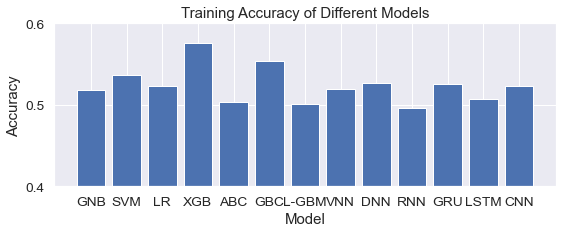

In [86]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','VNN','DNN','RNN','GRU','LSTM','CNN']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr_train["accuracy"],
            svm_cr_train["accuracy"],
            lr_cr_train["accuracy"],
            xgb_cr_train["accuracy"],
            abc_cr_train["accuracy"],
            gbc_cr_train["accuracy"],
            lightgbm_cr_train["accuracy"],
            vnn_cr_train["accuracy"],
            dnn_cr_train["accuracy"],
            rnn_train_acc,
            gru_train_acc,
            lstm_train_acc,
            cnn_train_acc]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy)
ax.set_title('Training Accuracy of Different Models')
ax.set_yticks([0.40, 0.5, 0.6])
ax.set_ylim([0.40, 0.6])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


#### 6.2.2 Individual Testing Accuracy
<a name='section622'></a>

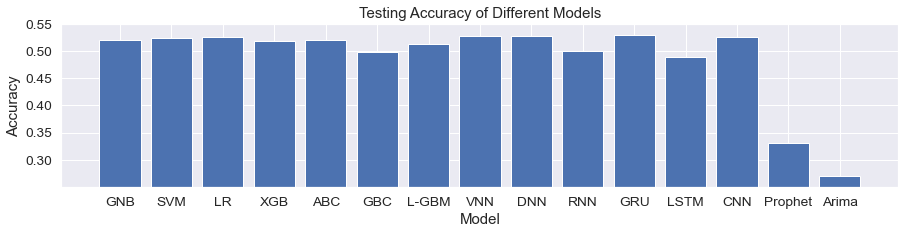

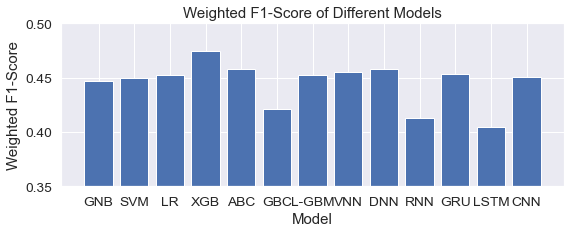

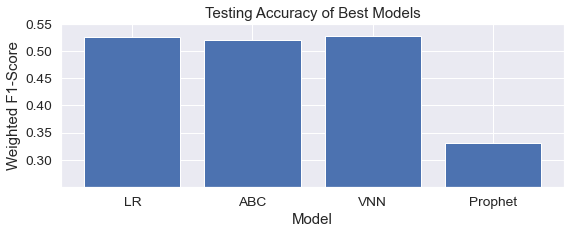

In [87]:
#Names of models for columns
models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','VNN','DNN','RNN','GRU','LSTM','CNN','Prophet','Arima']
models_no_ts = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','VNN','DNN','RNN','GRU','LSTM','CNN']
# For after fix
# models = ['GNB','SVM','LR','XGB','ABC','GBC','L-GBM','NN','VNN','DNN','RNN','GRU','LTSM','CNN','Prophet','Arima']

#Plot of models by accuracy
accuracy = [gnb_cr["accuracy"],
            svm_cr["accuracy"],
            lr_cr["accuracy"],
            xgb_cr["accuracy"],
            abc_cr["accuracy"],
            gbc_cr["accuracy"],
            lightgbm_cr["accuracy"],
            vnn_cr["accuracy"],
            dnn_cr["accuracy"],
            rnn_cr["accuracy"],
            gru_cr["accuracy"],
            lstm_cr["accuracy"],
            cnn_cr["accuracy"],
            0.33,
            0.27]
# For after fix
# accuracy = [gnb_cr["accuracy"],
#             svm_cr["accuracy"],
#             lr_cr["accuracy"],
#             xgb_cr["accuracy"],
#             abc_cr["accuracy"],
#             gbc_cr["accuracy"],
#             lightgbm_cr["accuracy"],
#             vnn_cr["accuracy"],
#             dnn_cr["accuracy"],
#             rnn_cr["accuracy"],
#             gru_cr["accuracy"],
#             ltsm_cr["accuracy"],
#             cnn_cr["accuracy"],
#             prophet_cr["accuracy"],
#             arima_cr["accuracy"]]


fig, ax = plt.subplots(figsize=(15, 3))
plt.bar(models, accuracy)
ax.set_title('Testing Accuracy of Different Models')
ax.set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
ax.set_ylim([0.25, 0.55])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()

#Plot of models by weighted avg f1 score
accuracy = [gnb_cr["weighted avg"]["f1-score"],
            svm_cr["weighted avg"]["f1-score"],
            lr_cr["weighted avg"]["f1-score"],
            xgb_cr["weighted avg"]["f1-score"],
            abc_cr["weighted avg"]["f1-score"],
            gbc_cr["weighted avg"]["f1-score"],
            lightgbm_cr["weighted avg"]["f1-score"],
            vnn_cr["weighted avg"]["f1-score"],
            dnn_cr["weighted avg"]["f1-score"],
            rnn_cr["weighted avg"]["f1-score"],
            gru_cr["weighted avg"]["f1-score"],
            lstm_cr["weighted avg"]["f1-score"],
            cnn_cr["weighted avg"]["f1-score"]]
# For after fix
# accuracy = [gnb_cr["weighted avg"]["f1-score"],
#             svm_cr["weighted avg"]["f1-score"],
#             lr_cr["weighted avg"]["f1-score"],
#             xgb_cr["weighted avg"]["f1-score"],
#             abc_cr["weighted avg"]["f1-score"],
#             gbc_cr["weighted avg"]["f1-score"],
#             lightgbm_cr["weighted avg"]["f1-score"],
#             vnn_cr["weighted avg"]["f1-score"],
#             dnn_cr["weighted avg"]["f1-score"],
#             rnn_cr["weighted avg"]["f1-score"],
#             gru_cr["weighted avg"]["f1-score"],
#             ltsm_cr["weighted avg"]["f1-score"],
#             cnn_cr["weighted avg"]["f1-score"],
#             prophet_cr["weighted avg"]["f1-score"],
#             arima_cr["weighted avg"]["f1-score"]]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models_no_ts, accuracy)
ax.set_title('Weighted F1-Score of Different Models')
ax.set_yticks([0.35, 0.4, 0.45, 0.5])
ax.set_ylim([0.35, 0.5])
ax.set_xlabel('Model')
ax.set_ylabel('Weighted F1-Score')
plt.show()

best_accuracy = [lr_cr["accuracy"],
                 abc_cr["accuracy"],
                 vnn_cr["accuracy"],
                 0.33]
best_models = ['LR','ABC','VNN','Prophet']
fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(best_models, best_accuracy)
ax.set_title('Testing Accuracy of Best Models')
ax.set_yticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
ax.set_ylim([0.25, 0.55])
ax.set_xlabel('Model')
ax.set_ylabel('Weighted F1-Score')
plt.show()

#### 6.2.3 Training Accuracy Grouped by Model Type
<a name='section623'></a>

In [98]:
## Standard Models Training Accuracy##
gnb_vis_pred_train = gnb_final.fit(X_train, y_train).predict(X_train)
svm_vis_pred_train = svm_final.fit(X_train, y_train).predict(X_train)
lr_vis_pred_train = lr_final.fit(X_train, y_train).predict(X_train)

## Boosting Models ##
xgb_vis_pred_train = xgb_final.fit(X_train, y_train).predict(X_train)
abc_vis_pred_train = abc_final.fit(X_train, y_train).predict(X_train)
gbc_vis_pred_train = gbc_final.fit(X_train, y_train).predict(X_train)
lightgbm_vis_pred_train = lightgbm_final.predict(X_train)

## NN Models ##
# Defined in models

## Time Series Modules ##
# prophet_vis_pred_train = prophet_final.predict(X_test)
# arima_vis_pred_train = arima_final.predict(X_test)

#Save results as dict
lr_cr_train = classification_report(y_train, lr_vis_pred_train, output_dict=True)
gnb_cr_train = classification_report(y_train, gnb_vis_pred_train, output_dict=True)
svm_cr_train = classification_report(y_train, svm_vis_pred_train, output_dict=True)
xgb_cr_train = classification_report(y_train, xgb_vis_pred_train, output_dict=True)
abc_cr_train = classification_report(y_train, abc_vis_pred_train, output_dict=True)
gbc_cr_train = classification_report(y_train, gbc_vis_pred_train, output_dict=True)
lightgbm_cr_train = classification_report(y_train, lightgbm_vis_pred_train, output_dict=True)
vnn_cr_train = vnn_train_acc
dnn_cr_train = dnn_train_acc
# ACCURACY FOR BELOW AS VARIABLE
# rnn_cr_train = classification_report(y_train, rnn_vis_pred, output_dict=True)
# gru_cr_train = classification_report(y_train, gru_vis_pred, output_dict=True)
# ltsm_cr_train = classification_report(y_train, ltsm_vis_pred, output_dict=True)
# cnn_cr_train = classification_report(y_train, cnn_vis_pred, output_dict=True)
#CHECK IF FIXED
# prophet_cr_train = classification_report(y_train, prophet_vis_pred, output_dict=True)
# arima_cr_train = classification_report(y_train, arima_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

#Collective NN Training Accuracy 
nn_cr = vnn_cr_train["accuracy"] + dnn_cr_train["accuracy"] + rnn_cr["accuracy"] + gru_cr["accuracy"] +  lstm_cr["accuracy"] + cnn_cr["accuracy"] 
nn_cr = nn_cr/6
print(nn_cr)

#Collective TS Testing Accuracy 
#ts_cr =  prophet_cr["accuracy"], arima_cr["accuracy"]
#ts_cr = ts_cr/2
#Hardcoded
ts_cr=(0.33 + 0.27)/2
print(ts_cr)

[20:23:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.5131578947368421
0.5179824561403509
0.5149436090225563
0.30000000000000004


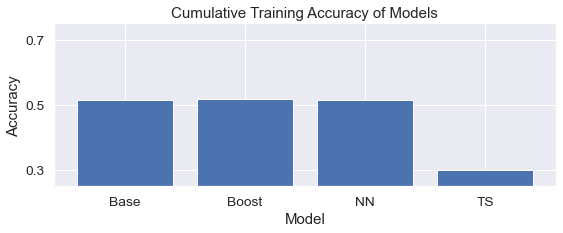

In [99]:
#Names of models for columns
#models = ['Base','Boost']
# For after fix
models = ['Base','Boost','NN','TS']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr,
            nn_cr,
            ts_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Training Accuracy of Models')
ax.set_yticks([0.30, 0.5, 0.70])
ax.set_ylim([0.25, 0.75])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


#### 6.2.4 Testing Accuracy Grouped by Model Type
<a name='section624'></a>

In [105]:
## Standard Models Test Accuracy ##
gnb_vis_pred = gnb_final.fit(X_train, y_train).predict(X_test)
svm_vis_pred = svm_final.fit(X_train, y_train).predict(X_test)
lr_vis_pred = lr_final.fit(X_train, y_train).predict(X_test)

## Boosting Models ##
xgb_vis_pred = xgb_final.fit(X_train, y_train).predict(X_test)
abc_vis_pred = abc_final.fit(X_train, y_train).predict(X_test)
gbc_vis_pred = gbc_final.fit(X_train, y_train).predict(X_test)
lightgbm_vis_pred = lightgbm_final.predict(X_test)

## NN Models ##
# Defined in models

## Time Series Modules ##
# prophet_vis_pred = prophet_final.predict(X_test)
# arima_vis_pred = arima_final.predict(X_test)

#Save results as dict
lr_cr = classification_report(y_test, lr_vis_pred, output_dict=True)
gnb_cr = classification_report(y_test, gnb_vis_pred, output_dict=True)
svm_cr = classification_report(y_test, svm_vis_pred, output_dict=True)
xgb_cr = classification_report(y_test, xgb_vis_pred, output_dict=True)
abc_cr = classification_report(y_test, abc_vis_pred, output_dict=True)
gbc_cr = classification_report(y_test, gbc_vis_pred, output_dict=True)
lightgbm_cr = classification_report(y_test, lightgbm_vis_pred, output_dict=True)
# Defined in models
# nn_cr = classification_report(y_test, nn_vis_pred, output_dict=True)
# vnn_cr = classification_report(y_test, vnn_vis_pred, output_dict=True)
# dnn_cr = classification_report(y_test, dnn_vis_pred, output_dict=True)
# rnn_cr = classification_report(y_test, rnn_vis_pred, output_dict=True)
# gru_cr = classification_report(y_test, gru_vis_pred, output_dict=True)
# ltsm_cr = classification_report(y_test, ltsm_vis_pred, output_dict=True)
# cnn_cr = classification_report(y_test, cnn_vis_pred, output_dict=True)
# CHECK IF FIXED
# prophet_cr = classification_report(y_test, prophet_vis_pred, output_dict=True)
# arima_cr = classification_report(y_test, arima_vis_pred, output_dict=True)

#Collective Base Training Accuracy 
base_cr = lr_cr["accuracy"] + gnb_cr["accuracy"] + svm_cr["accuracy"]
base_cr = base_cr/3
print(base_cr)

#Collective Boost Training Accuracy 
boost_cr = xgb_cr["accuracy"] + abc_cr["accuracy"] + gbc_cr["accuracy"] + lightgbm_cr["accuracy"]
boost_cr = boost_cr/4
print(boost_cr)

#Collective NN Training Accuracy 
nn_cr = vnn_cr["accuracy"] + dnn_cr["accuracy"] + rnn_cr["accuracy"] + gru_cr["accuracy"] +  lstm_cr["accuracy"] + cnn_cr["accuracy"] 
nn_cr = nn_cr/6
print(nn_cr)

#Collective TS Testing Accuracy 
#ts_cr =  prophet_cr["accuracy"], arima_cr["accuracy"]
#ts_cr = ts_cr/2
#Hardcoded
ts_cr=(0.33 + 0.27)/2
print(ts_cr)

[20:27:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.523391812865497
0.5195175438596491
0.5165204678362573
0.30000000000000004


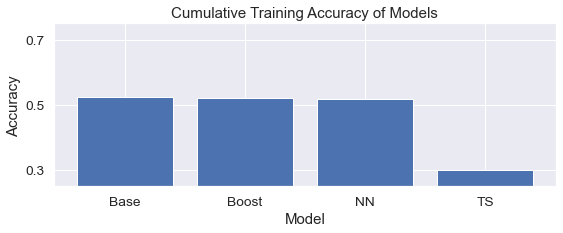

In [106]:
#Names of models for columns
#models = ['Base','Boost']
# For after fix
models = ['Base','Boost','NN','TS']


#Plot of models by accuracy
accuracy = [base_cr,
            boost_cr,
            nn_cr,
            ts_cr]


fig, ax = plt.subplots(figsize=(9, 3))
plt.bar(models, accuracy, width=0.8)
ax.set_title('Cumulative Training Accuracy of Models')
ax.set_yticks([0.30, 0.5, 0.70])
ax.set_ylim([0.25, 0.75])
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.show()


### 6.3 Confusion Matrix Plots
<a name='section63'></a>

In [ ]:
#PLot confusion matrix of all models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def confusion_plt (model):
    cm = confusion_matrix(y_test, model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A','D','H'])
    disp.plot(cmap='Reds');
    plt.grid(False)
    plt.show()

# Plot all confusion plots choose best few models for display
confusion_plt(lr_vis_pred)
confusion_plt(gnb_vis_pred)
confusion_plt(svm_vis_pred)
confusion_plt(xgb_vis_pred)
confusion_plt(abc_vis_pred)
confusion_plt(gbc_vis_pred)
confusion_plt(lightgbm_vis_pred)
# confusion_plt(nn_vis_pred)
# confusion_plt(vnn_vis_pred)
# confusion_plt(dnn_vis_pred)
# confusion_plt(rnn_vis_pred)
# confusion_plt(gru_vis_pred)
# confusion_plt(ltsm_vis_pred)
# confusion_plt(cnn_vis_pred)
# confusion_plt(prophet_vis_pred)
# confusion_plt(arima_vis_pred)

### 6.4 Comparison of Best Models from Each Category
<a name='section64'></a>

In [ ]:
# Plot best models from each category
def output_model_comp (output):
    best_model_comp = pd.DataFrame([['Precision', 
                                     lr_cr[output]['precision'], 
                                     abc_cr[output]['precision'], 
                                     vnn_cr[output]['precision'], 
                                     gnb_cr[output]['precision']], 
                                    ['Recall', 
                                     lr_cr[output]['recall'], 
                                     abc_cr[output]['recall'], 
                                     vnn_cr[output]['recall'], 
                                     gnb_cr[output]['recall']], 
                                    ['F1-Score',
                                     lr_cr[output]["f1-score"], 
                                     abc_cr[output]["f1-score"], 
                                     vnn_cr[output]["f1-score"], 
                                     gnb_cr[output]["f1-score"]]], 
                  columns=['Model', 'Base', 'Boost', 'Neural Net','Time Series (TEST)'])
    return best_model_comp

yaxis = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
fig1 = output_model_comp('0').plot(x='Model', kind='bar', stacked=False, title='Away Win', figsize=(12,4), ylim=(0,1), yticks=yaxis)
fig2 = output_model_comp('1').plot(x='Model', kind='bar', stacked=False, title='Draw', figsize=(12,4), ylim=(0,1), yticks=yaxis)
fig3 = output_model_comp('2').plot(x='Model', kind='bar', stacked=False, title='Home Win', figsize=(12,4), ylim=(0,1), yticks=yaxis)
    

## 7. Final Predictions on Test Set
<a name='section7'></a>

## 7.1 Data Cleaning
<a name='section71'></a>

In [ ]:
# Up-to-date data of season 2021 is named as 'updatedData' 
# Test set is named as 'testData'

# only pick the columns that are presented in the training set, drop the others
updatedData = updatedData[data.columns.tolist()]

# check if there are invalid data
assert updatedData.shape[0] == removeInvalidData(updatedData).shape[0]

## 7.2 Priors Derivation 
<a name='section72'></a>

In [ ]:
# concatenate the up-to-date data of season 2021 and the test set
final_data = pd.concat([updatedData,testData],ignore_index=True,sort=False)
# convert different date formats into test set format
convertDate(final_data)
#construct priors for test set
final_data = DerivePriors(final_data)
final_data